## Instructions for creating a simple model

*by Jeroen van der Does de Willebois*

This file contains simple instructions to create an Agent Based Model for  transport network analysis.

1. Create a network of nodes and edges: 
    1.1. Go to https://extract.bbbike.org/ and fill in the coordinates of the area you want
    1.2. Download the file in **shapefile format**
    1.3. extract all the files that say "waterways"and place them in a seperate file
    
    
    
  
2. Insert the path in the line below that says"PATH_NAME" with the location of the shapefile (shp) on your computer; a path is for example in my case: /user/jeroenvanderdoes/downloads/map_waterways/waterways.shp





3. Remember, all the other "waterways" files need to be containend in the same foler, eventhough you dont refer to them in your path.








### Packages

- Make sure you'll have these packages installed with anaconda and python 3+


In [1]:
%load_ext autoreload
%autoreload 2
import time
import random

import networkx as nx

import numpy as np
import math
import pandas as pd

from matplotlib import animation
from JSAnimation import IPython_display
%matplotlib inline
import utm
import geopandas as gpd
import matplotlib.pylab as plt

### Create a graph

The following code creates a usuable graph for networkx. What it basically does is converting long lat coordinates into UTM coordinates so it is easier to work with, and calculates the distance or length of each edge and adds it as attribute.



In [2]:
def calculate_distance(Node1, Node2):
    # calculate distance between two points
    distance = float(((Node2[0]-Node1[0])**2+(Node2[1]-Node1[1])**2)**0.5)
    return float(distance)

#insert the path to the location of your shapefile instead of "PATH_NAME"

G=nx.read_shp('./waterways.shp', simplify=False) #change to simplify = TRUE for more simple network without to many nodes
#G=nx.read_shp('PATH_NAME', simplify=False)
#EXAMPLE:
#G=nx.read_shp('/Users/JeroenvanderDoes/Dropbox/Studie/Master/Thesis/Onderwerpen/Programs/QGIS/waterways_rine/waterways.shp', simplify=True)

H_G = nx.Graph()

lat_lon_to_index = {}

for i, node in enumerate(G.nodes()): #adds nodes with label 1 till n nodes to the network. 
    node_utm = utm.from_latlon(node[0],node[1]) # convert to utm coordinates; 
    node_utm_total = (node_utm[1], node_utm[0]) # shapefile was in longlat instead of latlong
    H_G.add_node(i, pos= node_utm_total)
    lat_lon_to_index[node] = i

# adds edges with attributes to the graph from shapefile according to the order in which the edges are ordered in the shapefile
# add distance as an attribute to each edge, nessecary for networkx algorithms
for edge in G.edges(data=True): 
    H_G.add_edge(lat_lon_to_index[edge[0]], lat_lon_to_index[edge[1]], dis= calculate_distance(nx.get_node_attributes(H_G, 'pos')[lat_lon_to_index[edge[1]]], nx.get_node_attributes(H_G, 'pos')[lat_lon_to_index[edge[0]]]))
    

w_G = H_G

#nodelist omzetten naar pandas dataframe omdat zodat hij veel makkelijker en sneller de coordinaten van de nodes kan opzoeken
#pandas >>> nx.get_node_attributes kwa snelheid
graph_df = pd.DataFrame.from_dict(nx.get_node_attributes(w_G, 'pos'), orient='index', columns=["lat", "long"]) 


/Users/JeroenvanderDoes/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


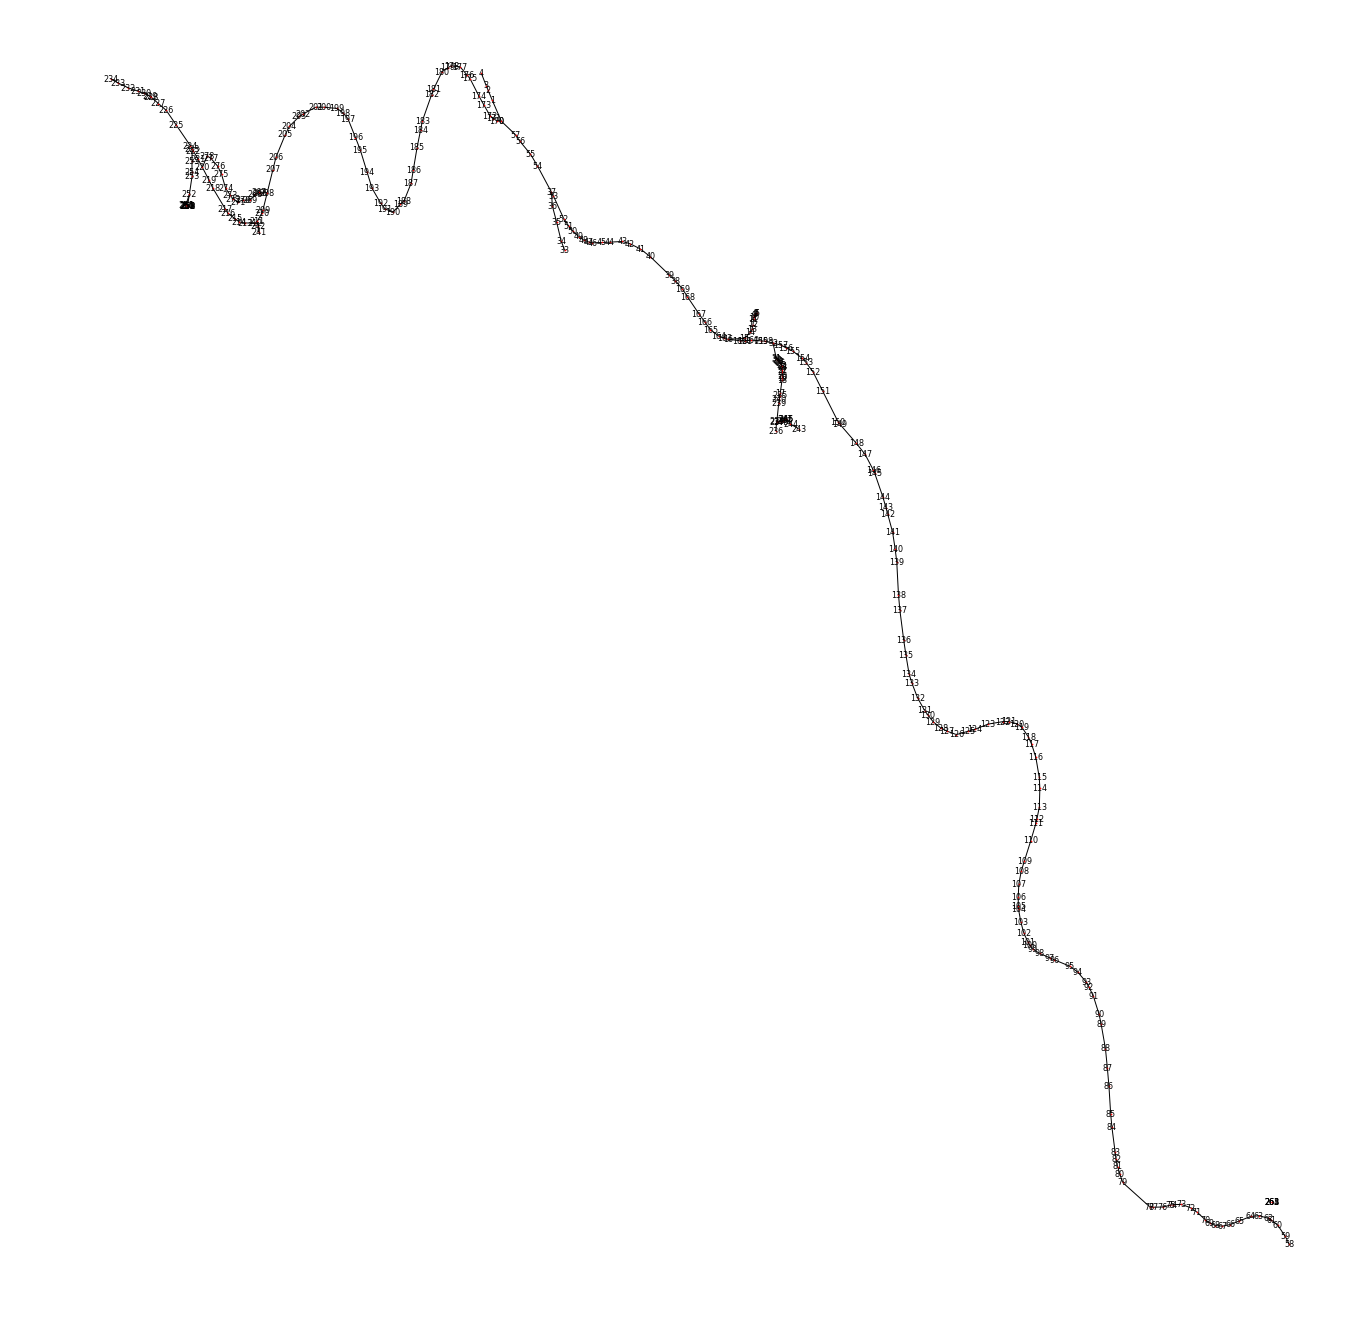

In [3]:
#shows your network
plt.figure(figsize=(18,18))
nx.draw(w_G, nx.get_node_attributes(w_G, 'pos'), with_labels=True, node_size=0.5, font_size = 8)
#plt.savefig('/Users/JeroenvanderDoes/Downloads/Amsterdam_Canals_directed_new.pdf', format='pdf', rasterized=False)
plt.show()

### Vessel class

- Baseclass vessel
- includes methods such as: 
    - creating a path based on predefined start and end nodes
    - sailing that path
    - logging each step of that path
    
- ***IMPORTANT*** The vessel will make a route based on dijkstra and a given start and destination. These start and end **nodes** need to be defined in the vessel class.

- Each node has a label in form of a number
-  Insert your own start and end node into the code. Remove the "random sample" code first. I've marked it with the following: **INSERT START AND END NODE HERE in the following format; number 

- Based on the graph plotted above, you should be able to insert start and end label (numbers) of the nodes as input for the simulation





In [4]:
class Vessel(object):
    def __init__(self):
        """Base class vessel"""
        self.start = random.sample(w_G.nodes, 1)[0] #INSERT START NODE LABEL
        self.end = random.sample(w_G.nodes, 1)[0] #INSERT DESTINATION NODE LABEL
        self.path = self.route(w_G,self.start, self.end)
        self.coor_log = []
        self.vessel_pos = (graph_df['lat'].loc[self.path[0]], graph_df['long'].loc[self.path[0]]) # nx.get_node_attributes(w_G, 'pos')[self.path[0]] 
        self.w_G = w_G
        self.to_node_id = 1
        self.move = 300 # meters per timestep (now 10s)
        self.travel_time = 0
        self.active = True
        self.coor_log_x =[]
        self.coor_log_y=[]

        
    def route(self, w_G, start, end):
        return nx.dijkstra_path(w_G, start, end, weight = 'dis')
    
    
    def calculate_distance(self, Node1, Node2):
        # calculate distance between two points
        distance = float(((Node2[0]-Node1[0])**2+(Node2[1]-Node1[1])**2)**0.5)
        return float(distance)
    

    def calculate_angle(self, Node1, Node2):
        # calculate angle going from point 1 to point 2 (NB: atan2(y,x))
        angle =  (float(math.atan2(Node2[1]-Node1[1],Node2[0]-Node1[0]))) #*float((180.0 / math.pi)) for degrees
        return float(angle)
        

    def pos_next_step(self, Node1, Node2, move):#move cannot be replaced by self.move because move may change by 'remaining_move'
        # move towards Node2
        distance = self.calculate_distance(Node1, Node2) #wordt dit wel hier gebruikt?
        angle = self.calculate_angle(Node1, Node2)
        new_node = (float(Node1[0]+math.cos(angle)*move), float(Node1[1]+math.sin(angle)*move))
        return new_node

    
    def move_on_path(self):
        # 1. vessel_pos is your boat
        # 2. you need to know the next node in the path
        # 3. calculate the distance between Node1 and the next node
        
        if self.active == True: #start logging  each step of vessel;
            
            to_node_pos = (graph_df['lat'].loc[self.path[self.to_node_id]], graph_df['long'].loc[self.path[self.to_node_id]])
            distance_to_next_node = self.calculate_distance(self.vessel_pos, to_node_pos)

            # If move <= distance to next node, make move
            if self.move < distance_to_next_node:
                    vessel_pos_new = self.pos_next_step(self.vessel_pos, to_node_pos, self.move)


            else:
                if self.to_node_id == len(self.path)-1:
                    self.active = False #stop logging if vessel arrives at destination
                    vessel_pos_new = to_node_pos  
 
                else:
                    # reposition vessel at next node and calculate remaining move distance
                    self.vessel_pos = (graph_df['lat'].loc[self.path[self.to_node_id]], graph_df['long'].loc[self.path[self.to_node_id]])

                    # up the to_node_id with 1 and find new to_node_pos
                    self.to_node_id+=1
                    
                    # calculate distance to next node
                    remaining_move = float(self.move-distance_to_next_node)
                    
                    #updates new distance to next node
                    to_node_pos = (graph_df['lat'].loc[self.path[self.to_node_id]], graph_df['long'].loc[self.path[self.to_node_id]])
                    distance_to_next_node = self.calculate_distance(self.vessel_pos, to_node_pos)
                    
                    #checks for 'overshoot', if remaining distance > next distance, place on next node and check again till condition is no longer valid
                    while remaining_move > distance_to_next_node:
                        self.vessel_pos = (graph_df['lat'].loc[self.path[self.to_node_id]], graph_df['long'].loc[self.path[self.to_node_id]])
                        remaining_move = float(remaining_move-distance_to_next_node)
                        
                        # if statement to check if it is on end of path (last point of path could be couple of nodes which lengt < move)
                        #otherwise, node_id > len of path and can;t compute
                        if self.to_node_id == len(self.path)-1:
                            self.active = False #stop logging if vessel arrives at destination
                            vessel_pos_new = to_node_pos  
                            break
                            
                        self.to_node_id+=1
                        
                        #vessel is placed on new node, now update distance to next node 
                        to_node_pos = (graph_df['lat'].loc[self.path[self.to_node_id]], graph_df['long'].loc[self.path[self.to_node_id]])
                        distance_to_next_node = self.calculate_distance(self.vessel_pos, to_node_pos)
                        
                    vessel_pos_new = self.pos_next_step(self.vessel_pos, to_node_pos, remaining_move)
                    
            #updates position of vessel
            self.vessel_pos = vessel_pos_new
            
            #adds new positions to log
            self.coor_log.append(self.vessel_pos) #library for tuple (x,y) coordinate of the vessel
            self.coor_log_x.append(self.vessel_pos[0]) # library for only x coordinates
            self.coor_log_y.append(self.vessel_pos[1])# library for only y coordinates
            


### Simulator class
- Actually does al the work
- timestep and number fo simulation steps

- Generates an random amount of ships based on the "druktelijst"

In [5]:
class Simulation():
    def __init__(self):
        self.stepsize = 10
        self.sim_steps = 100 #int((24*60*60)/self.stepsize)
        self.vessel_count = 10
        self.ves_list = [] #list of active vessel
        self.start_time_list = [] # list for starttimes for vessel for pd.dataframe
        self.druktelijst_pc = [0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1] #generation list for vessels
        self.distr = self.distr_gen() #chance generator for distribution of vessel of a given day, can be modified to represent different scenarios
        self.distr_pc = self.distr_gen_from_distr_list(self.druktelijst_pc)
        self.step_count = 0
        
        
    def run_full_sim(self):
        for i in range(self.sim_steps):
            self.one_sim_step()
            print(i)
            
        #Create pandas dataframe of vessels log' for plotting purposes.
        self.x_df = pd.DataFrame(np.zeros([self.sim_steps, len(self.ves_list)]))
        self.y_df = pd.DataFrame(np.zeros([self.sim_steps, len(self.ves_list)]))
        
                
        for i, time, ves in zip(range(len(self.ves_list)), self.start_time_list, self.ves_list):
            
            #creates dataframe for x coordinates and one for y coordinates based on vessel logs
            ds_x = pd.Series(np.array(ves.coor_log_x, dtype = np.float64))
            ds_y = pd.Series(np.array(ves.coor_log_y, dtype = np.float64))
        
            """only adds coordinates stamps as column in data frame based on timestep in start_time_list; so if a vessel is generated in timestep 20 and
            logs every step and arrives at timestep 30, the coordinates of the timesteps 20 untill 30 are added to the dataframe
            on row 20 untill 30. """
            
            self.x_df[i].iloc[time : time + len(ds_x)] = ds_x.values
            self.y_df[i].iloc[time : time + len(ds_y)] = ds_y.values 
            
            #replaces values of 0 to nan for plotting purposes
            self.x_df = self.x_df.replace(0.0, np.nan) 
            self.y_df = self.y_df.replace(0.0, np.nan)
        
    def one_sim_step(self):
        
        for z in range(self.distr_pc[self.step_count]):
            self.ves_list.append(Vessel())
            self.start_time_list.append(self.step_count)
            
        
        for ves in self.ves_list:
            ves.move_on_path()
        
        self.step_count += 1
   
    def distr_gen(self): # voeg boot toe met bepaalde kans 
        threshold = self.vessel_count / float(self.sim_steps)
        count_list = []
    
        # maakt lijst met hoeveel boten er spawnen op elke tijdstap
        for i in range(self.sim_steps):
            counter = 0
            
            while True:
                nummer = random.random()
                if nummer < threshold:
                    counter += 1
                else:
                    break
            count_list.append(counter)
        #print (count_list)
        return count_list
    
    
    def distr_gen_from_distr_list(self, druktelijst):
        start_time = time.time()
        
        te_returnen_lijst = []
        for uurdrukte in druktelijst:

            uurlijst = list(np.zeros(round(self.sim_steps/len(druktelijst)), dtype = int))
            for i in range(uurdrukte):
                uurlijst[random.choice(range(len(uurlijst)))] += 1
            te_returnen_lijst += uurlijst
     
        if self.sim_steps > len(te_returnen_lijst):
            for i in range(self.sim_steps - len(te_returnen_lijst)):
                te_returnen_lijst.append(0)
                
        elif len(te_returnen_lijst) > self.sim_steps:
            te_returnen_lijst = te_returnen_lijst[:len(te_returnen_lijst) - (len(te_returnen_lijst) - self.sim_steps)]
            
        return te_returnen_lijst


  

In [6]:
simulation = Simulation()
simulation.run_full_sim()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


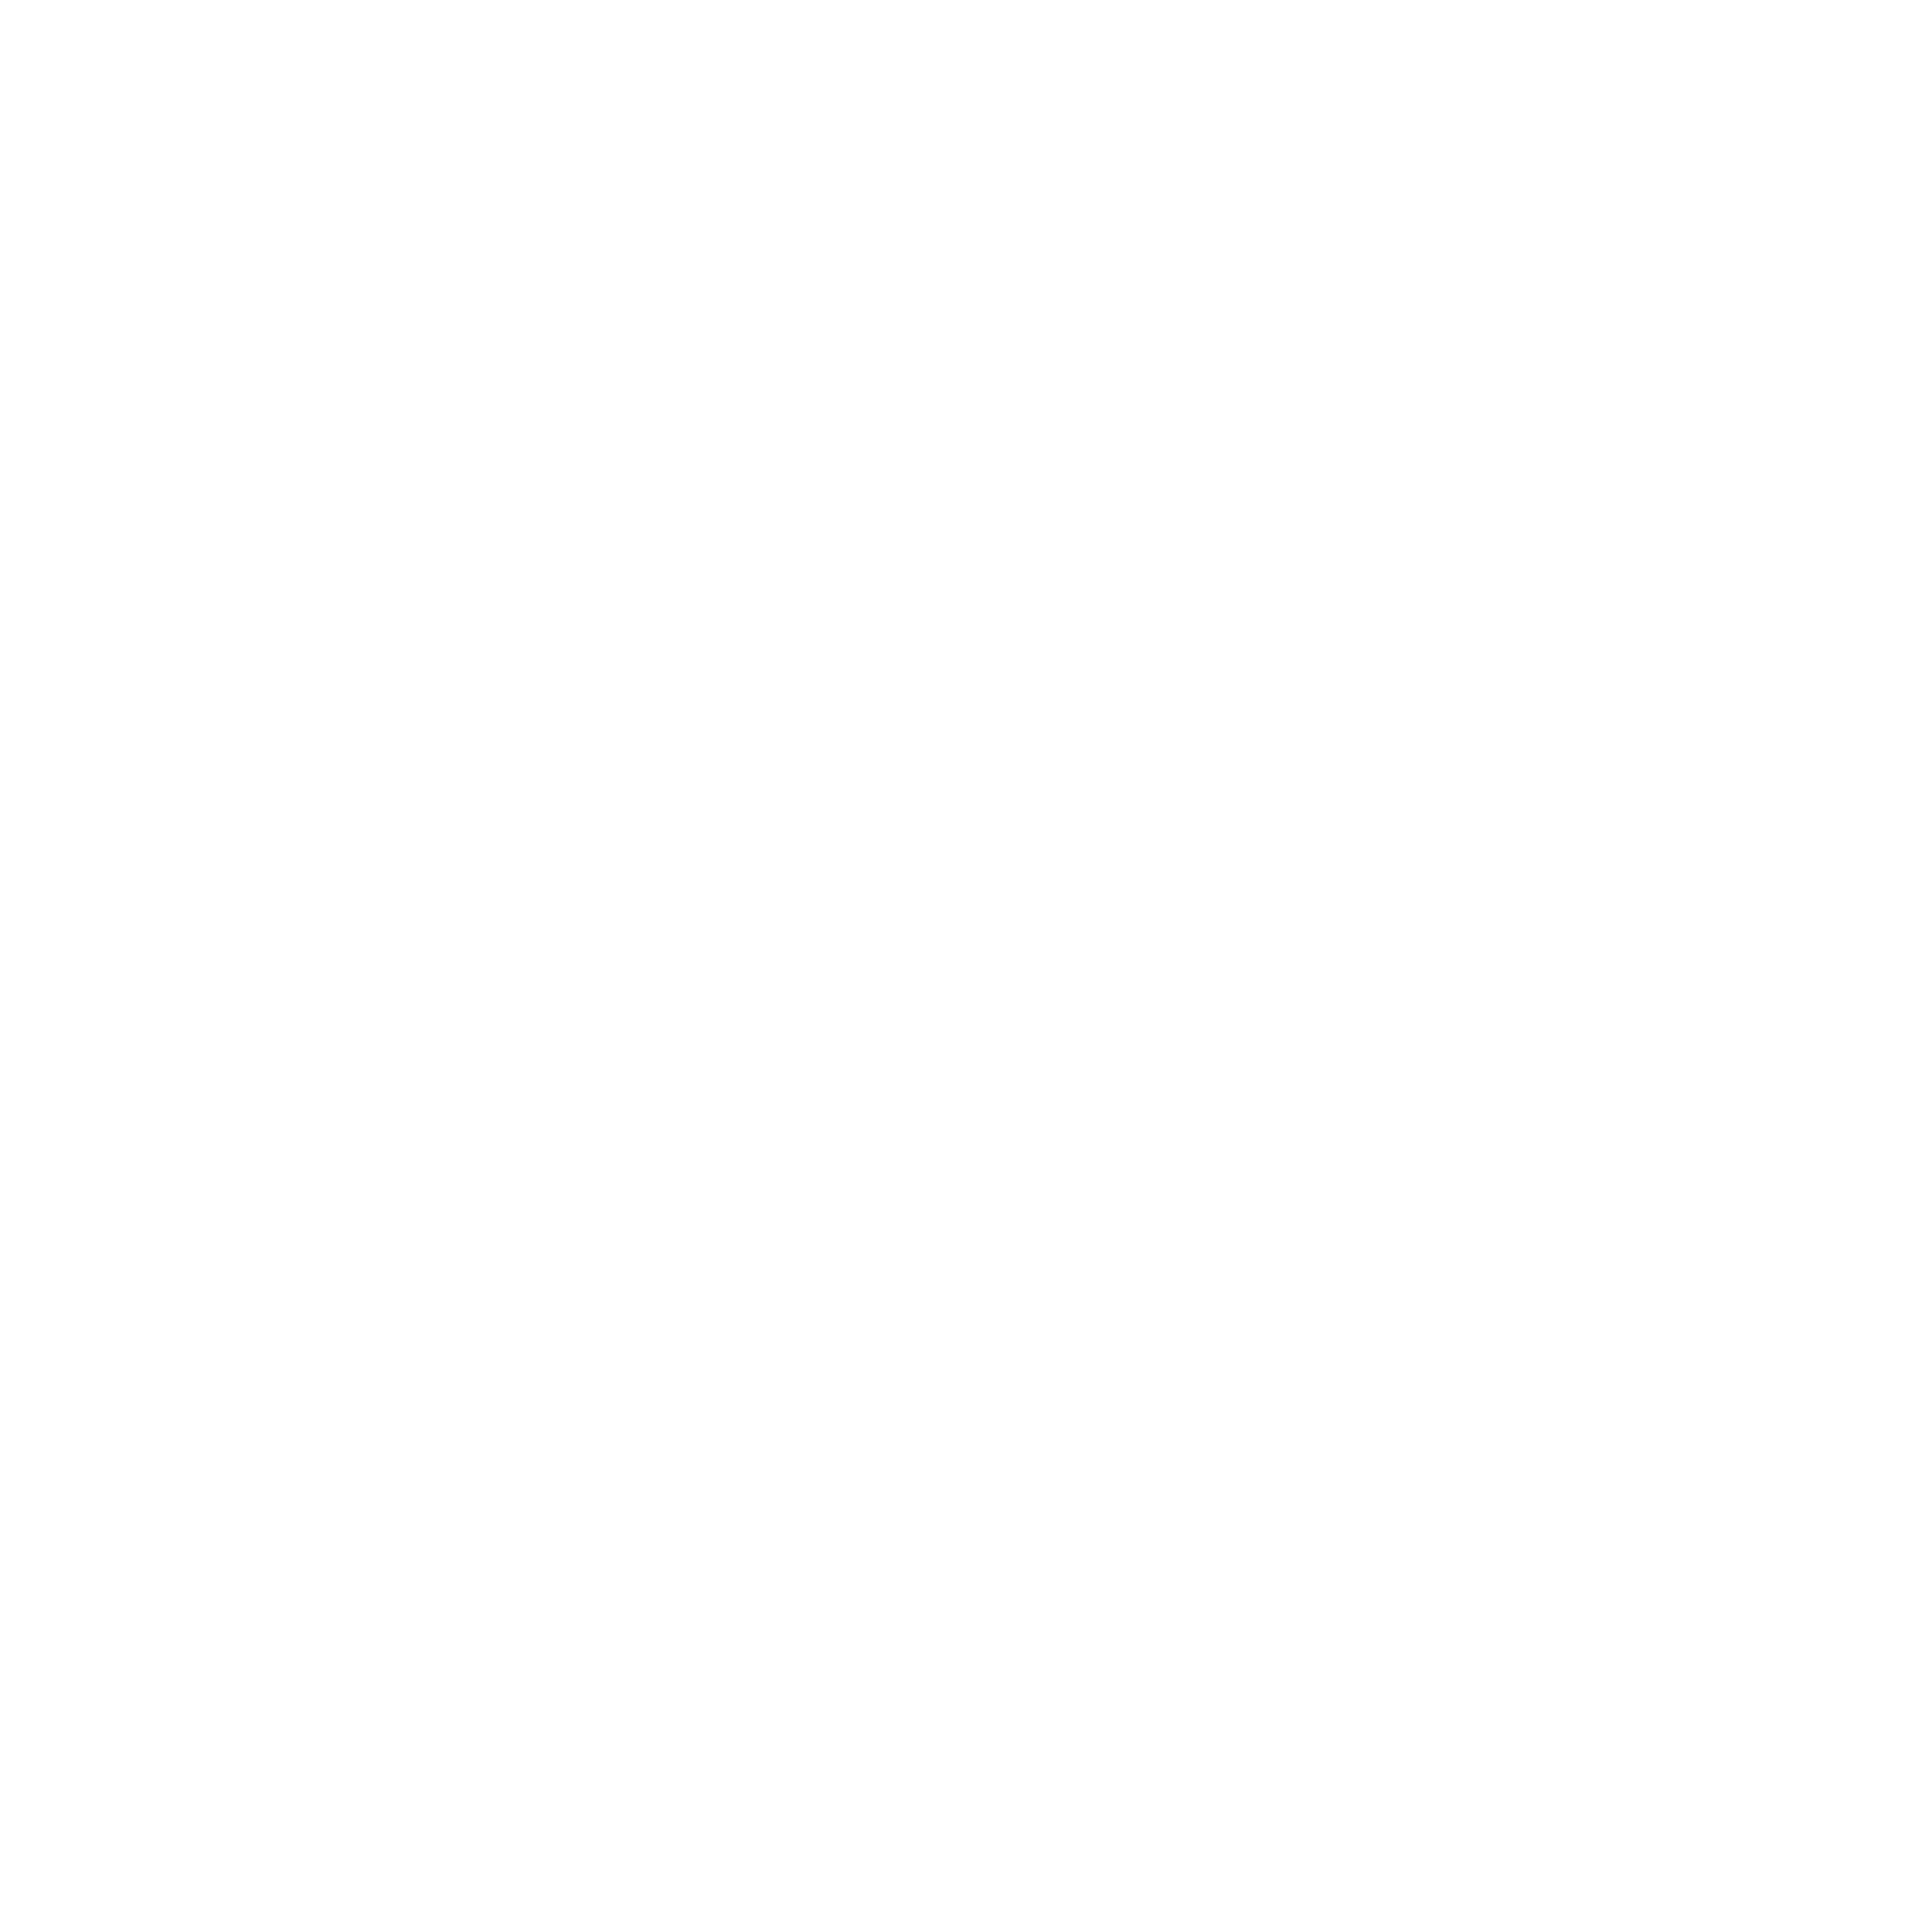

/Users/JeroenvanderDoes/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):



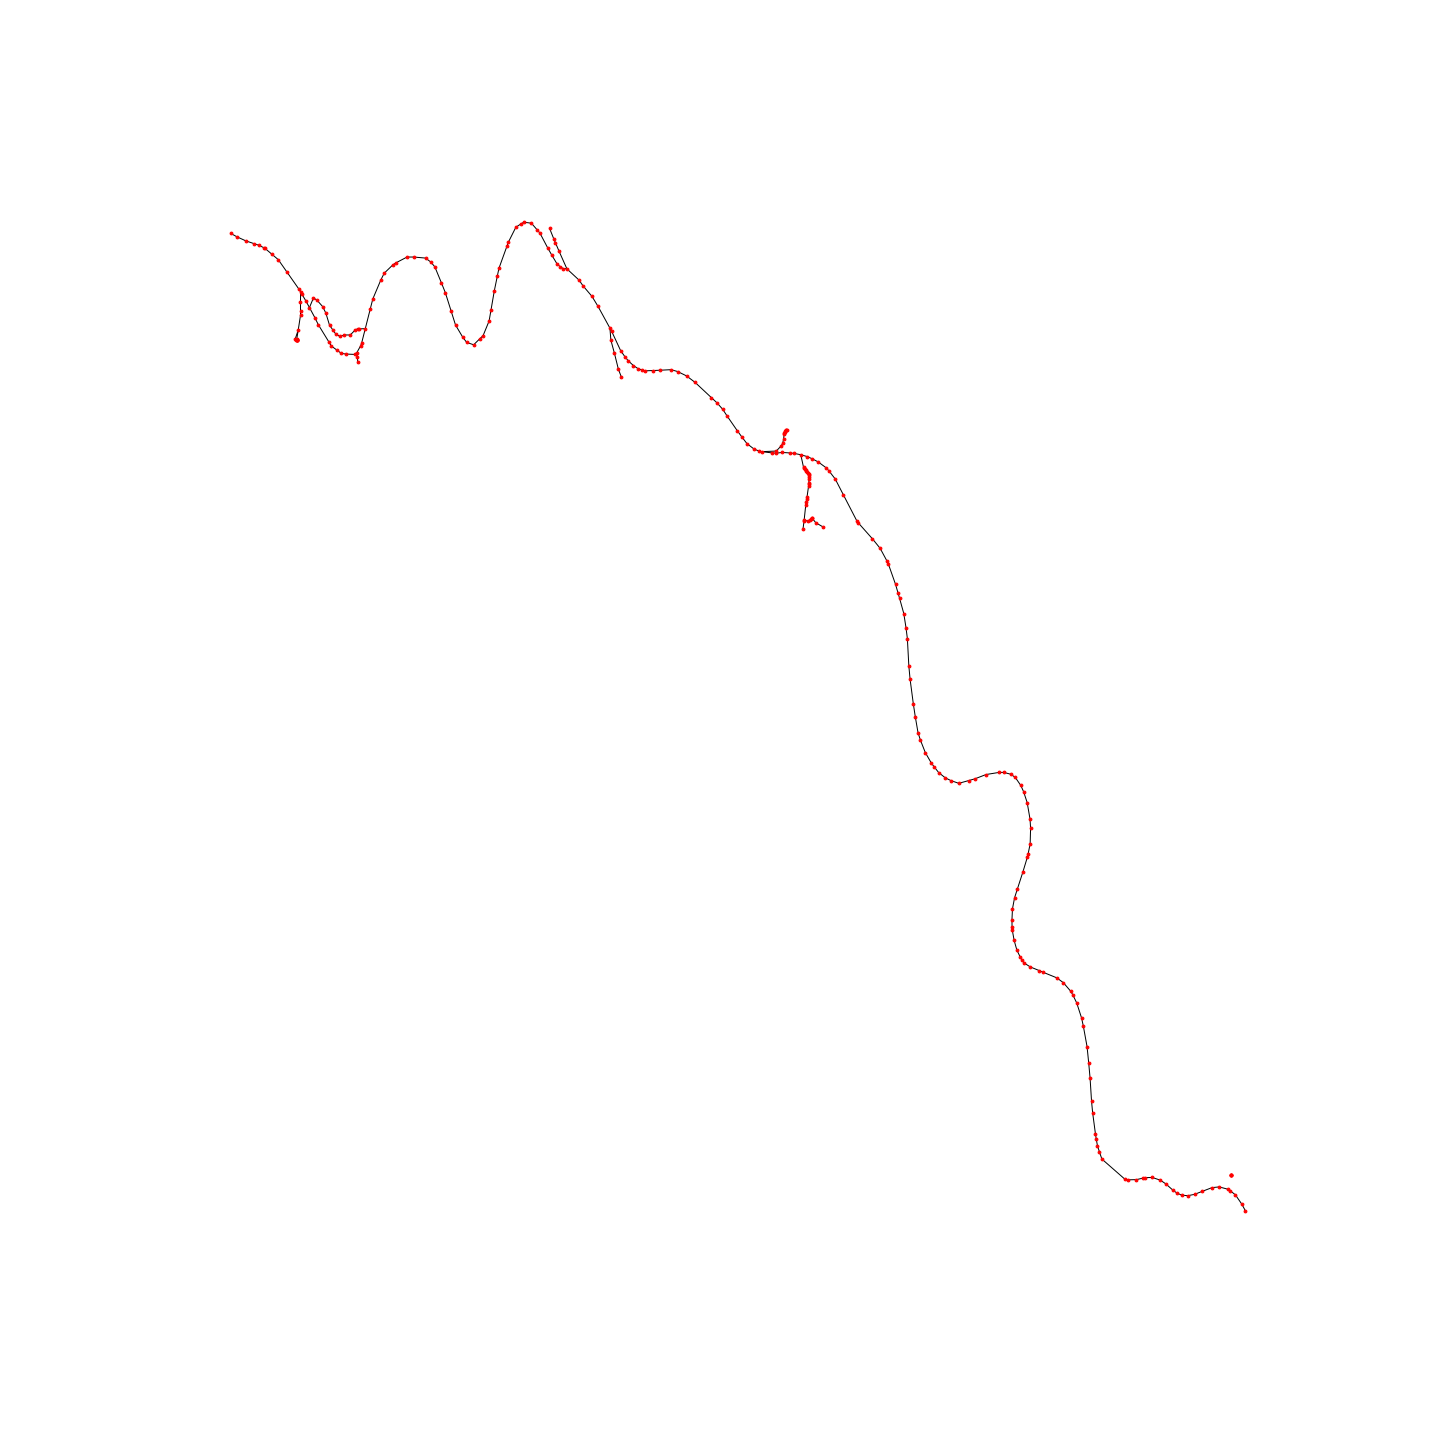
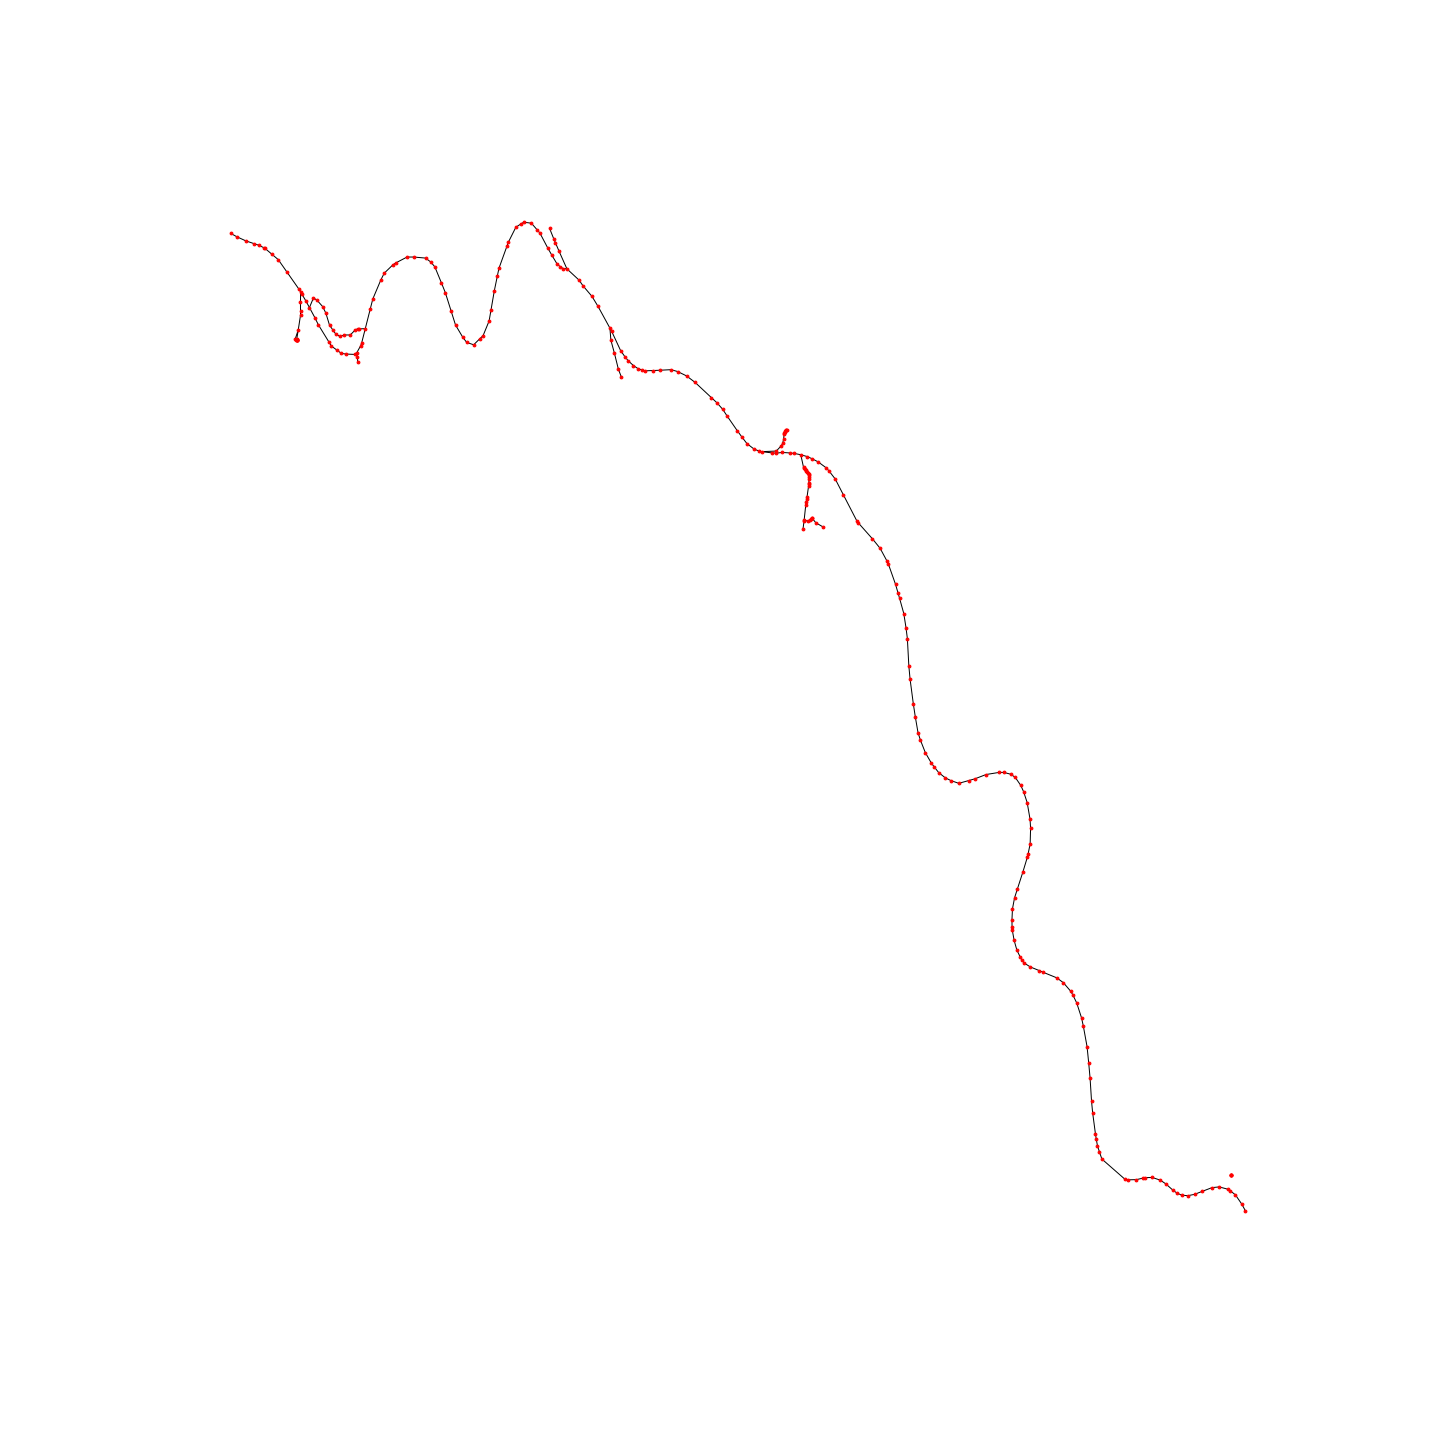
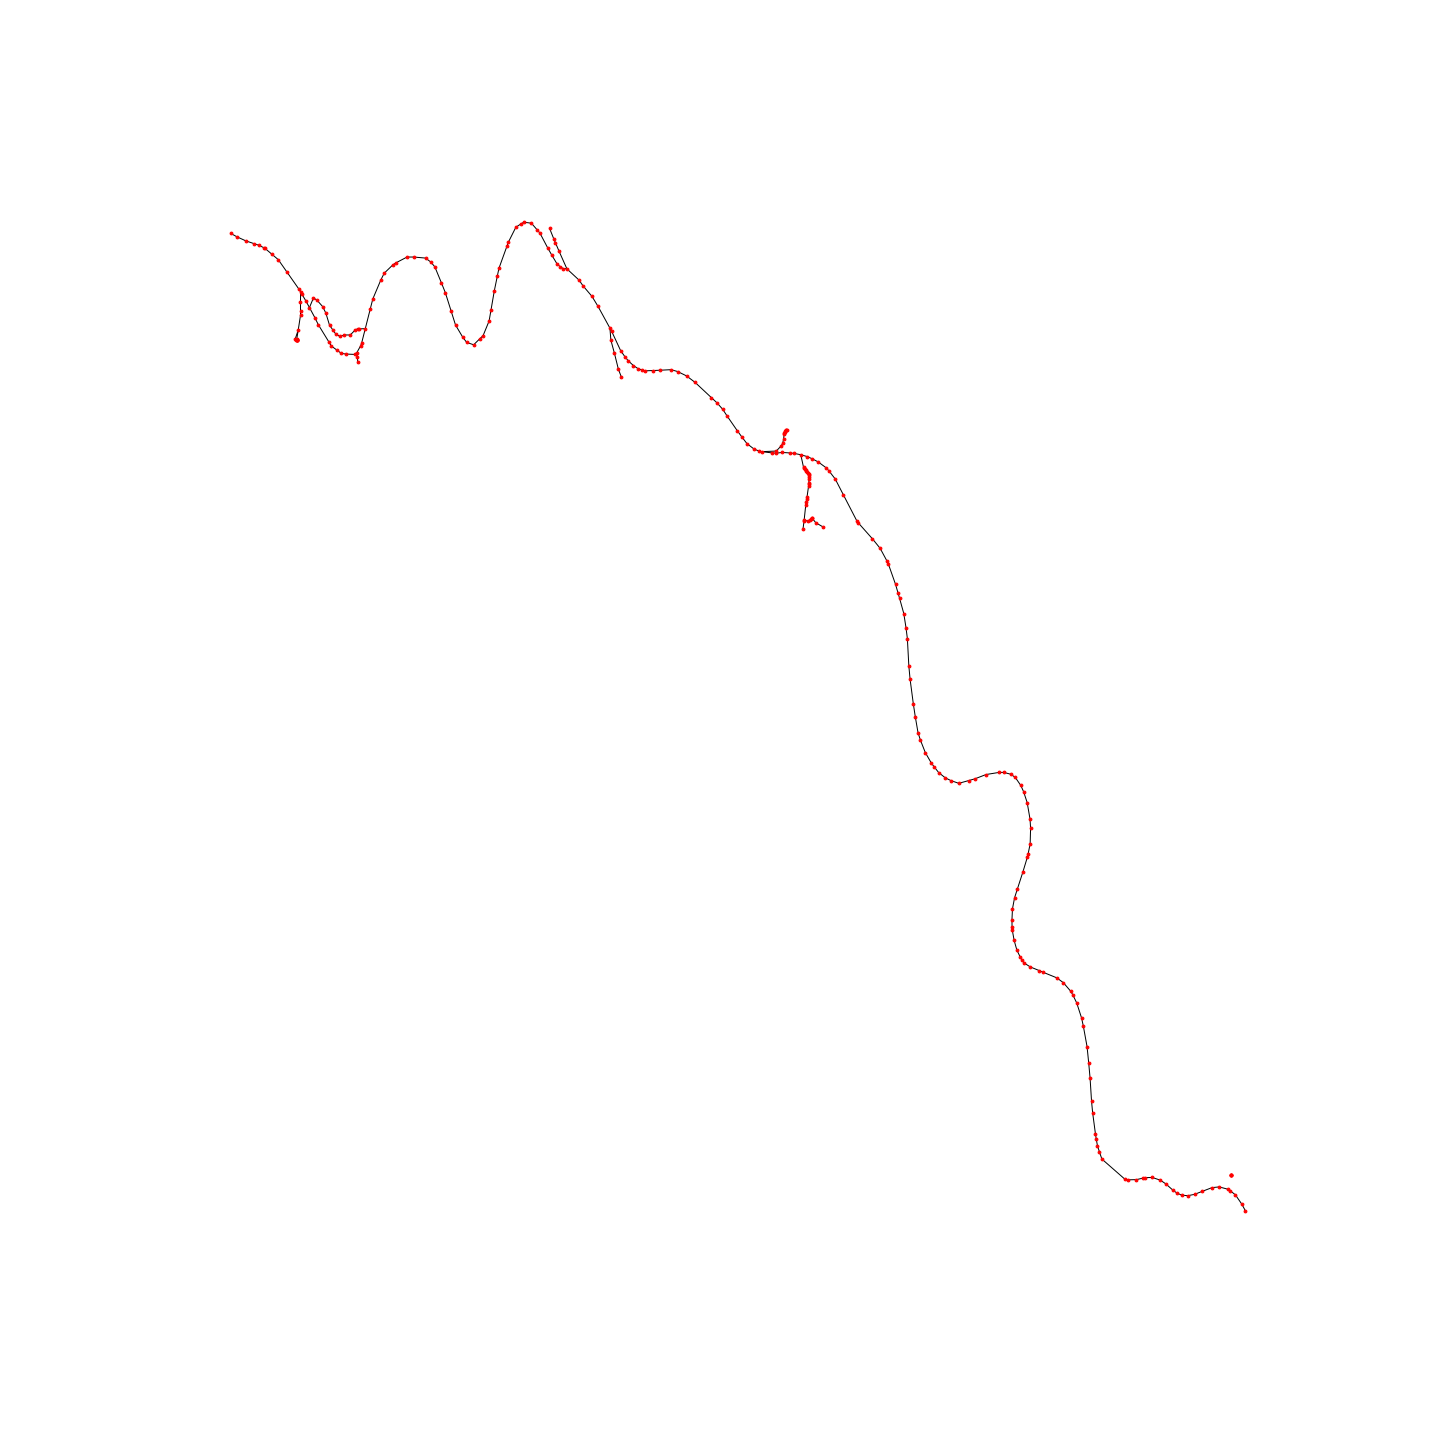
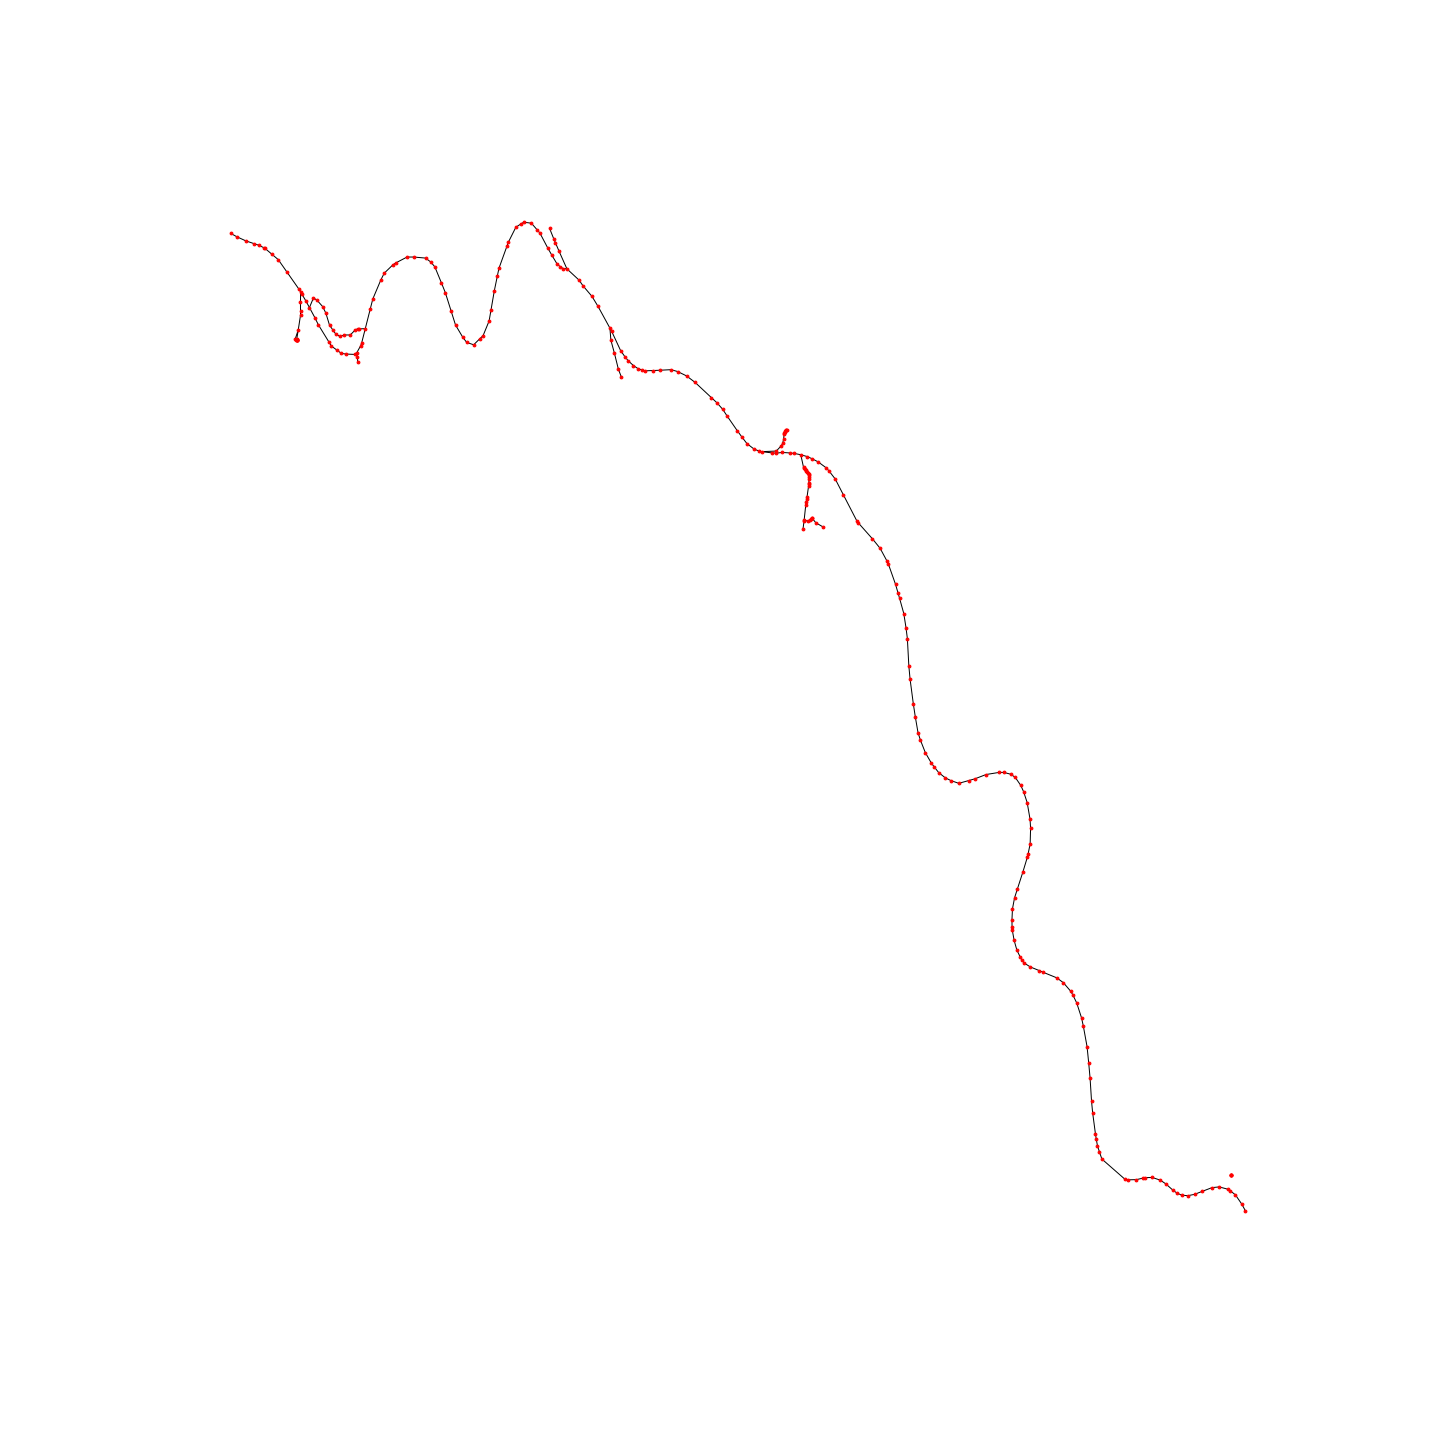
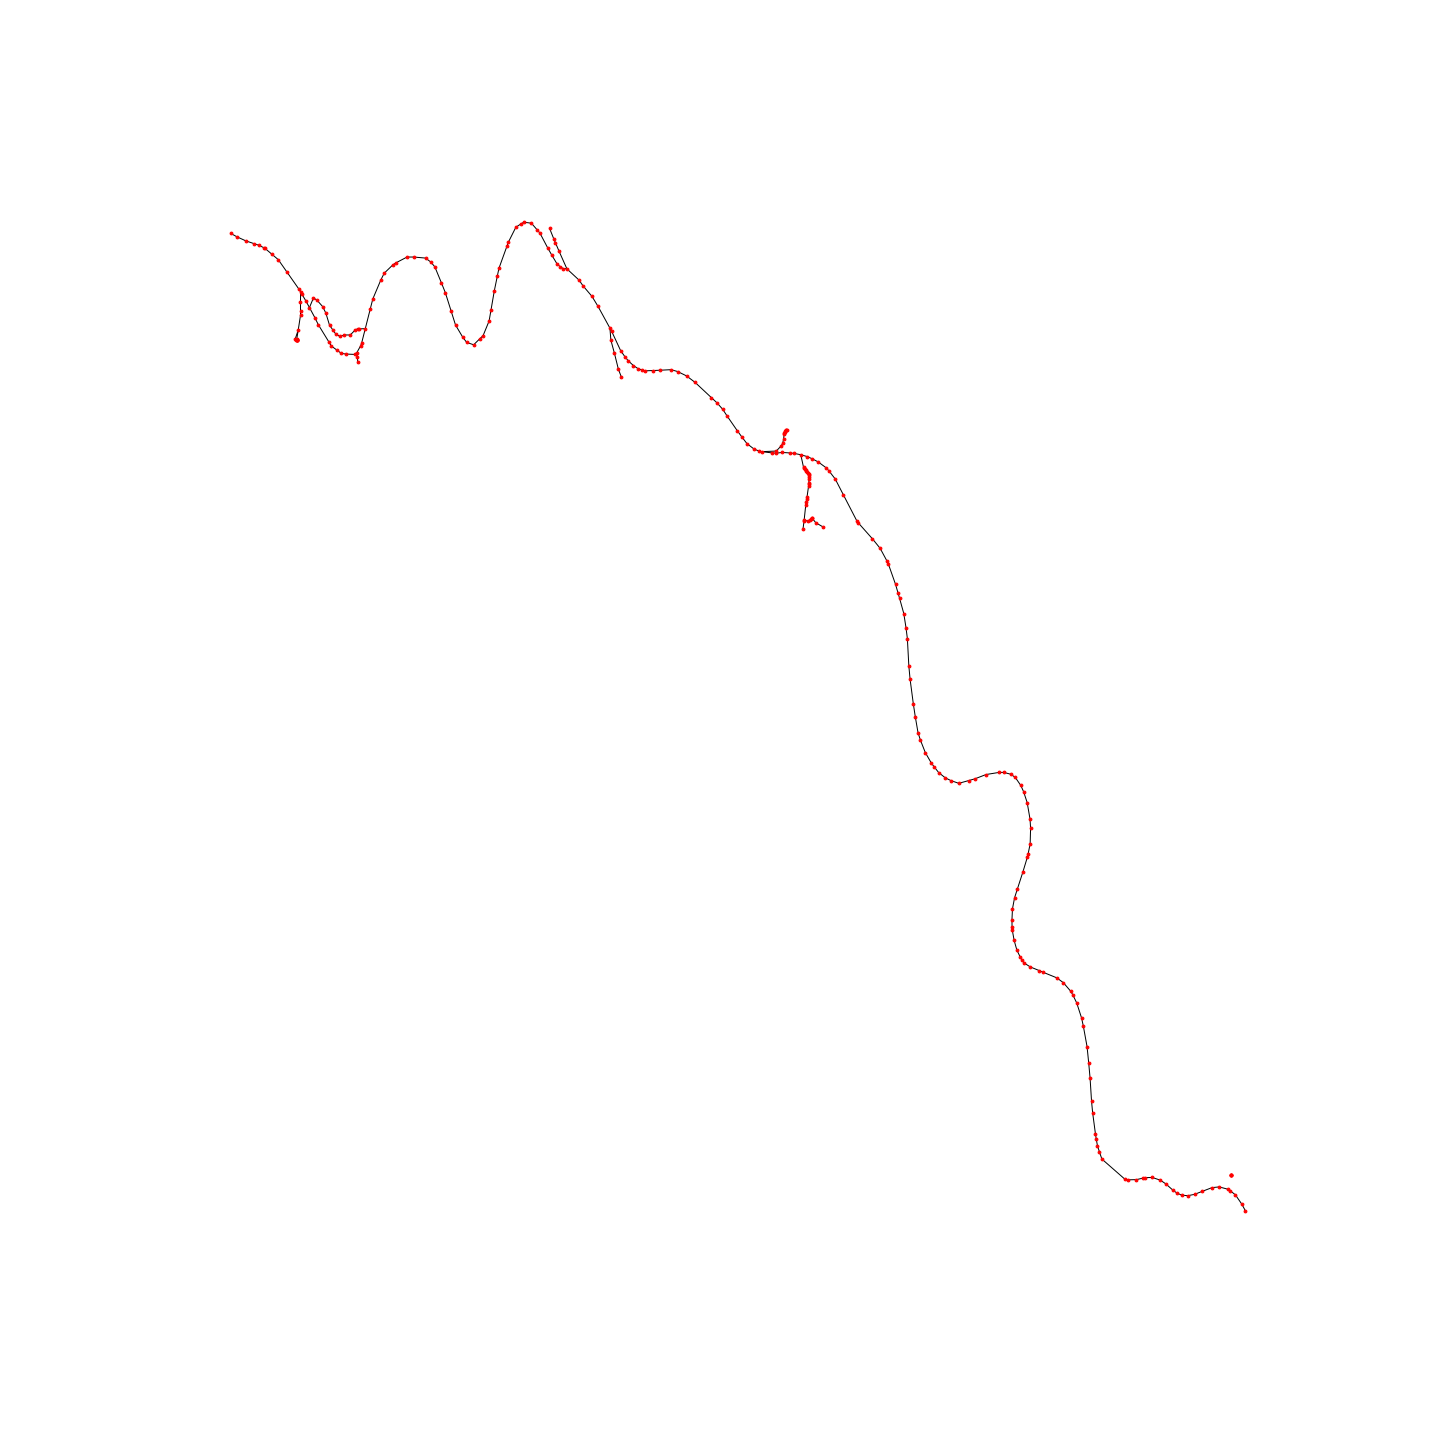
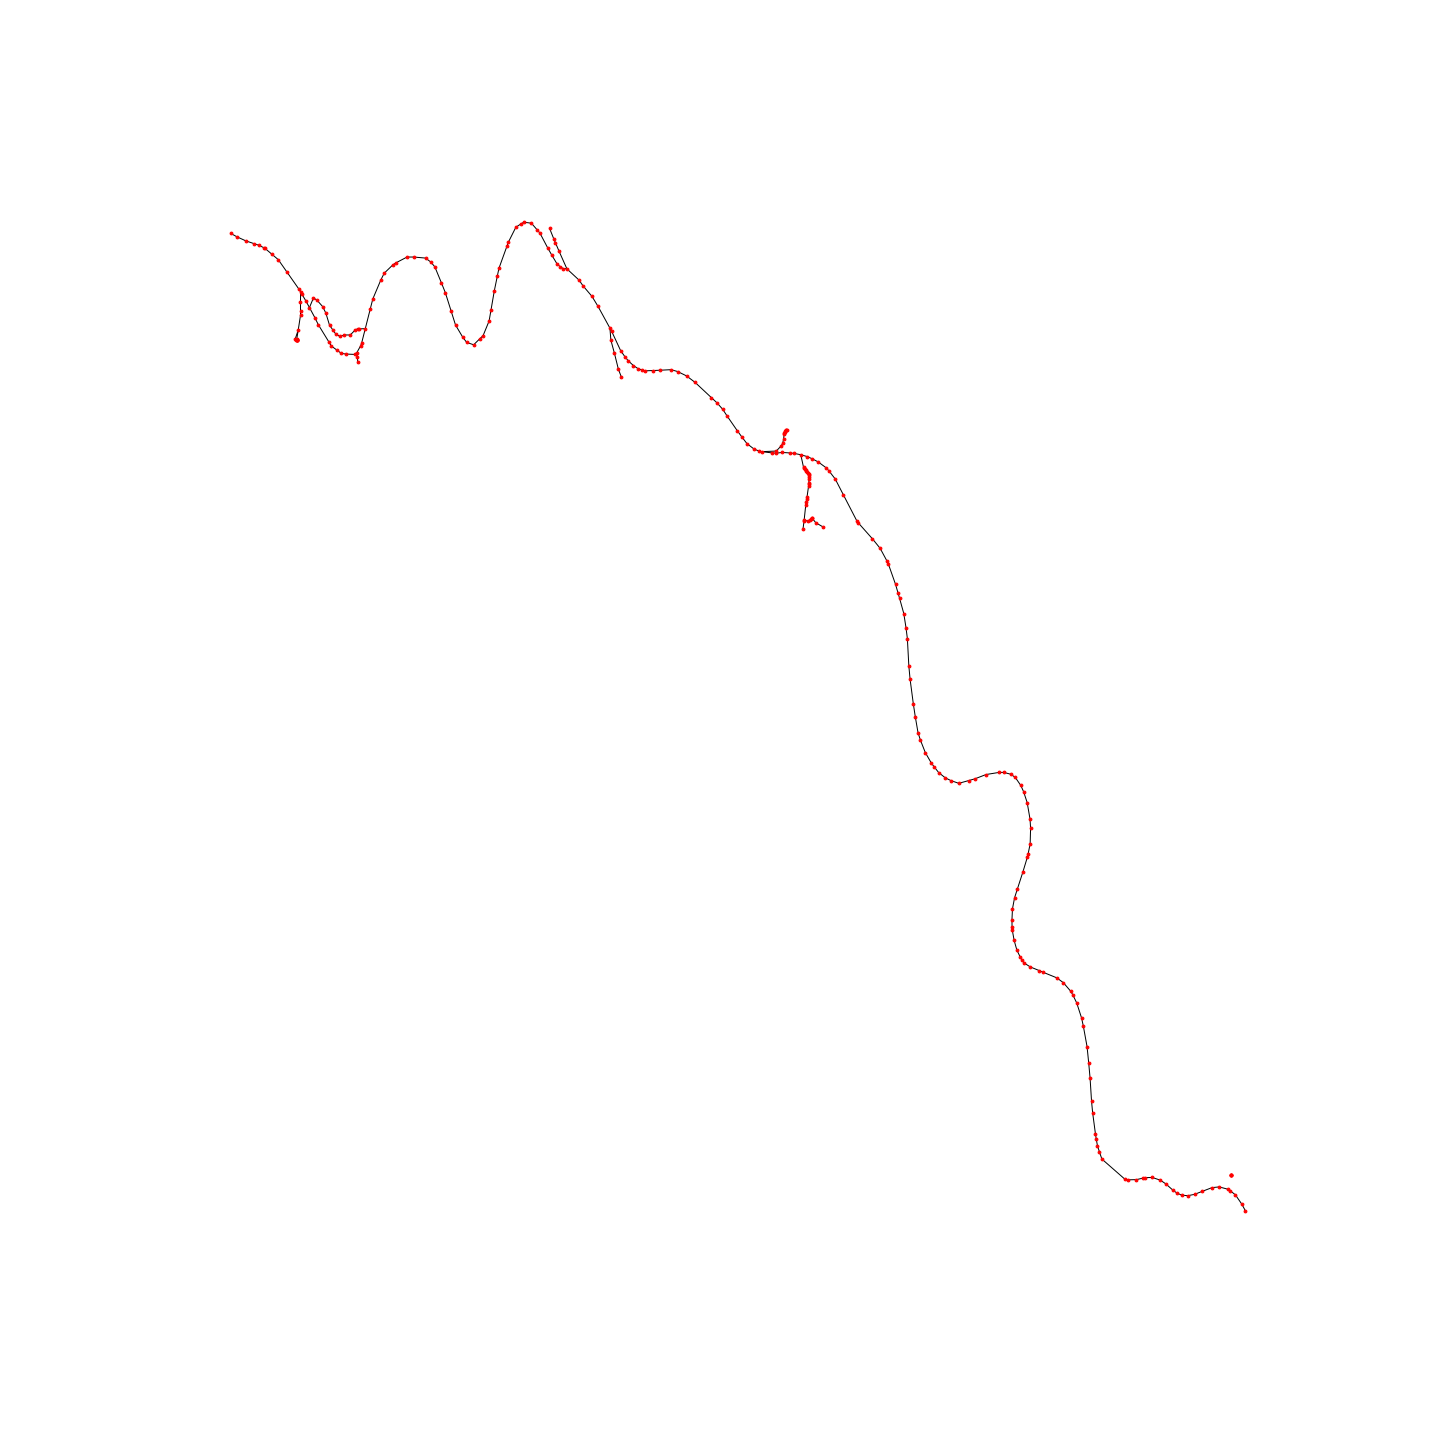
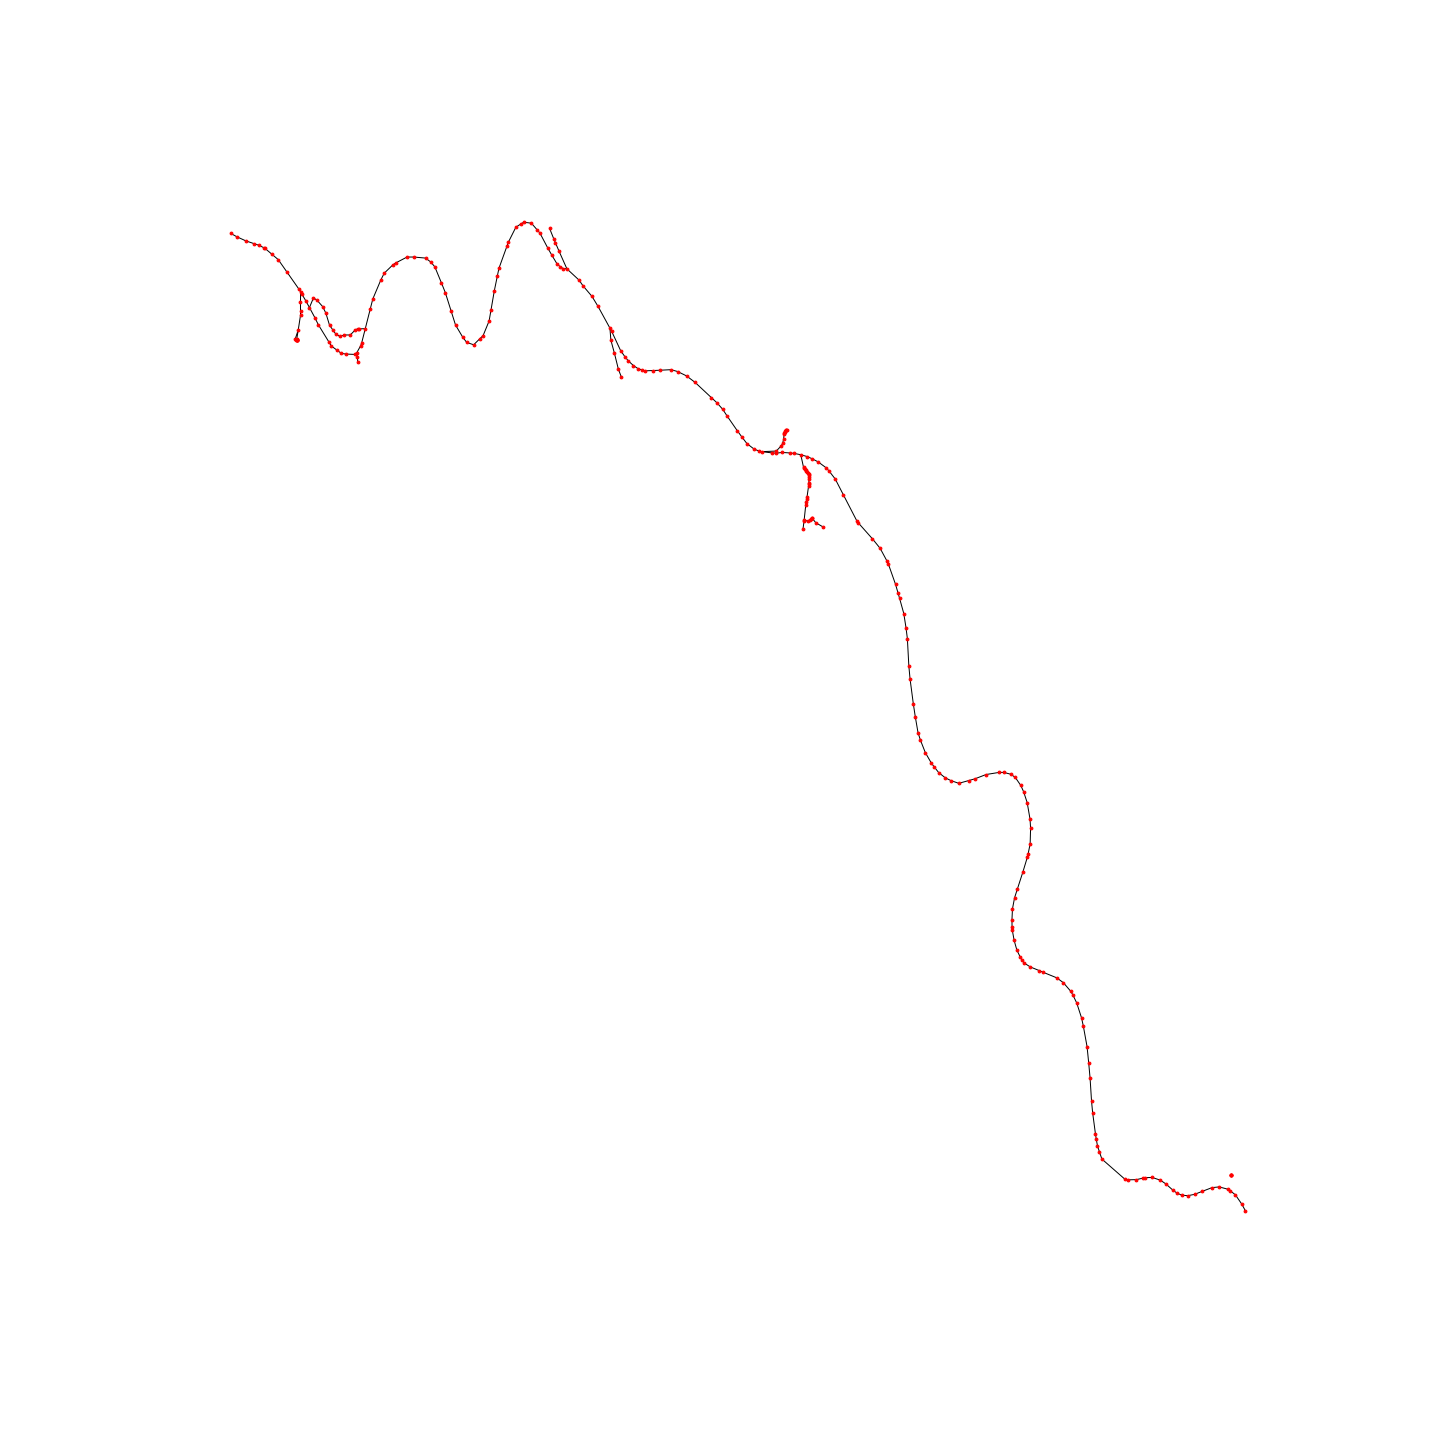
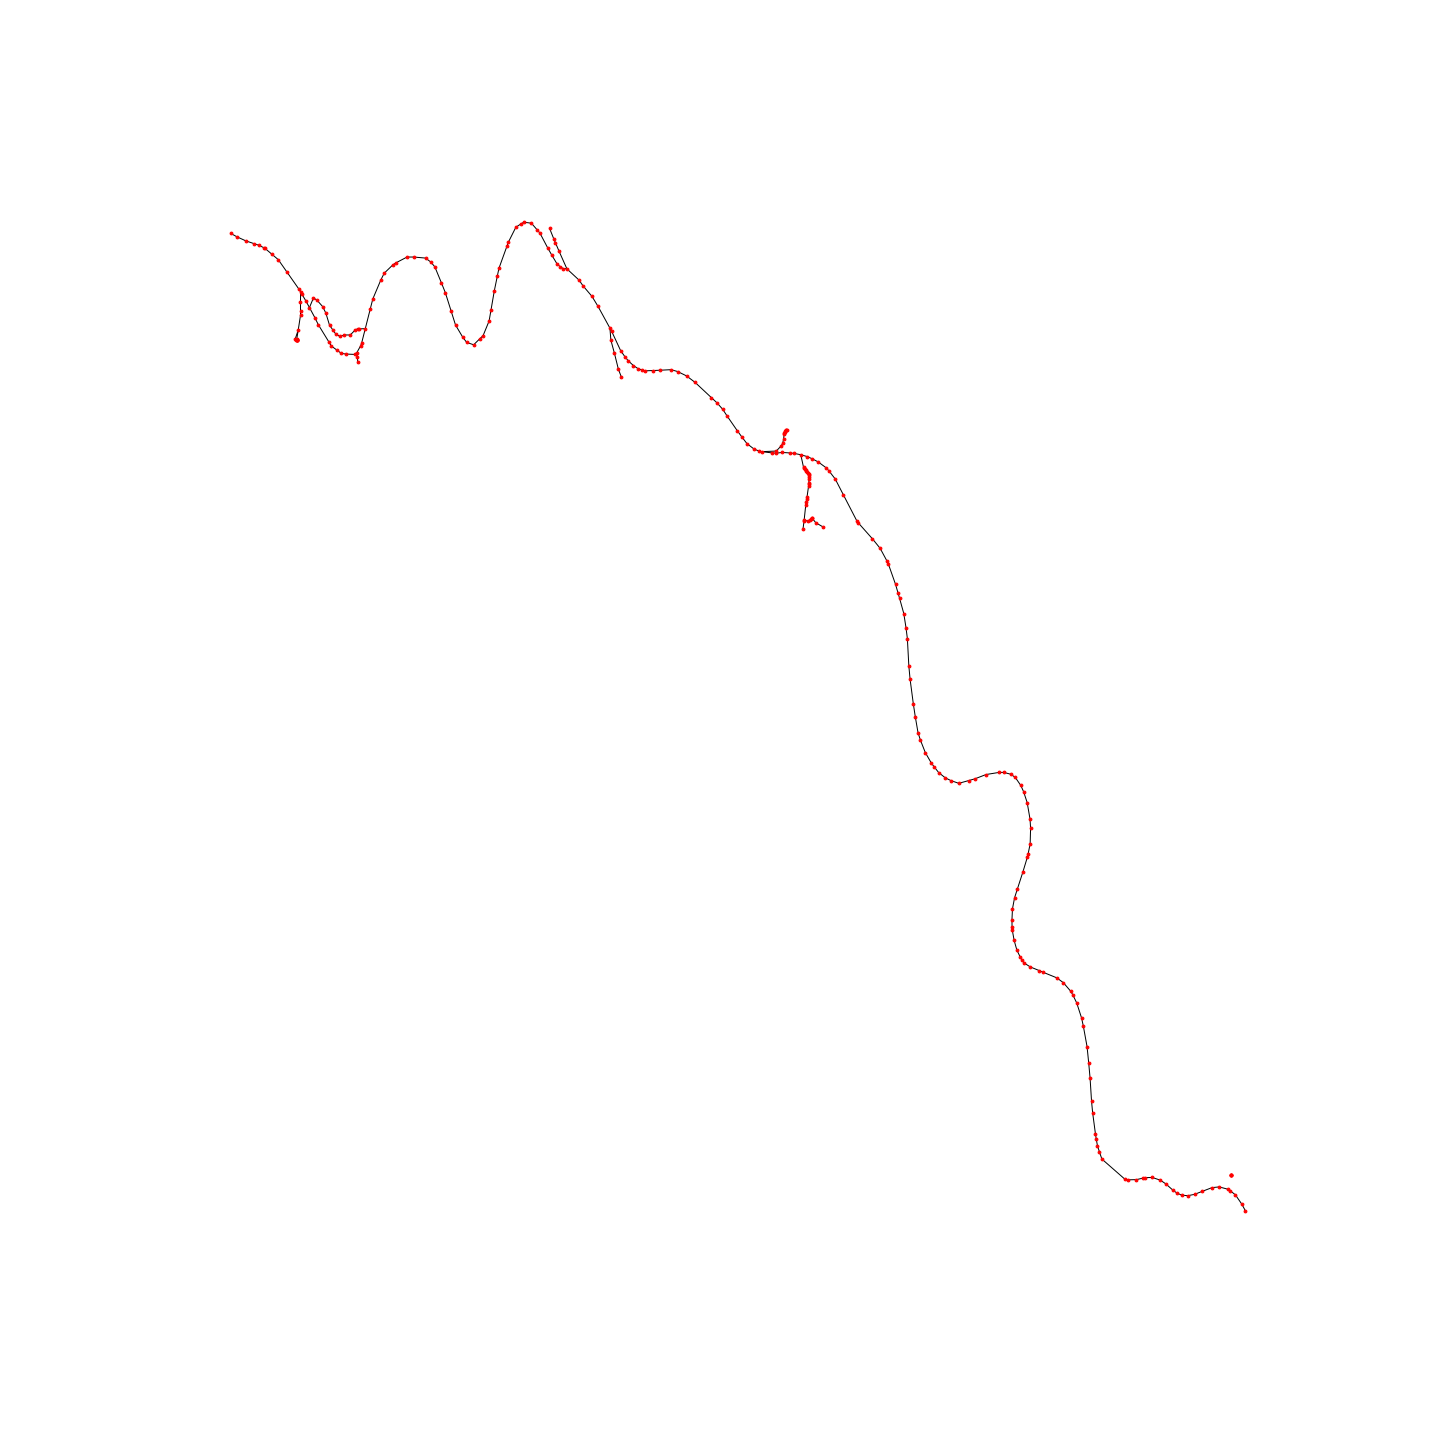
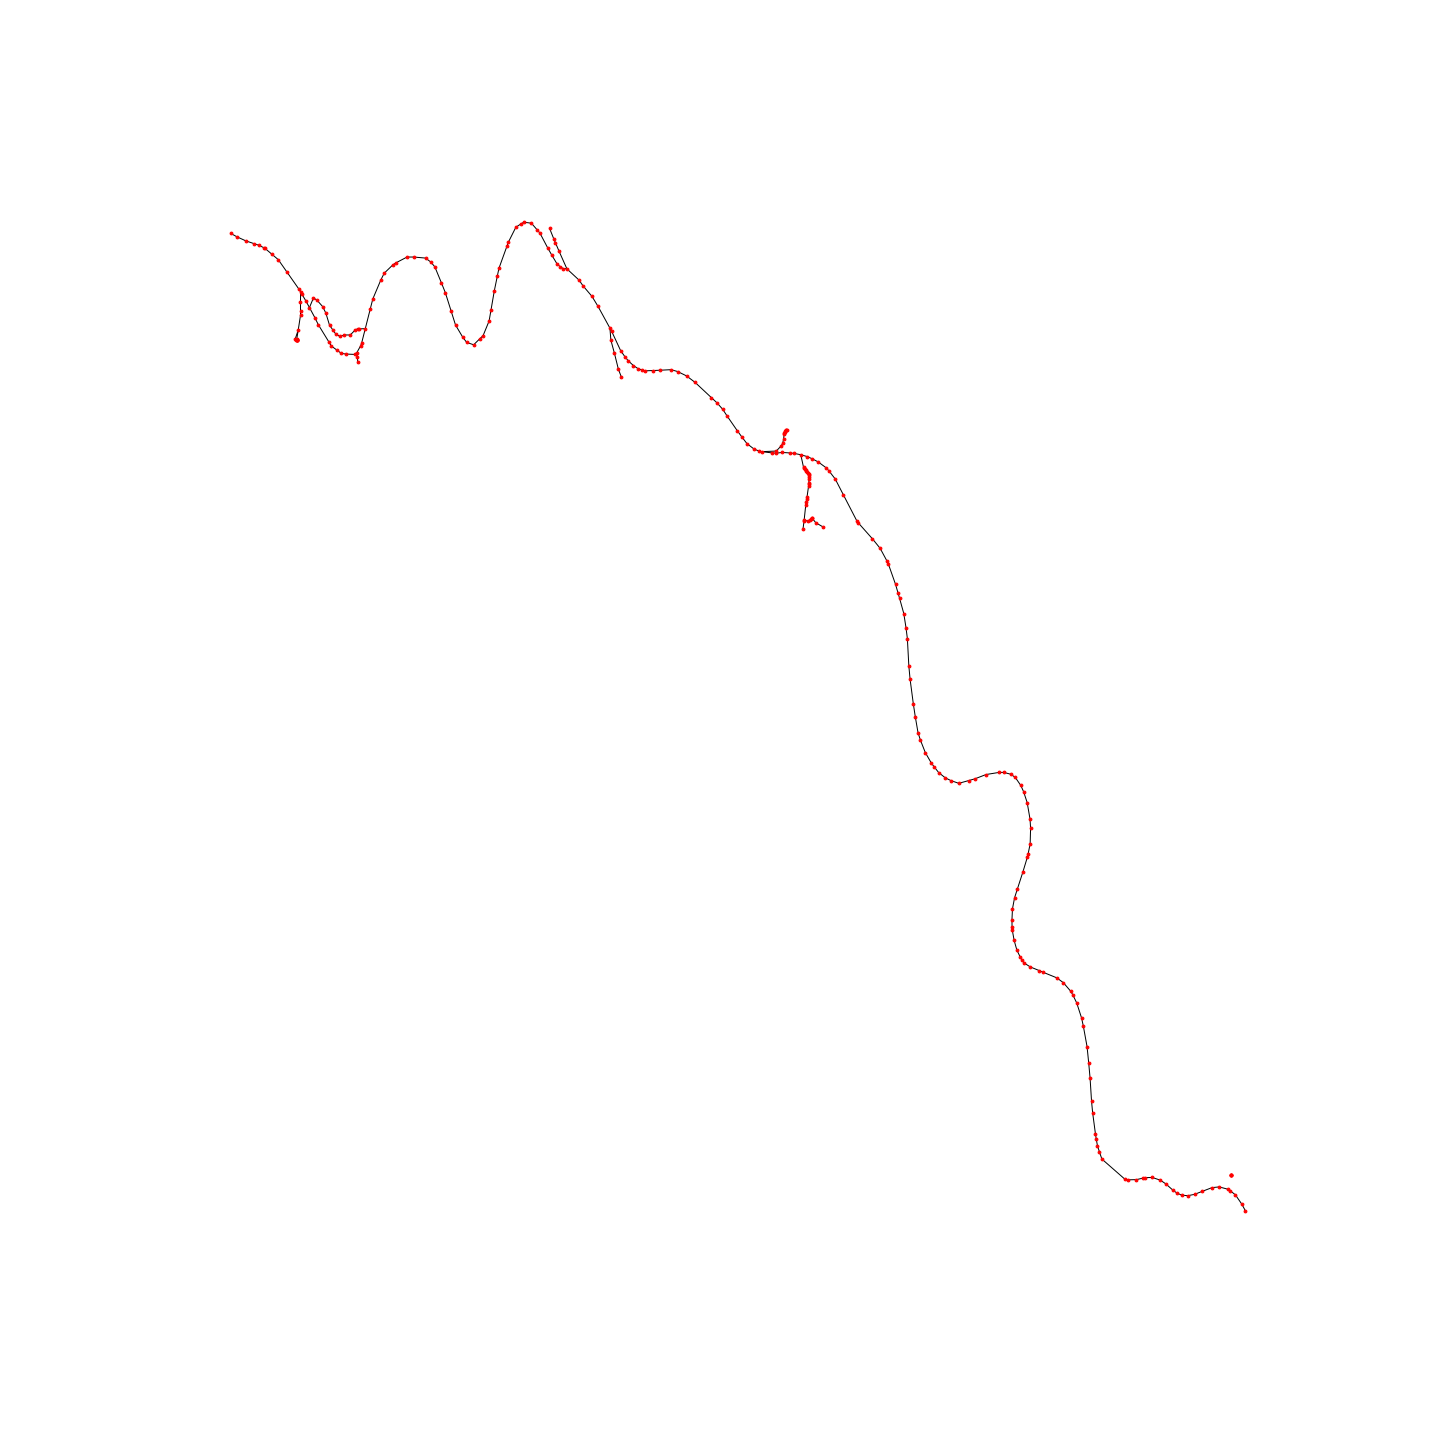
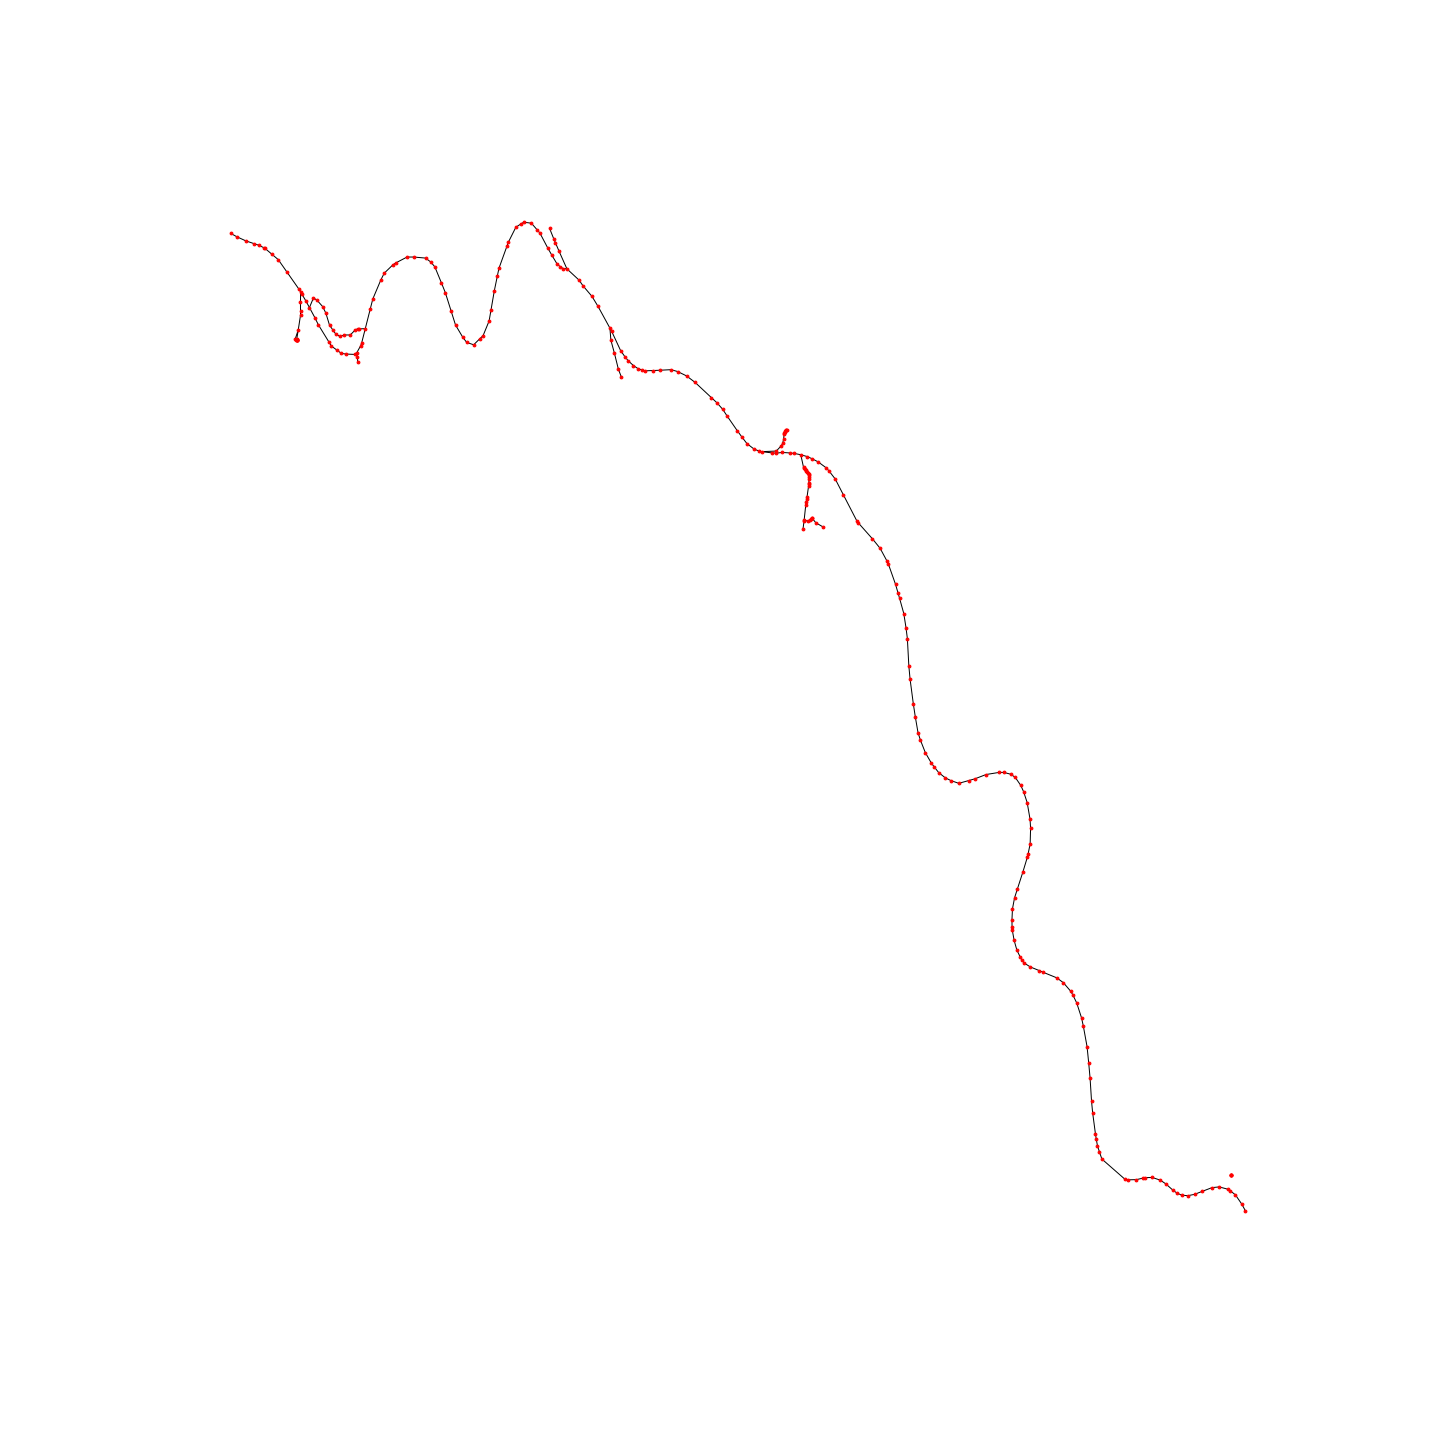
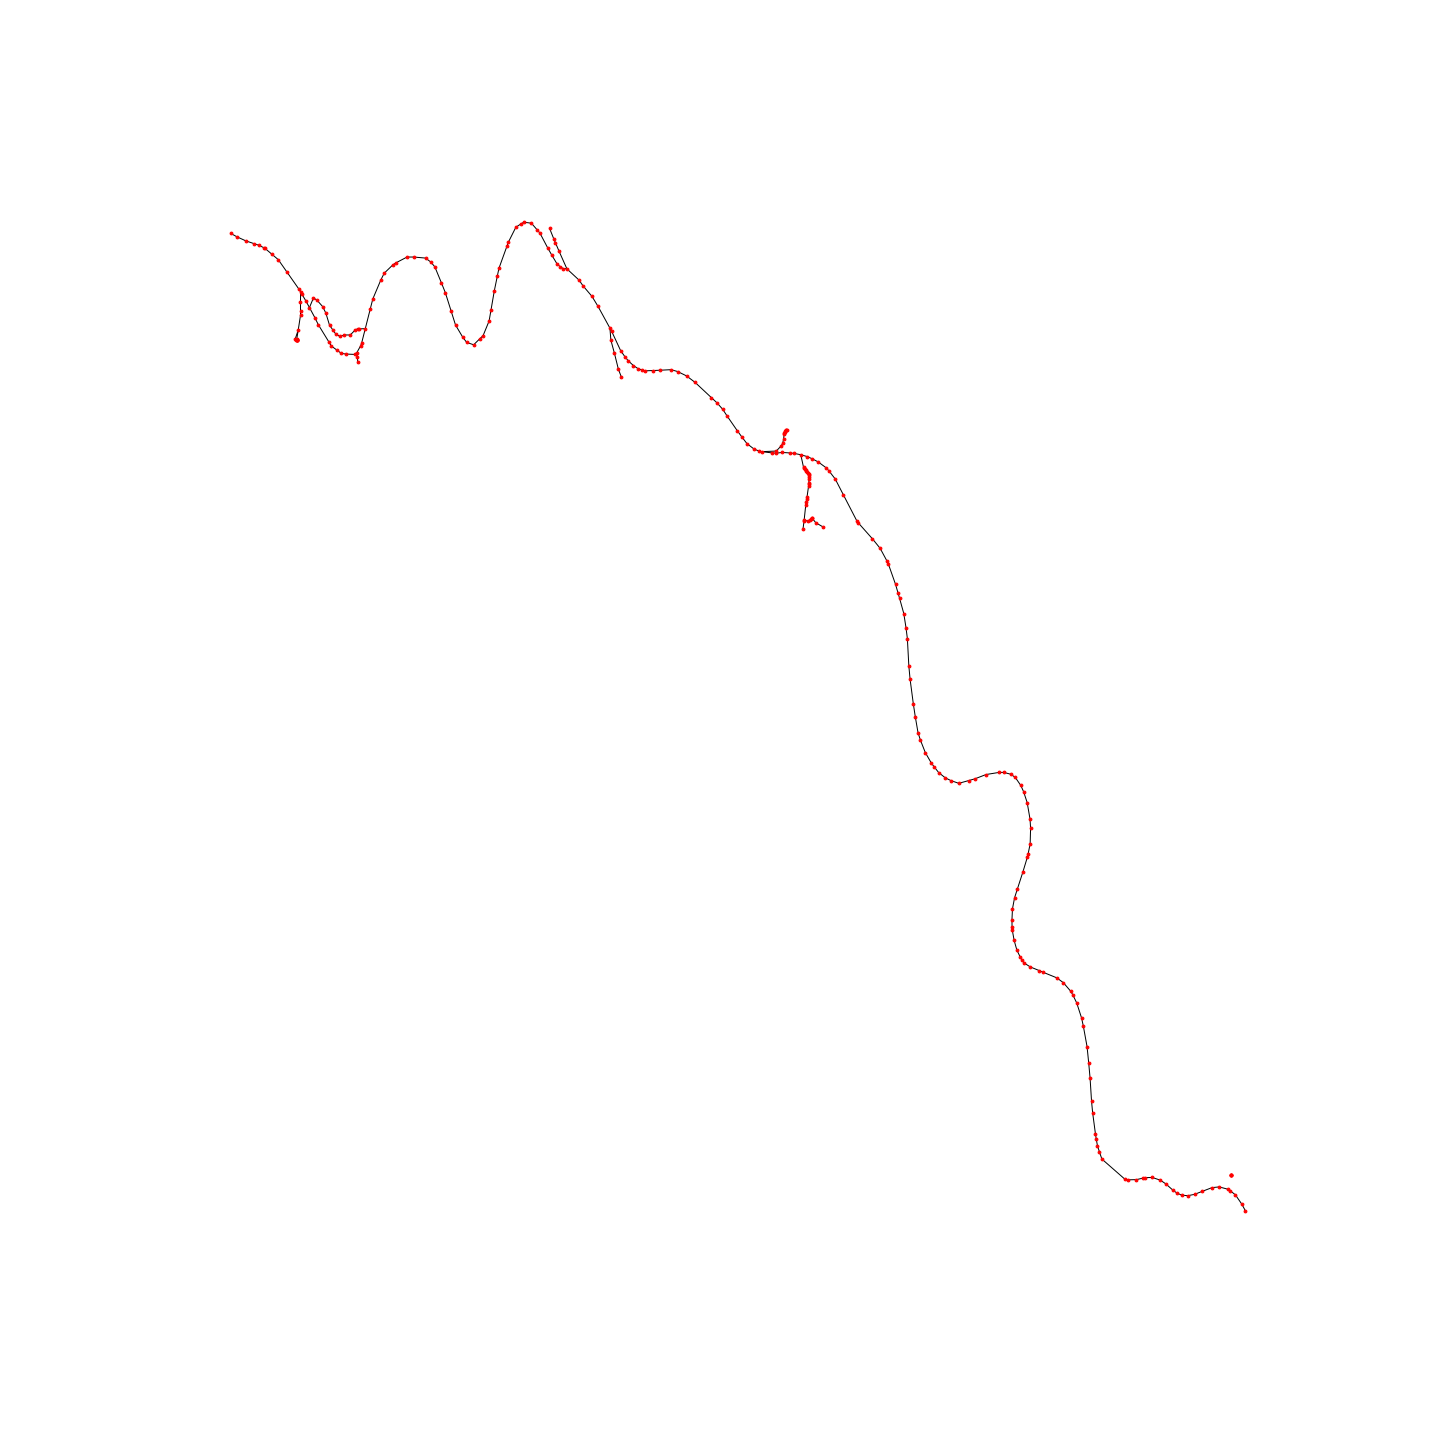
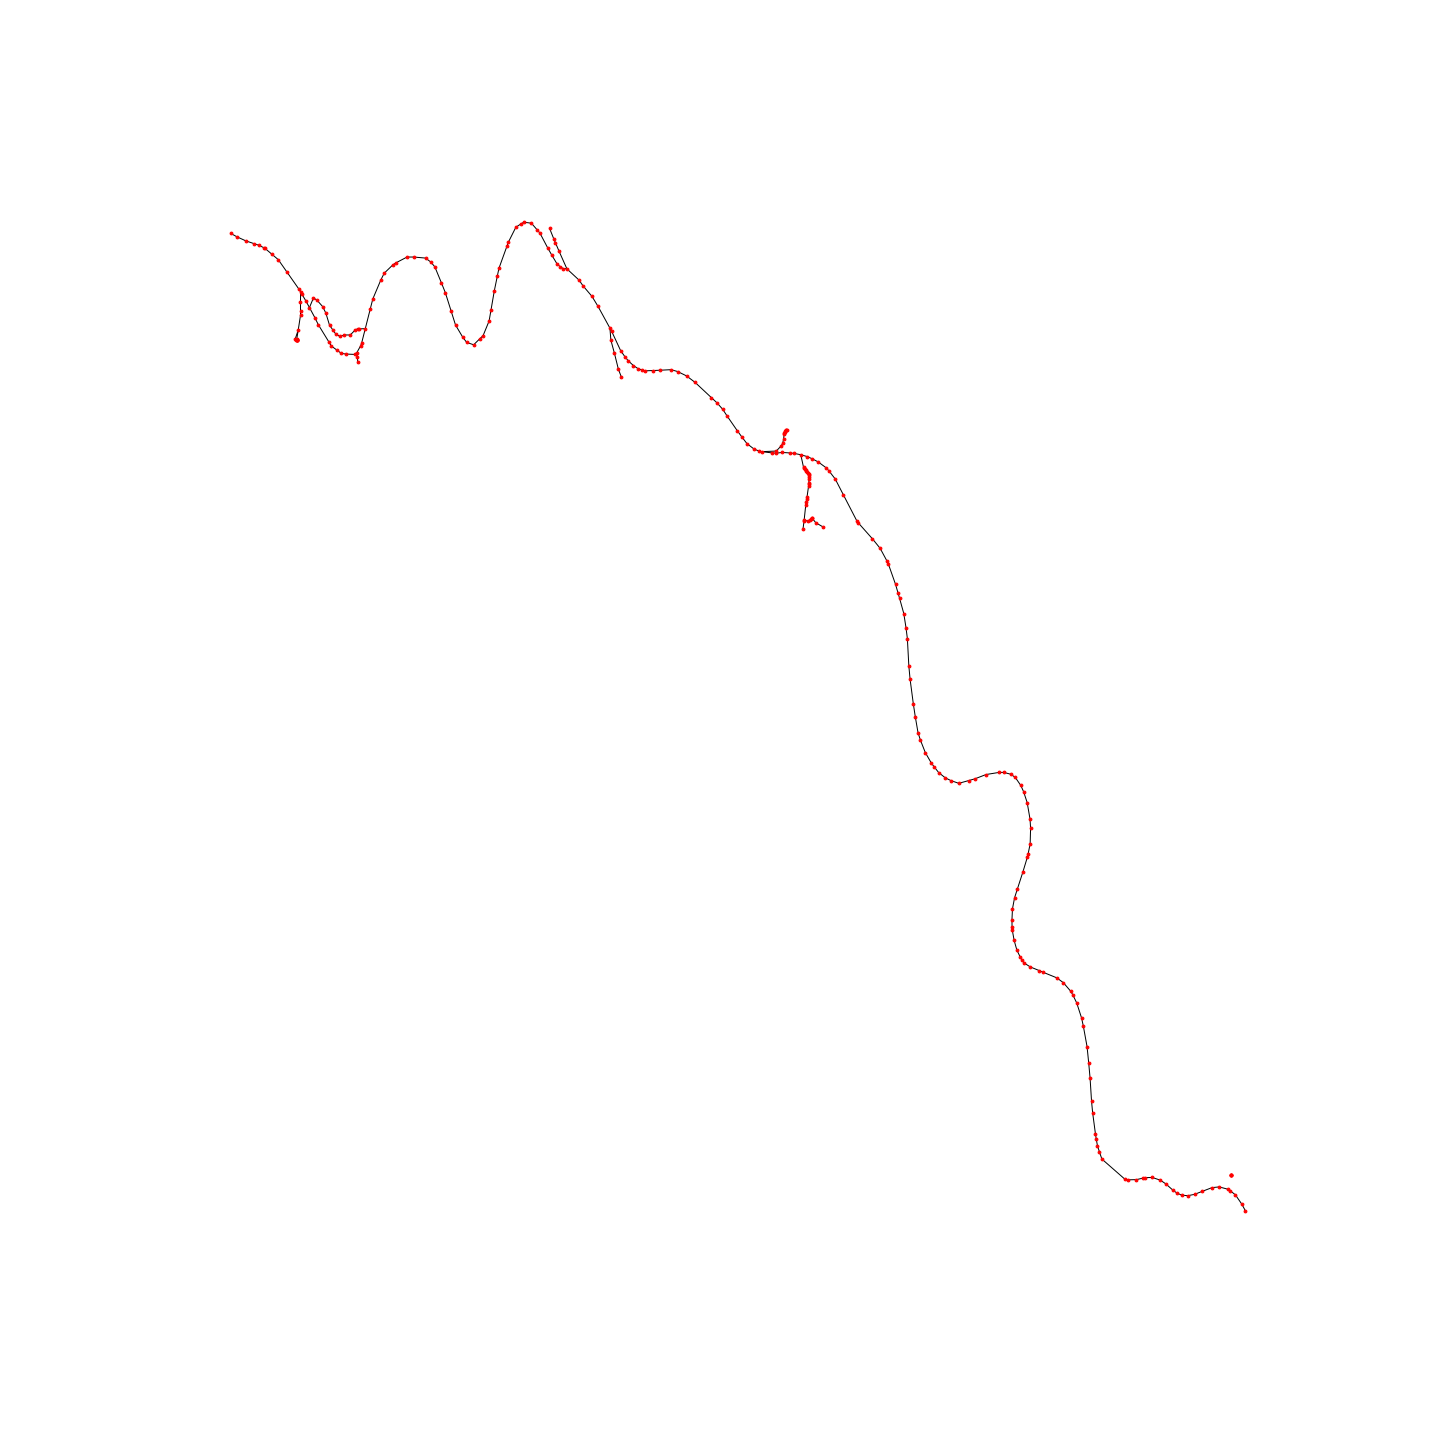
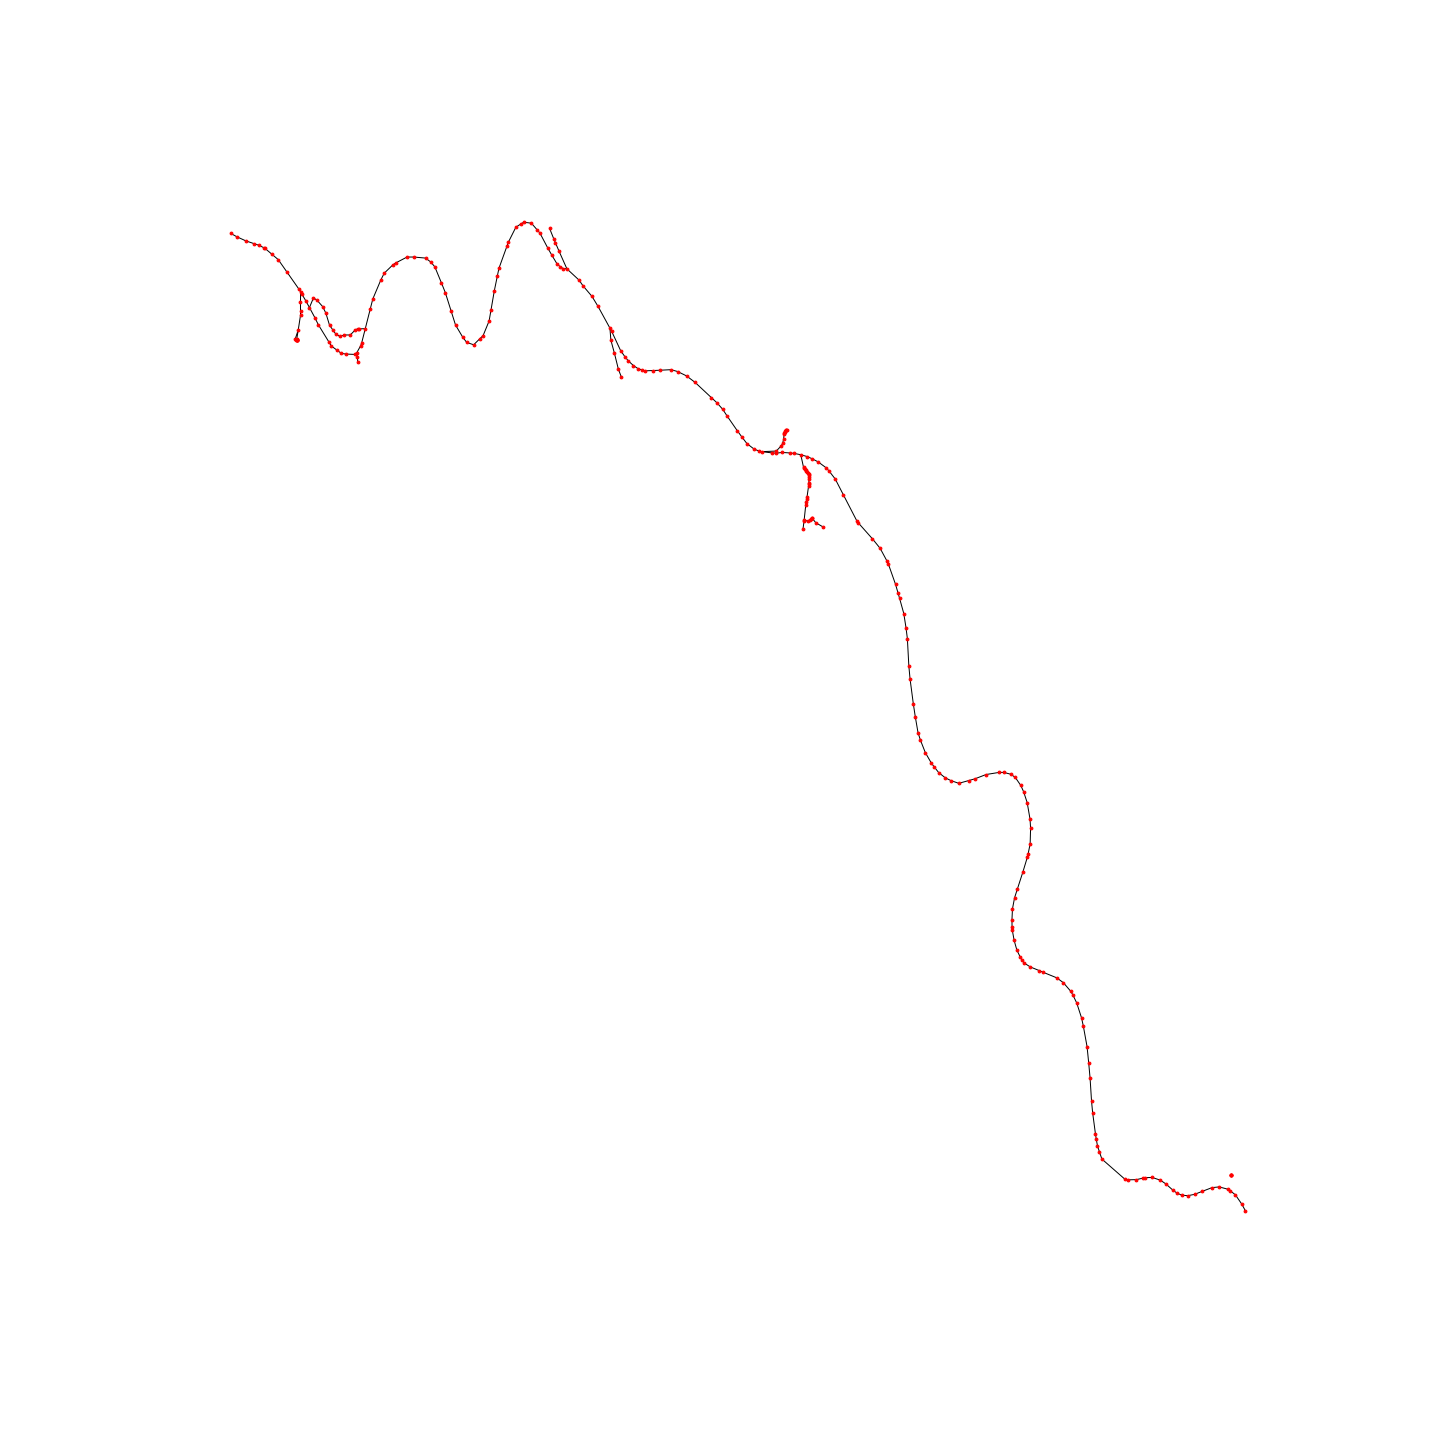
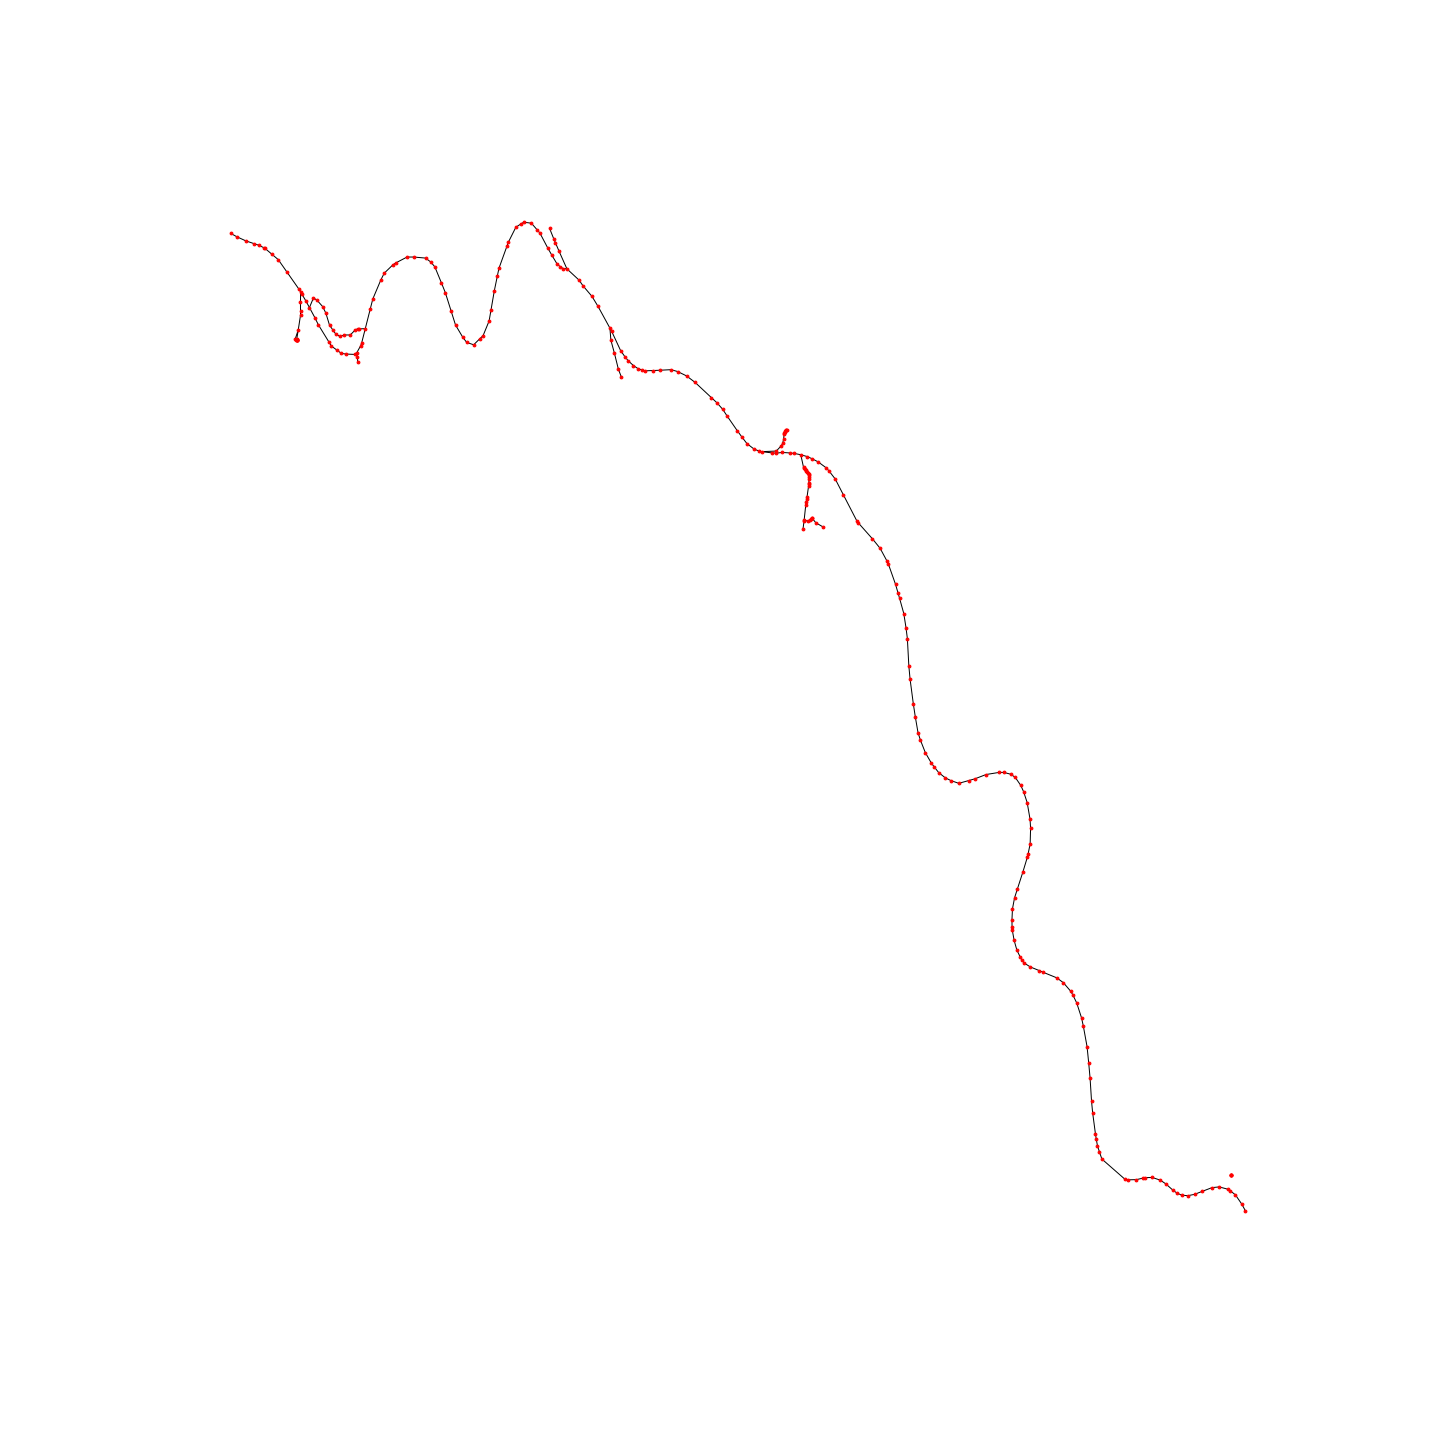
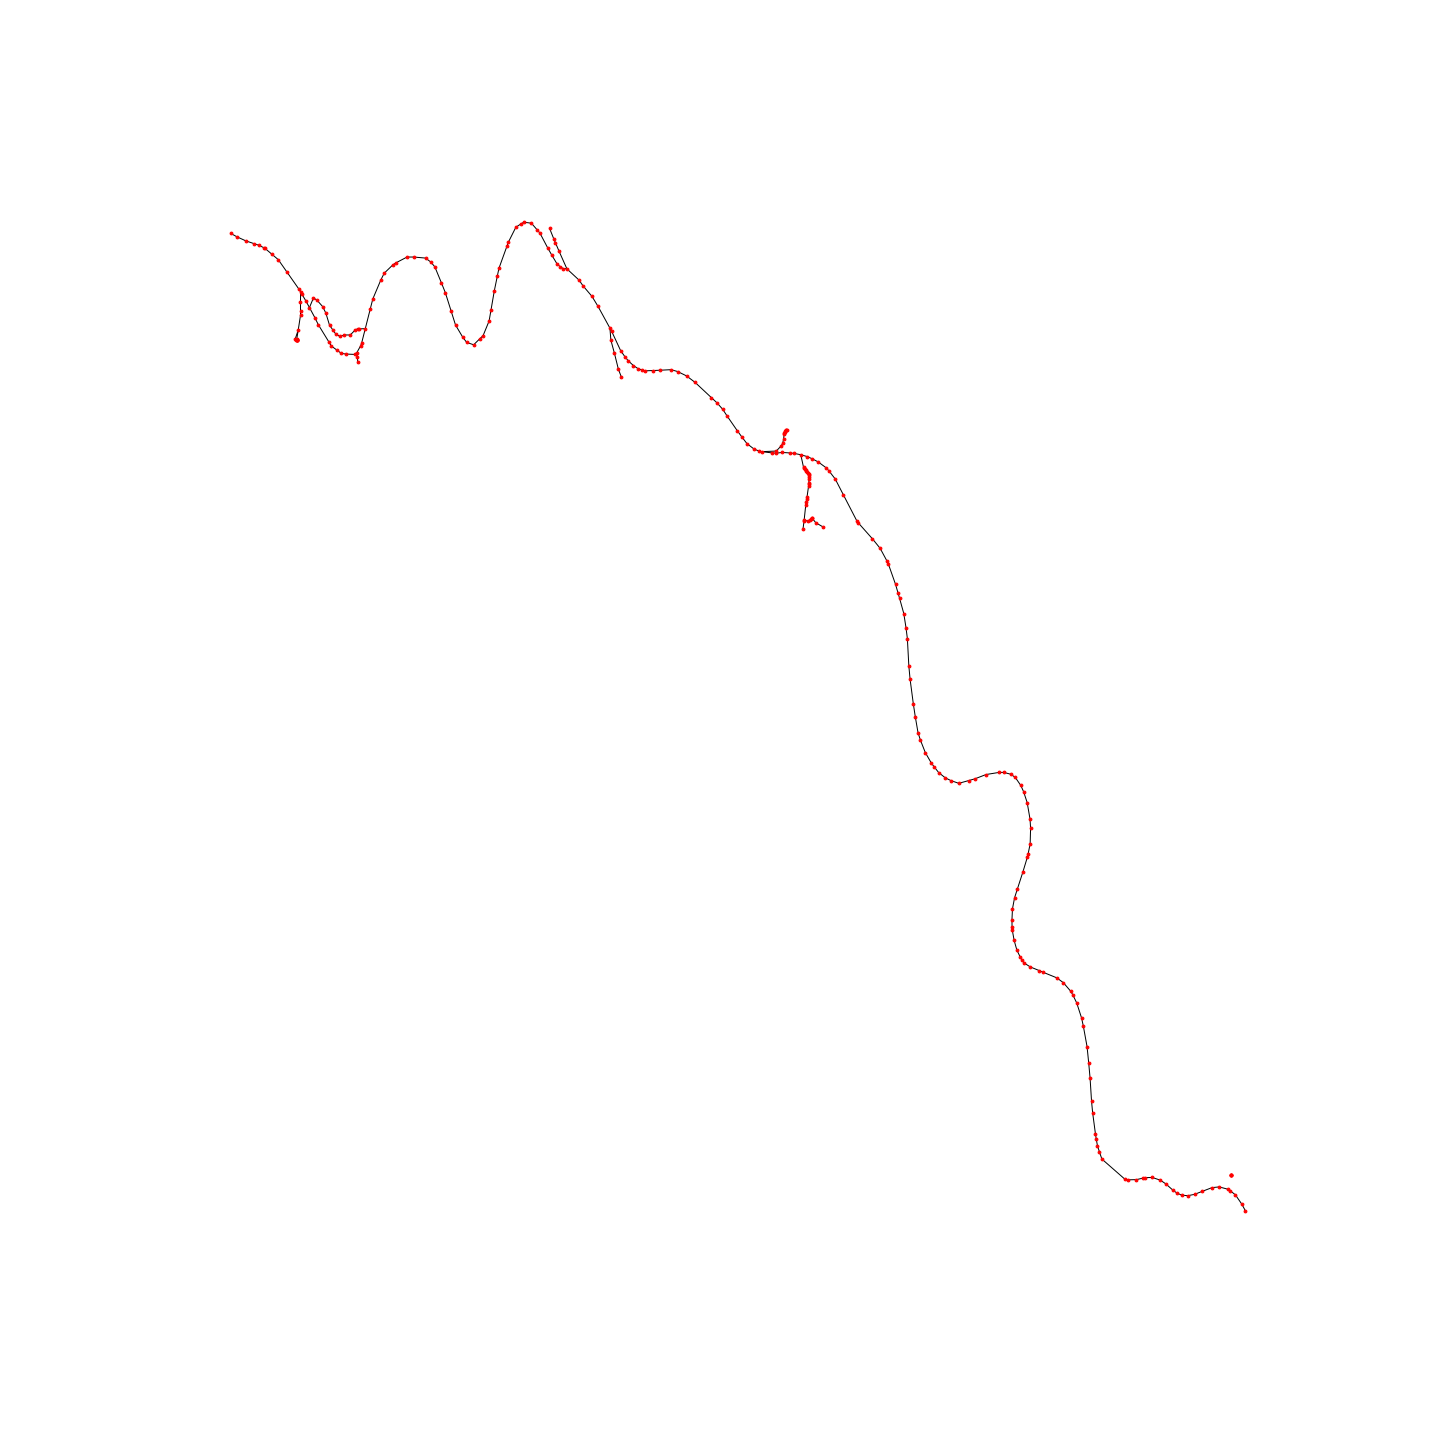
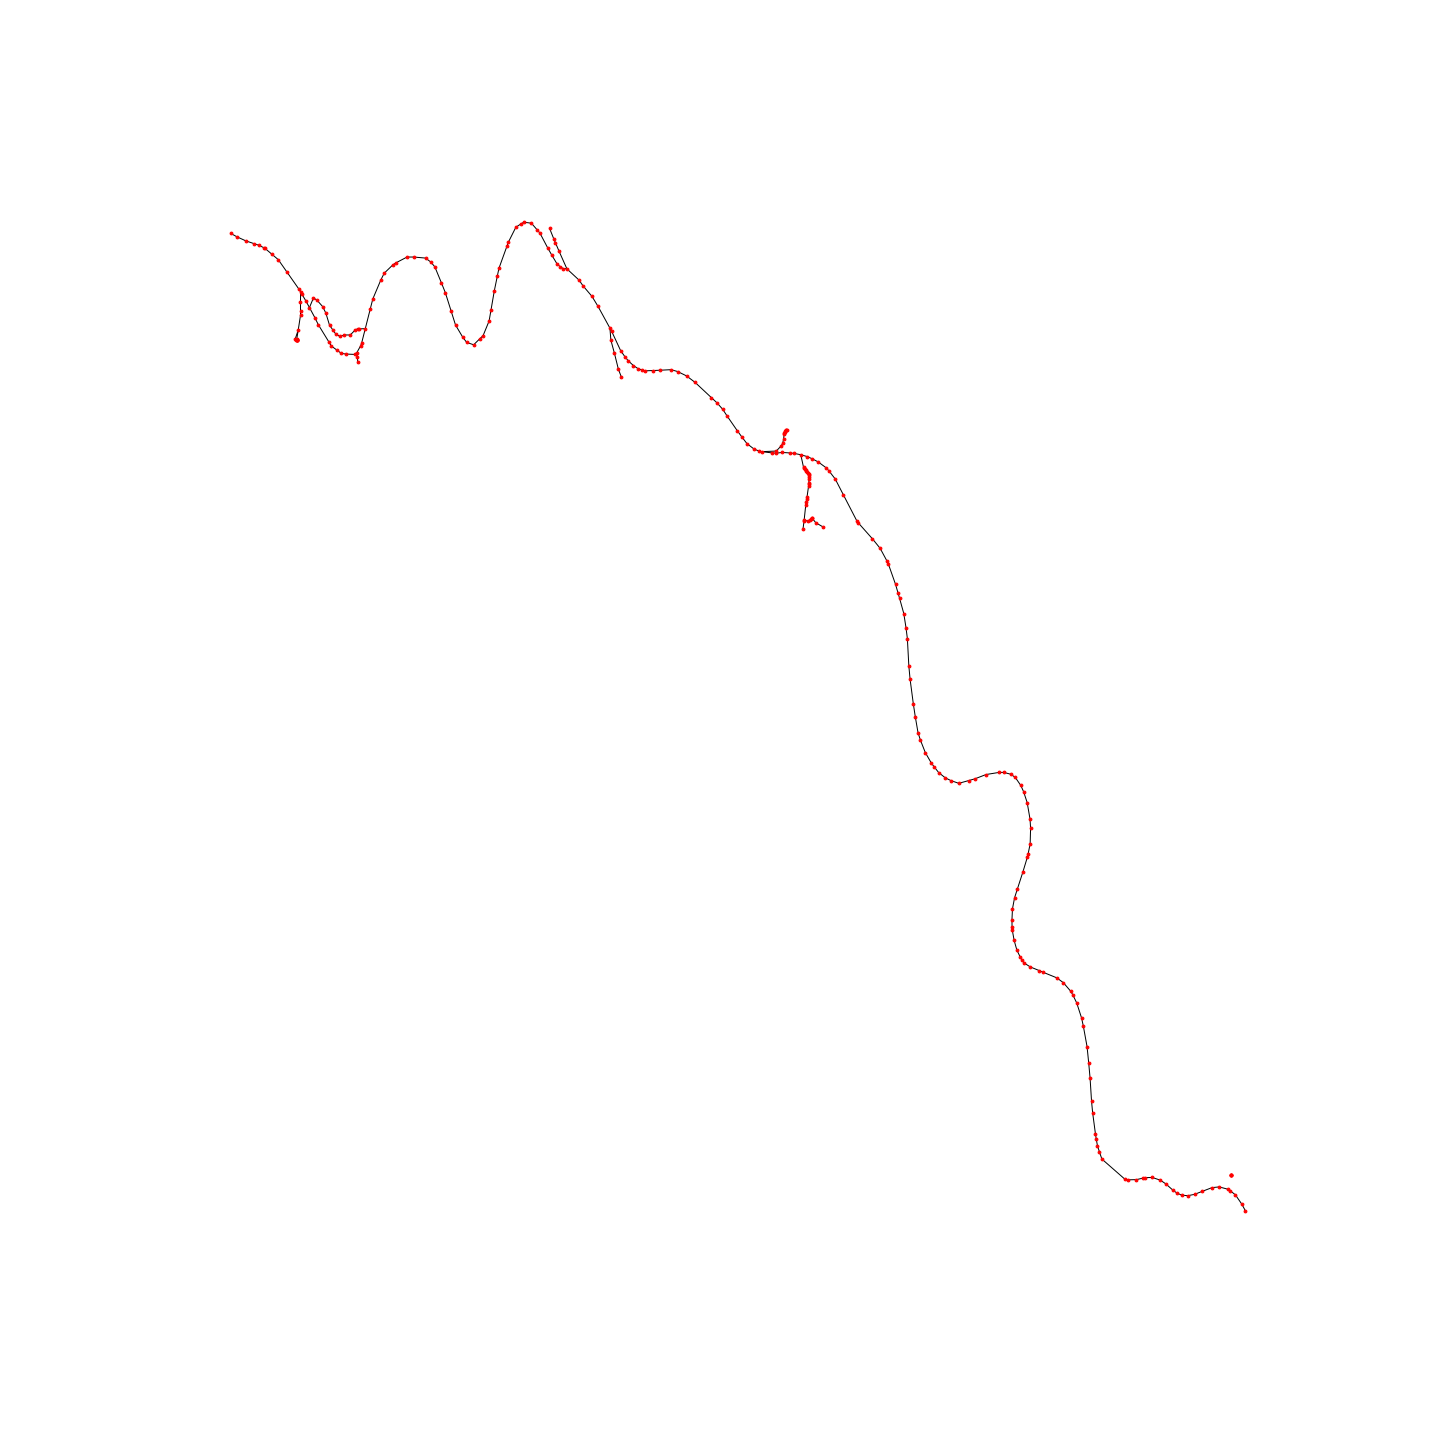
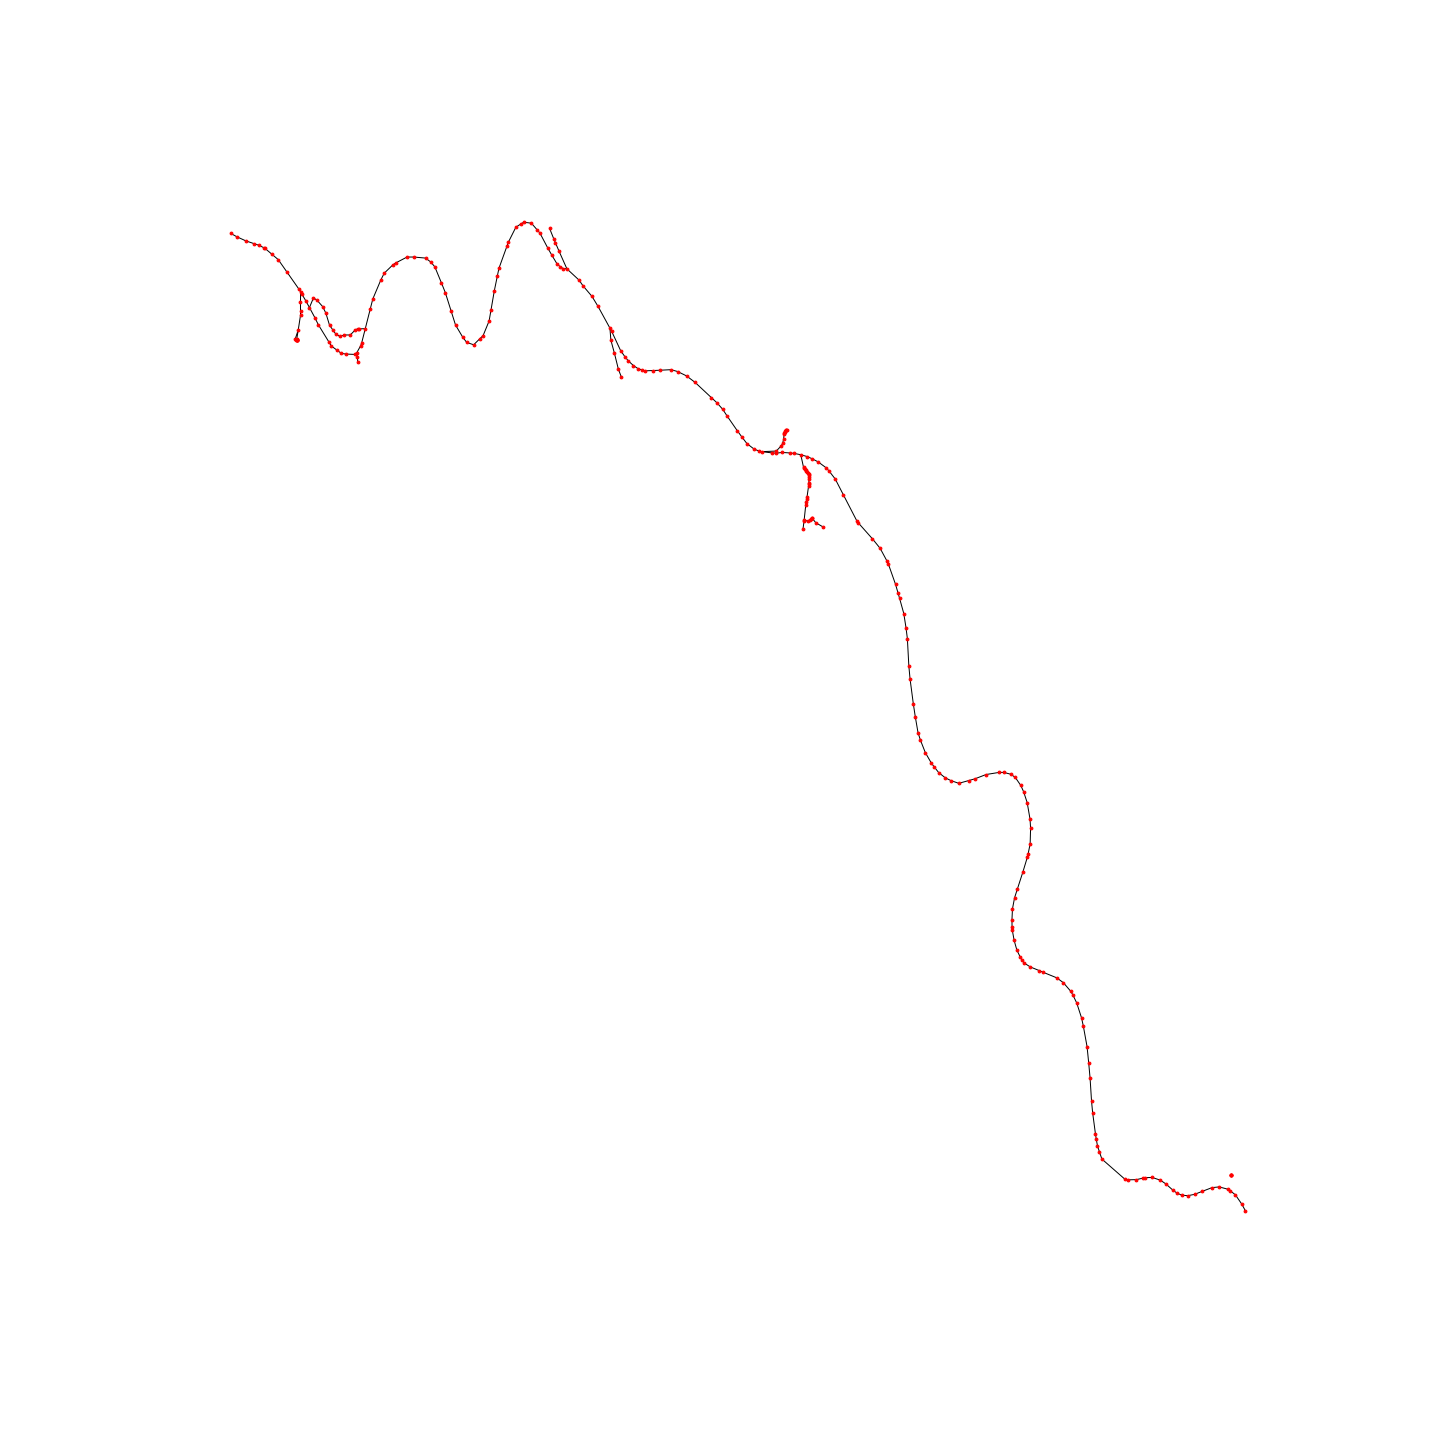
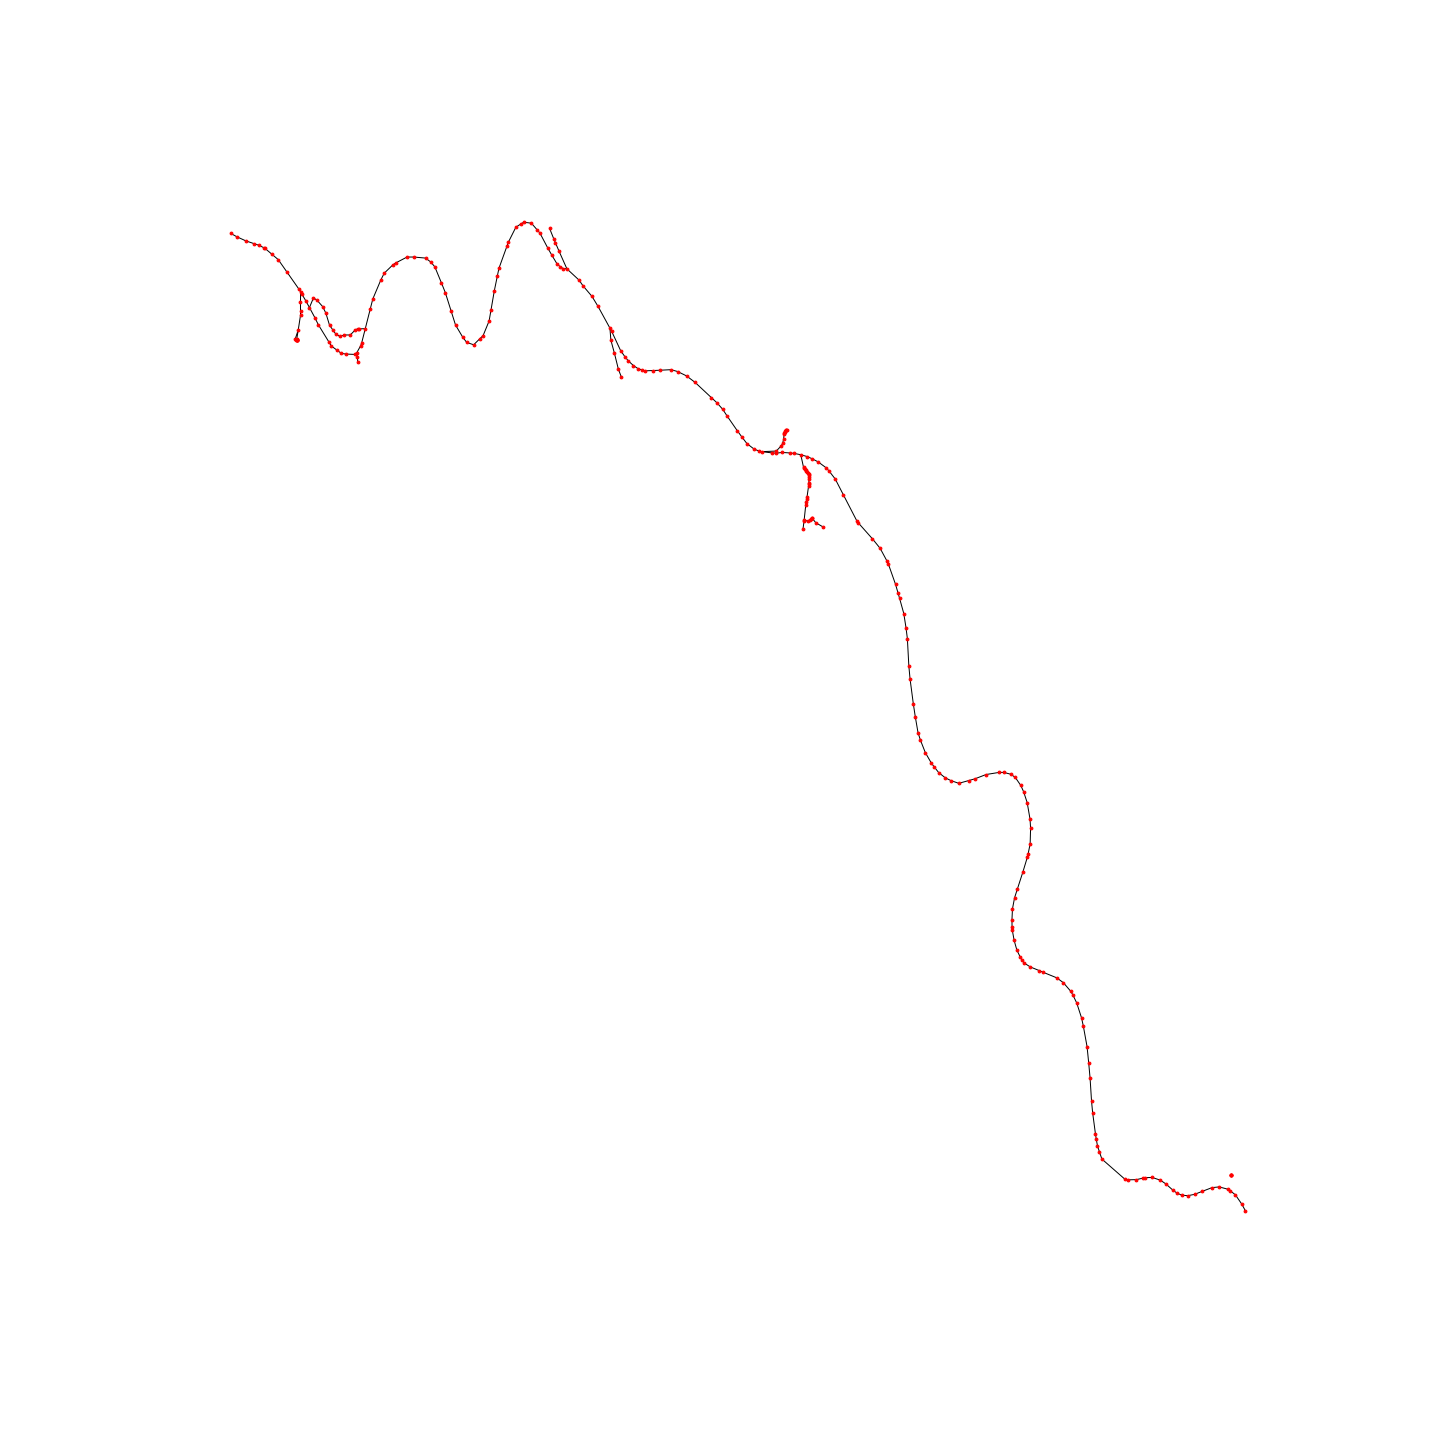
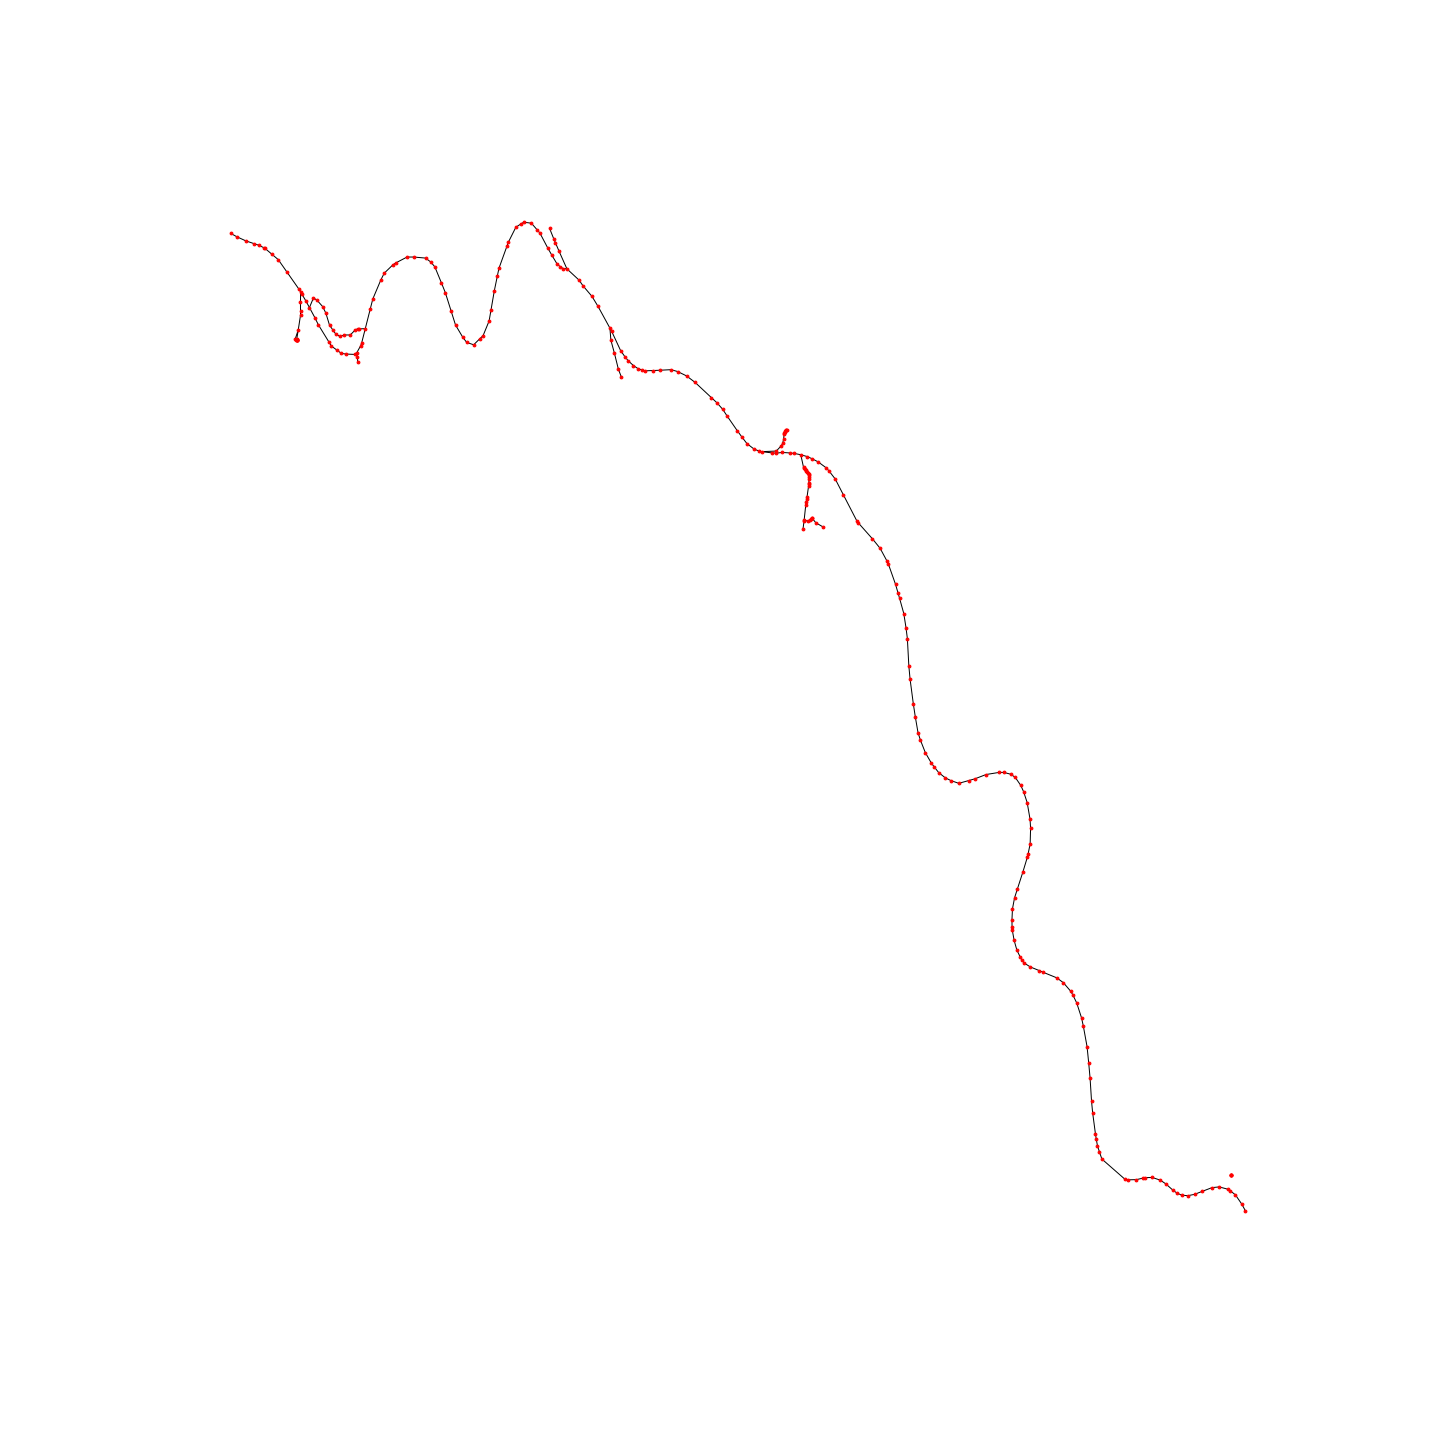
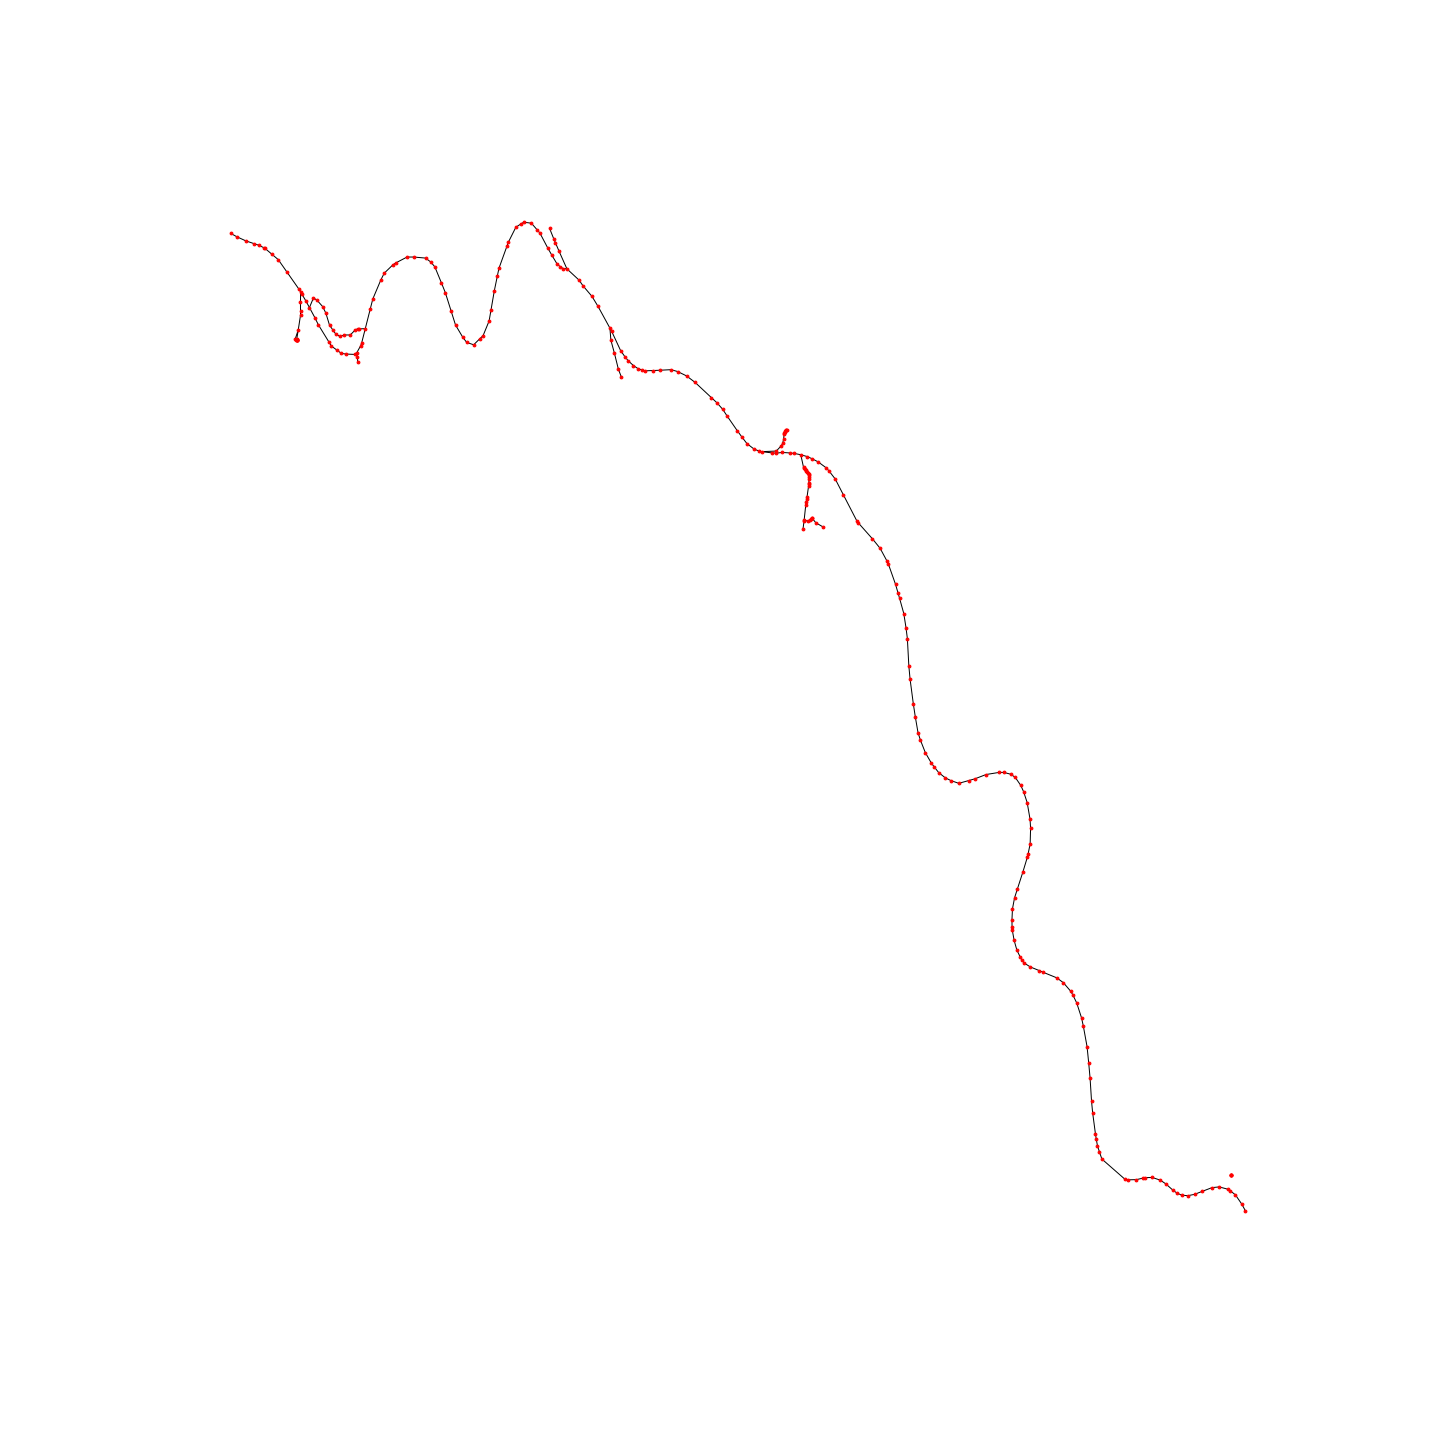
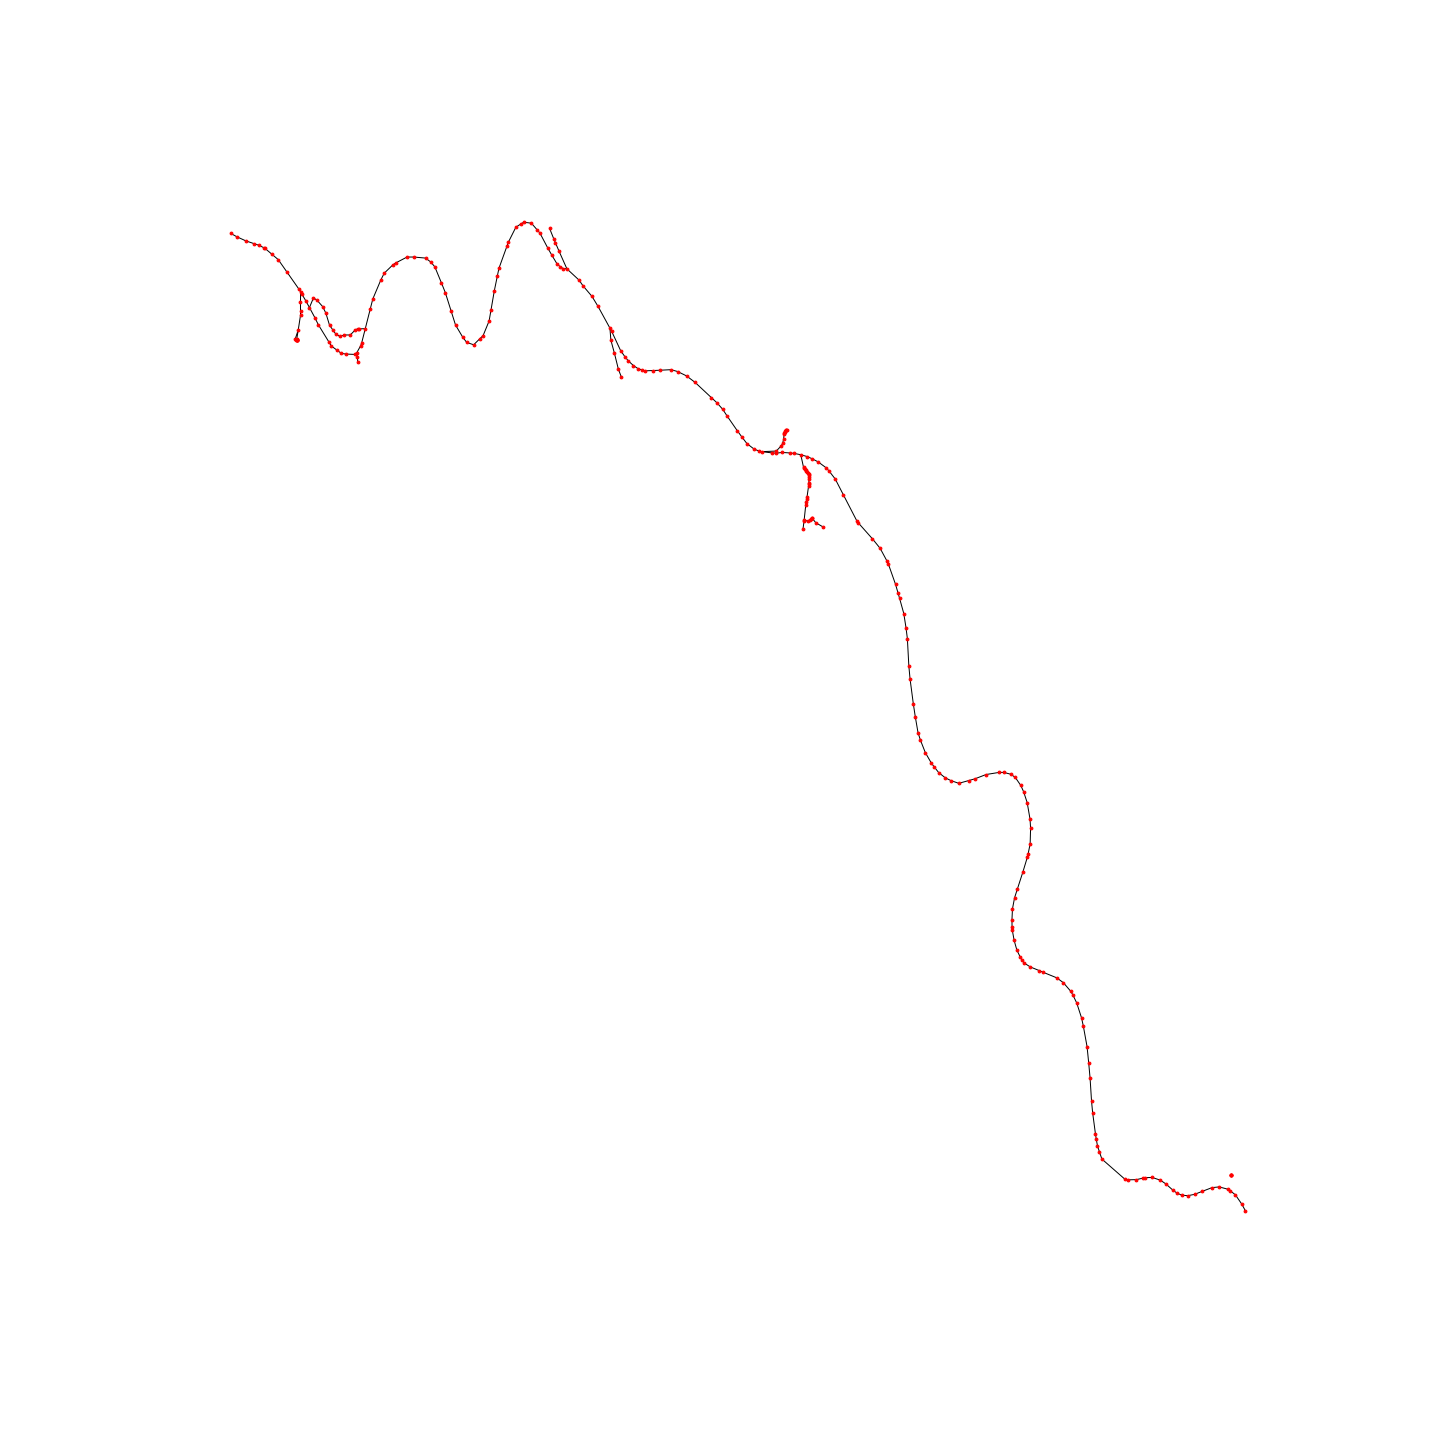
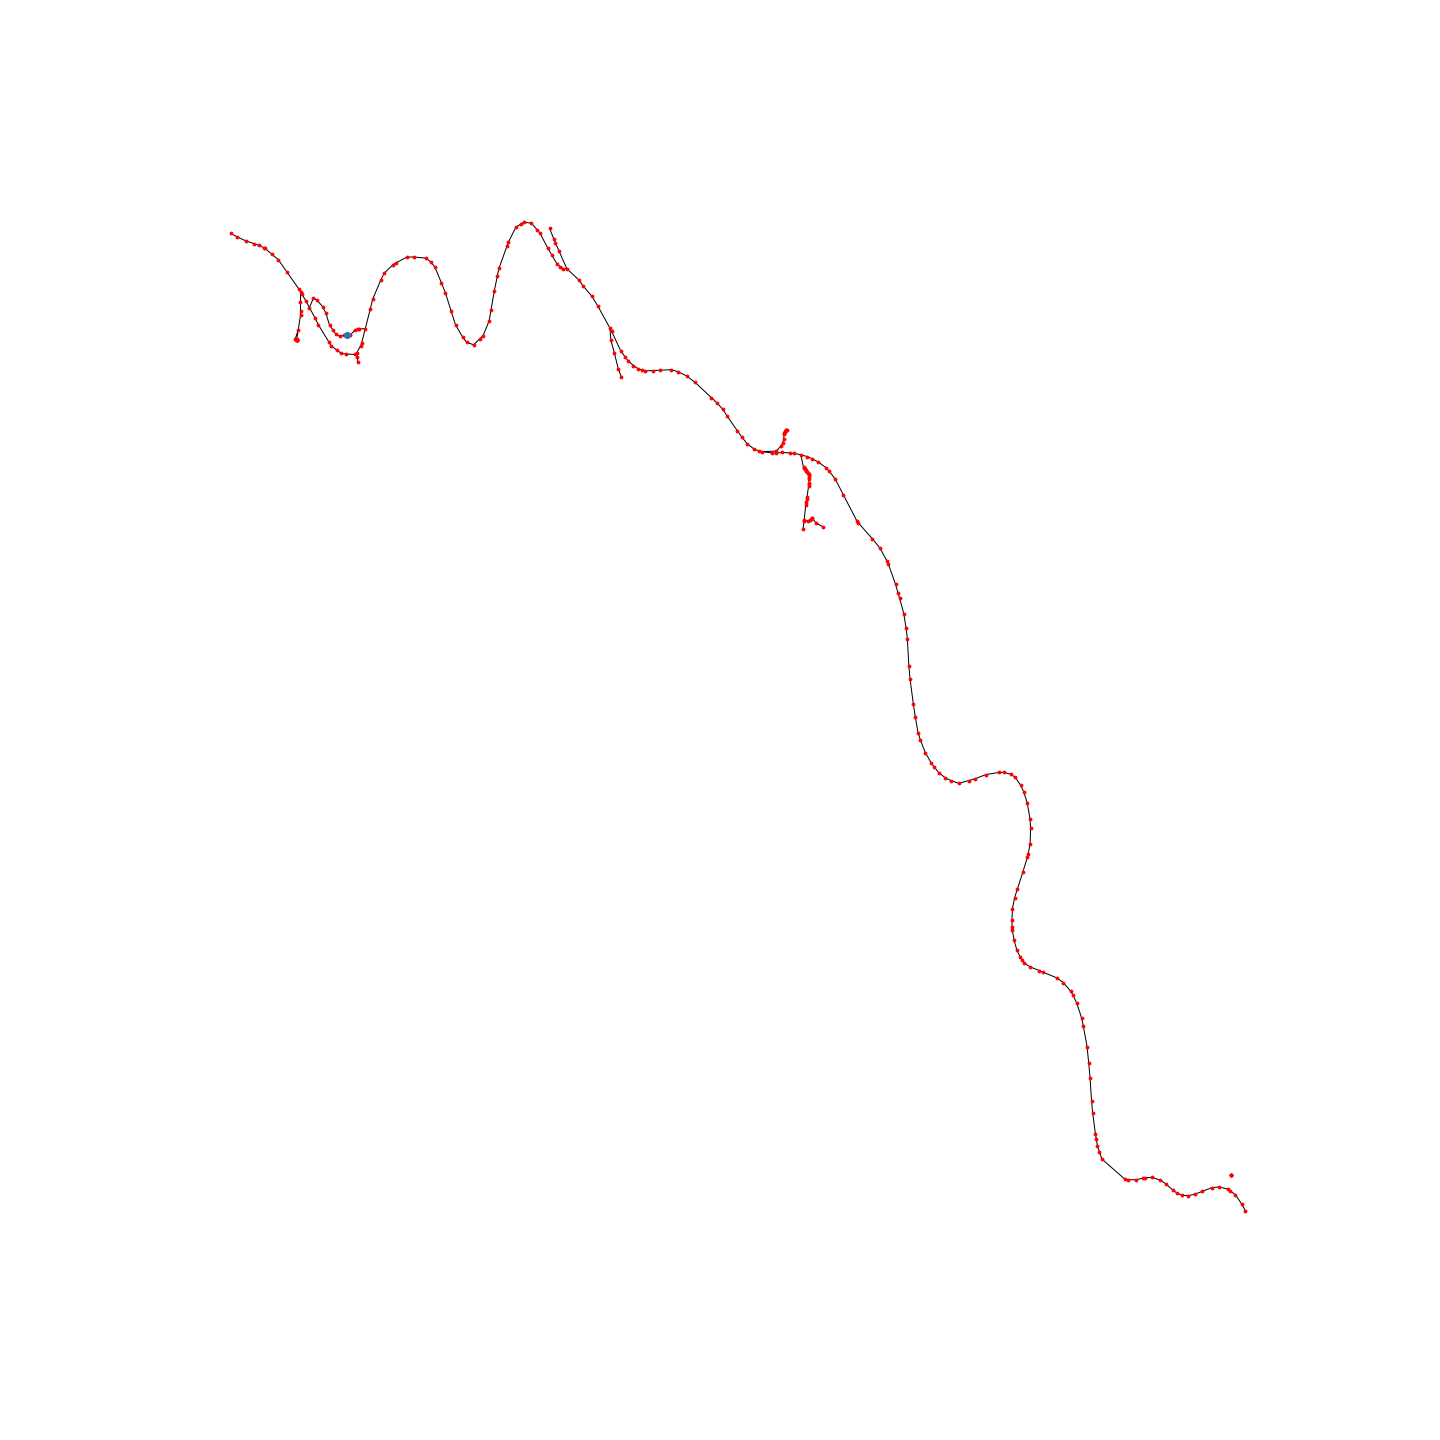
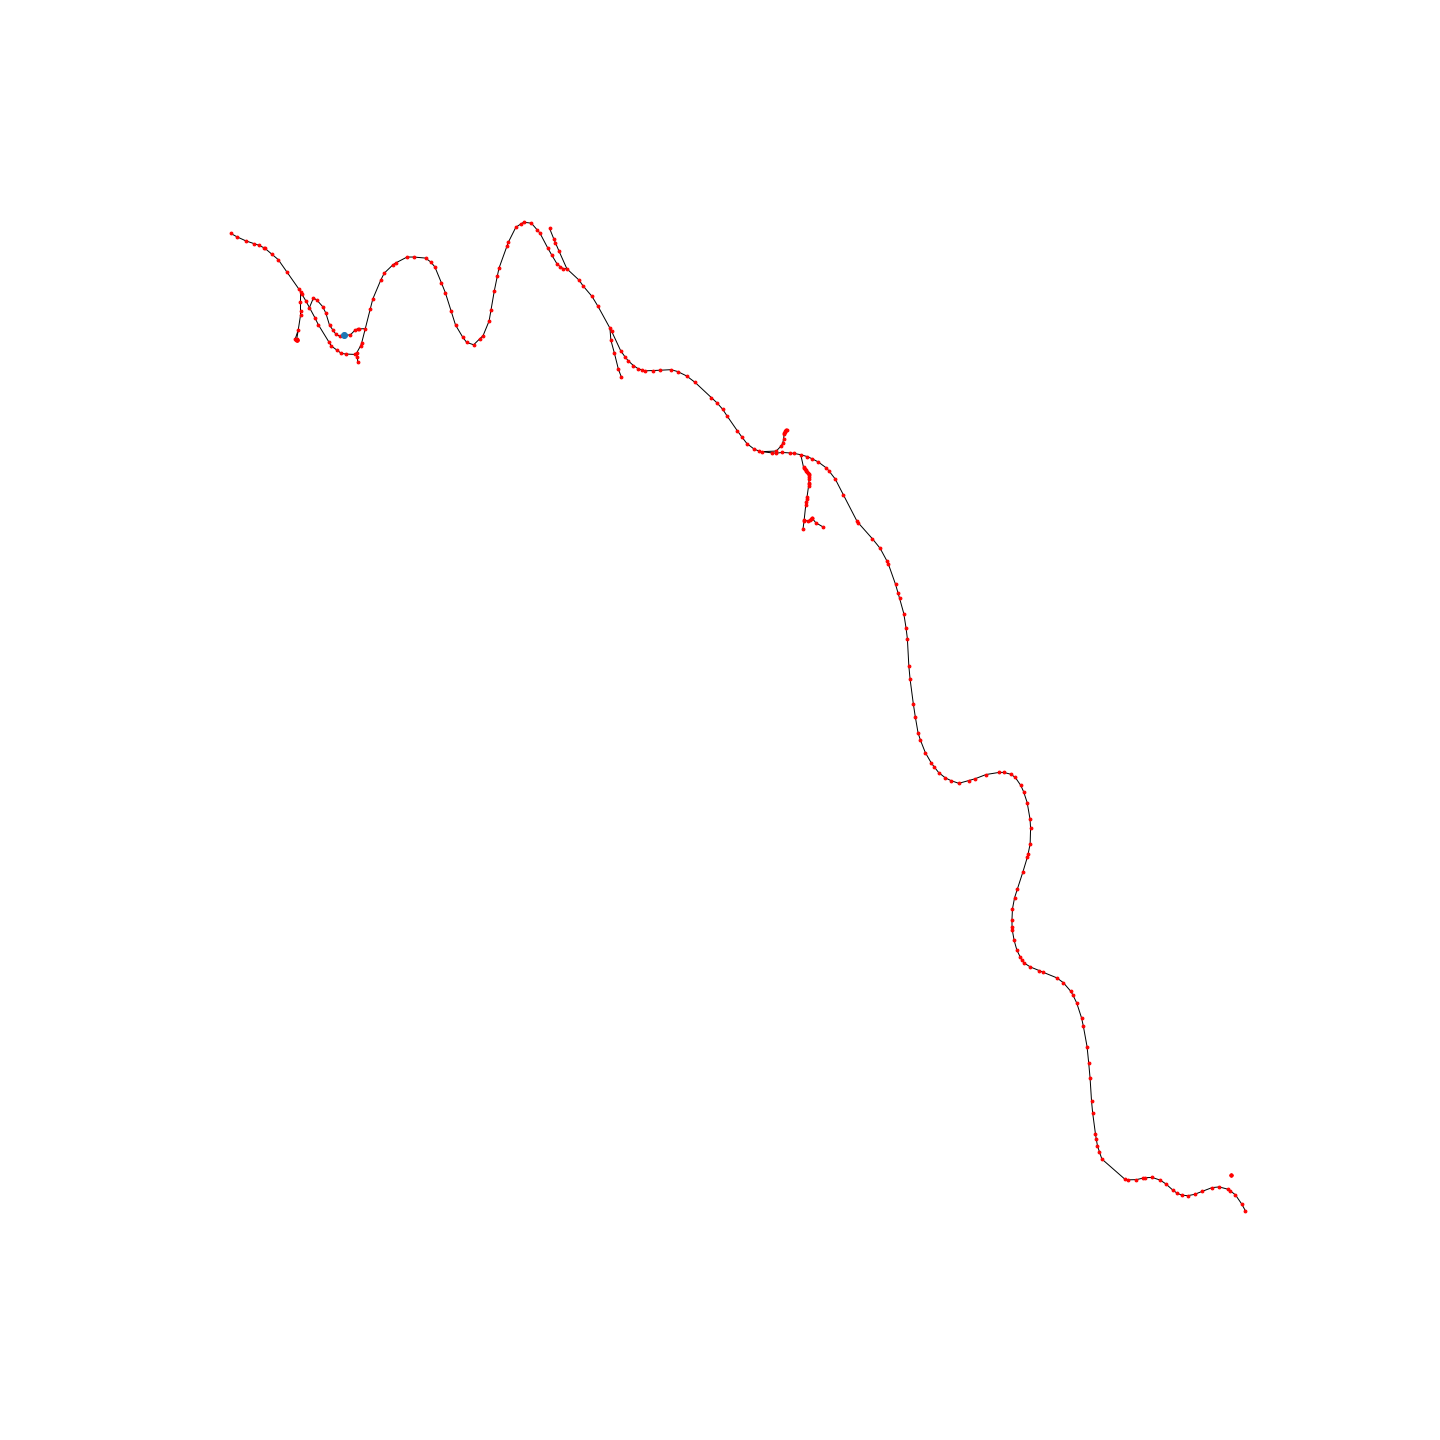
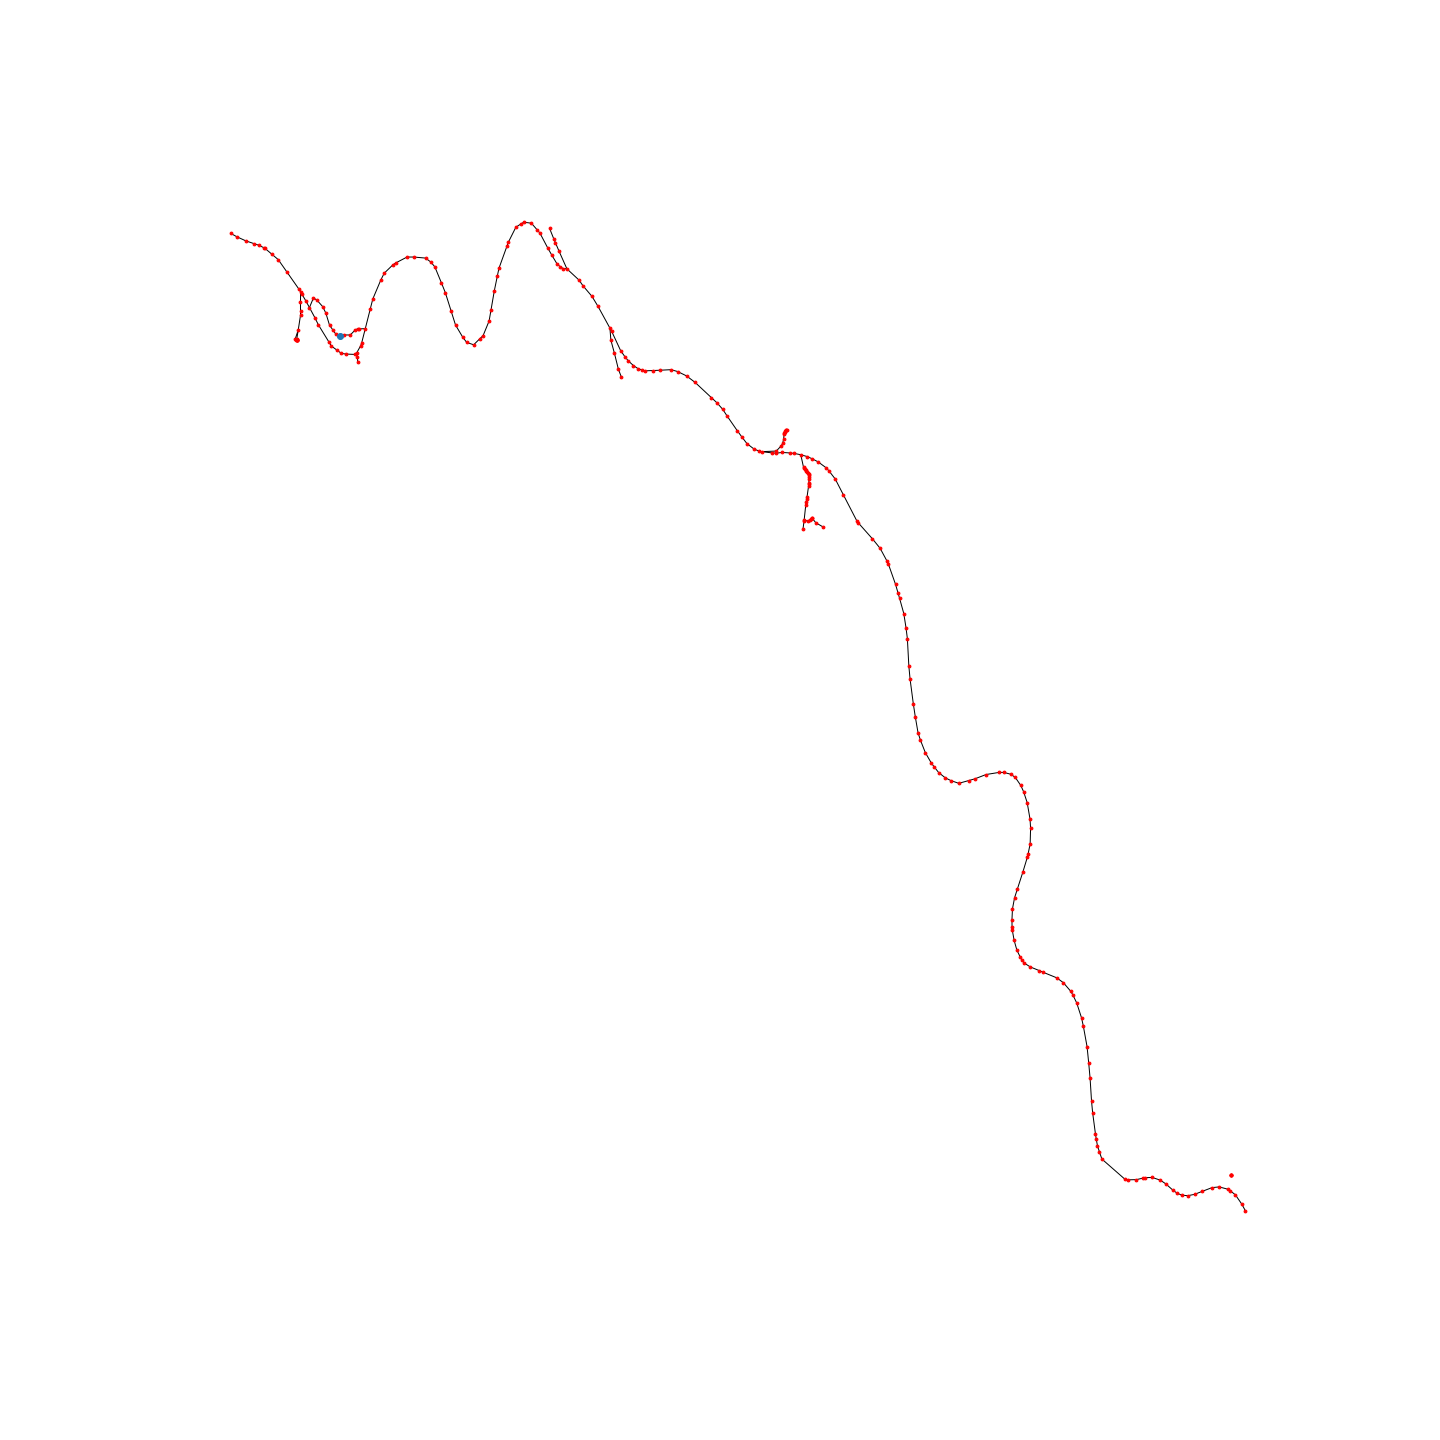
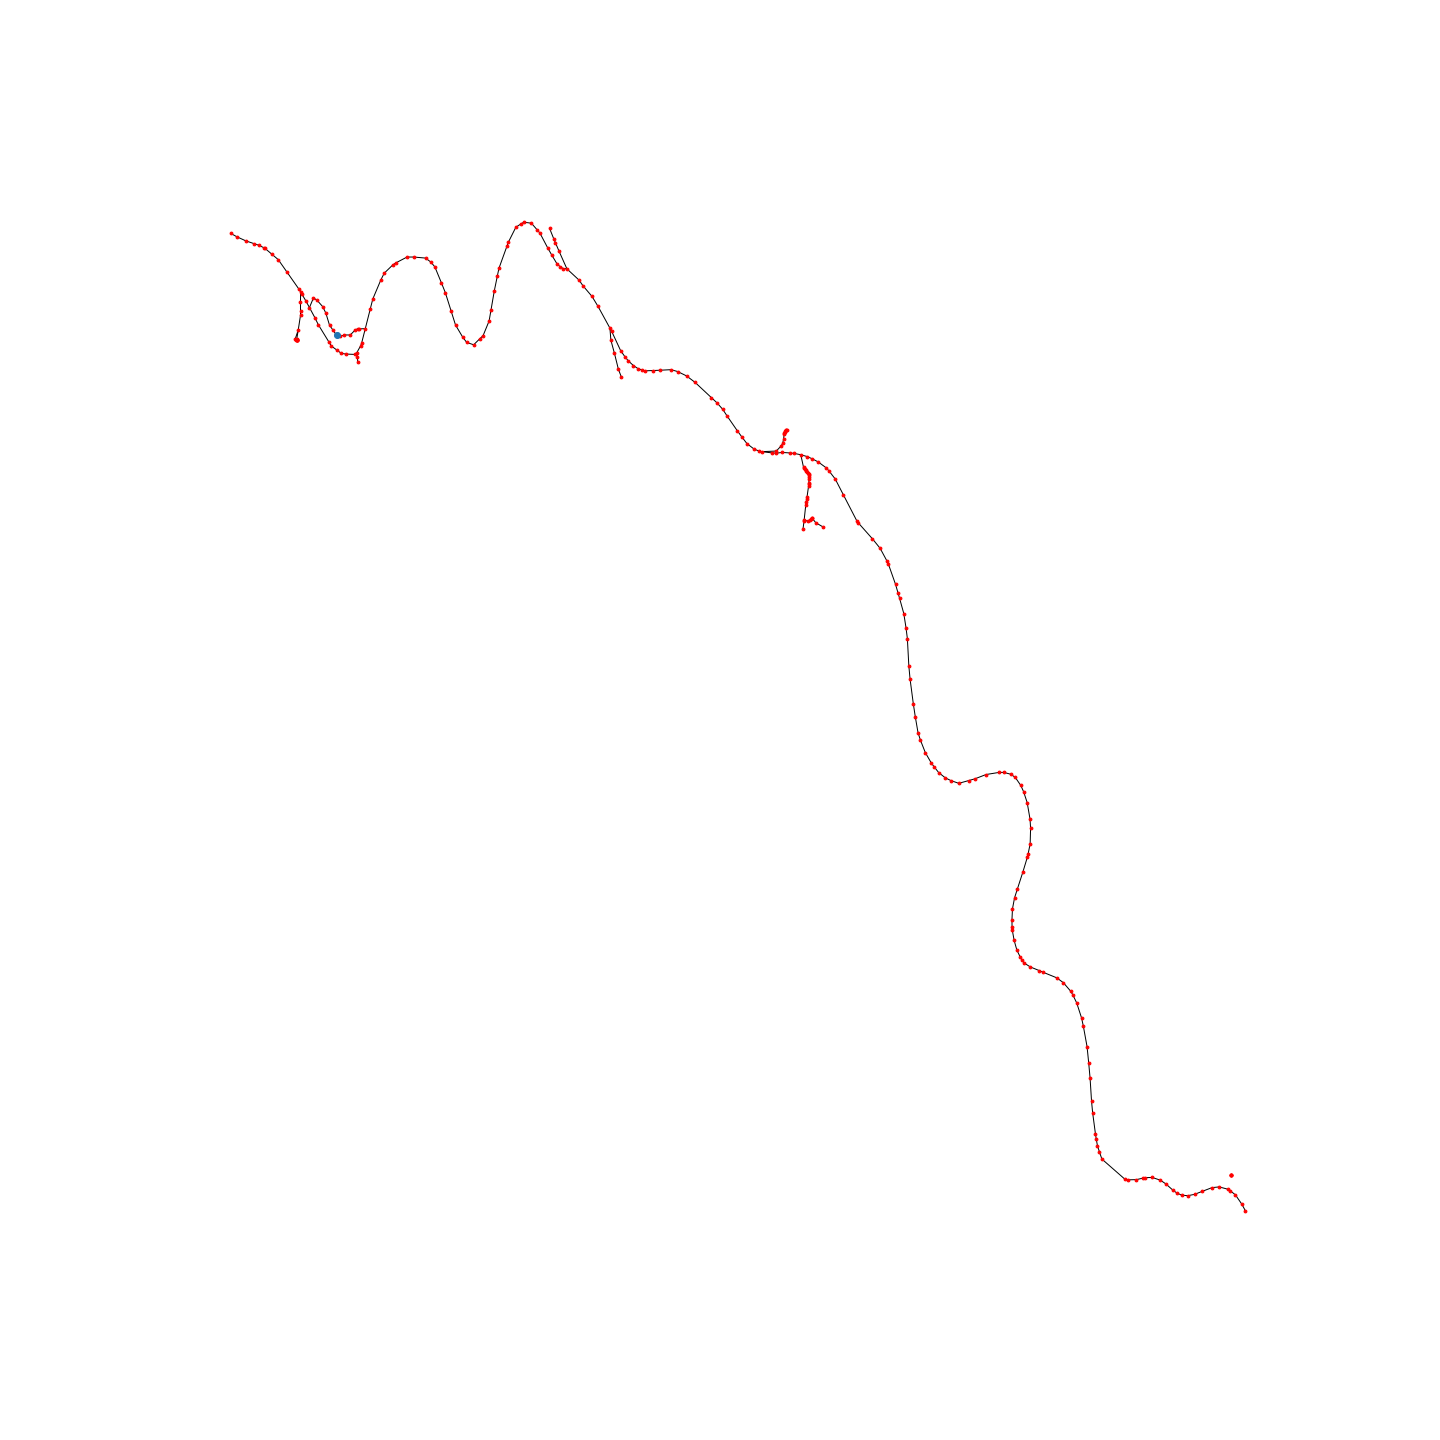
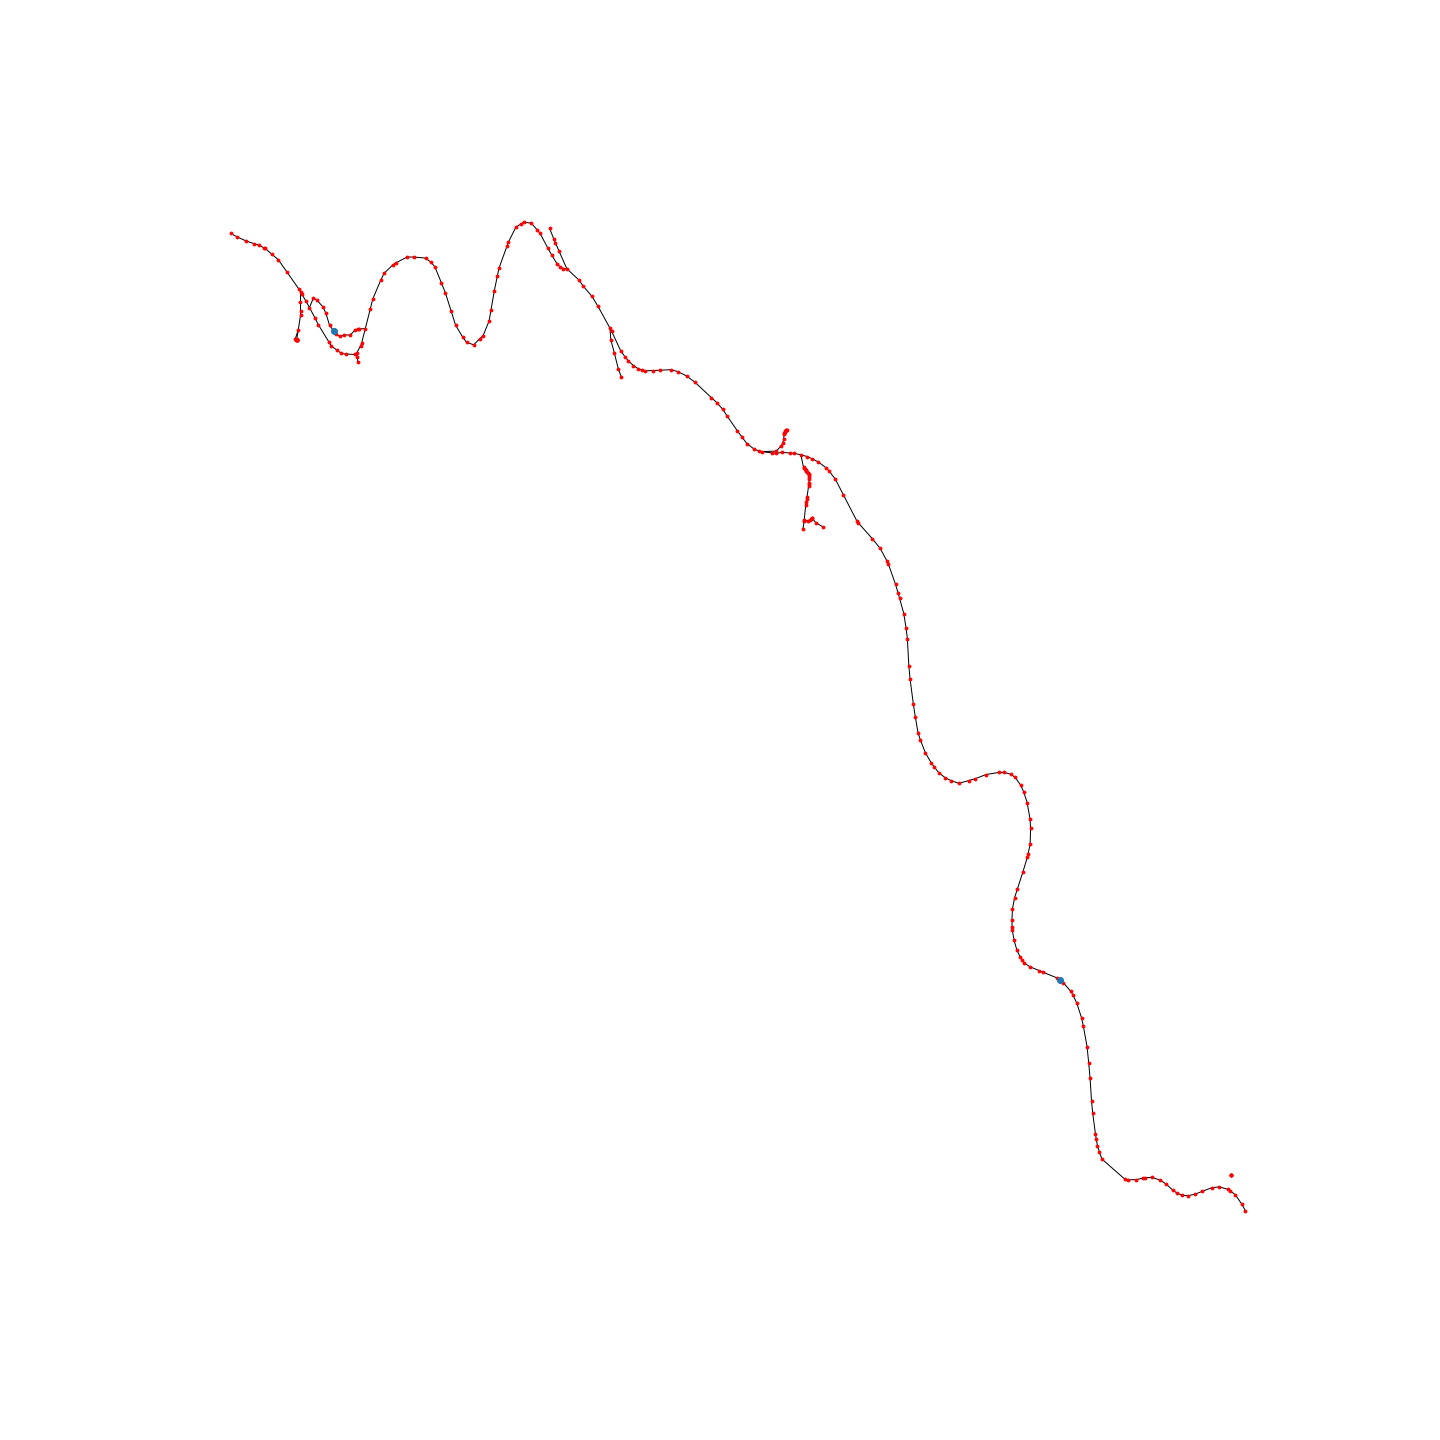
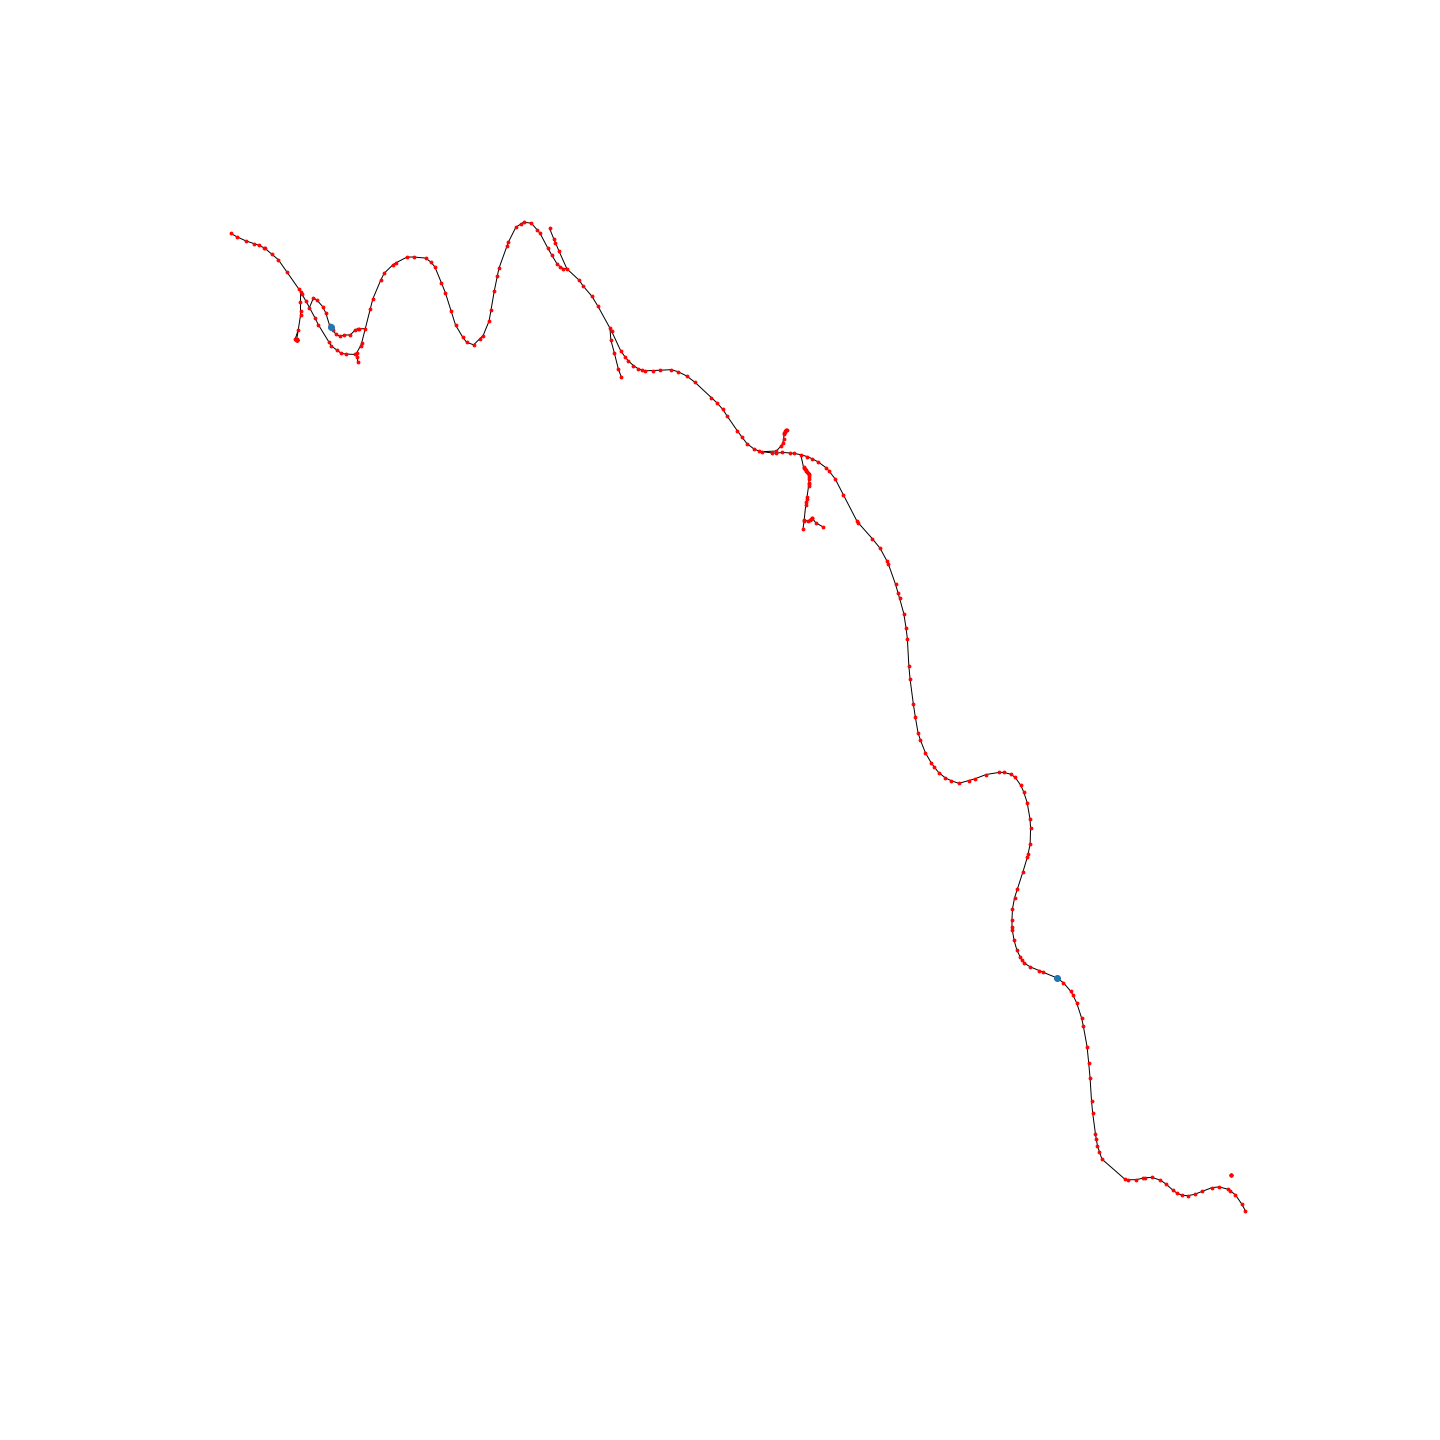
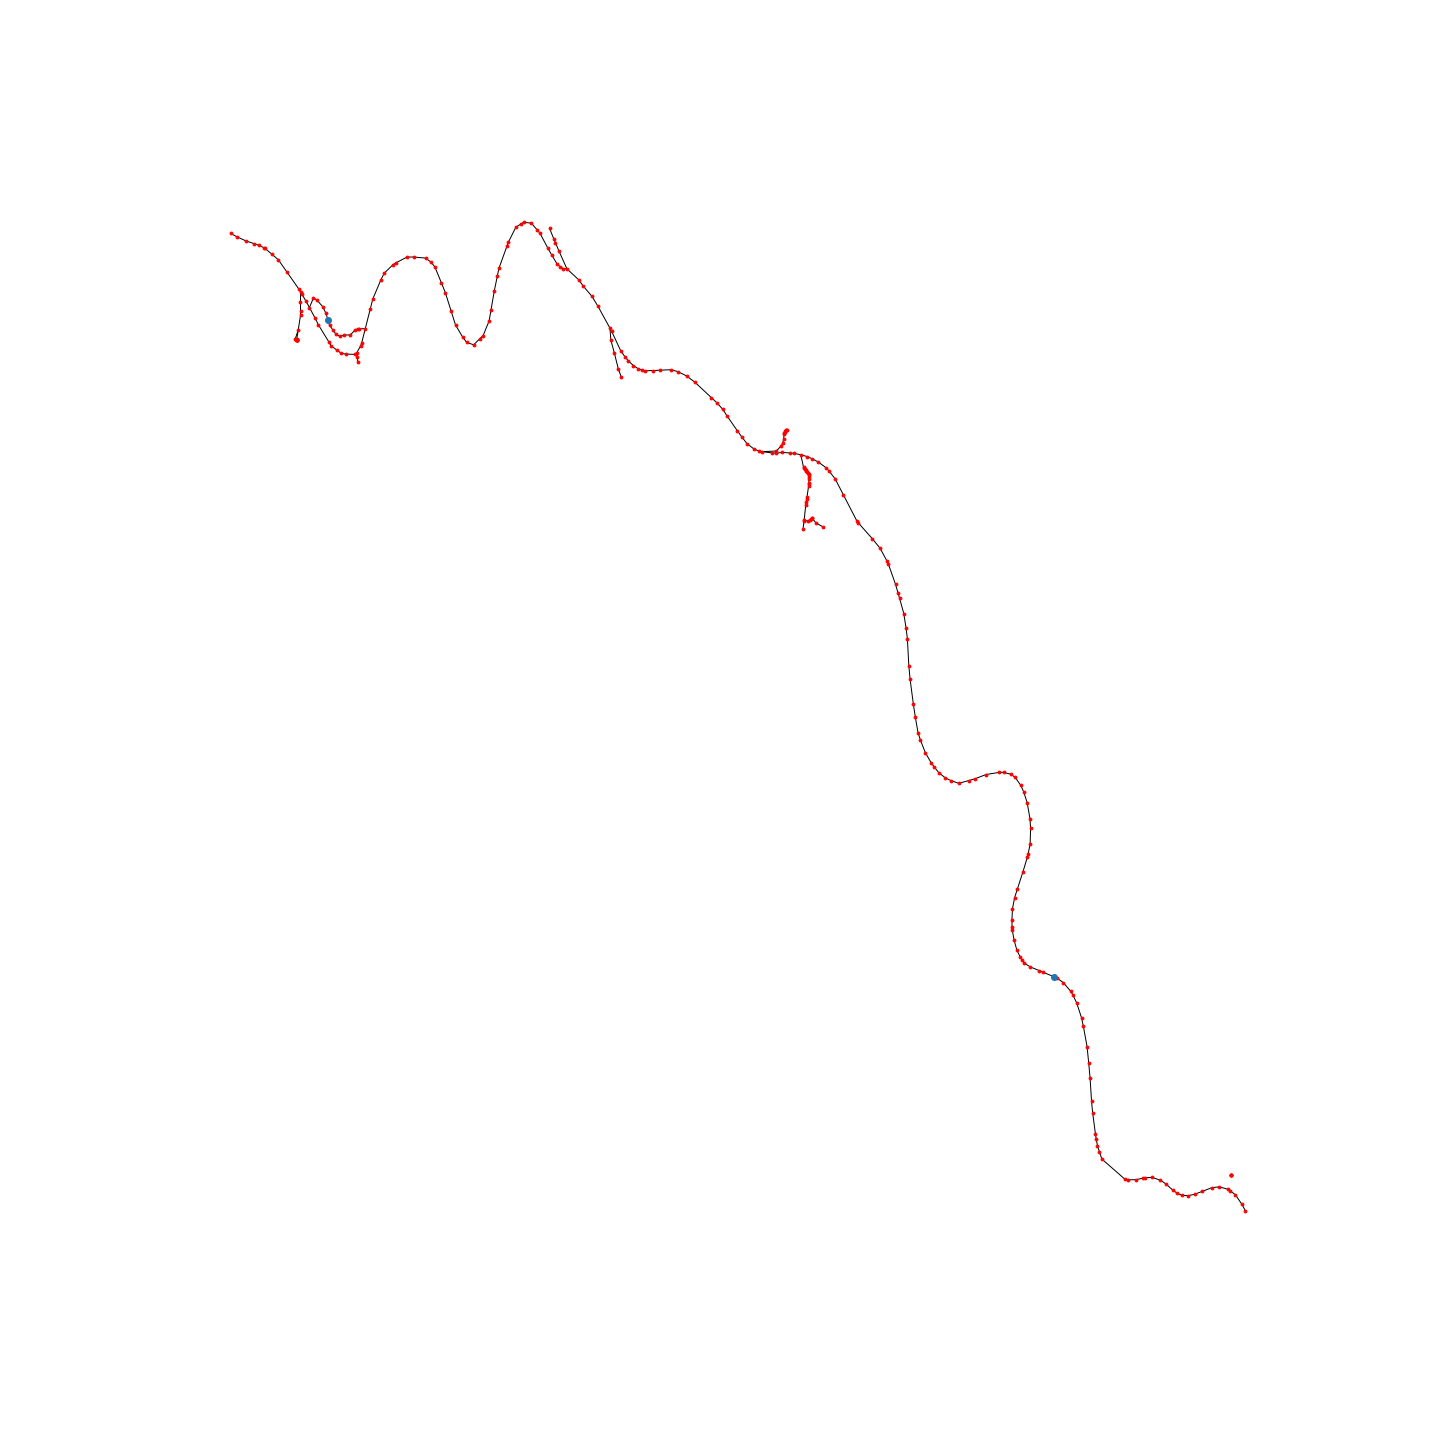
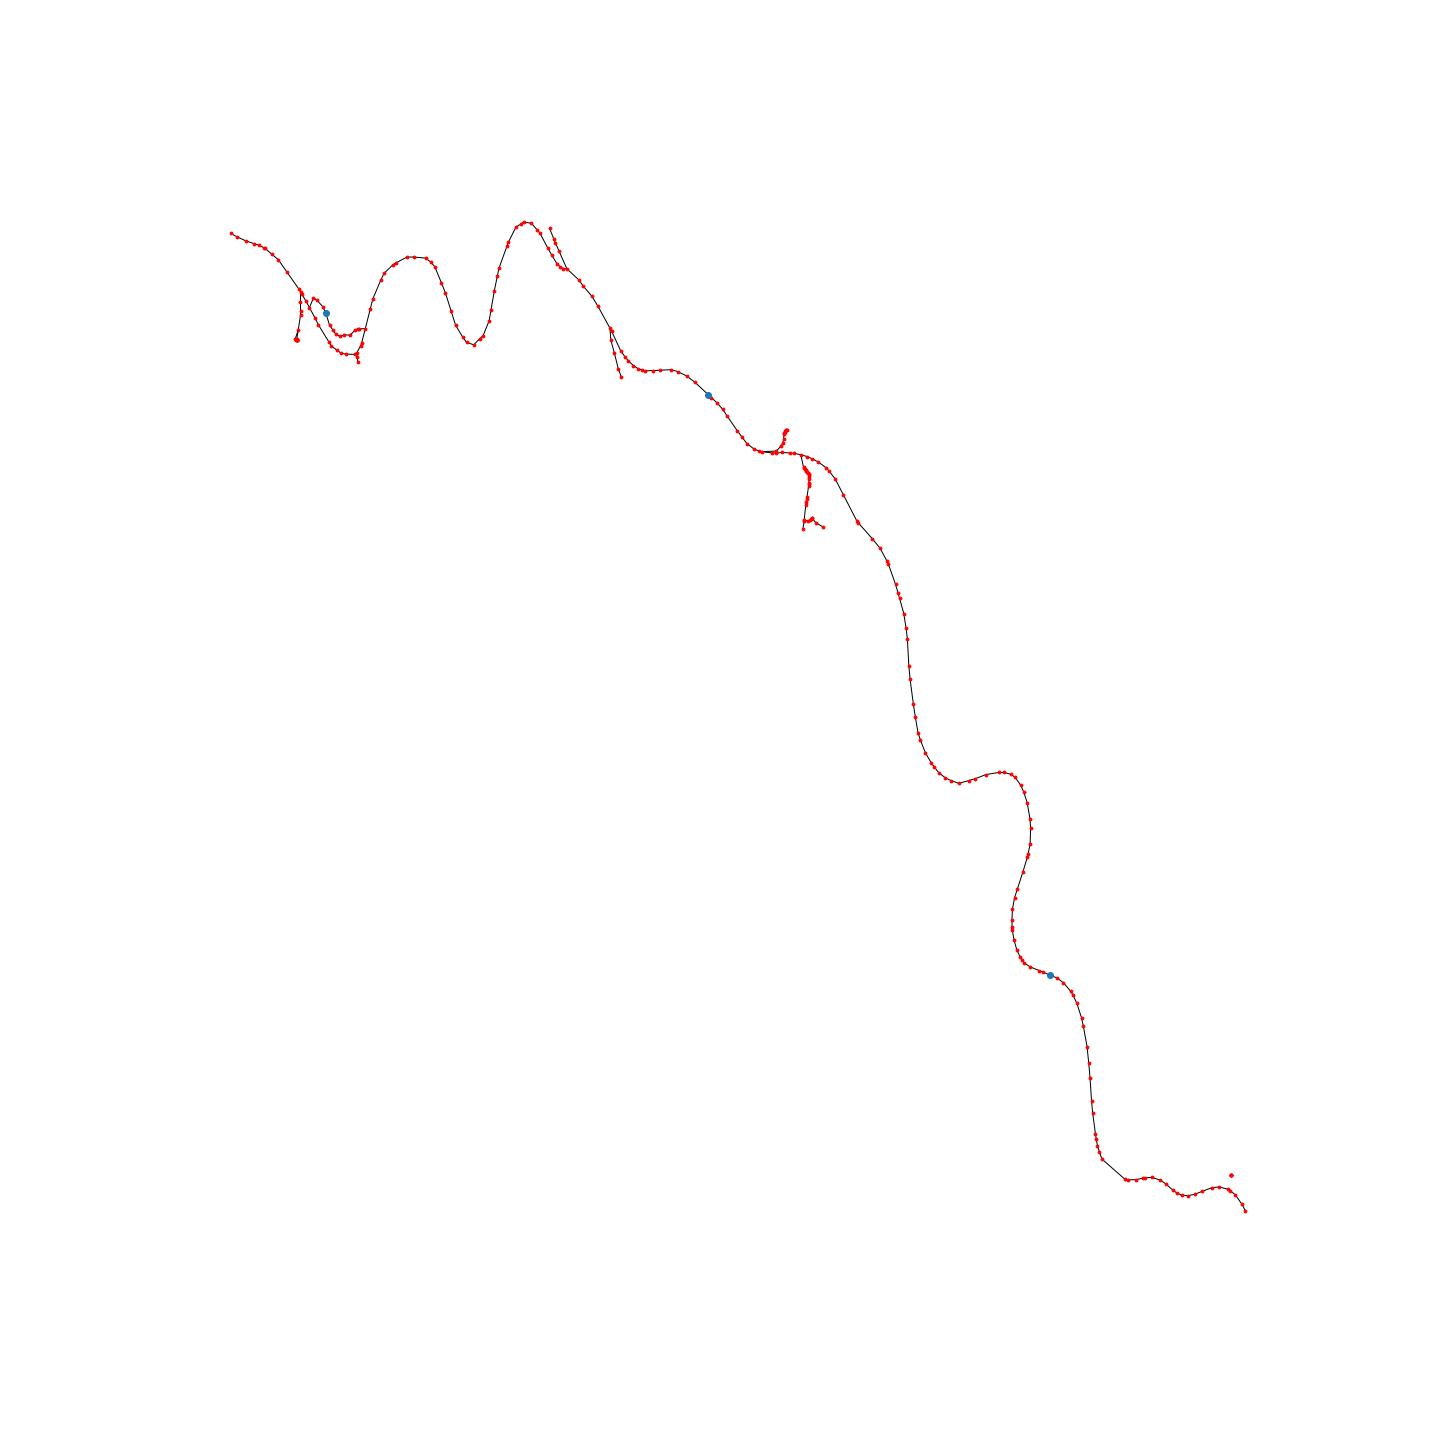
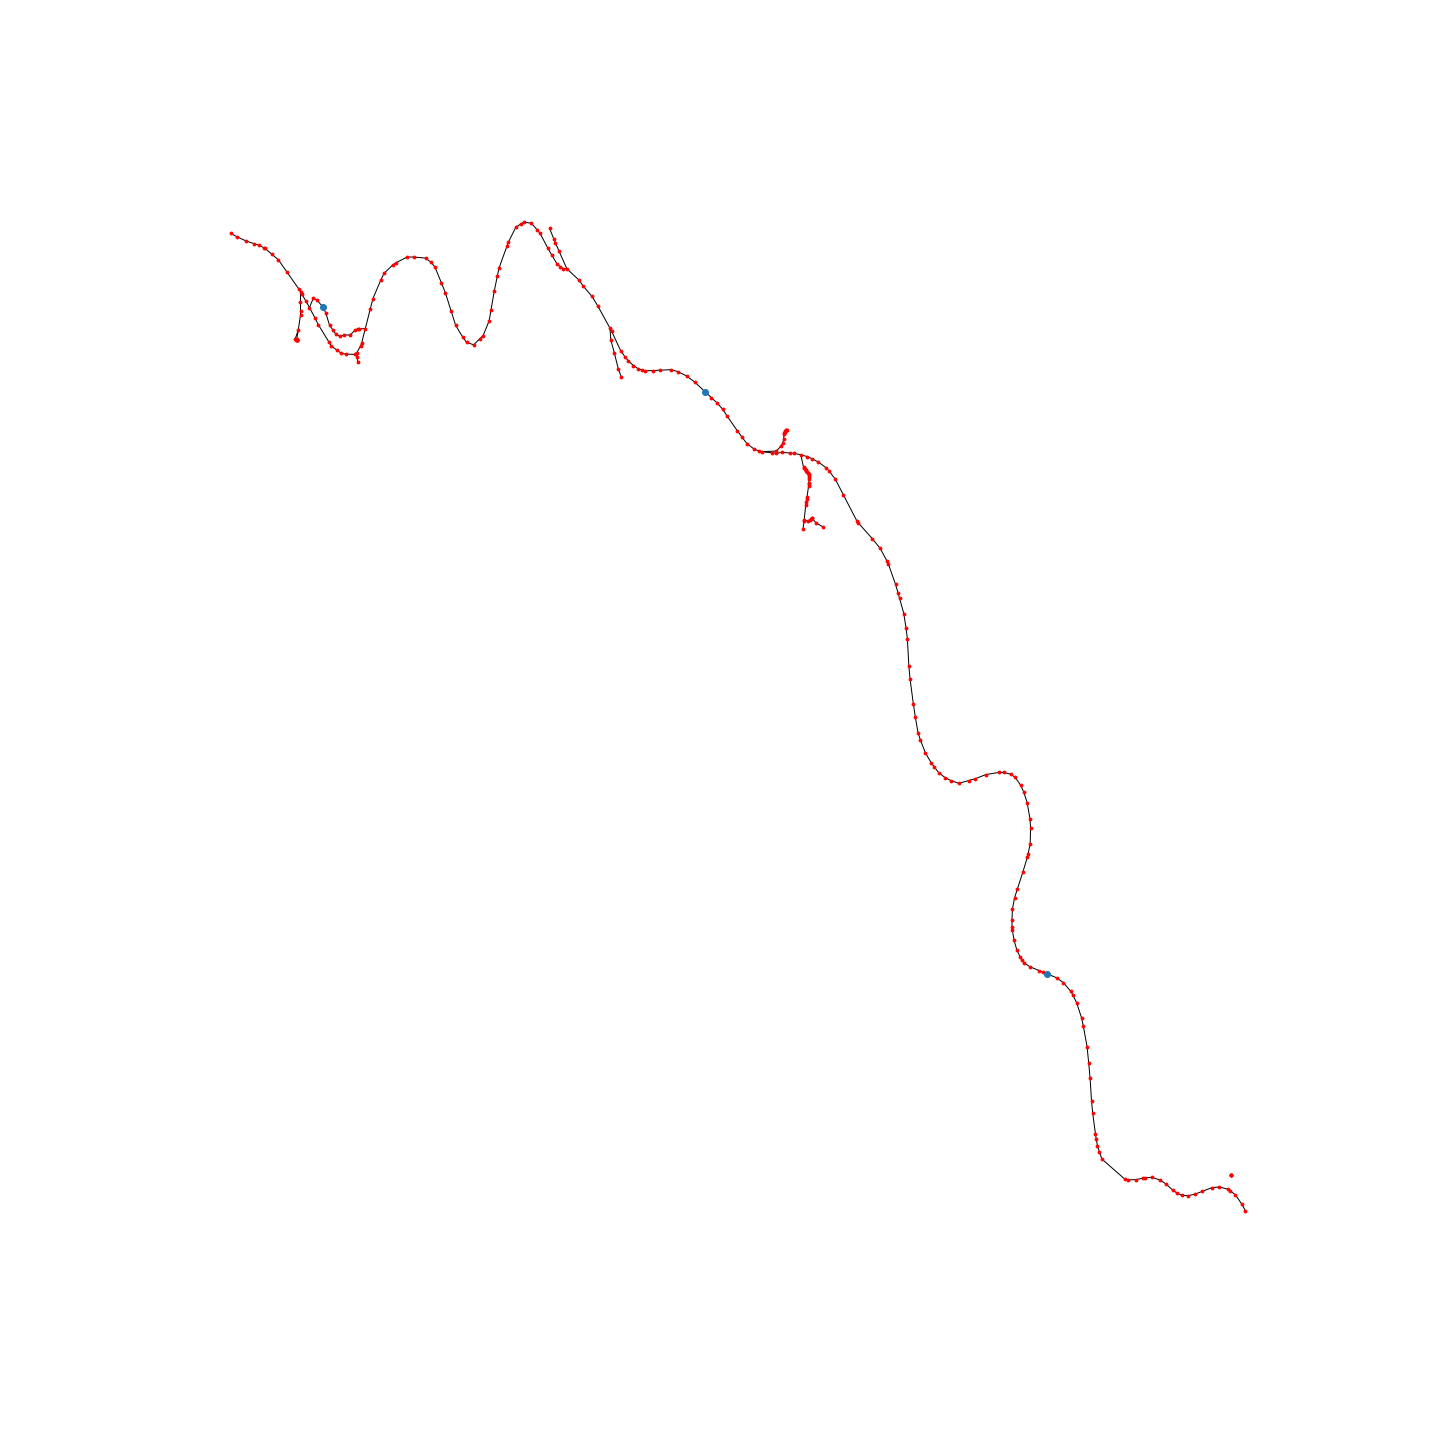
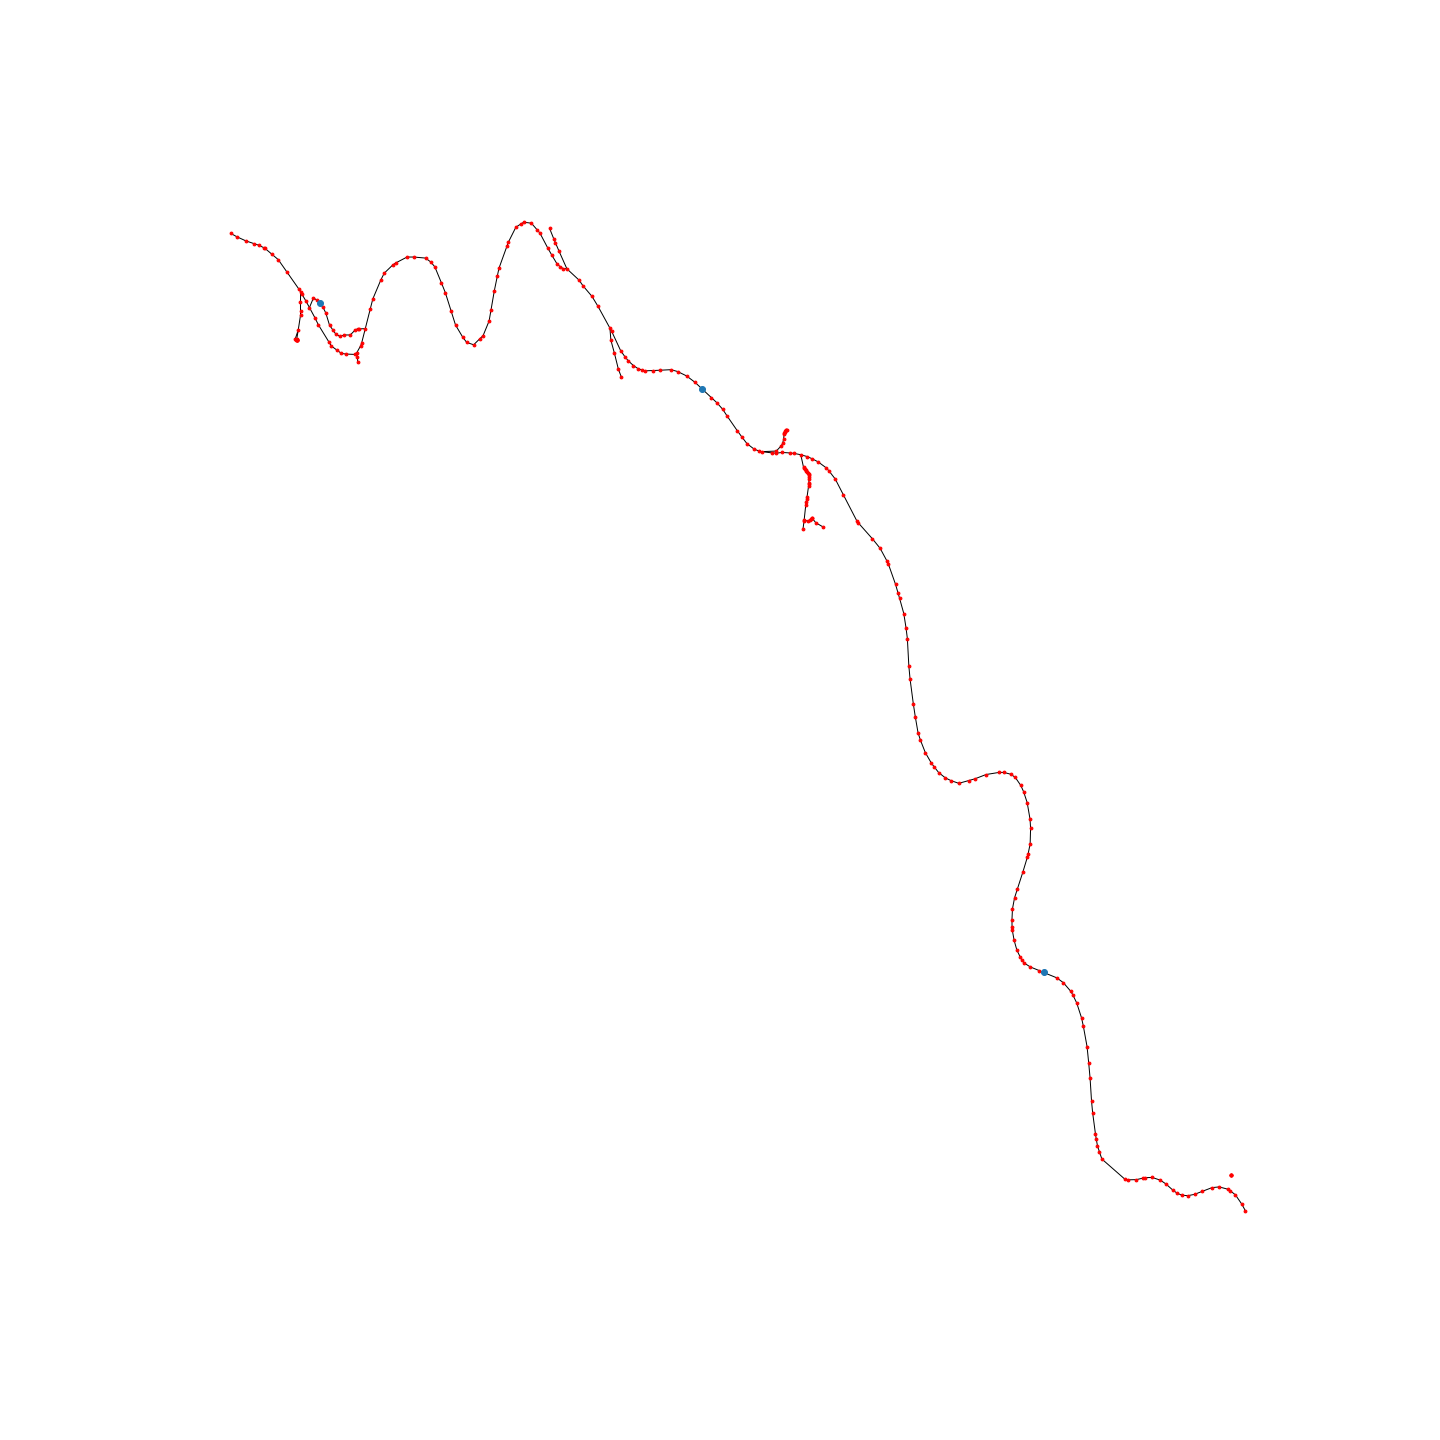
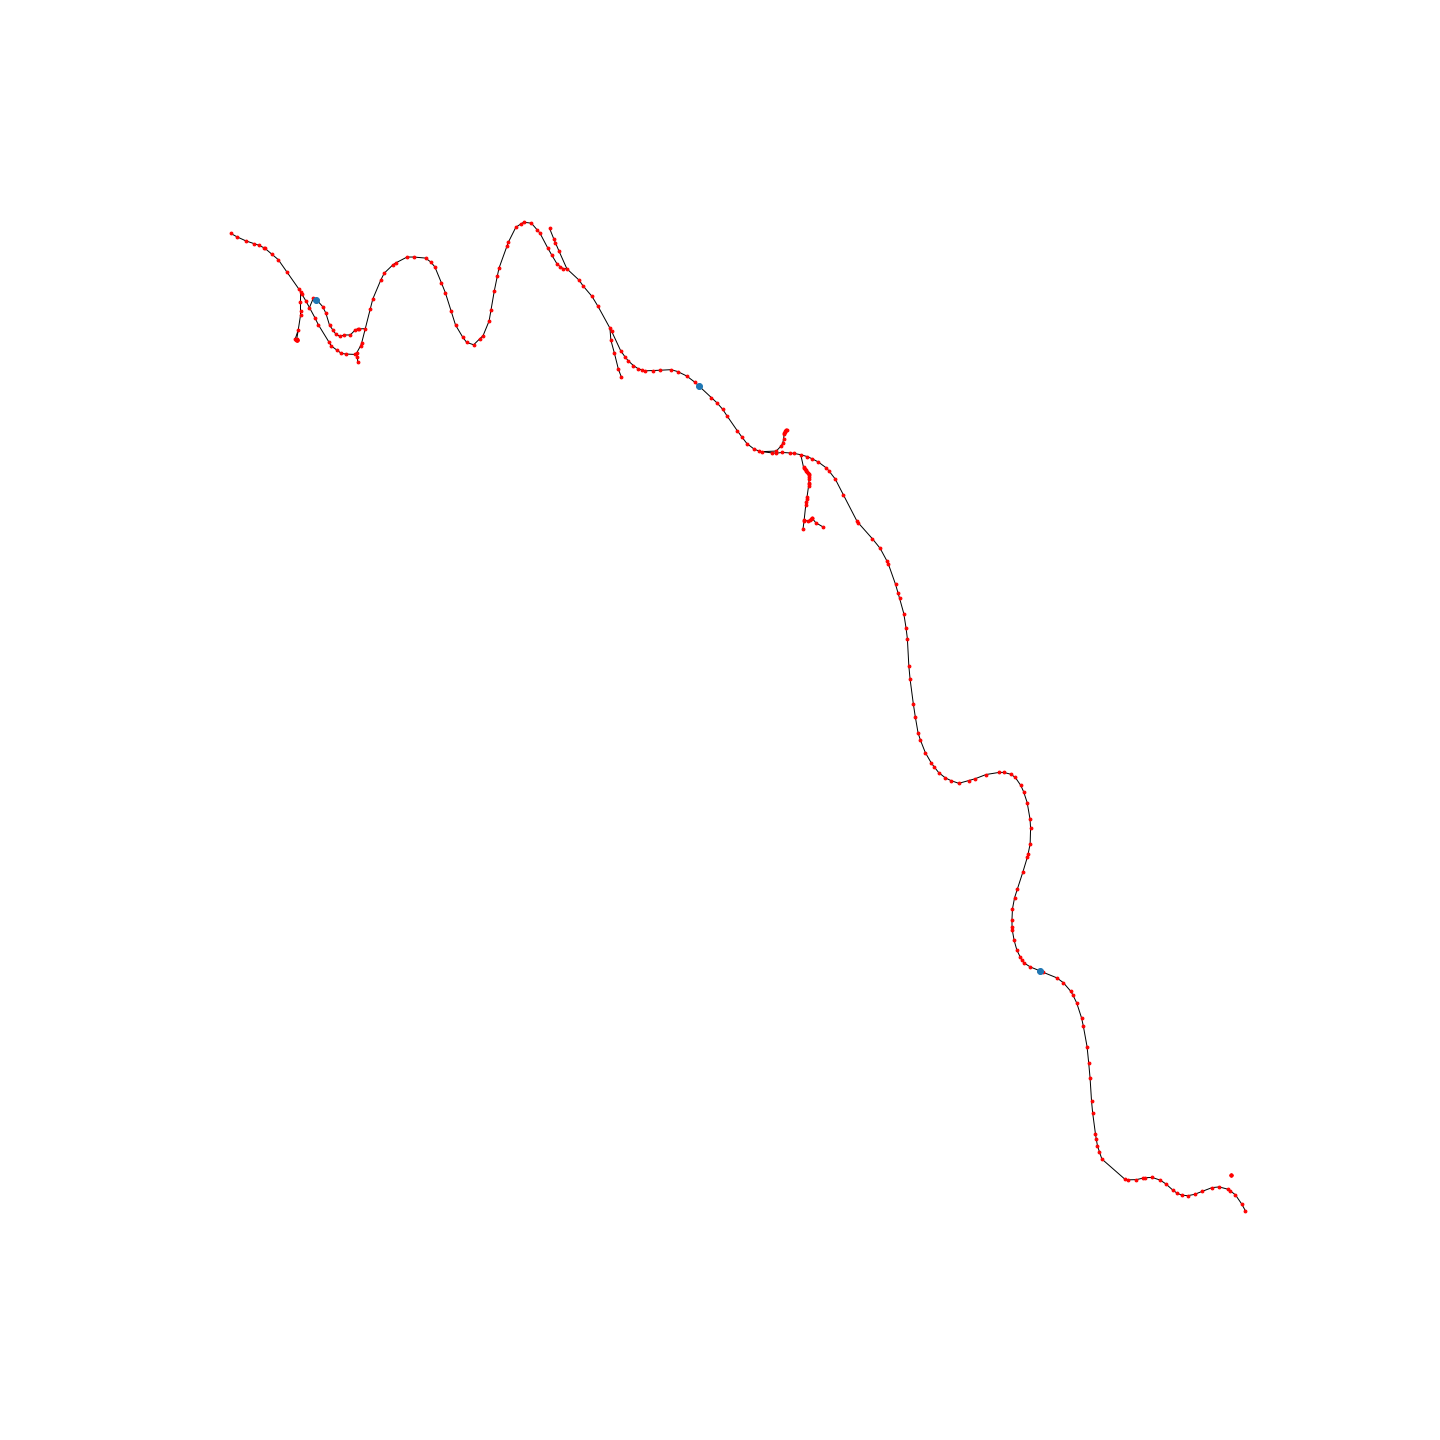
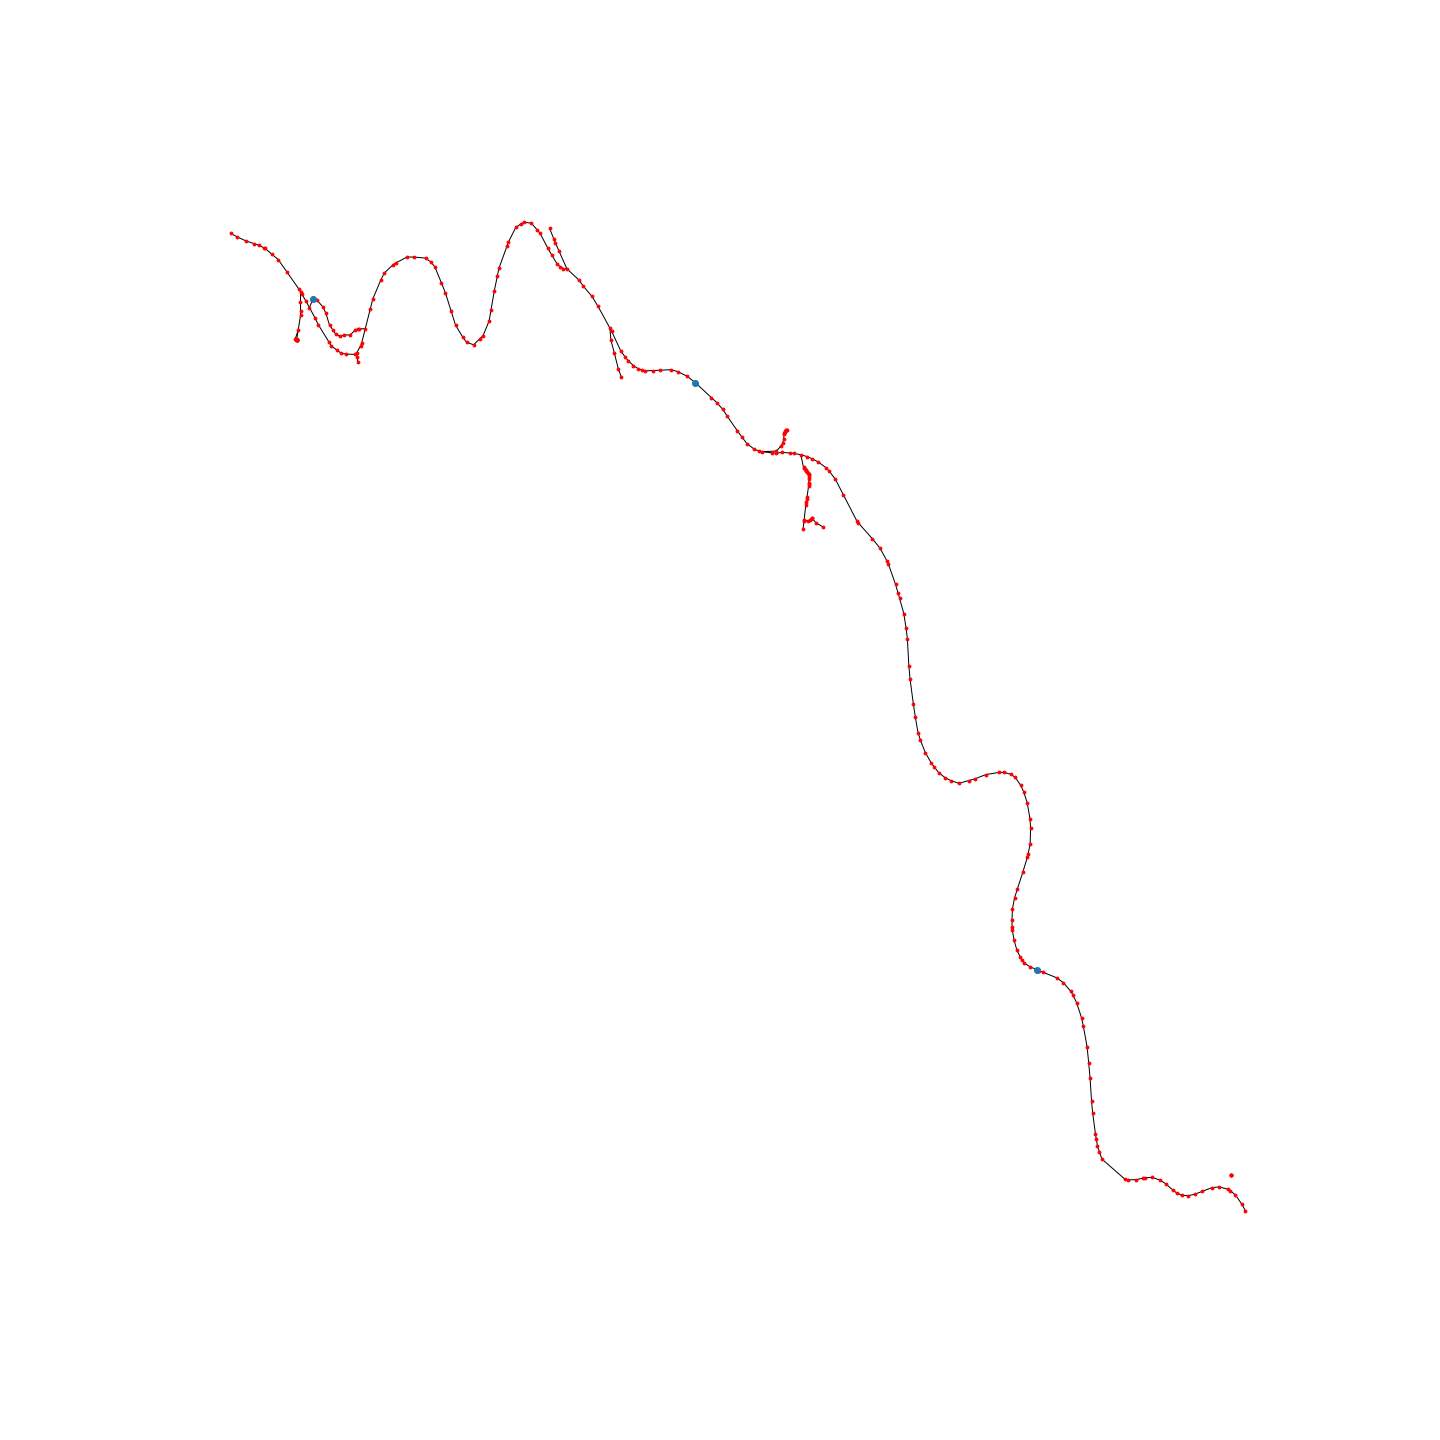
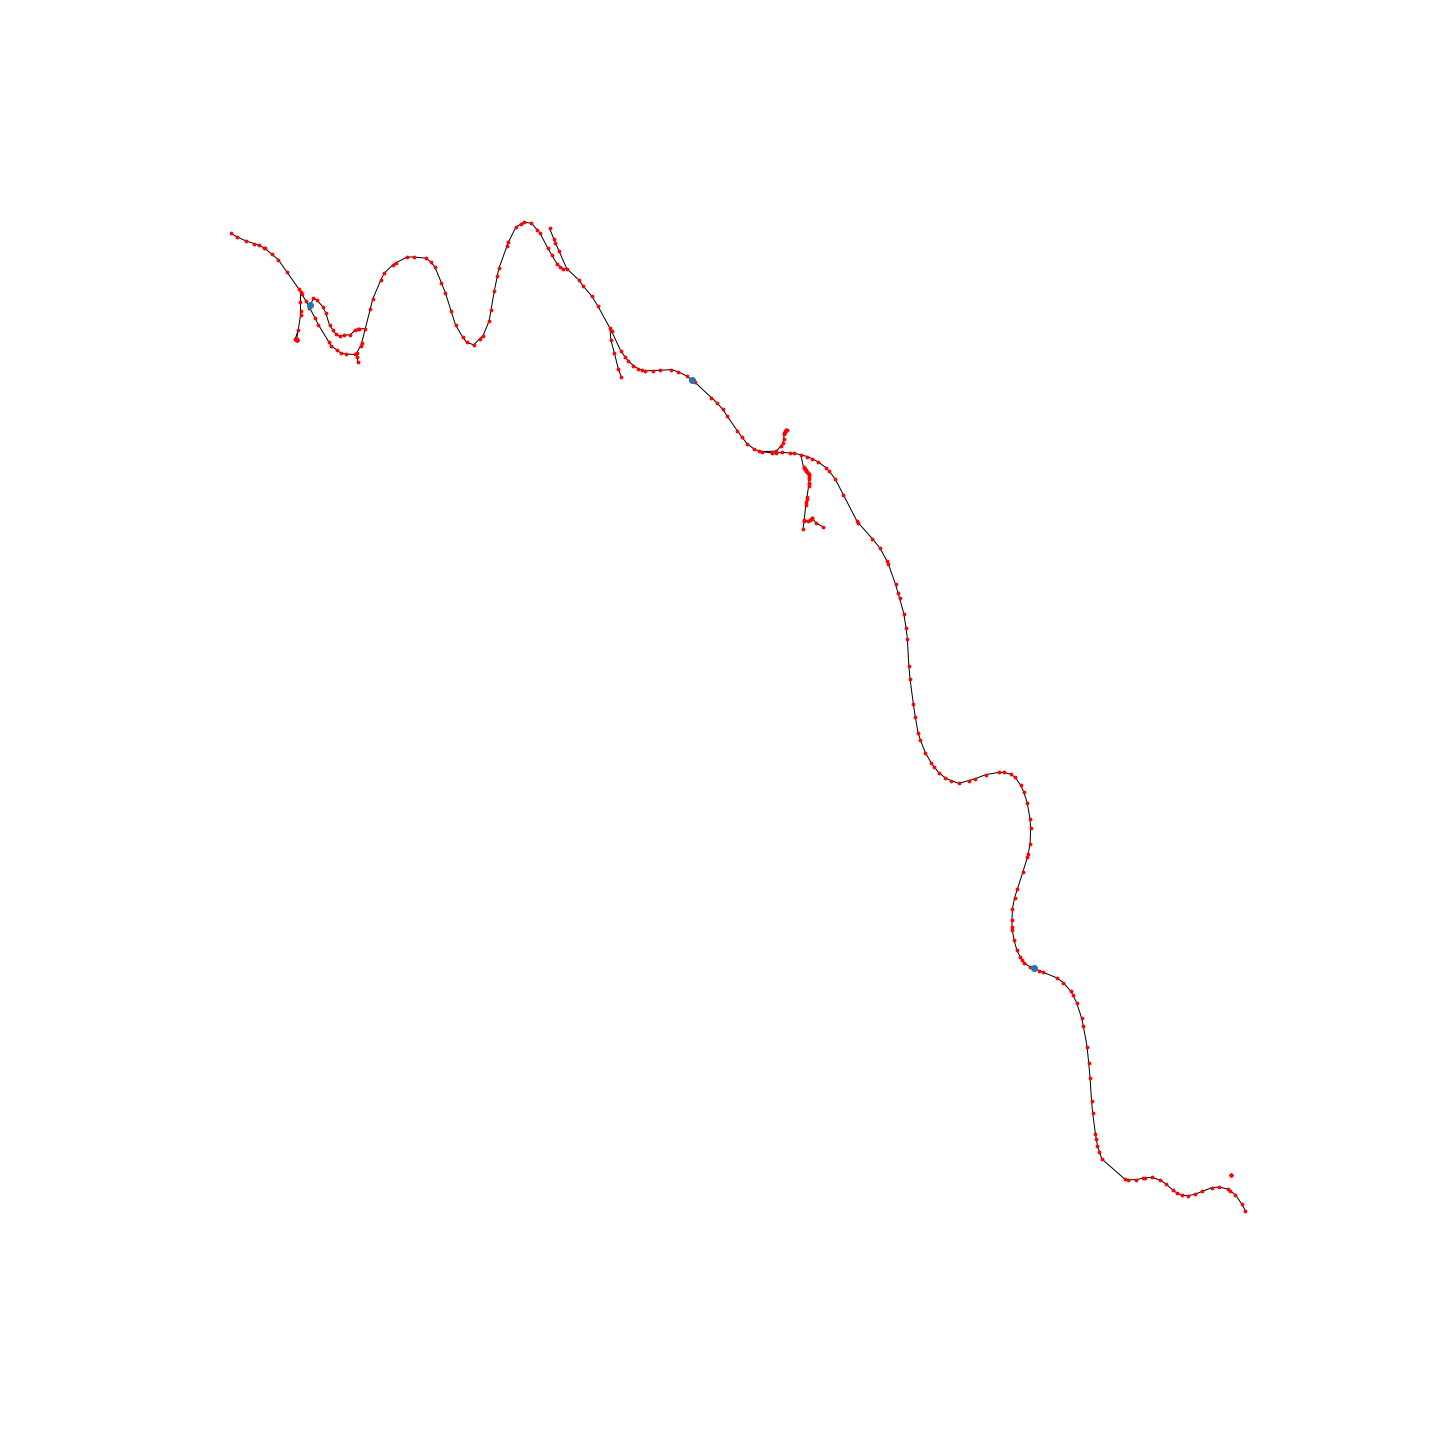
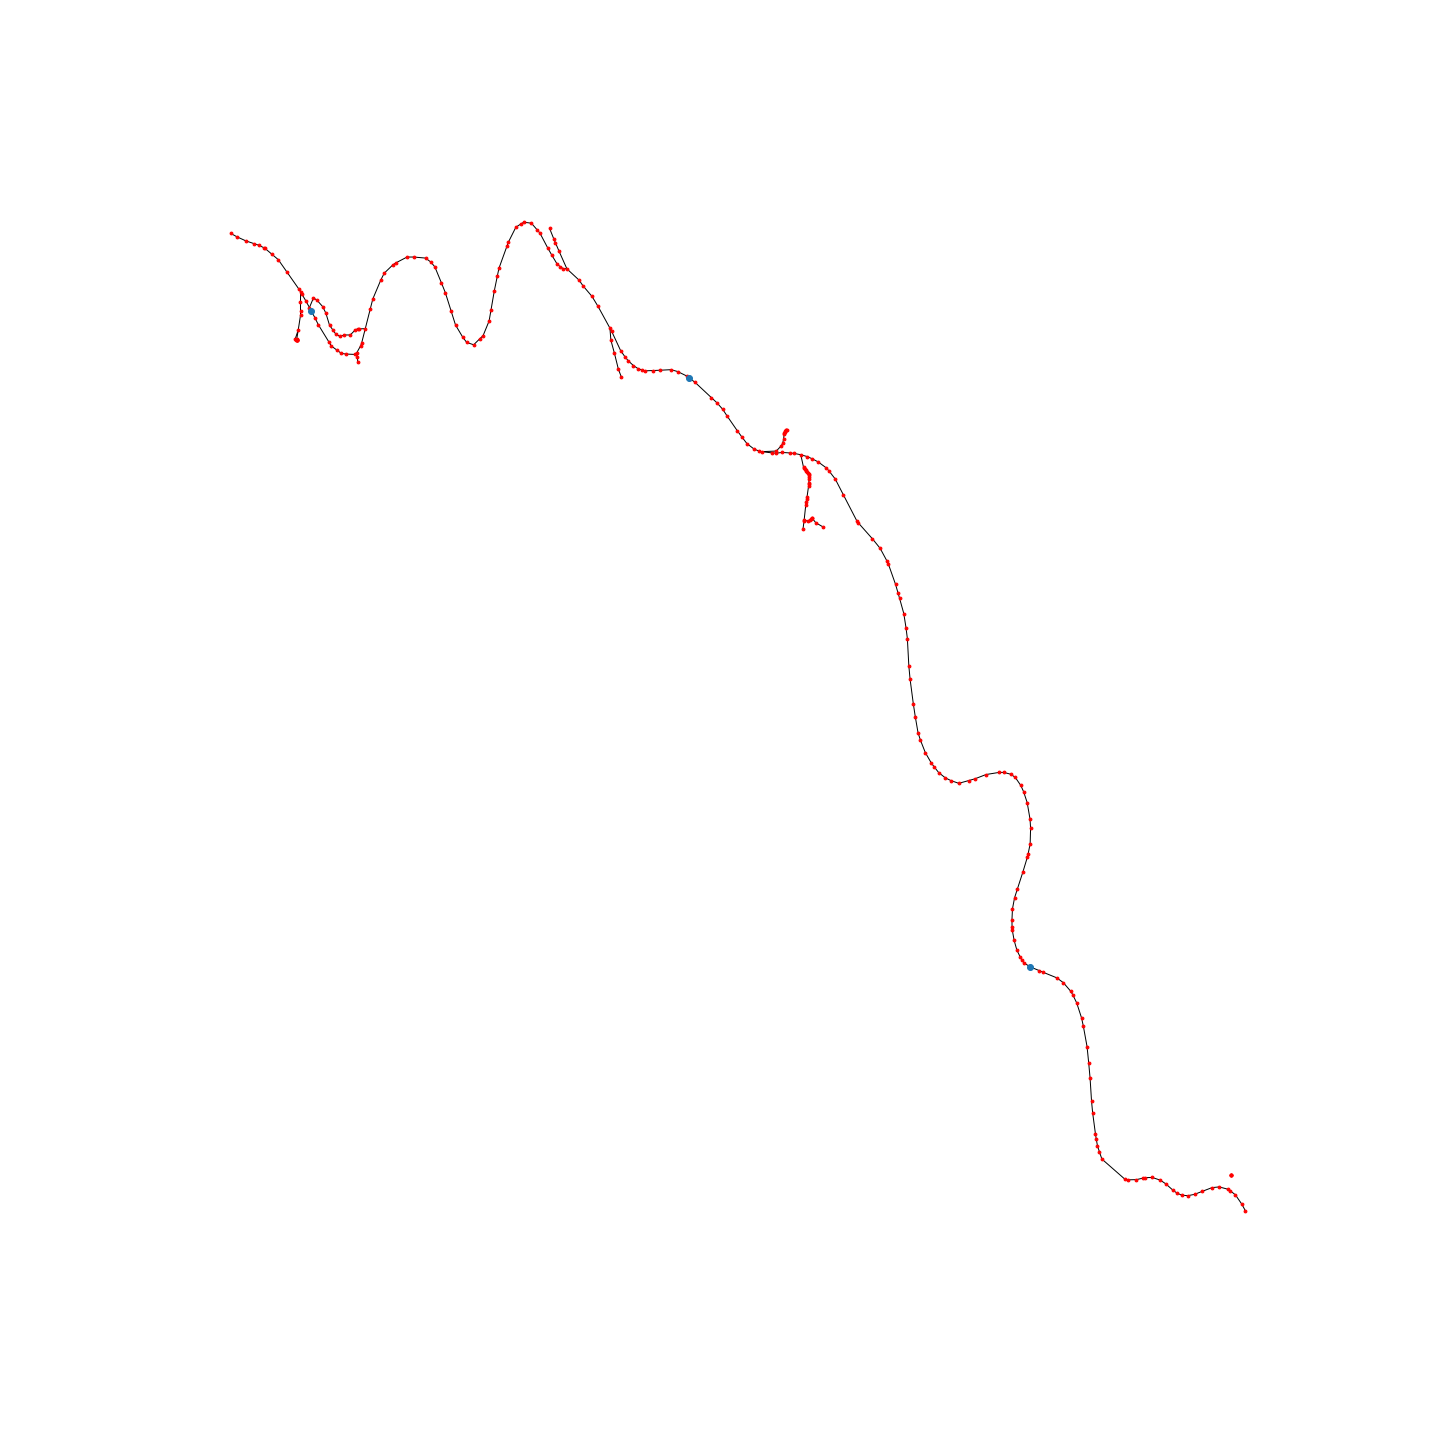
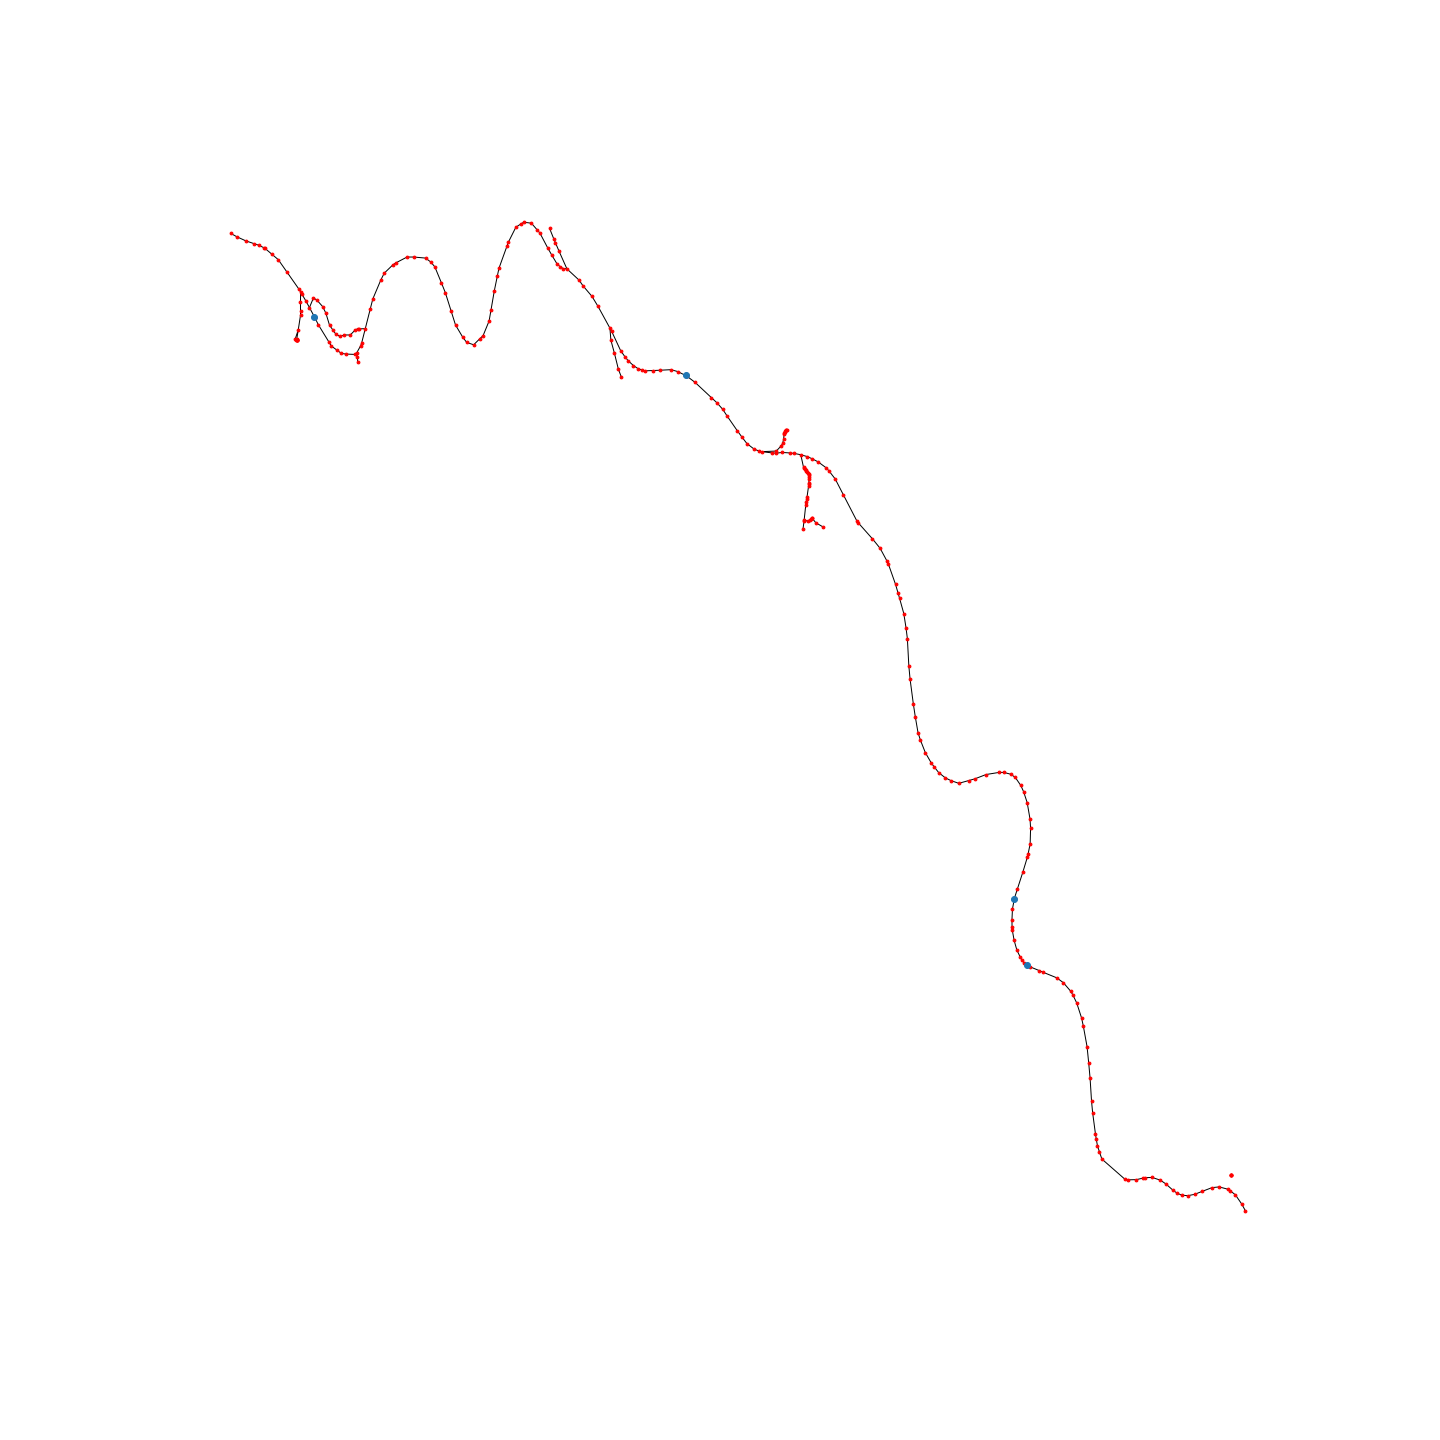
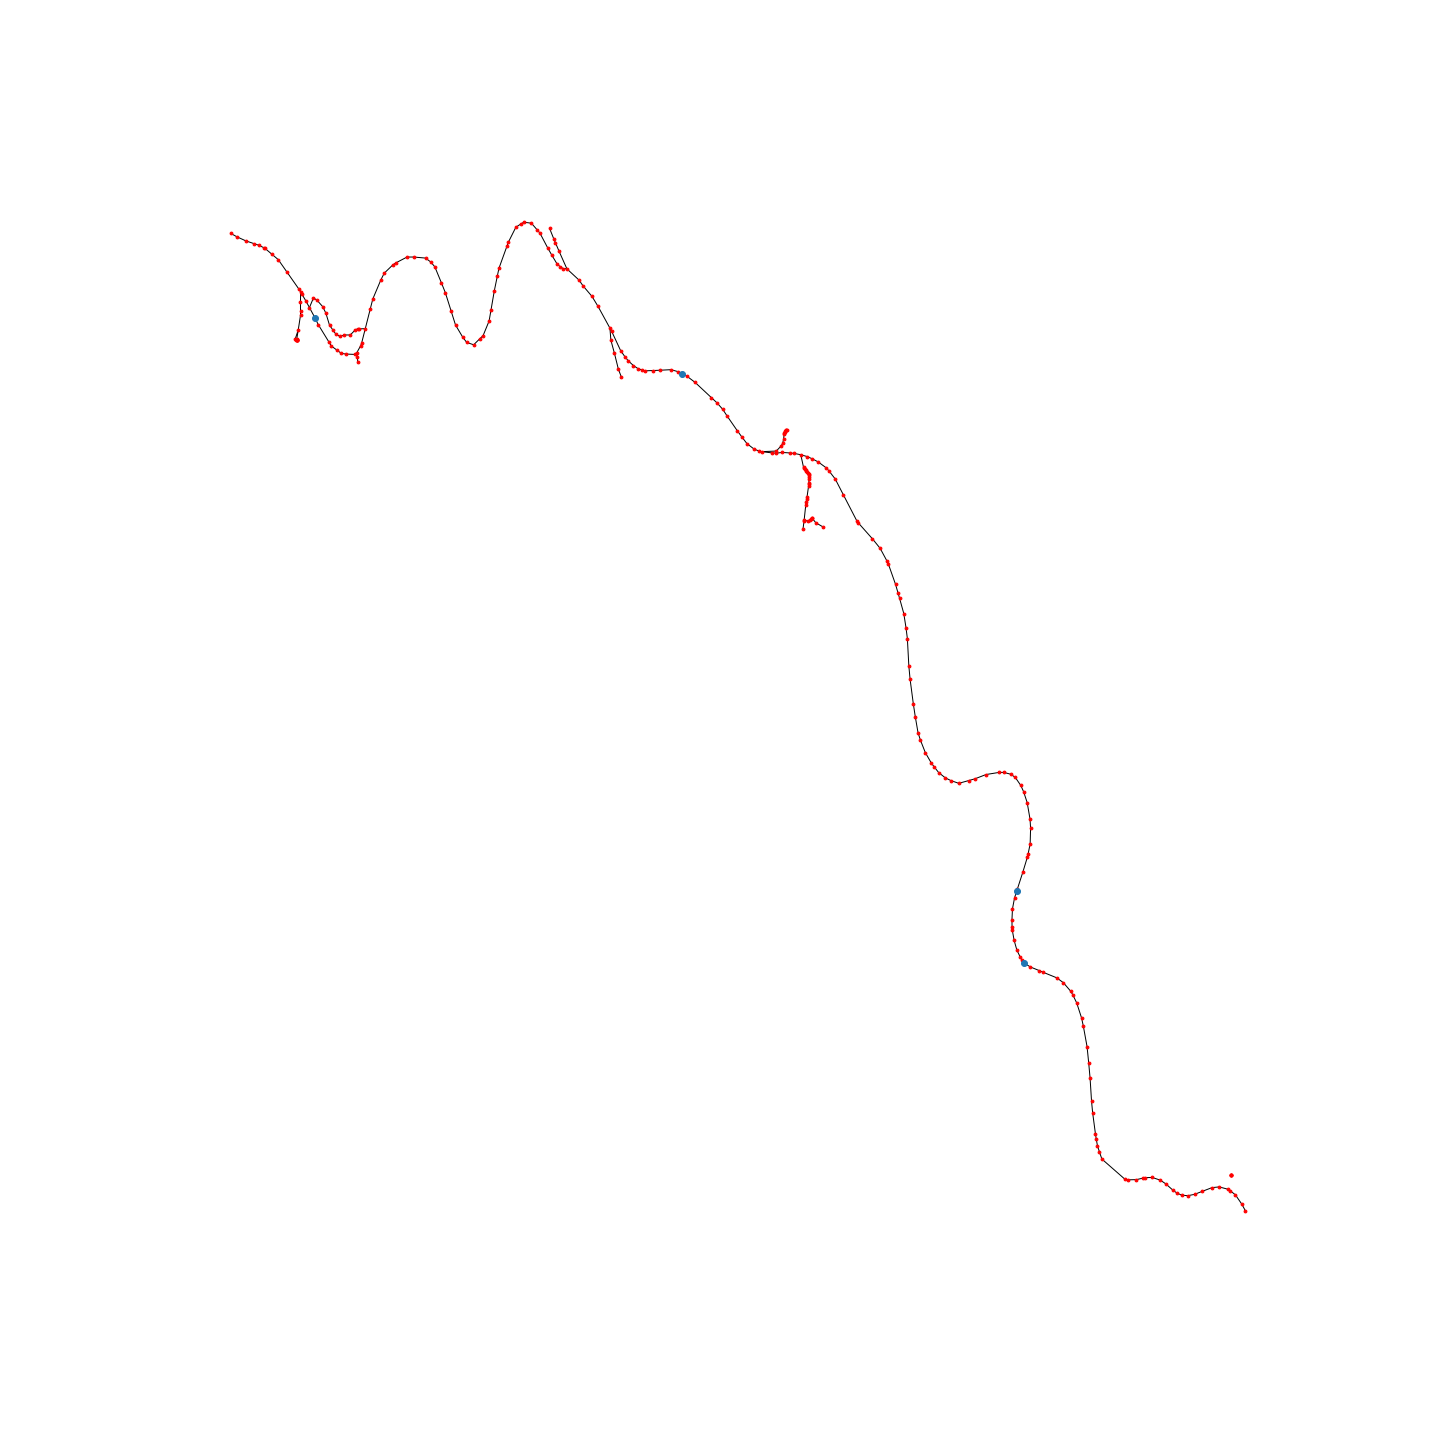
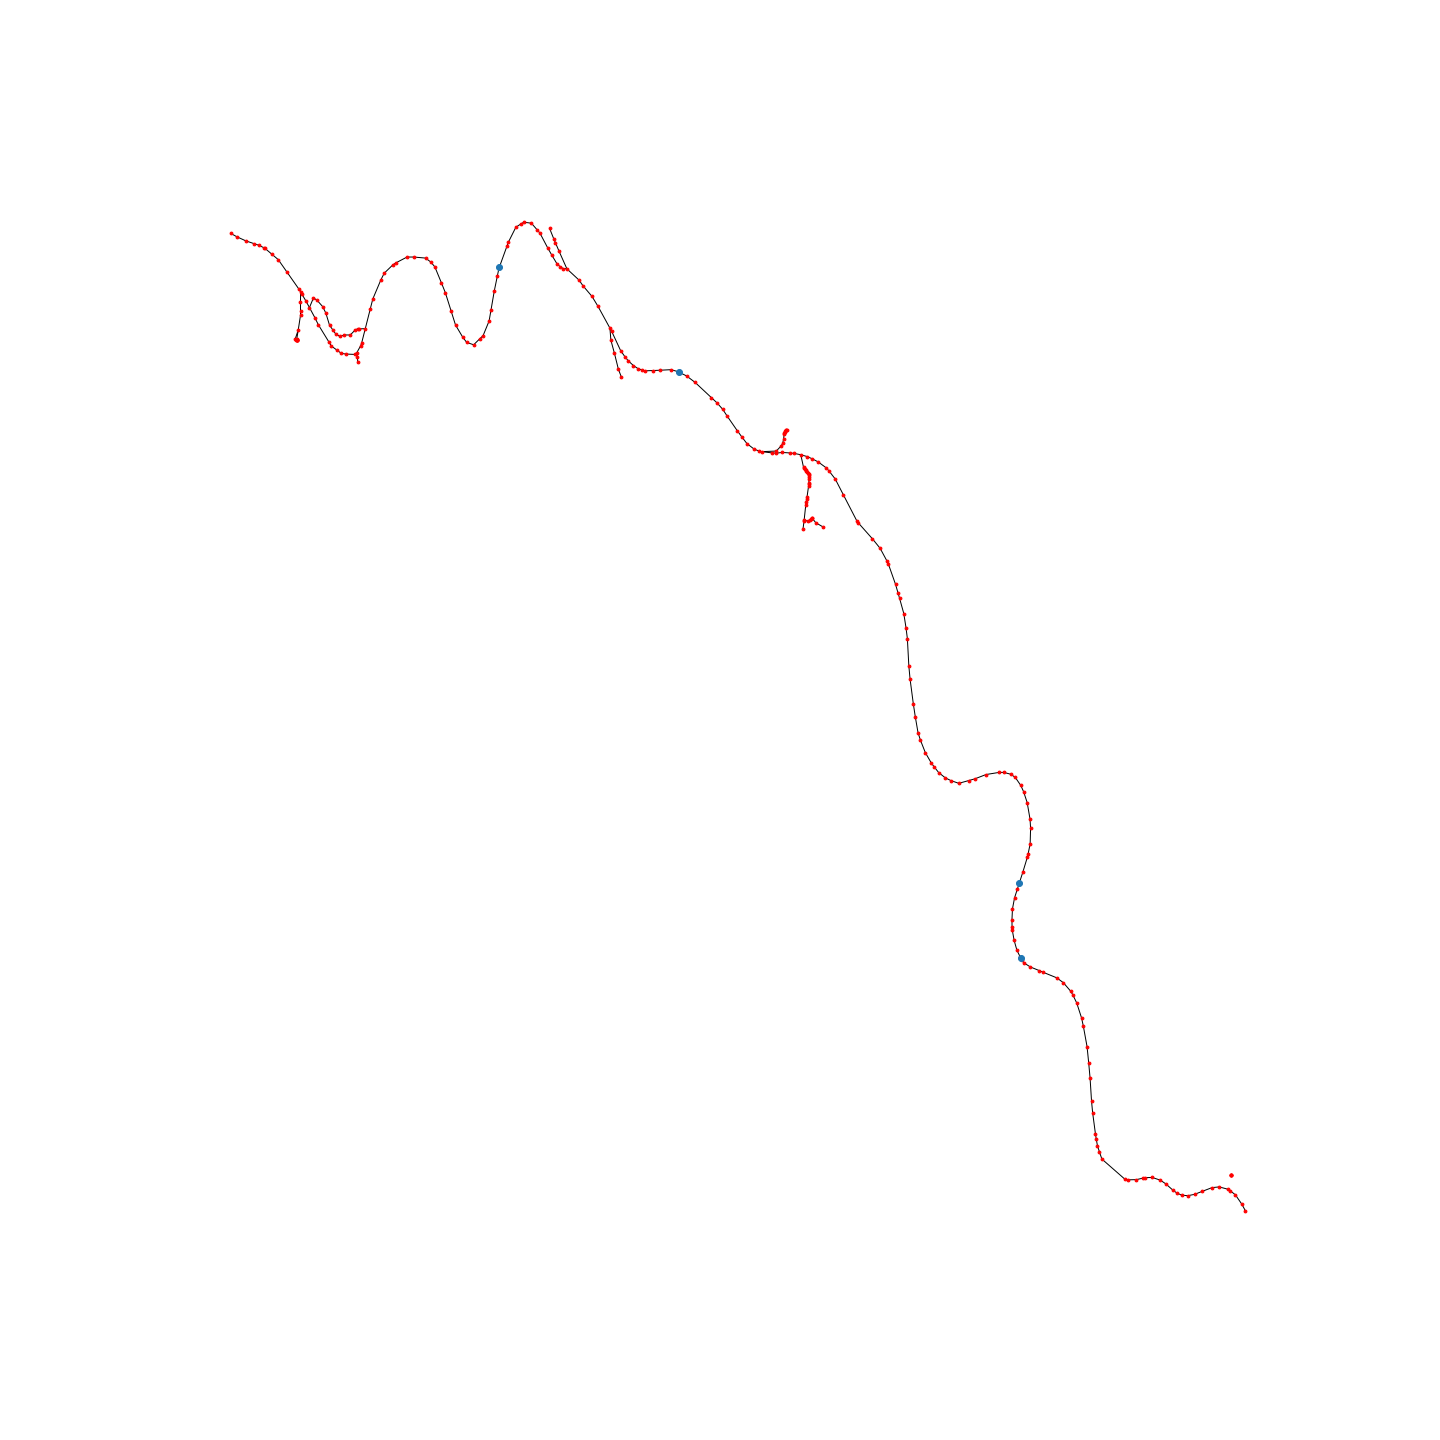
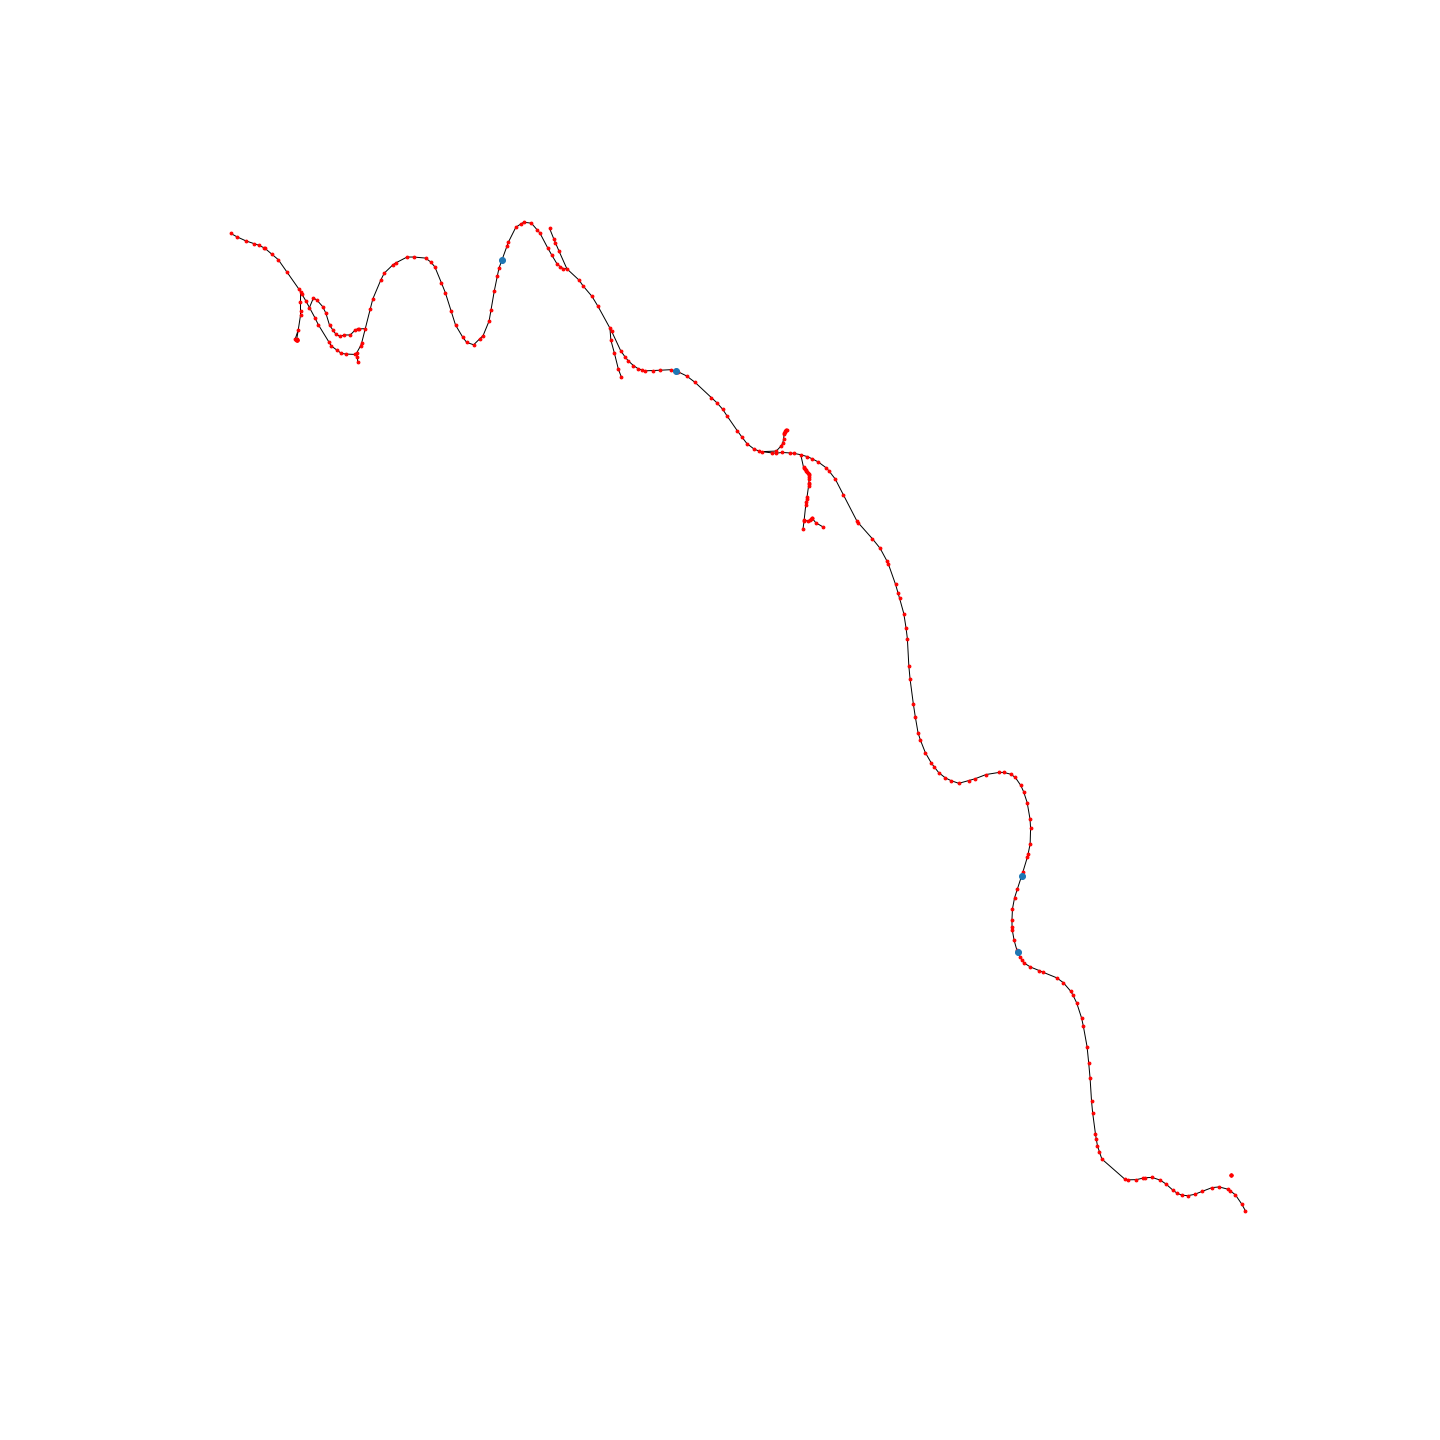
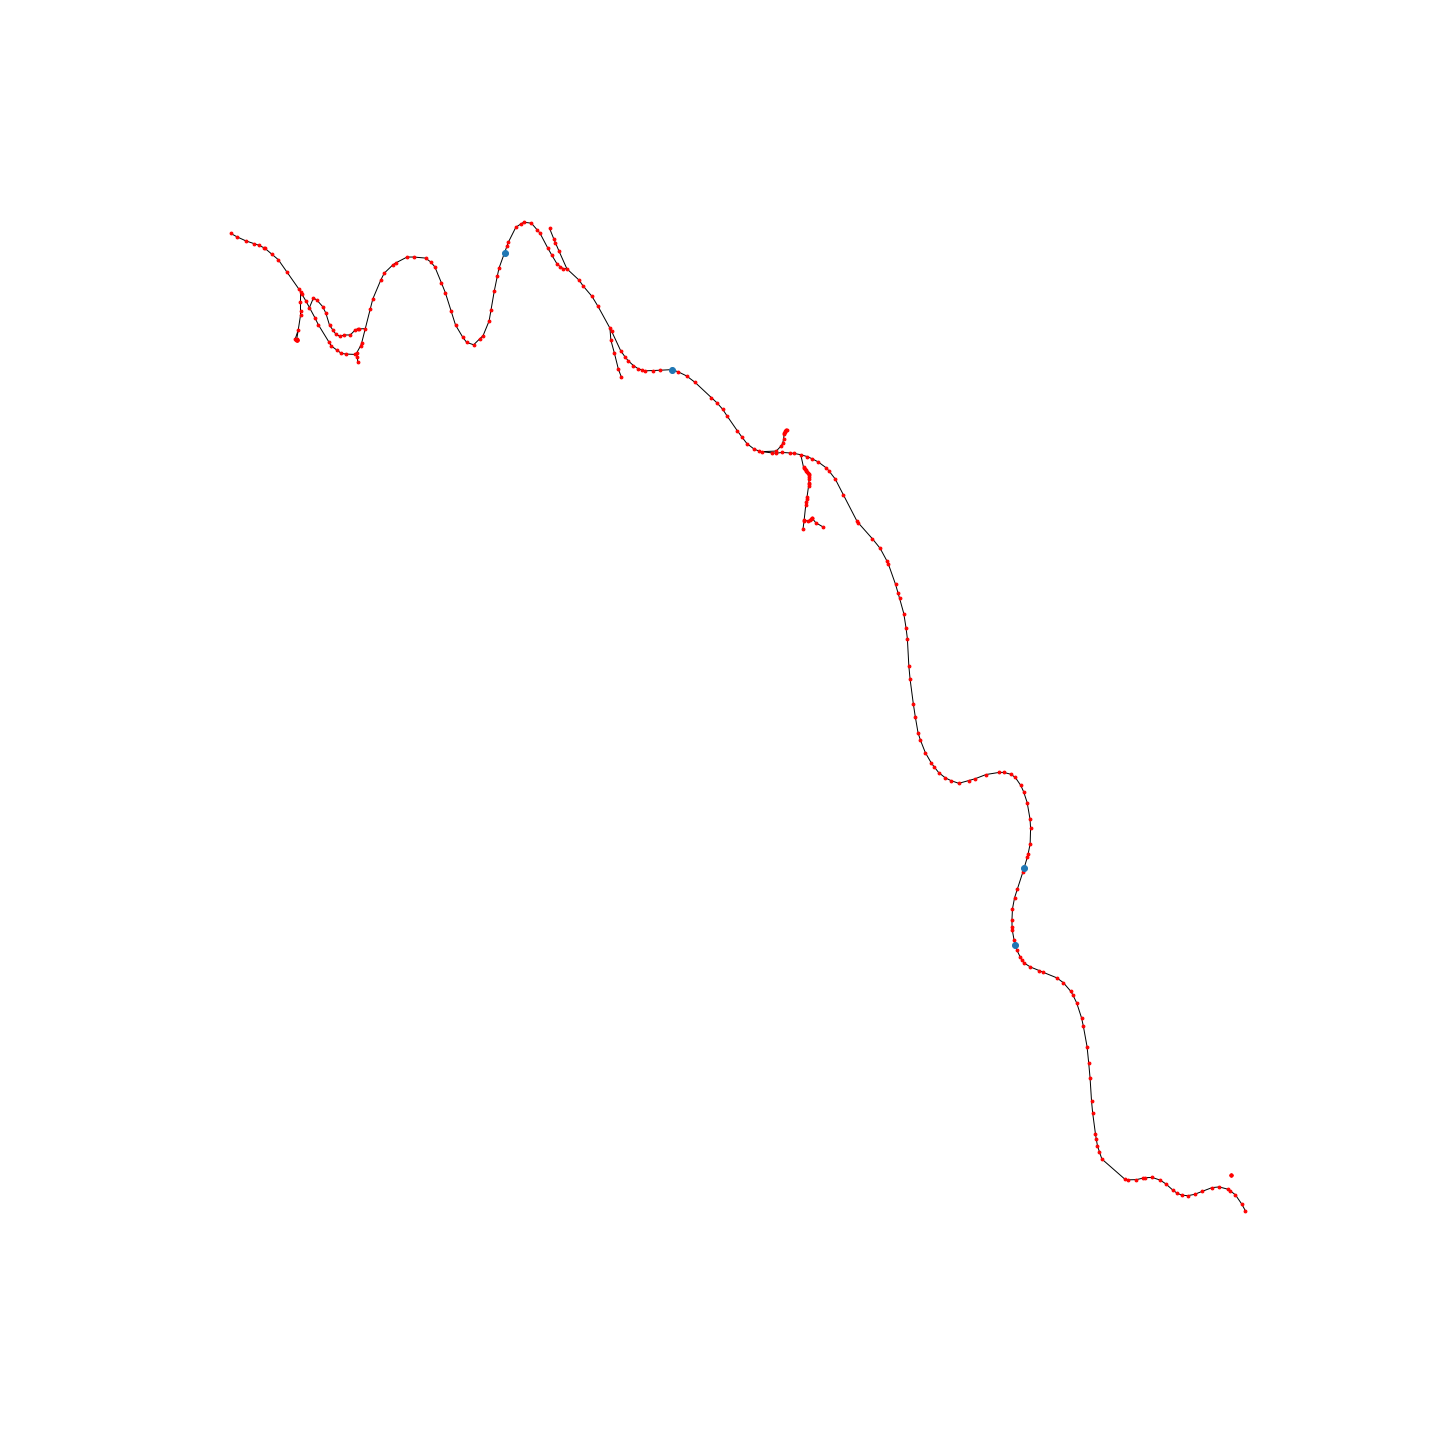
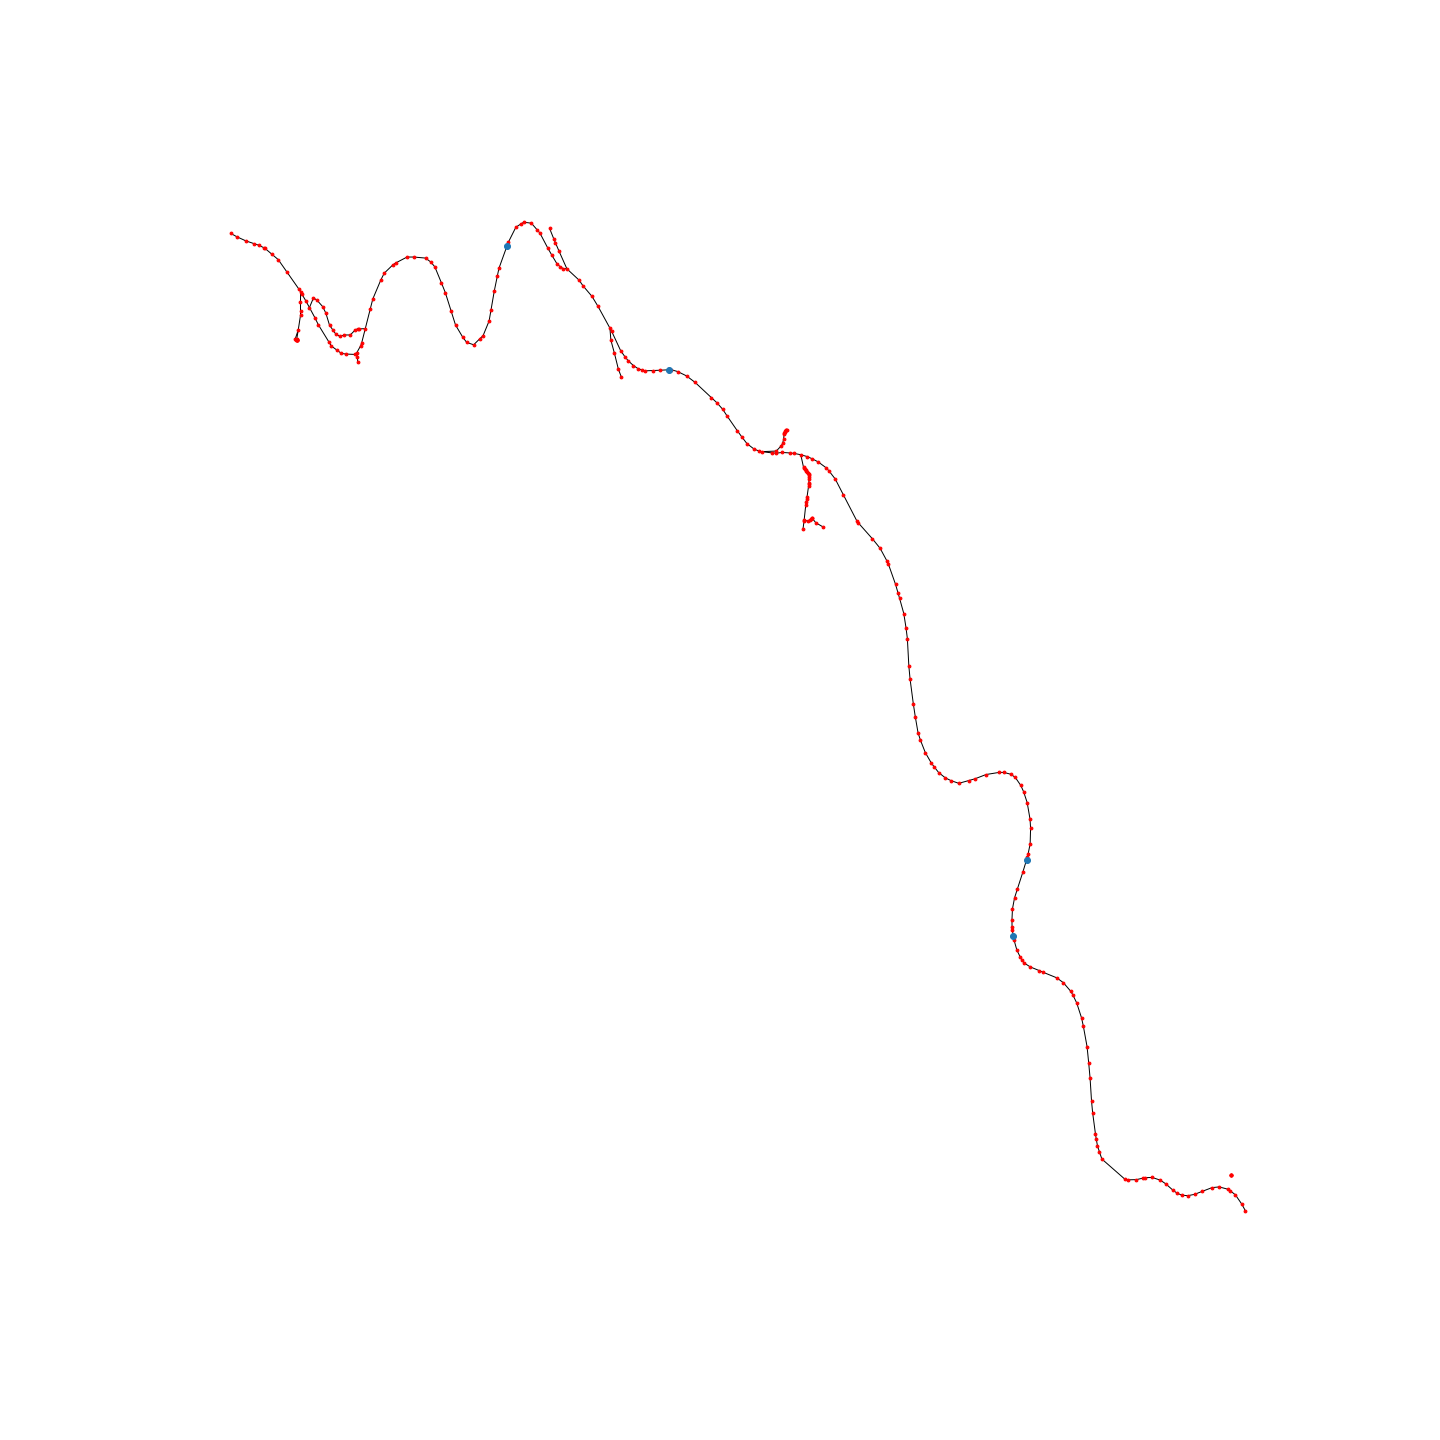
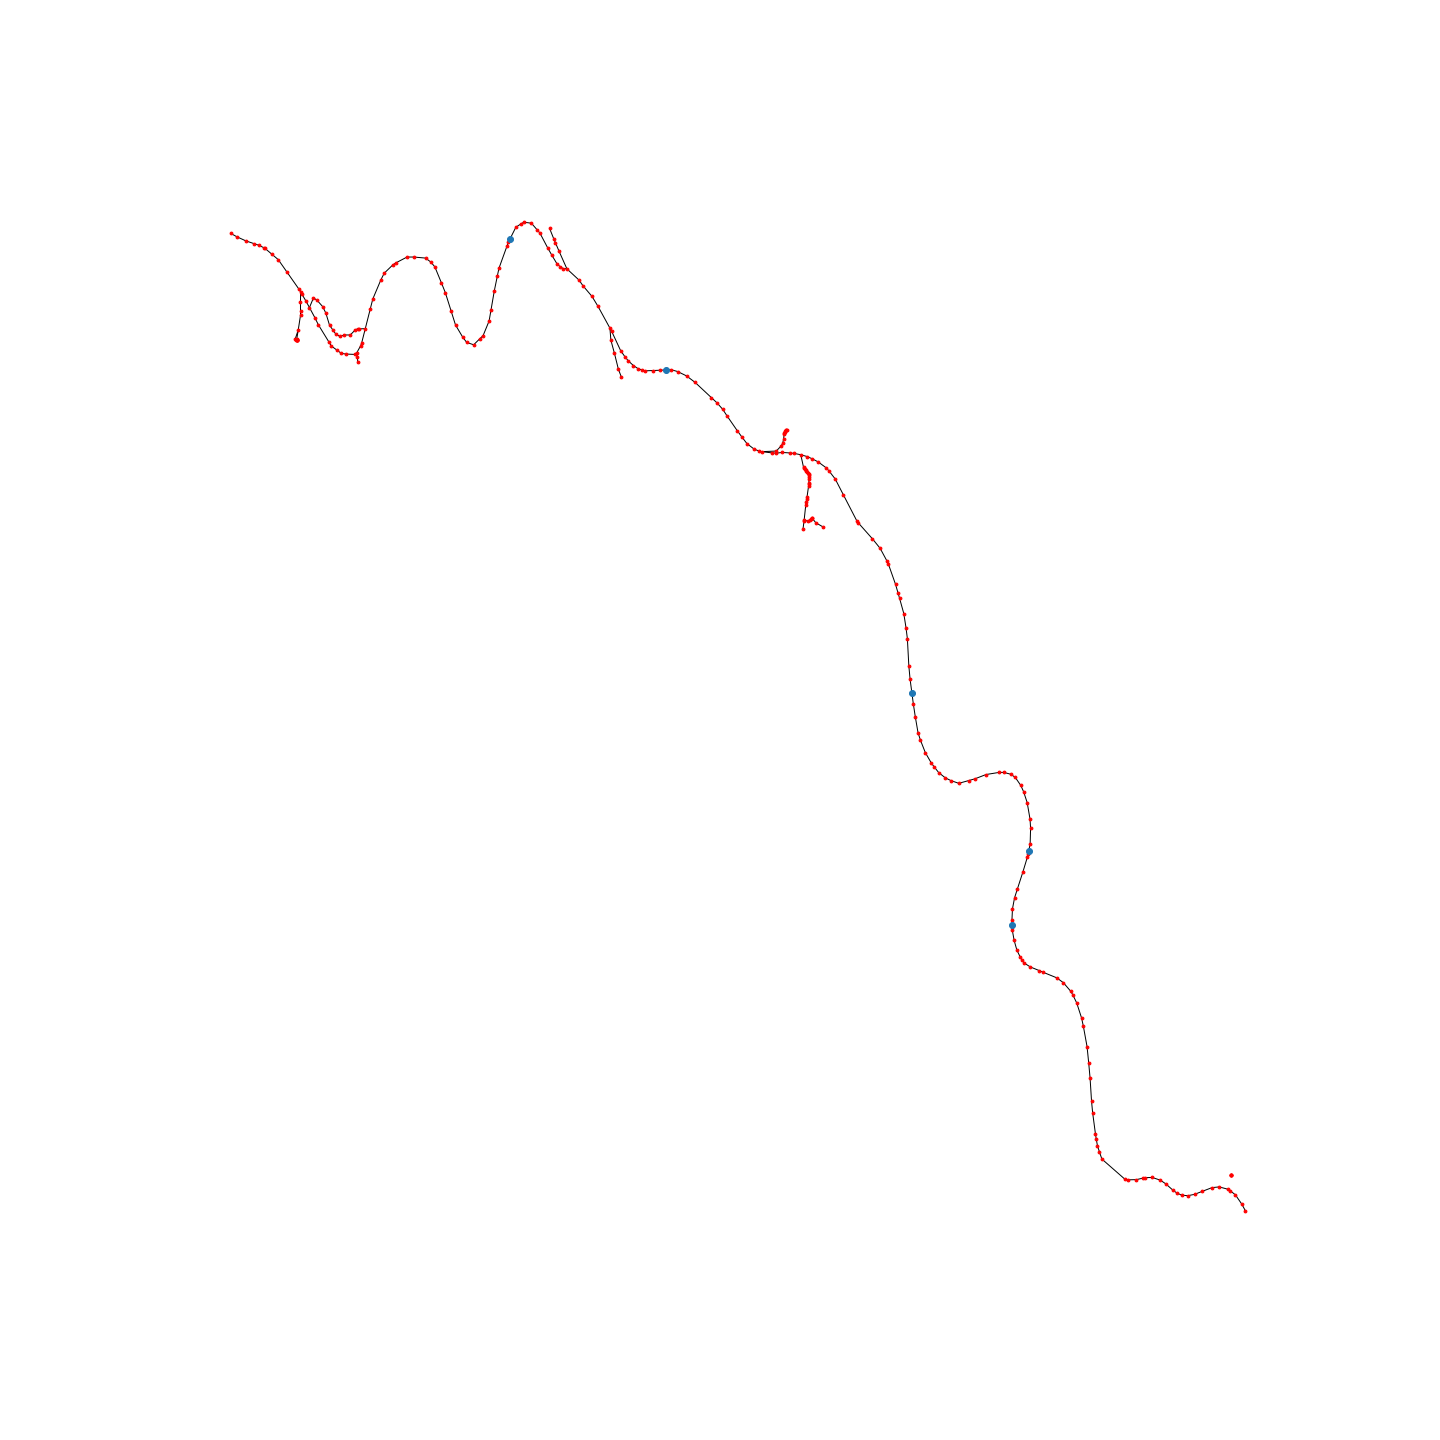
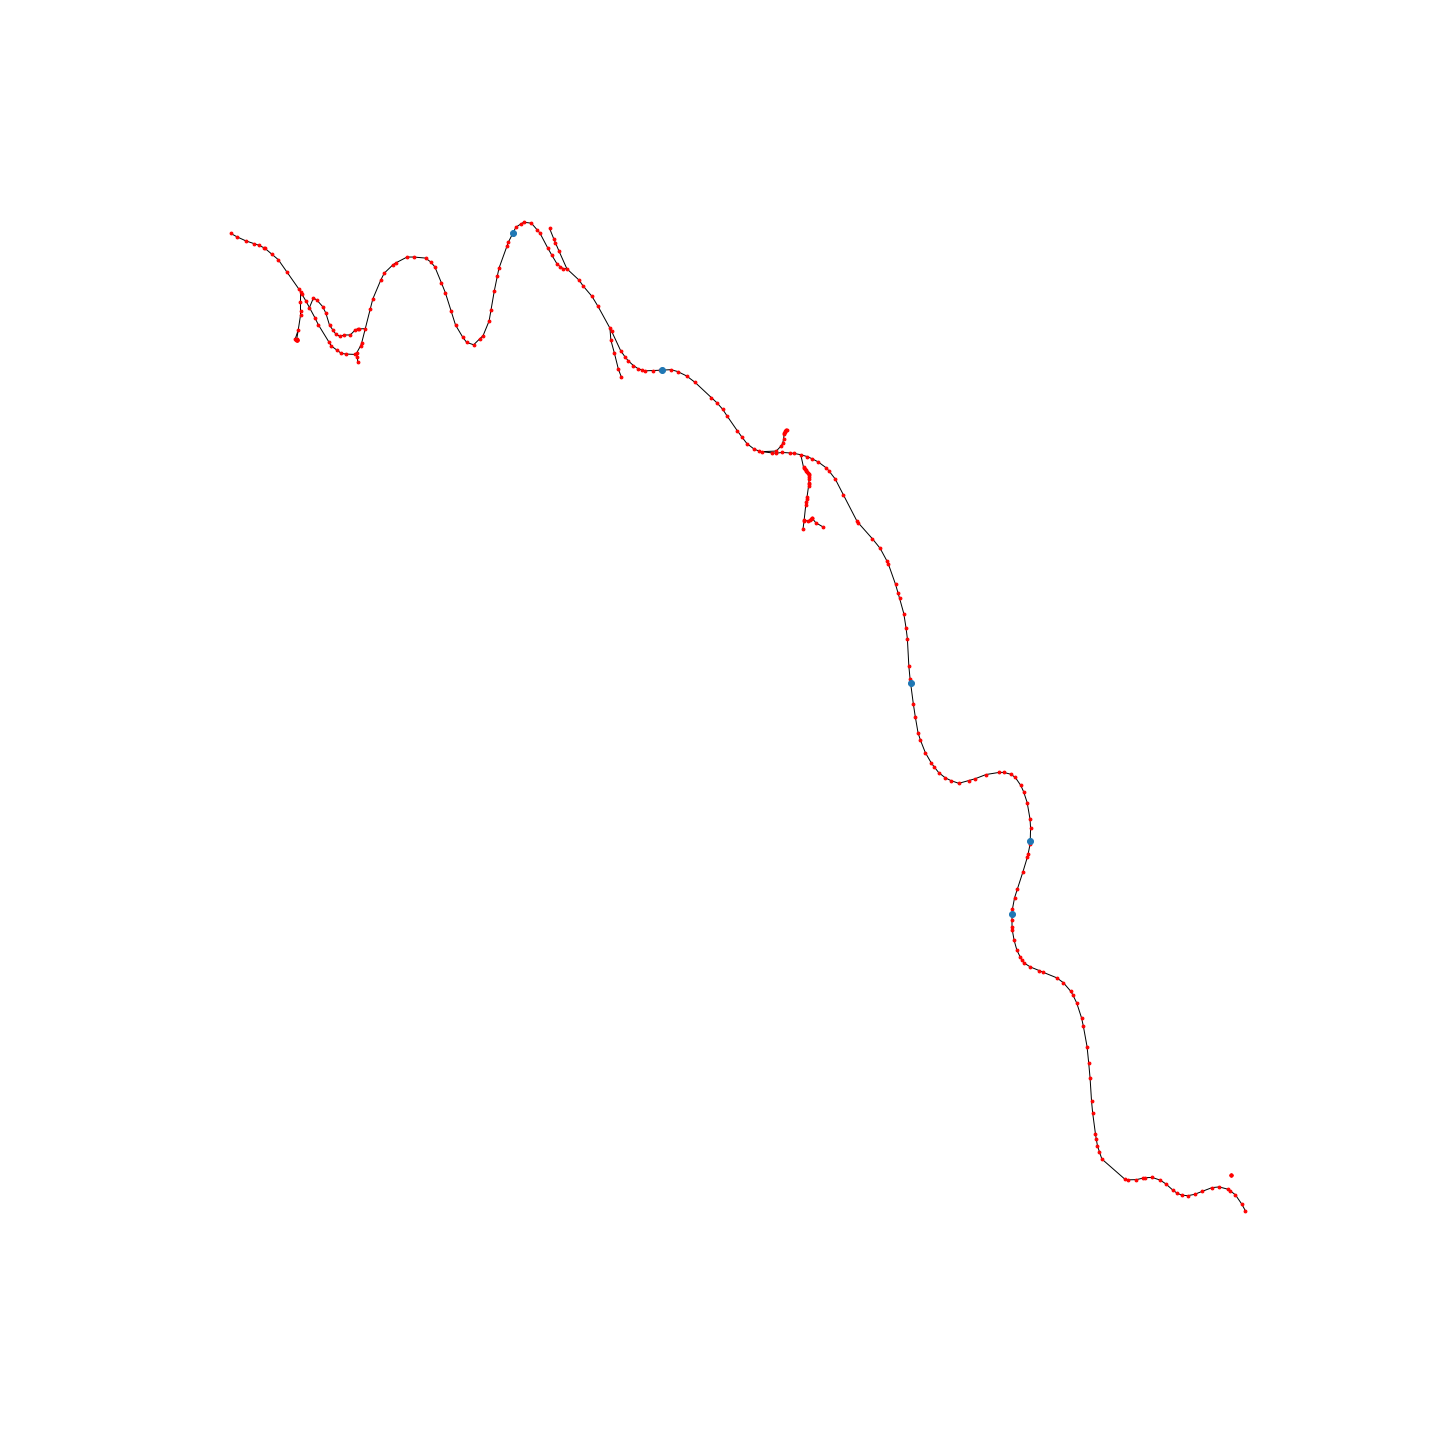
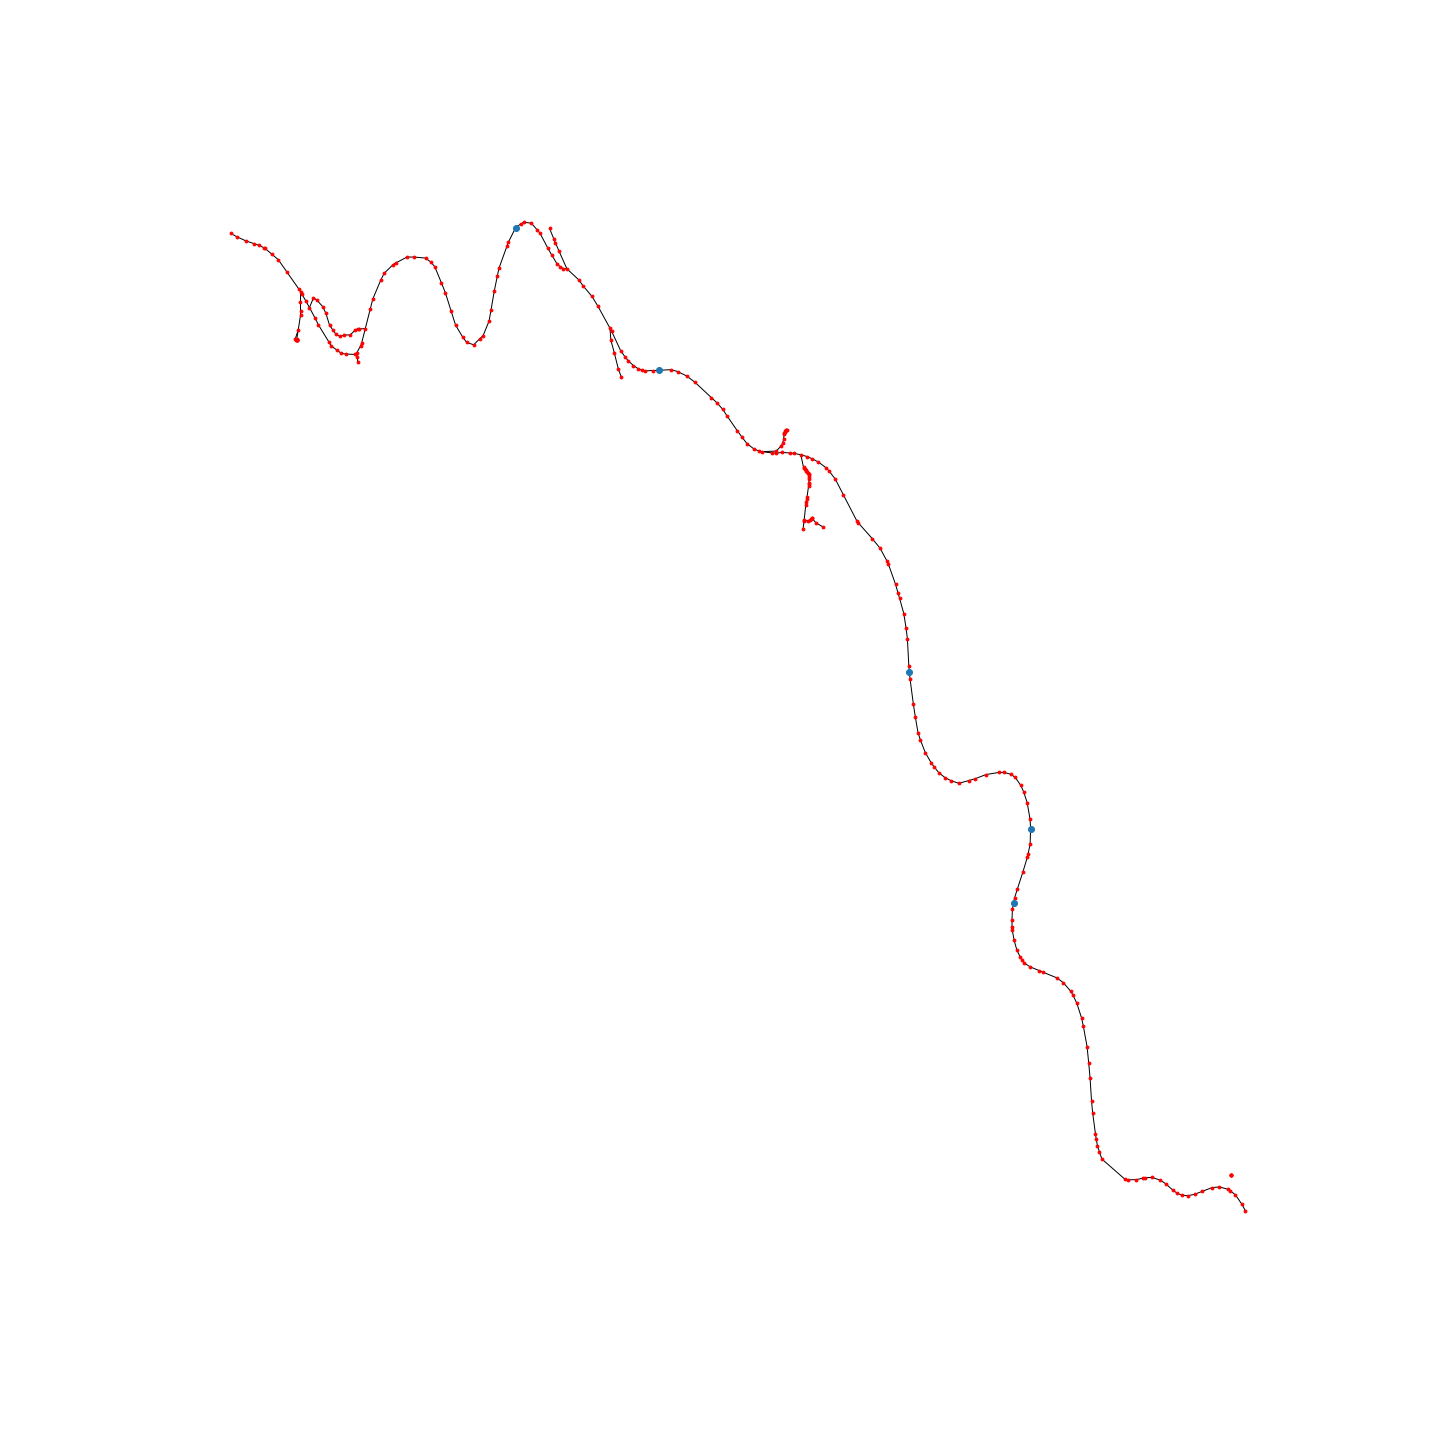
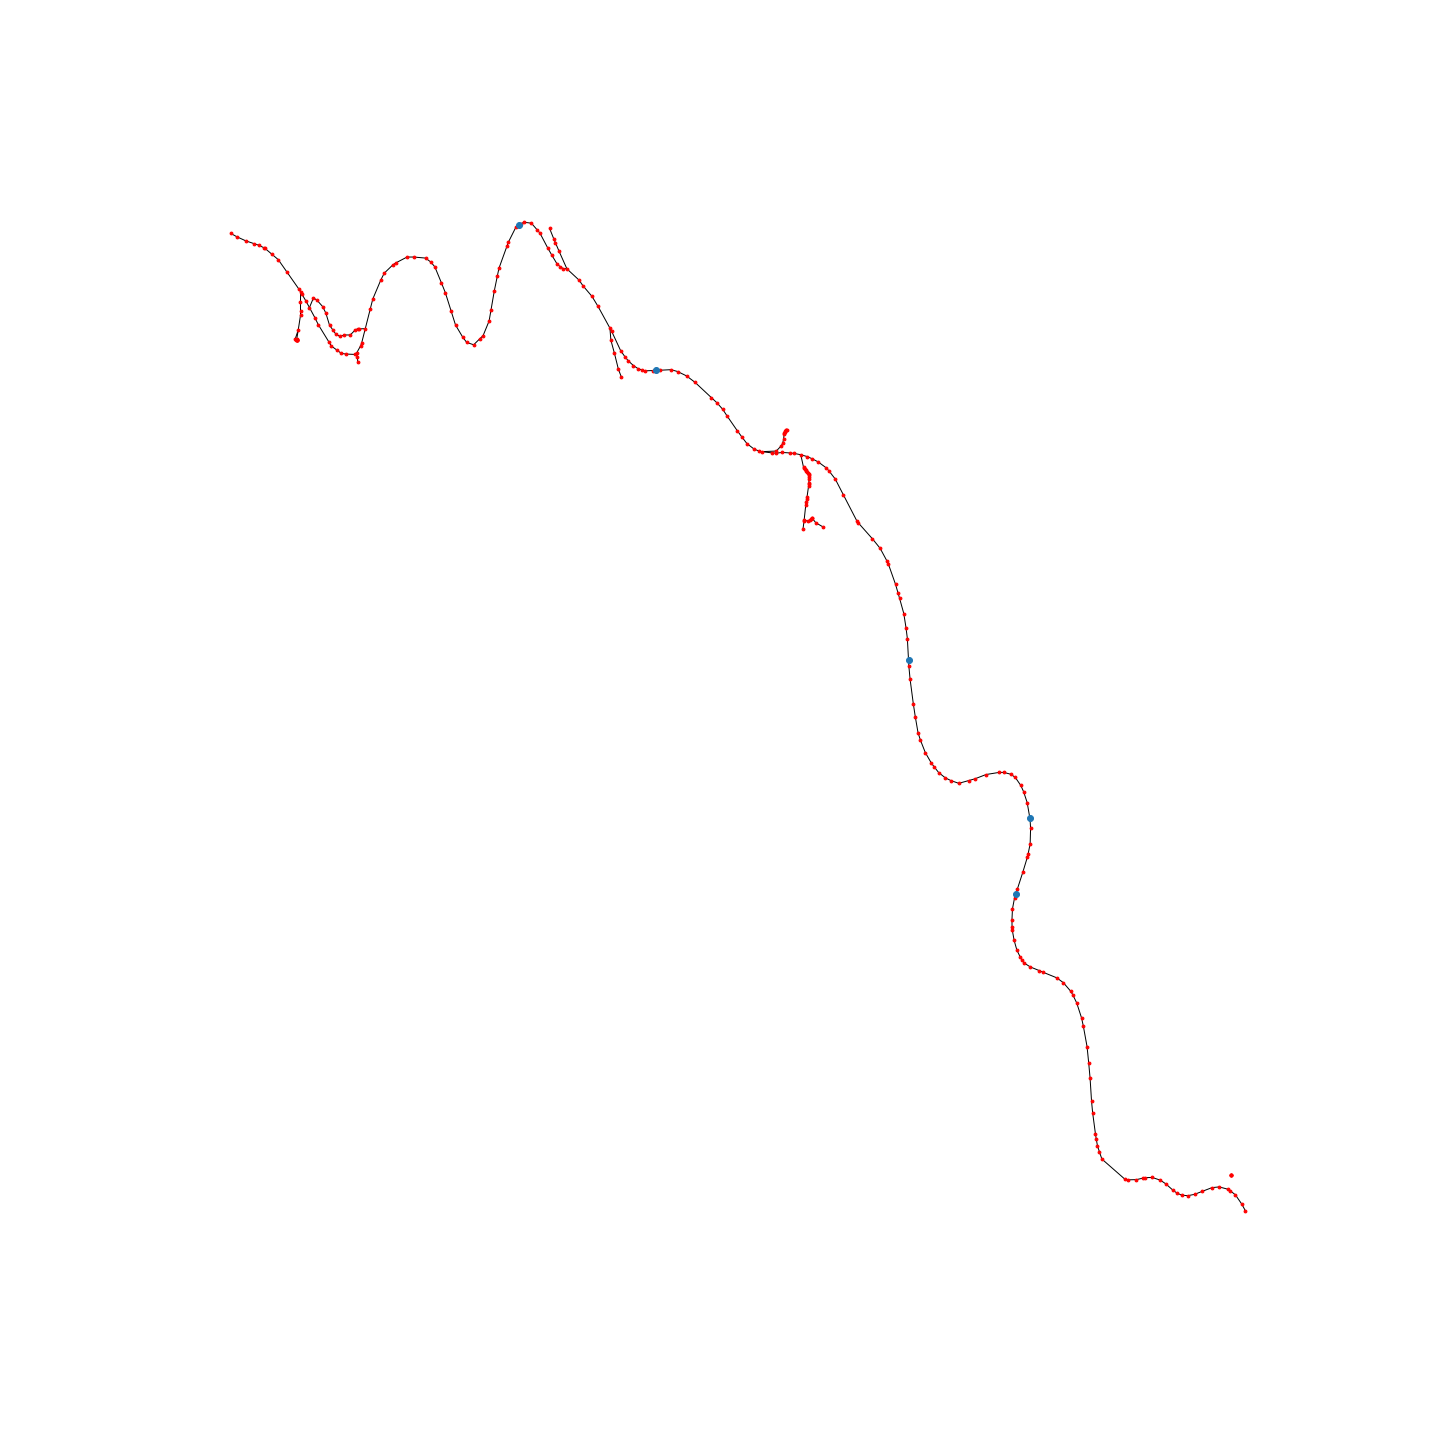
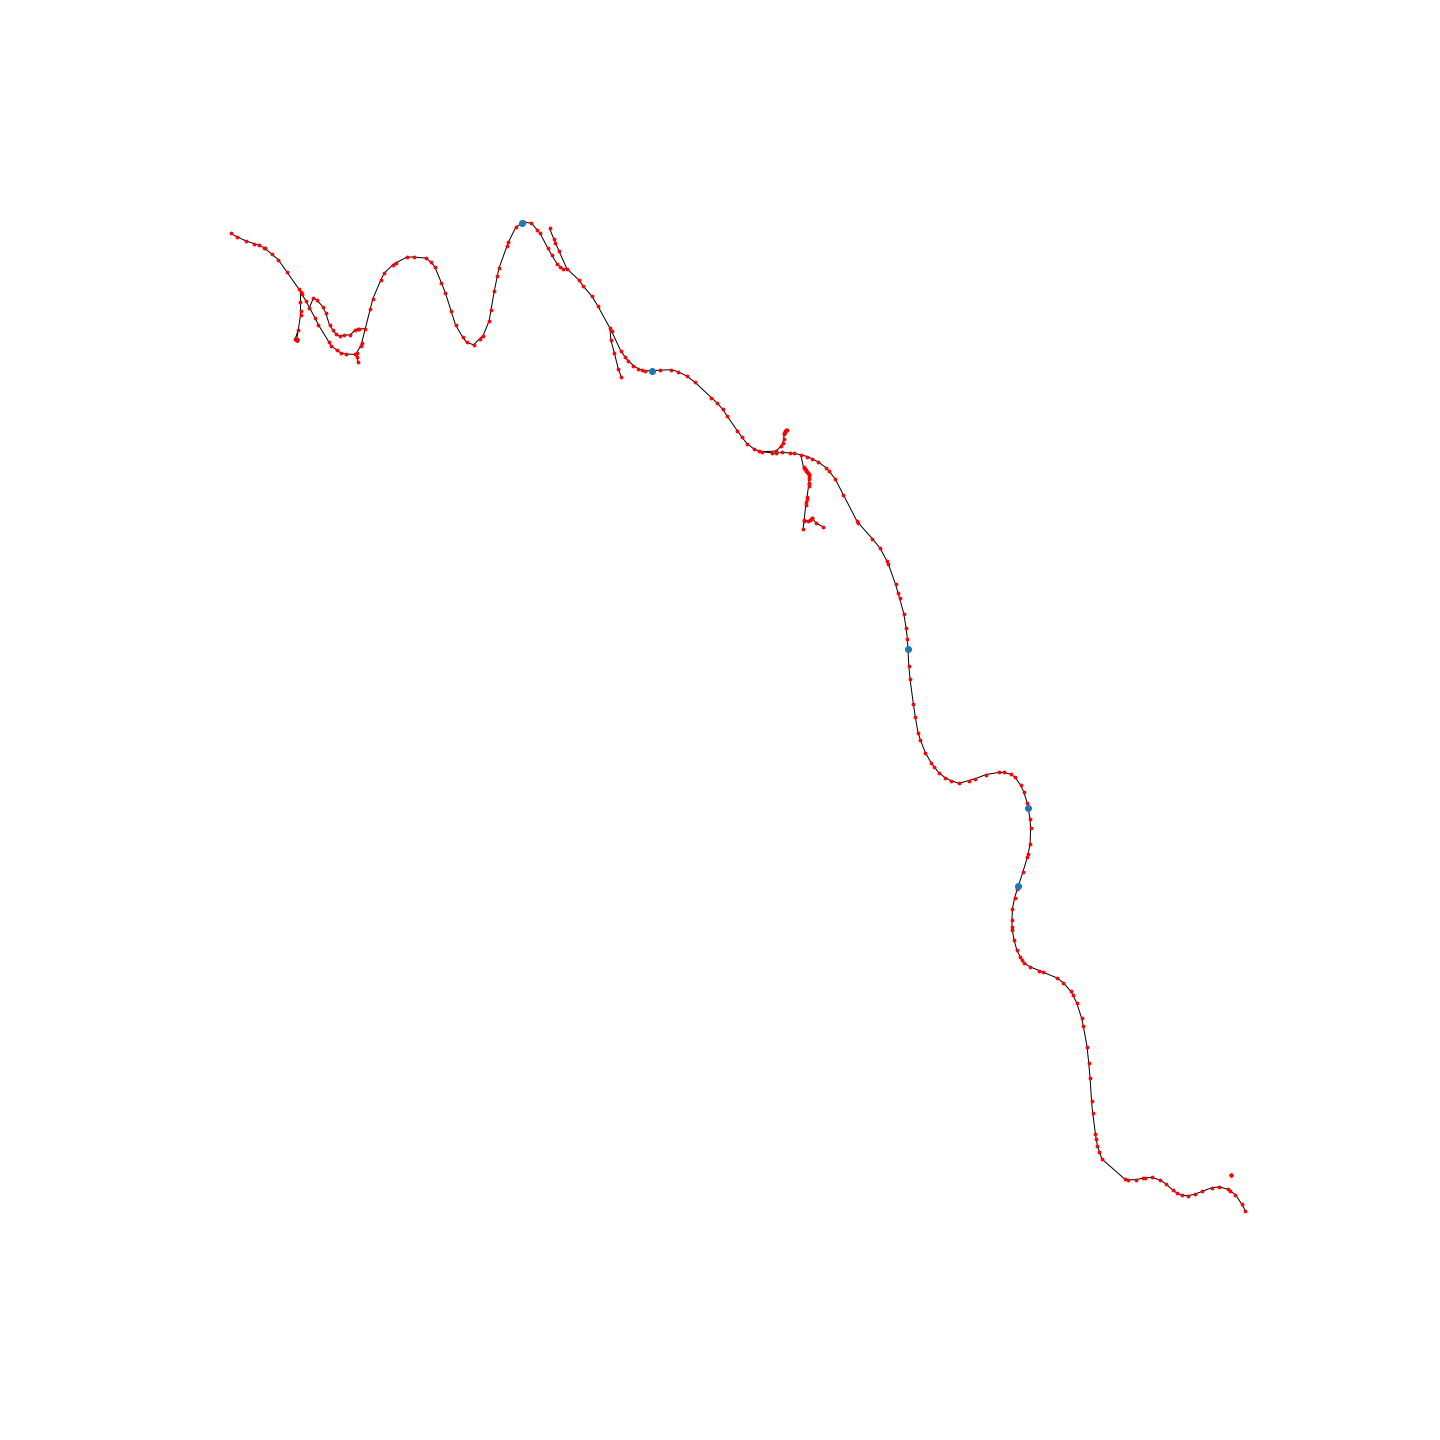
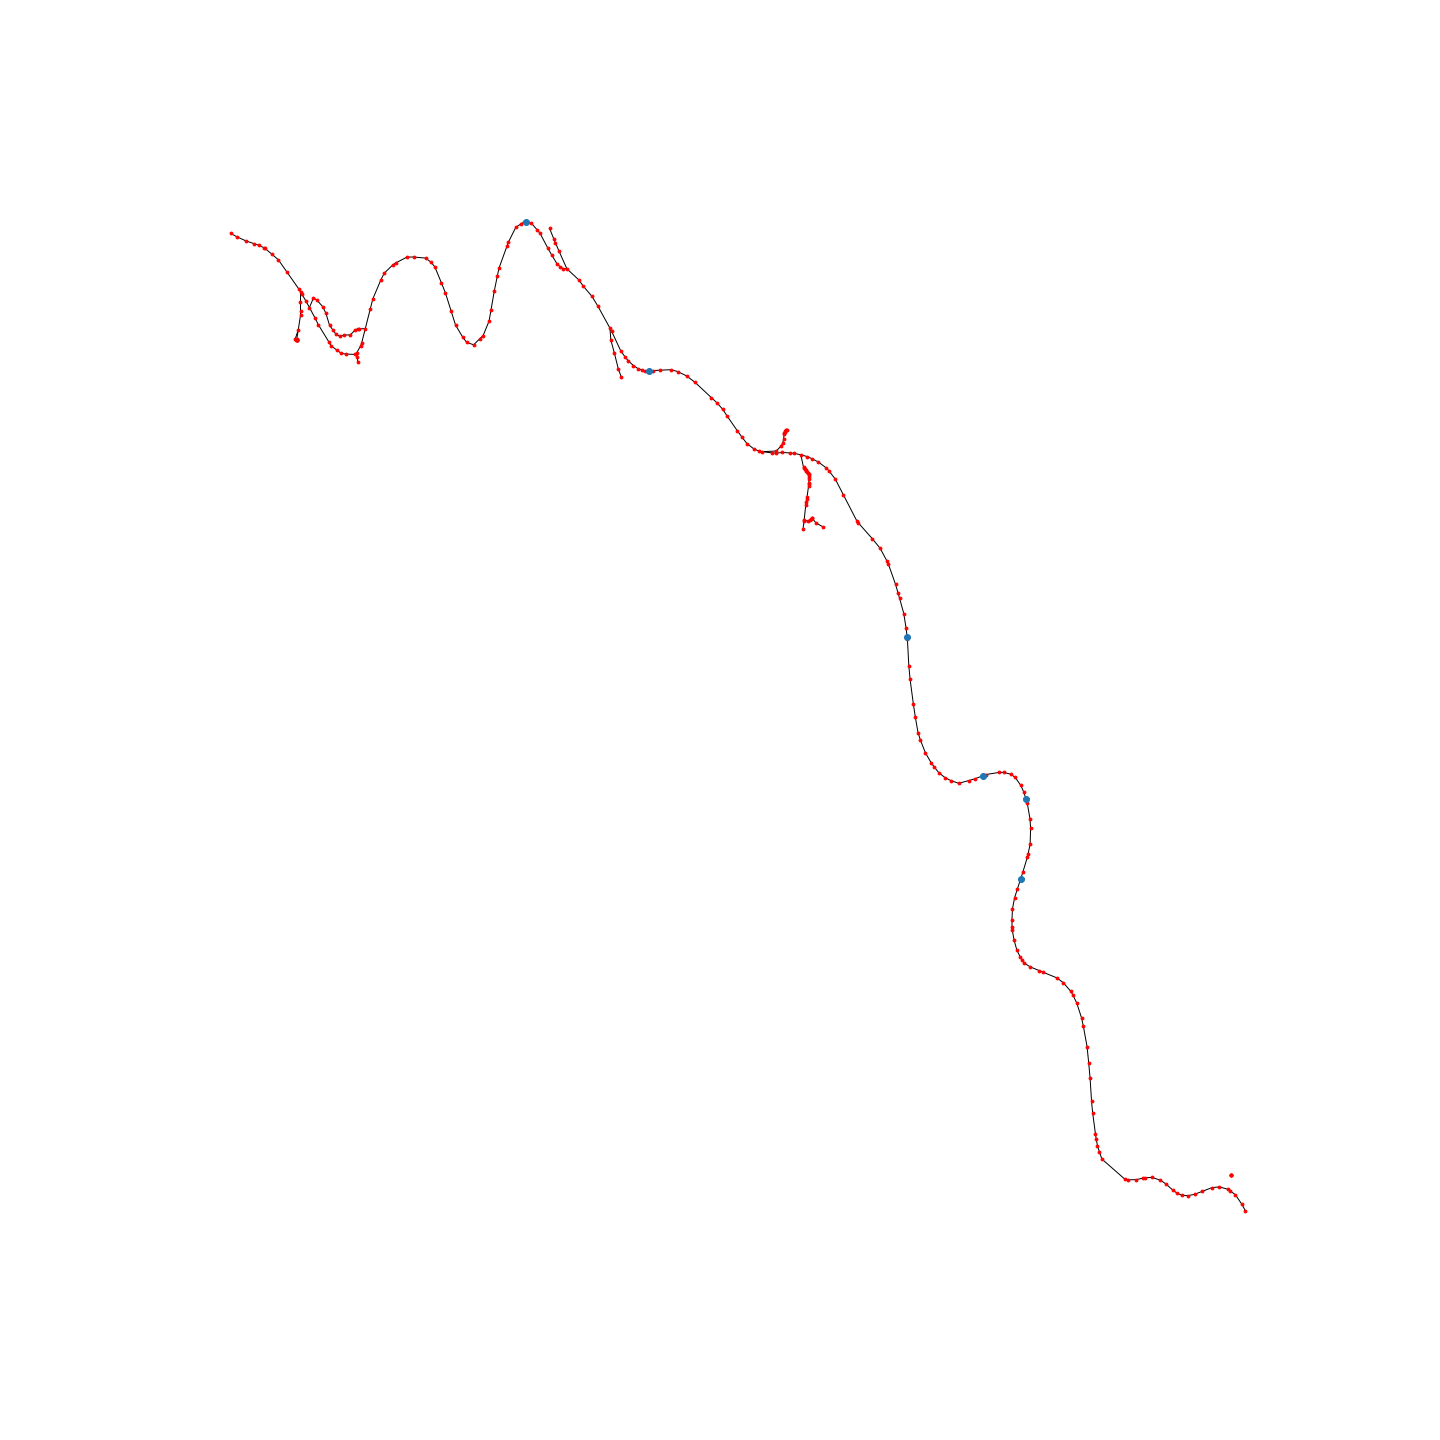
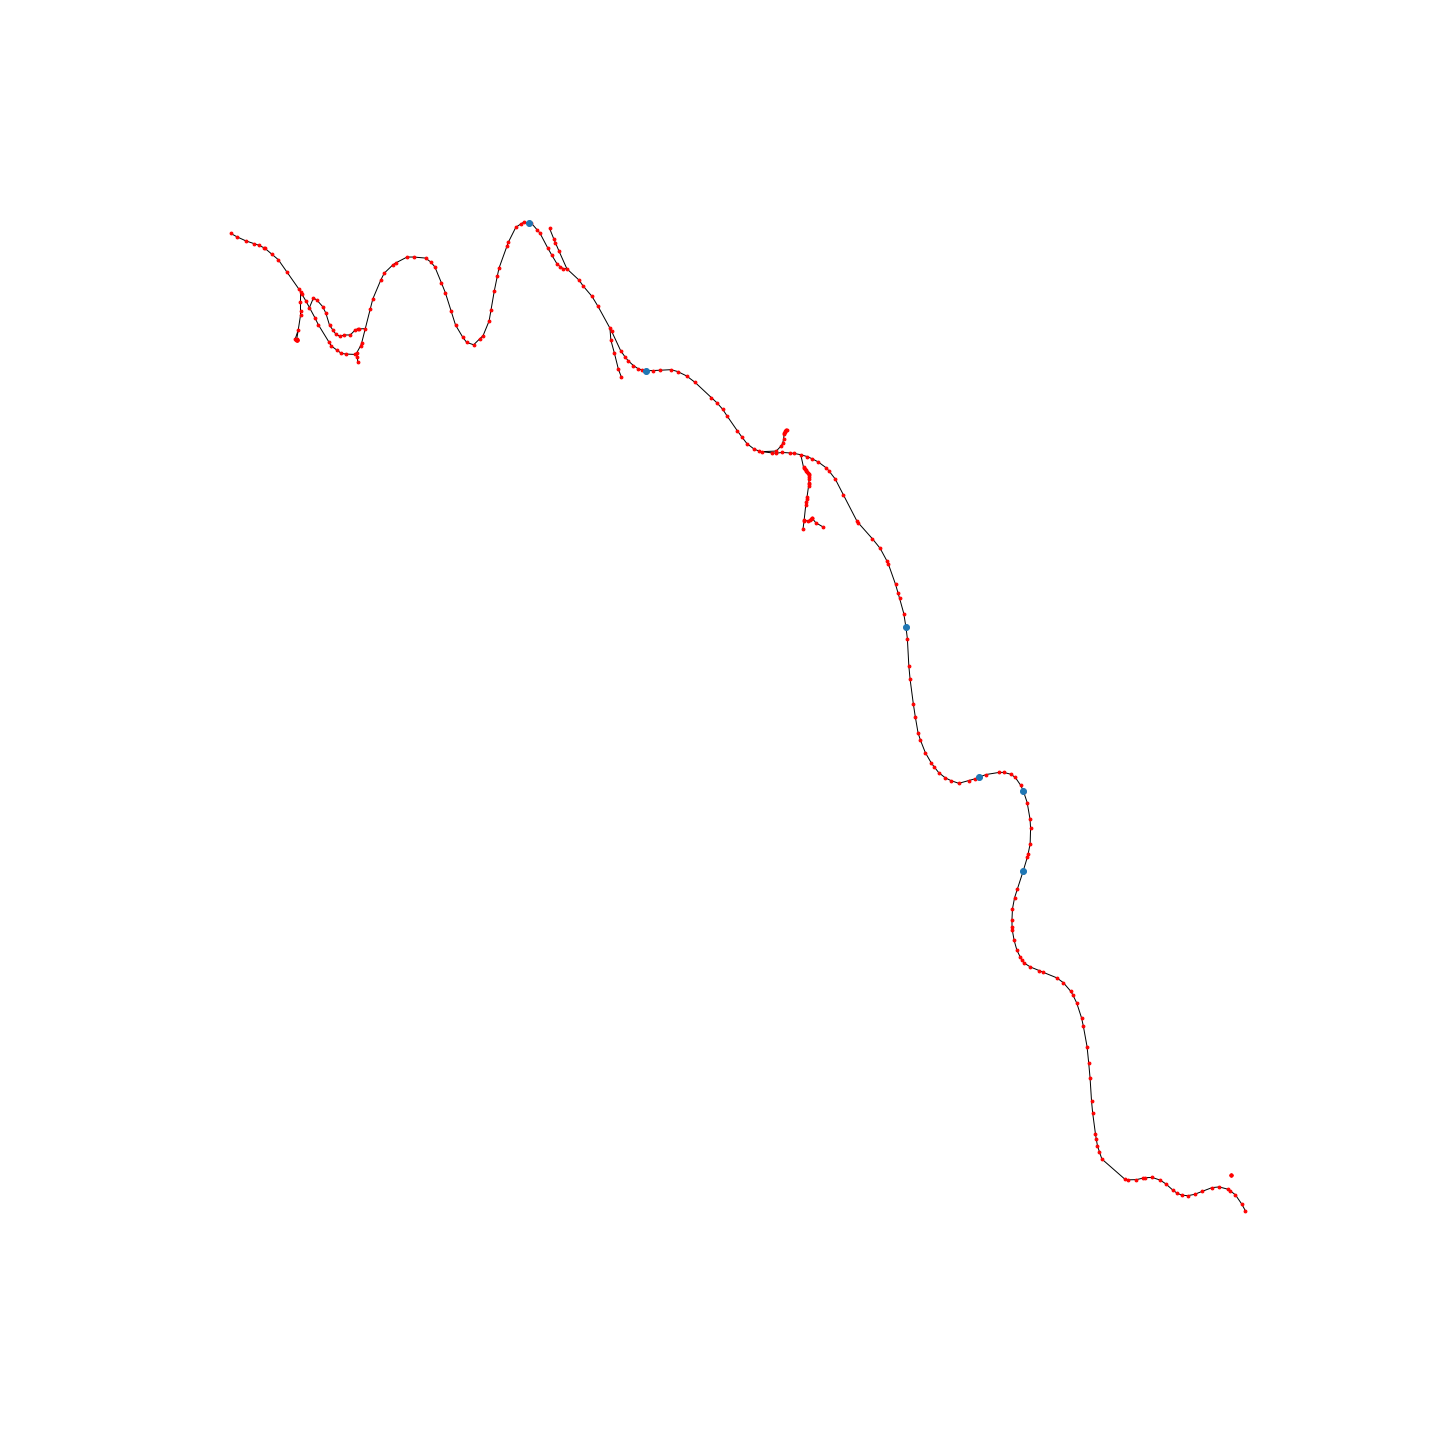
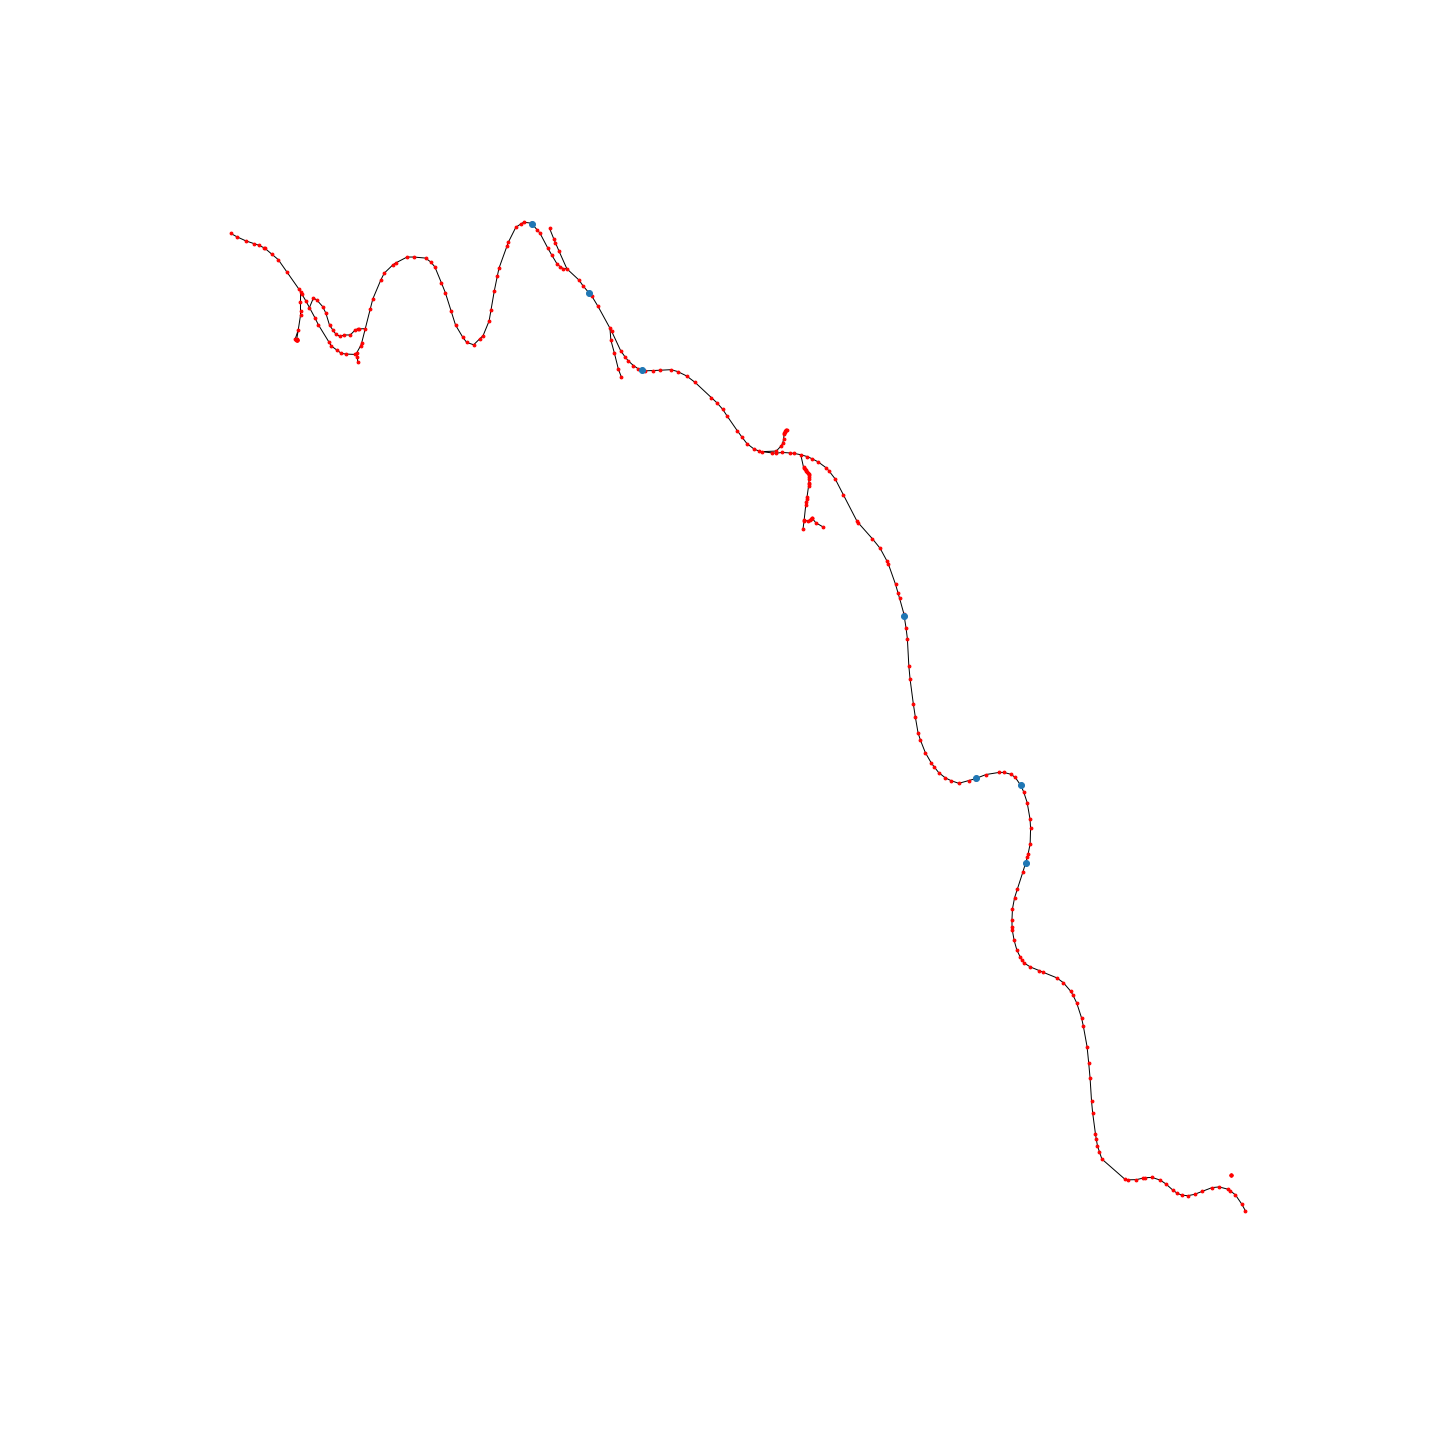
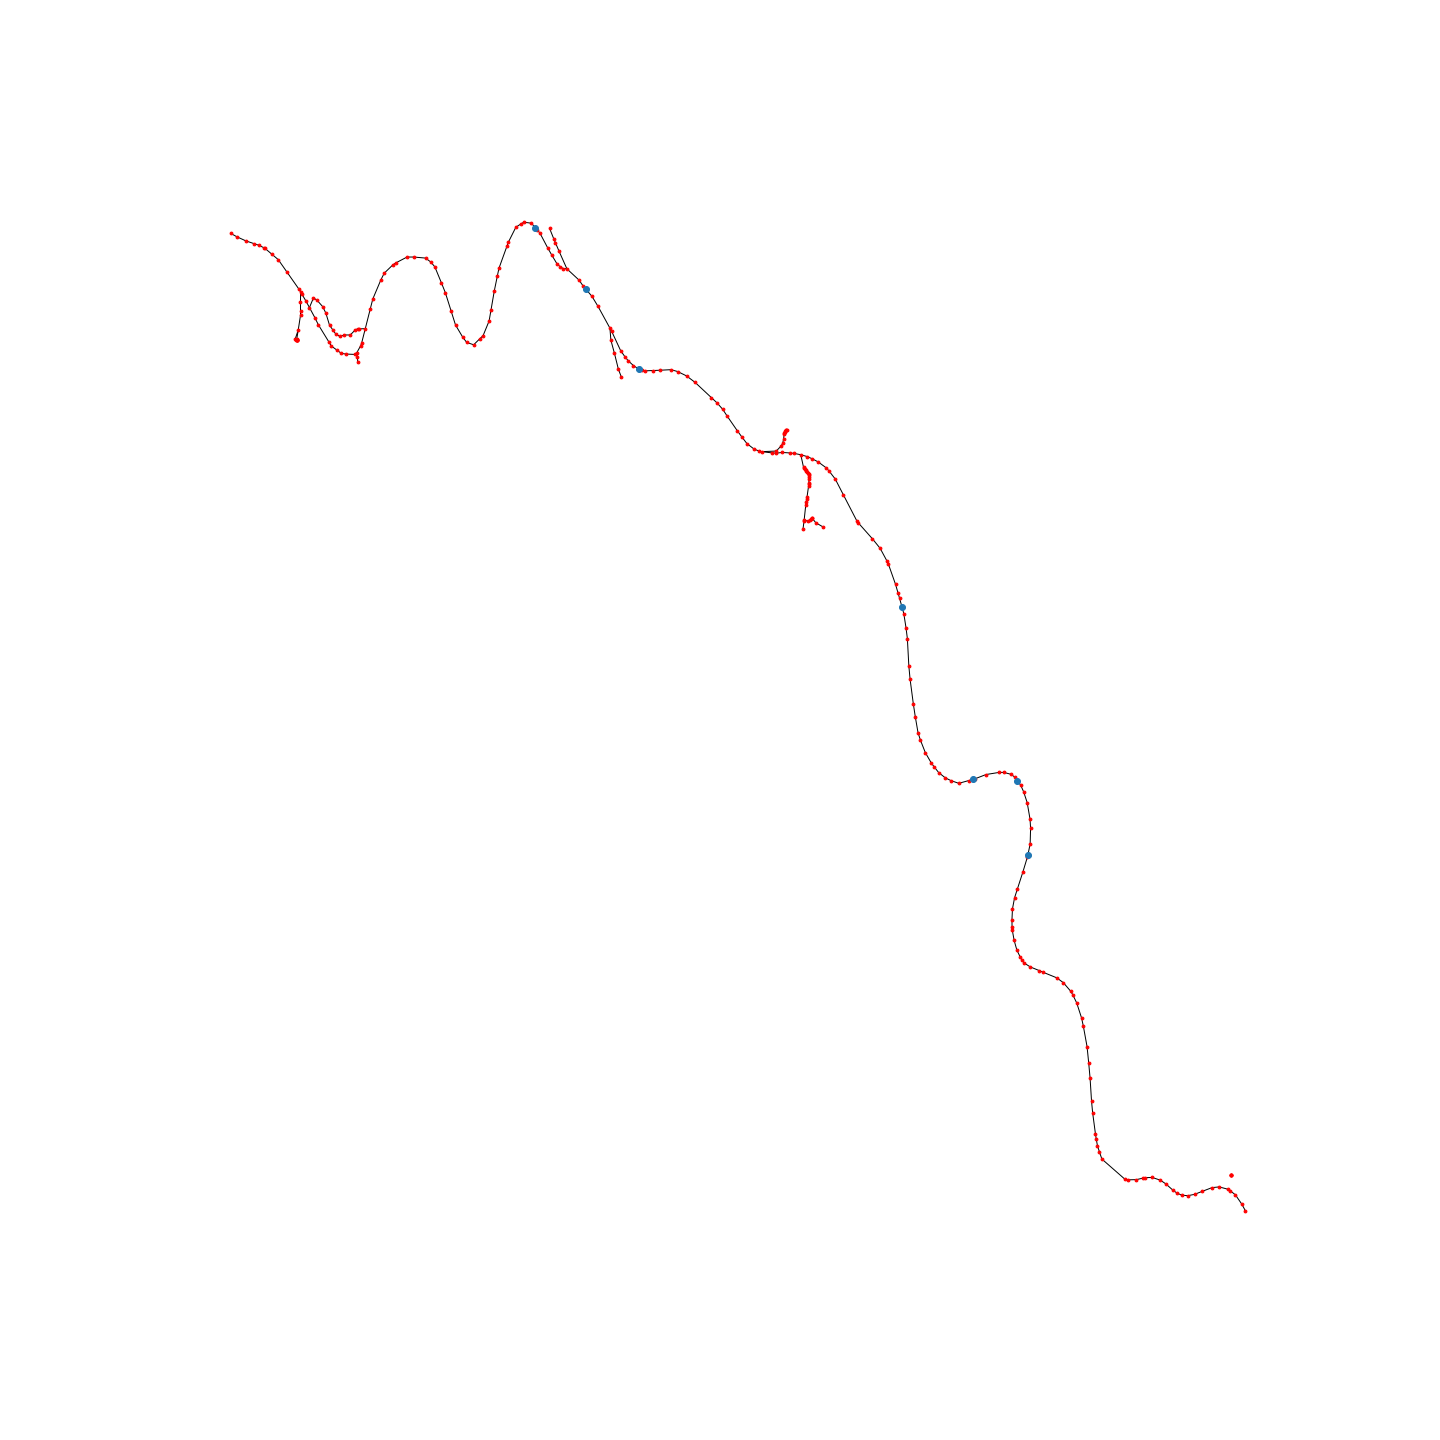
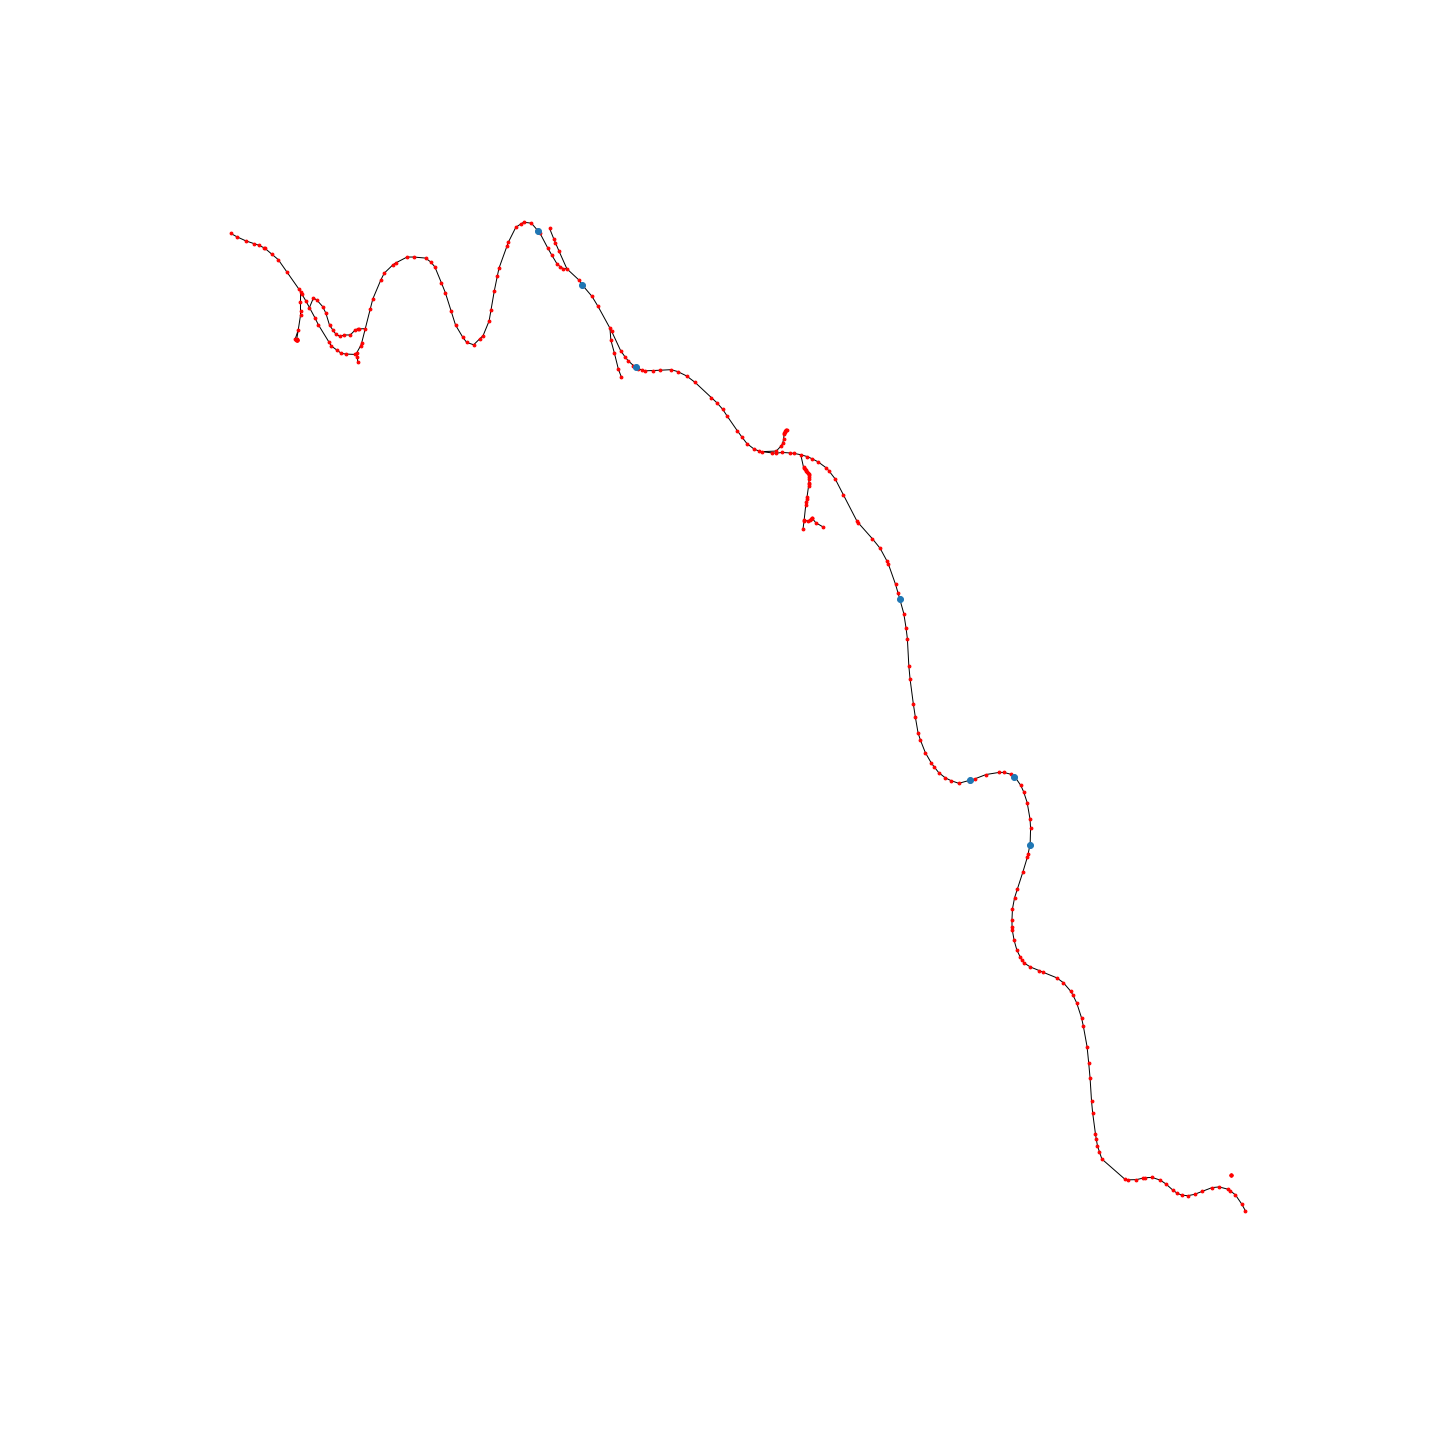
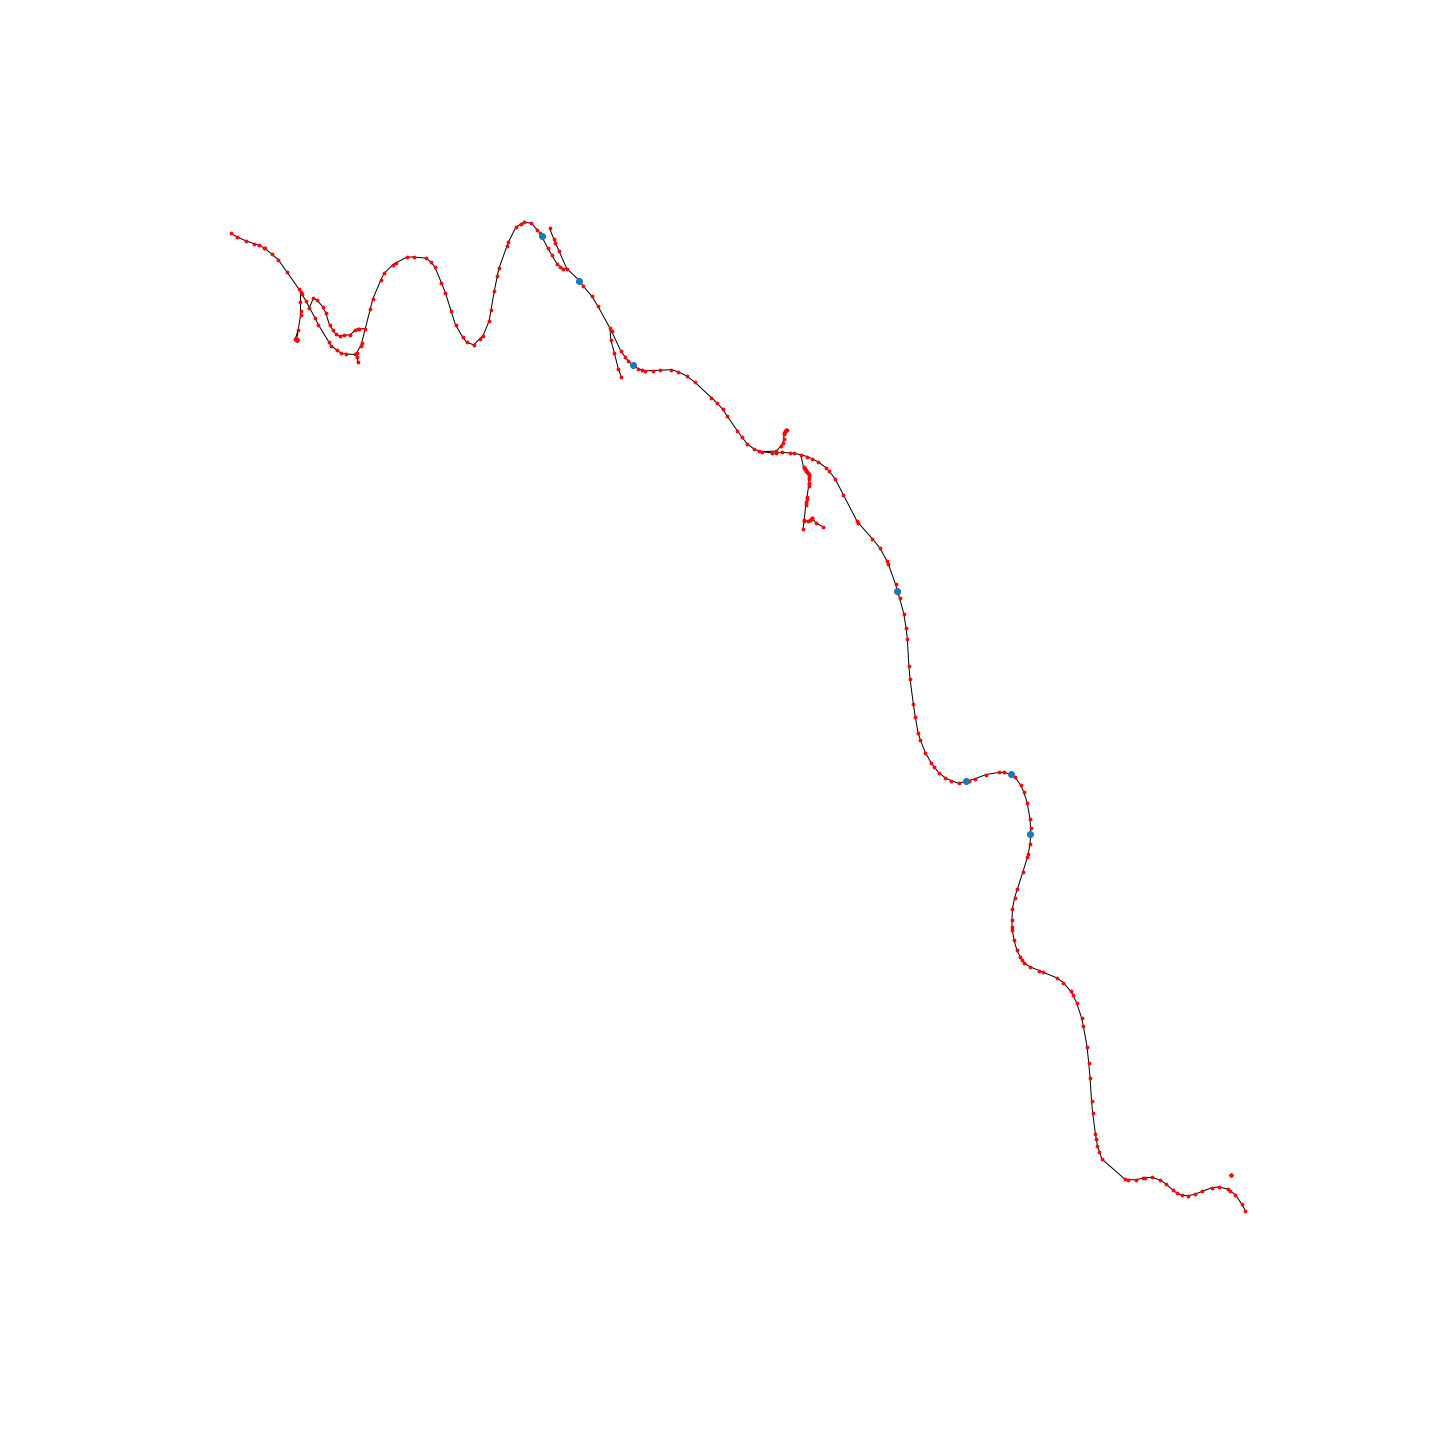
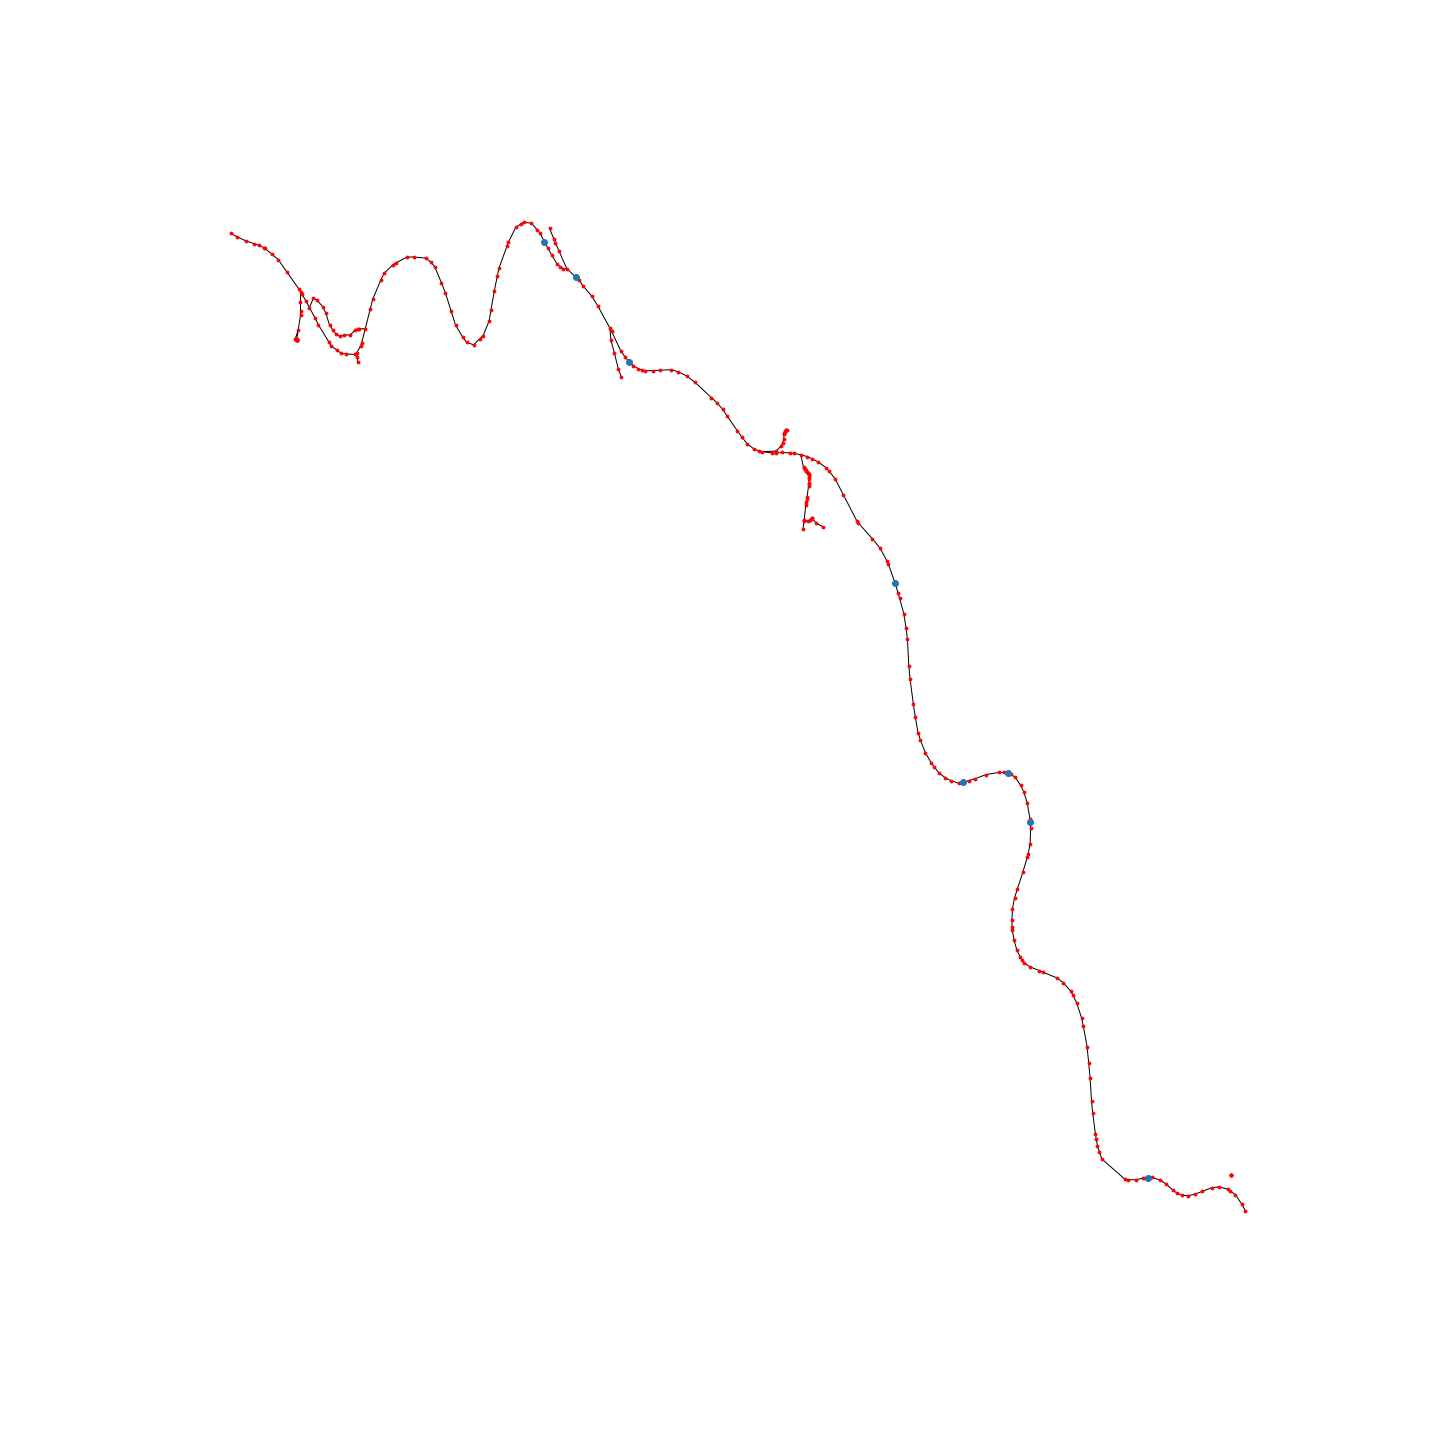
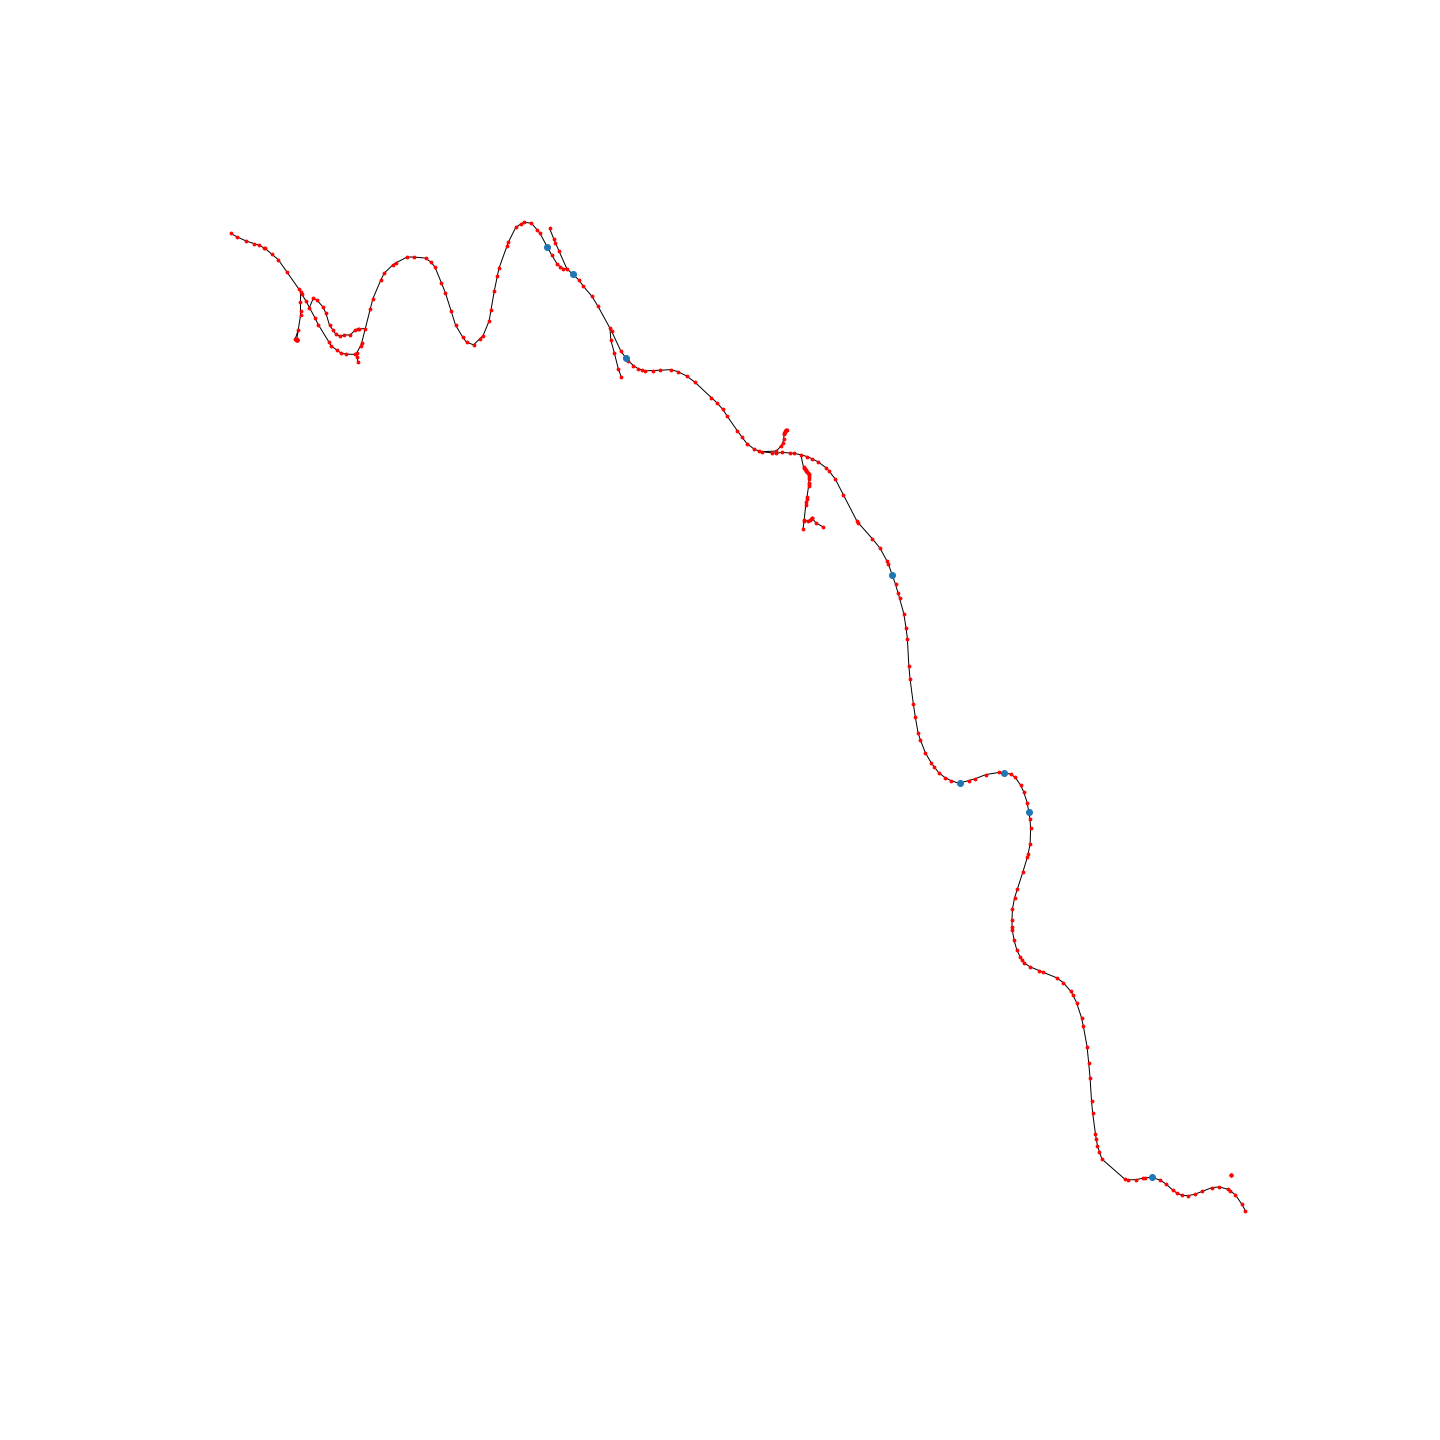
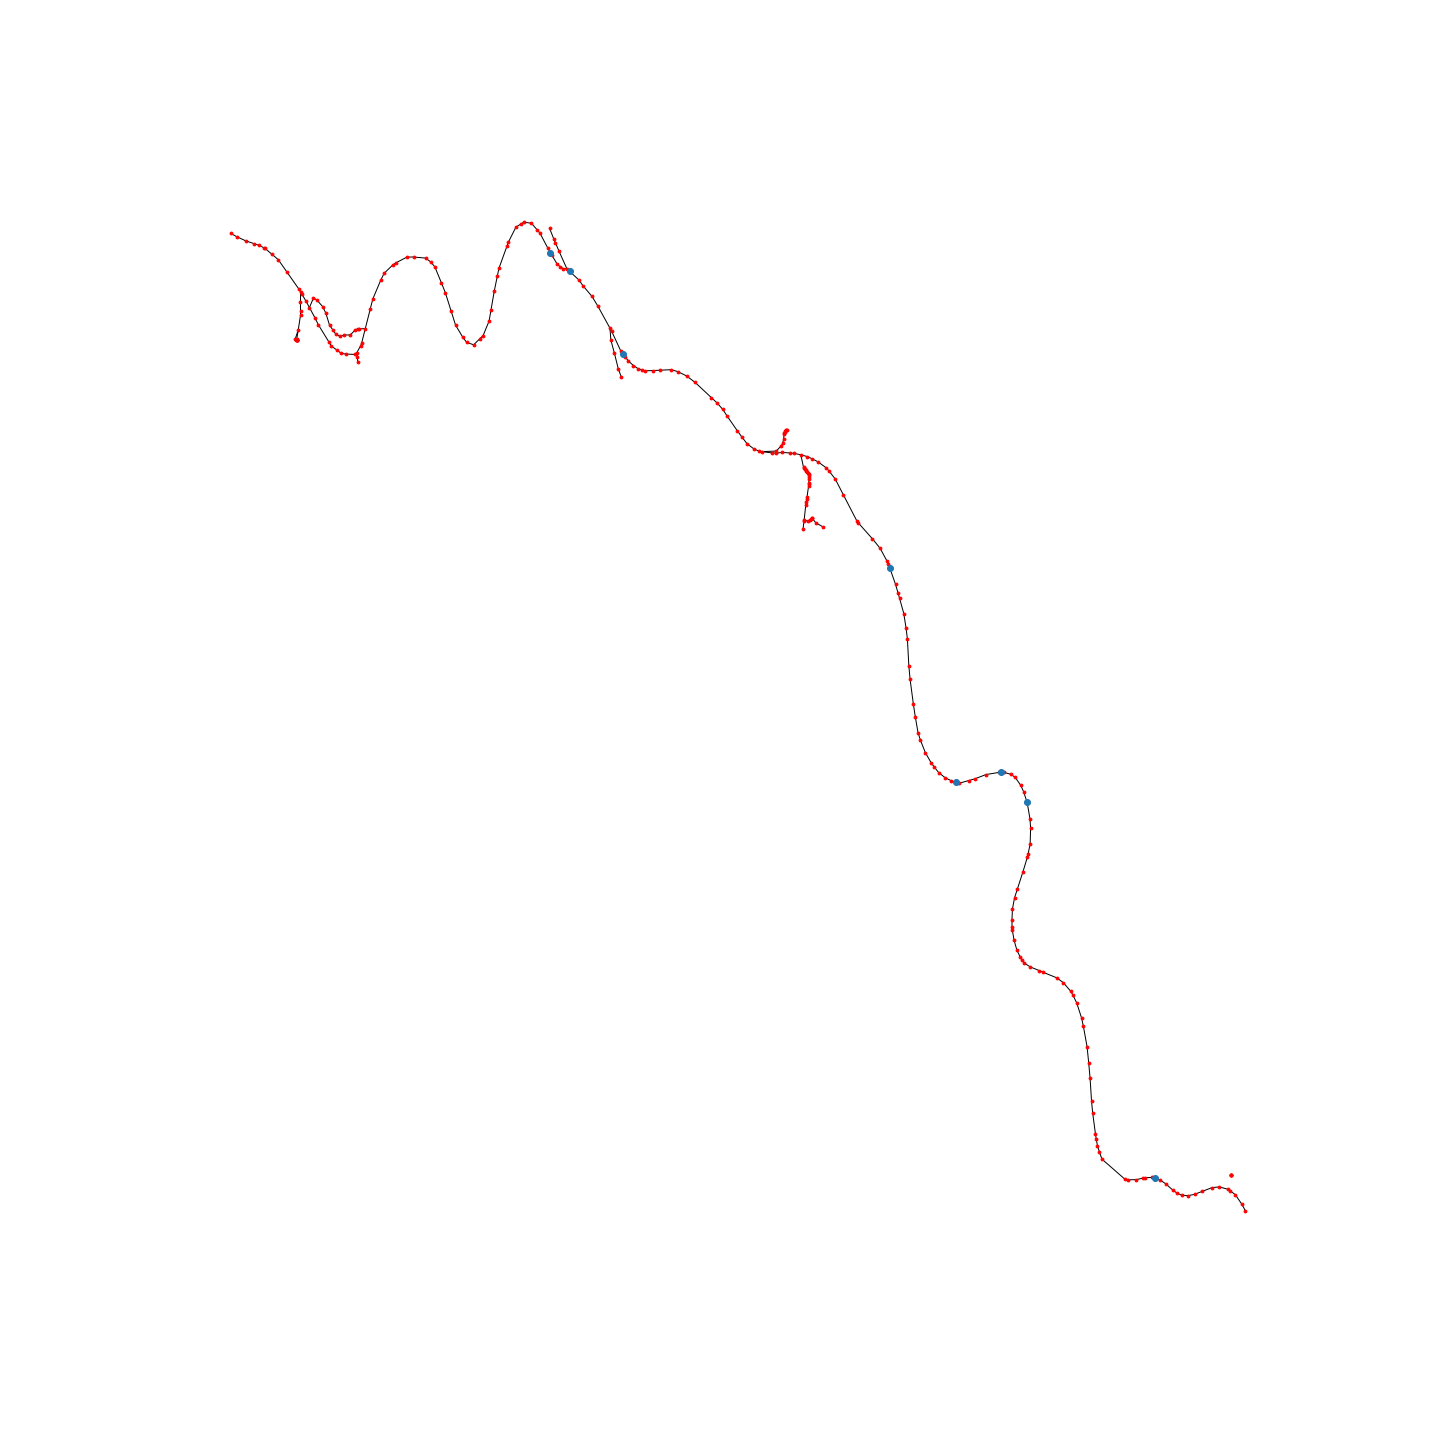
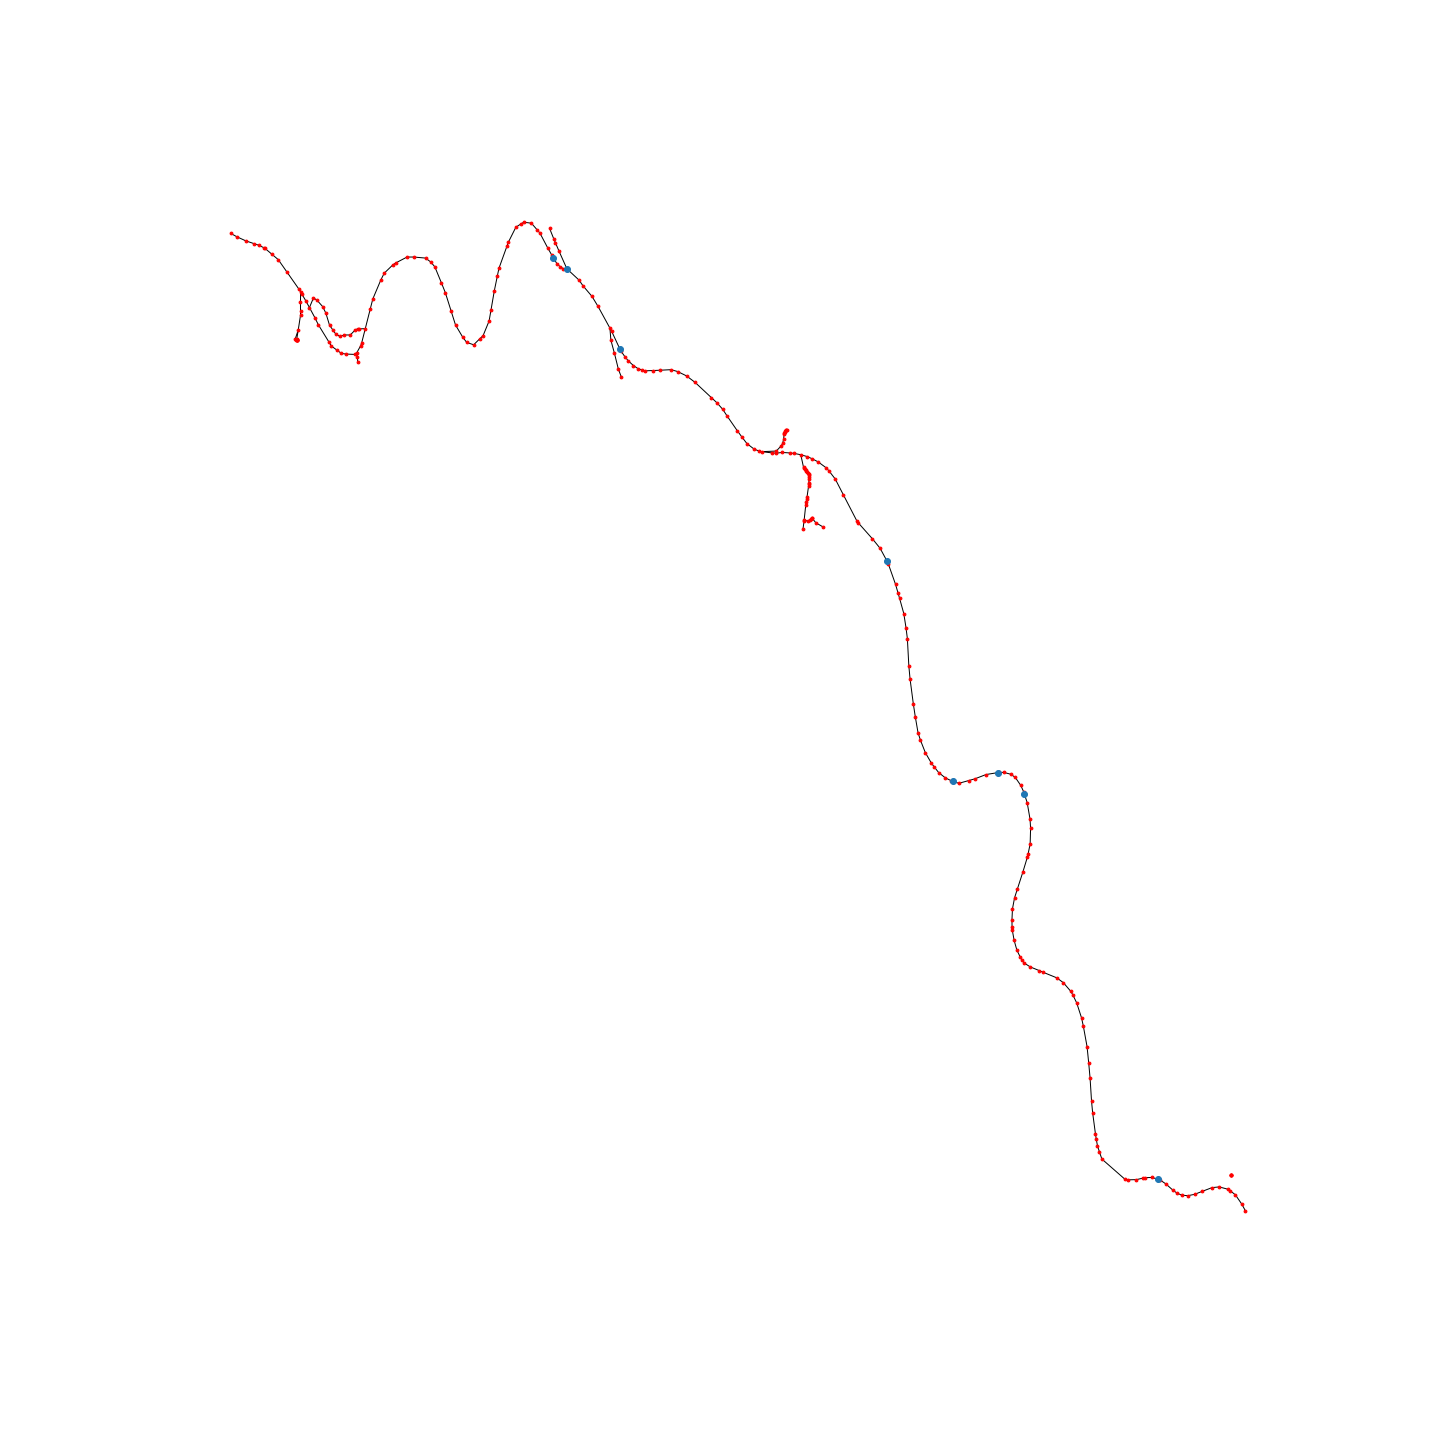
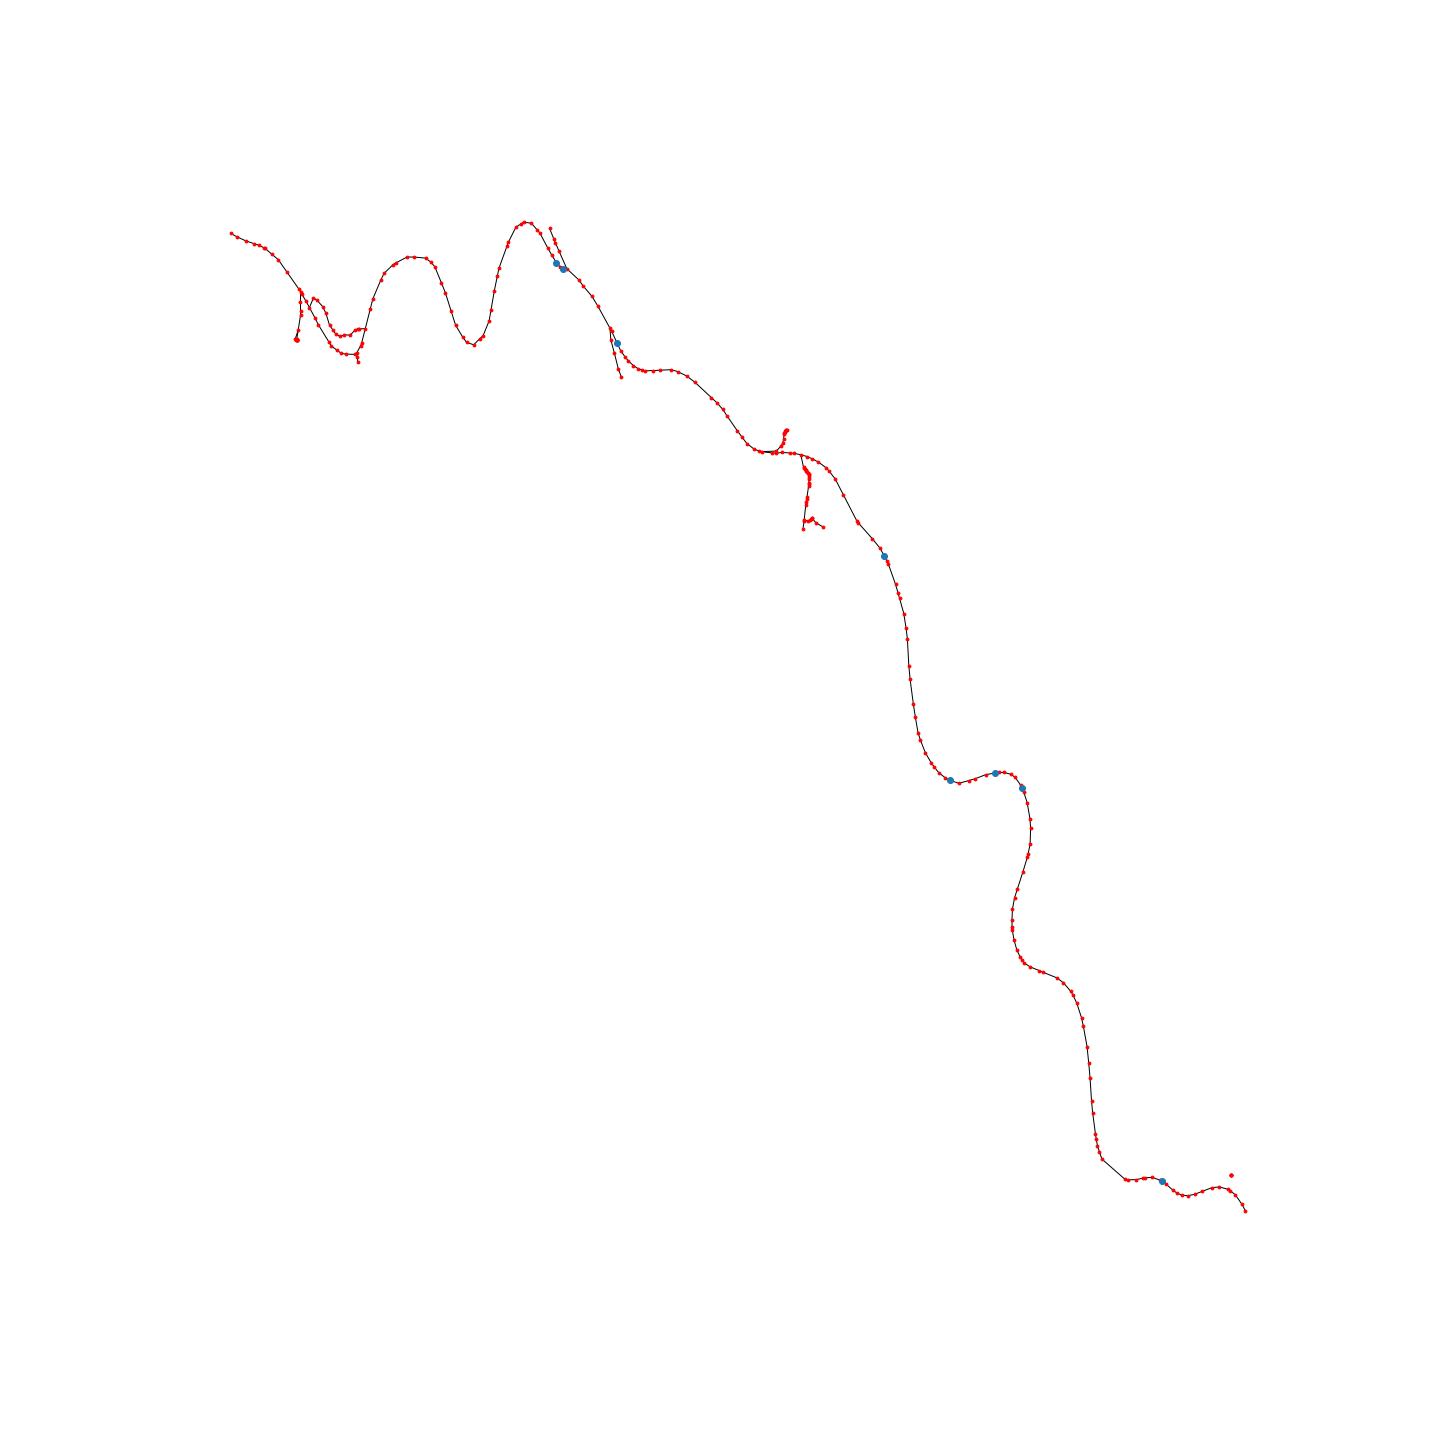
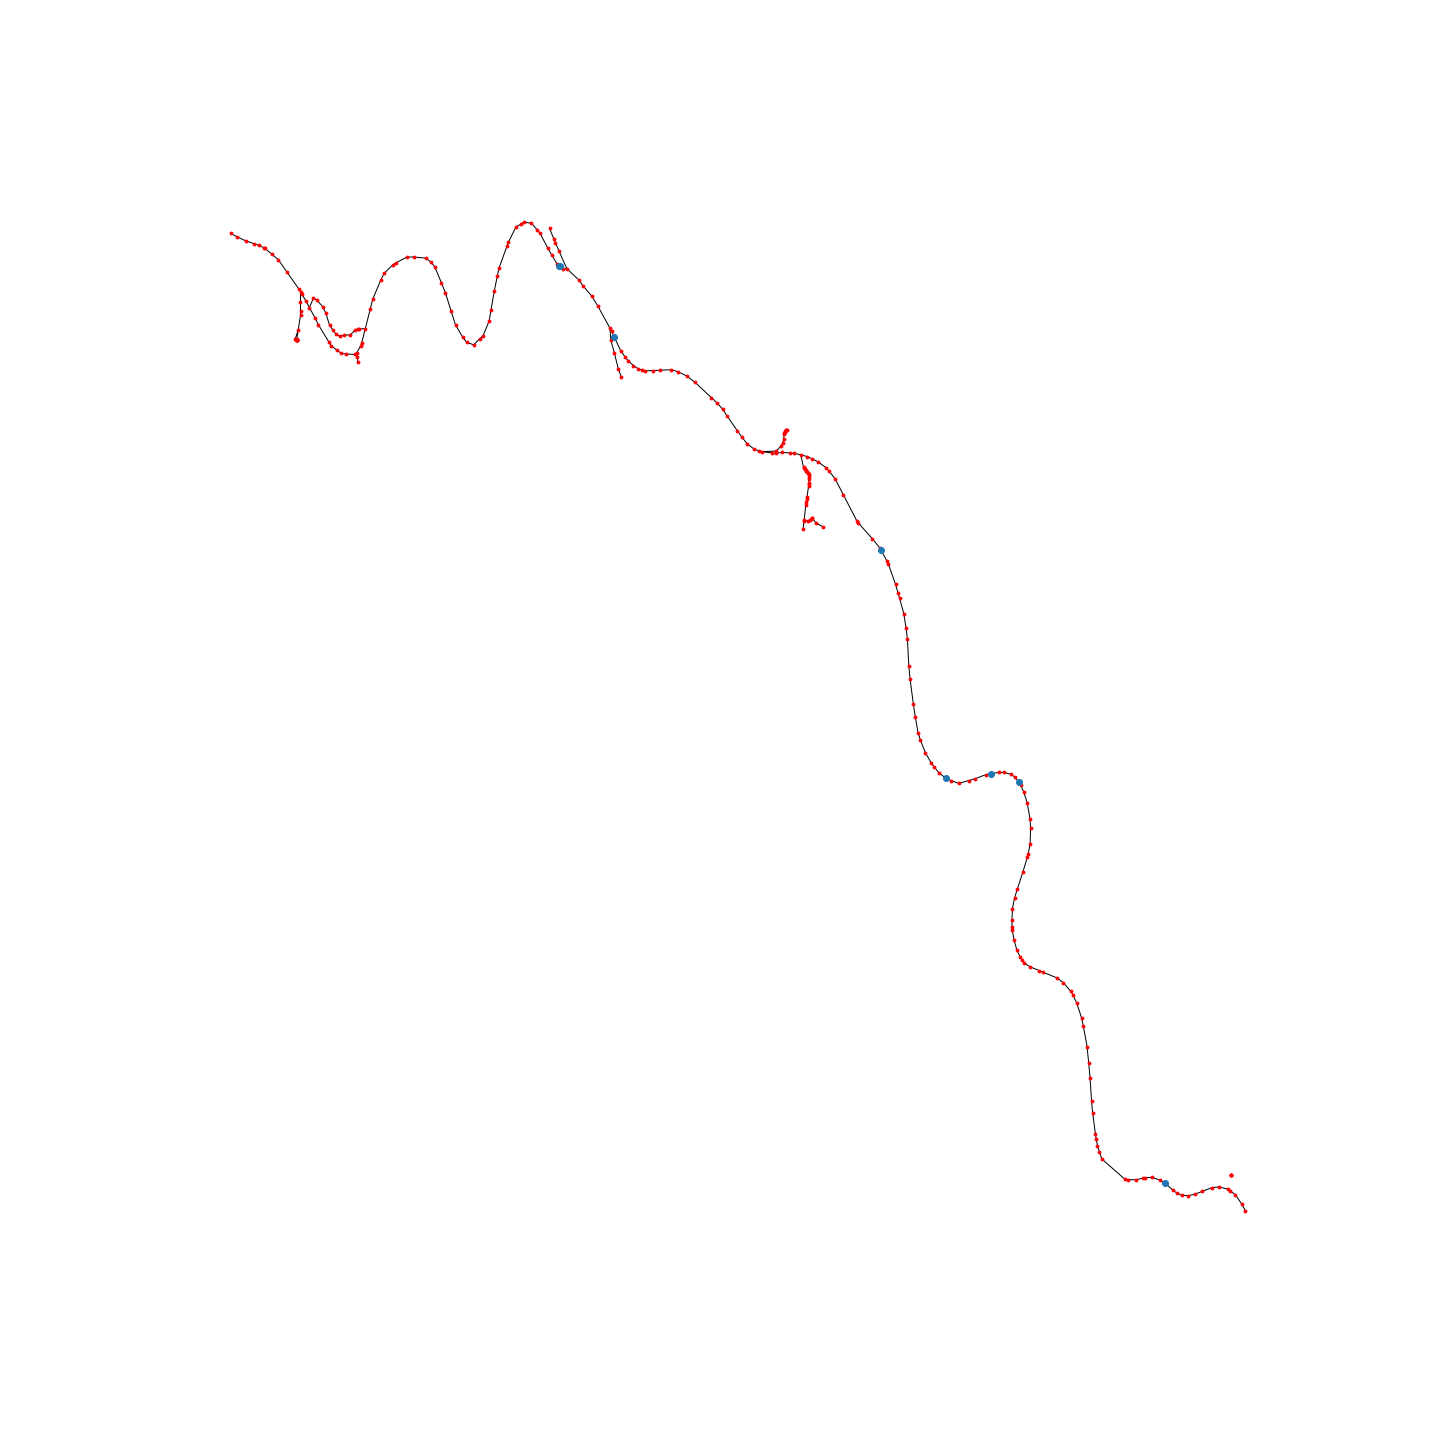
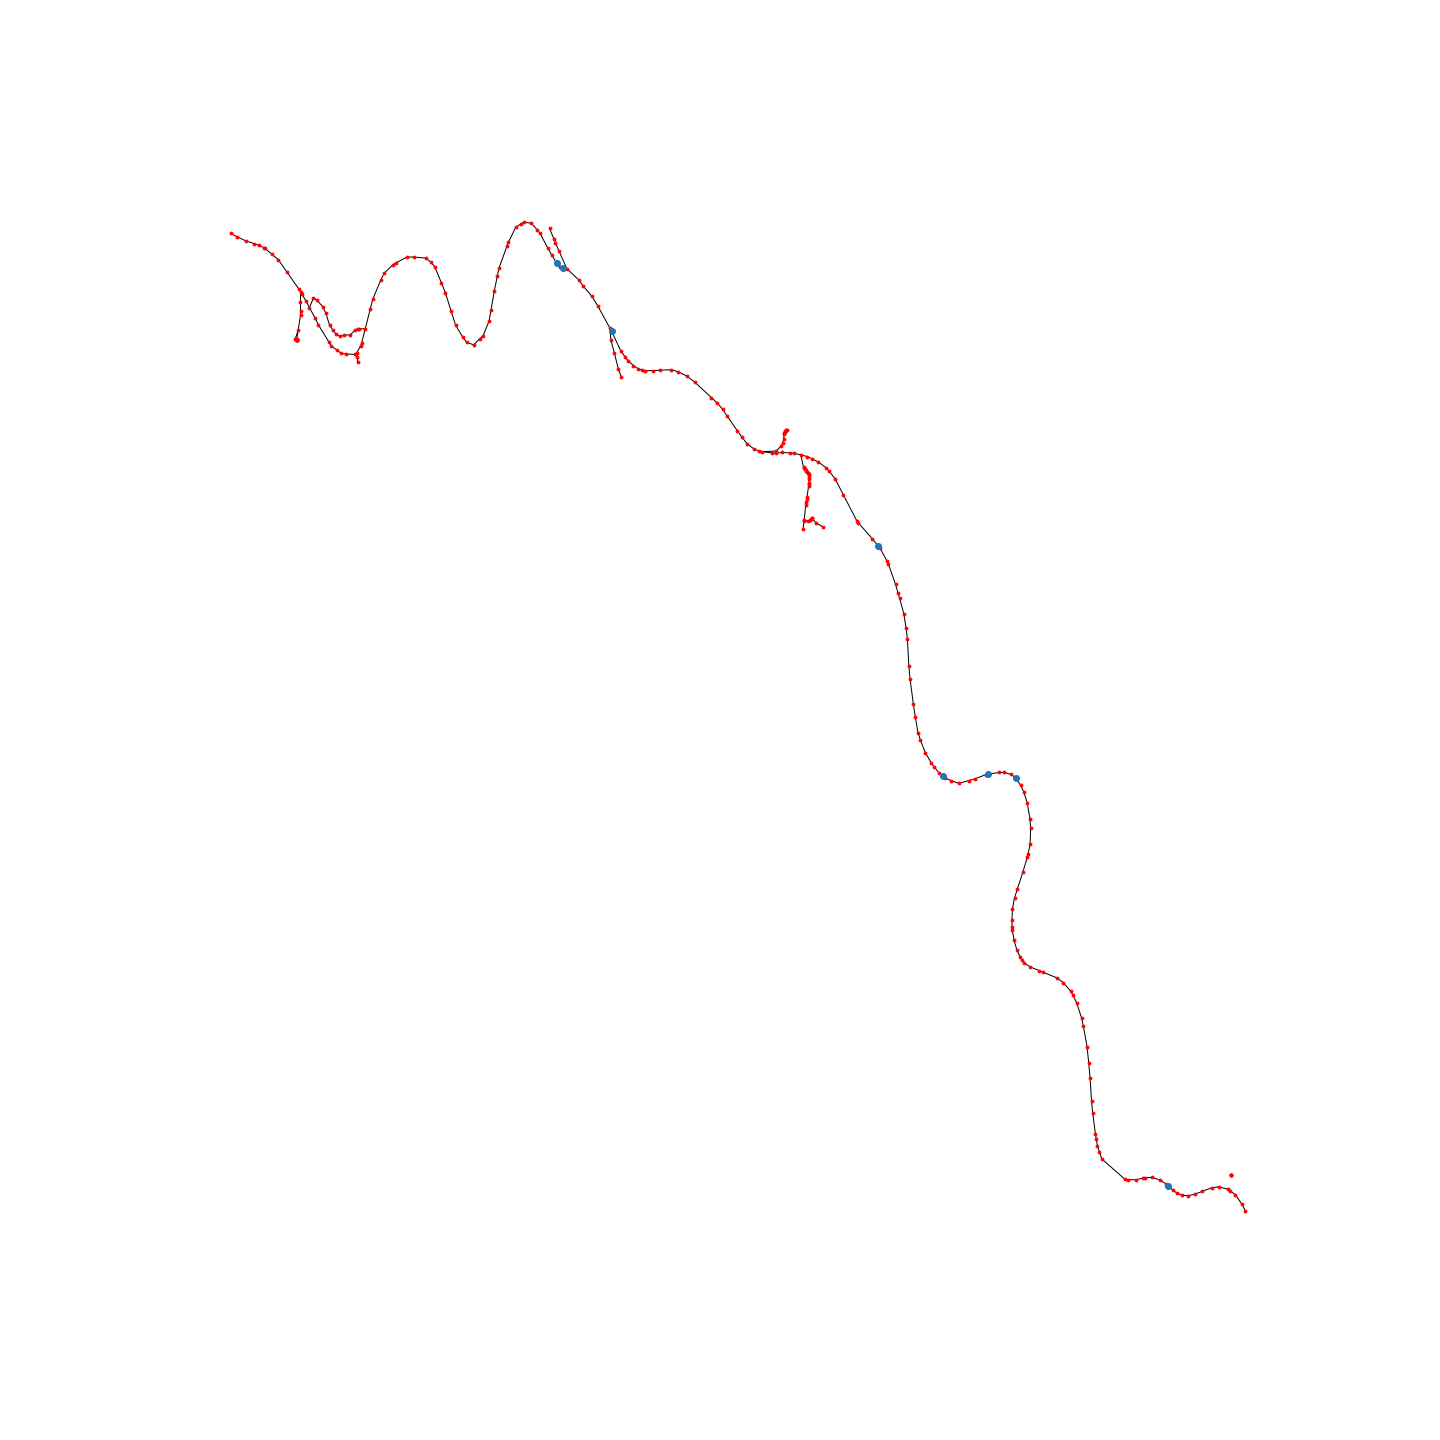
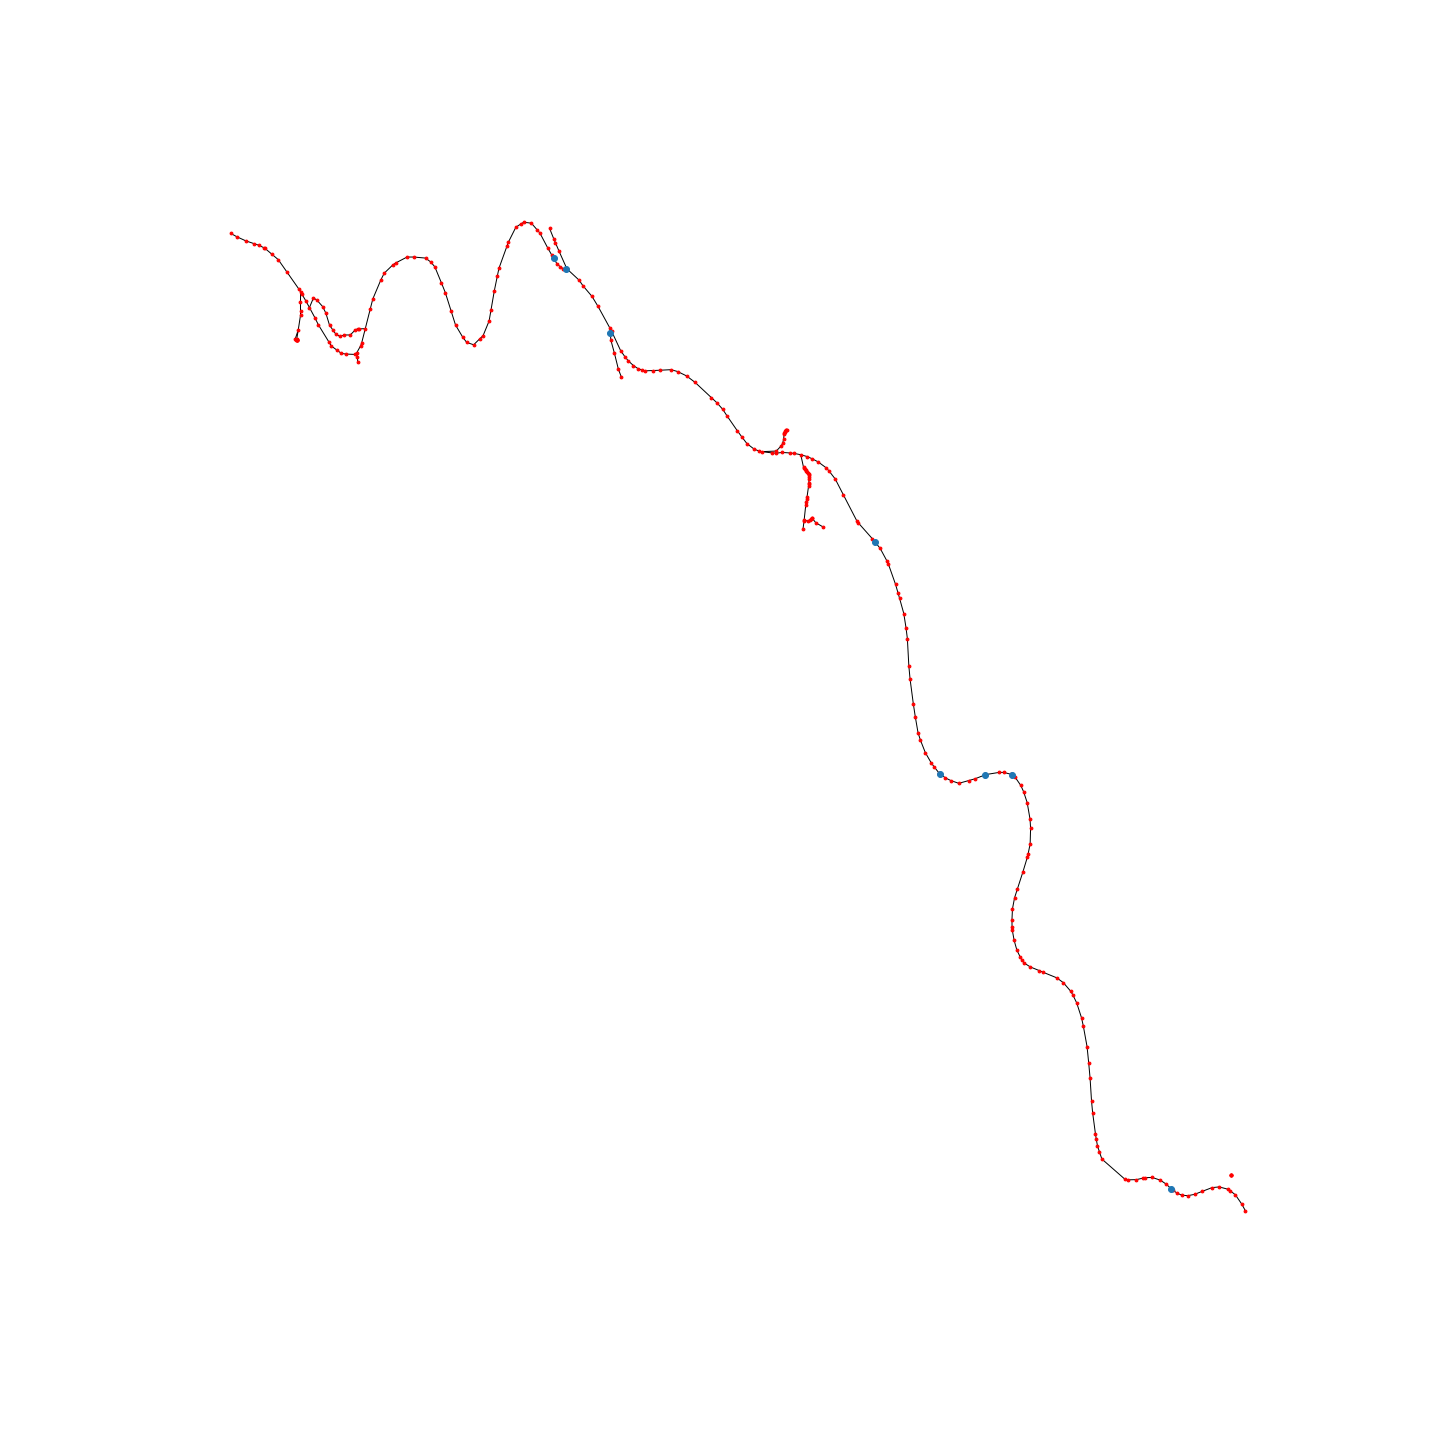
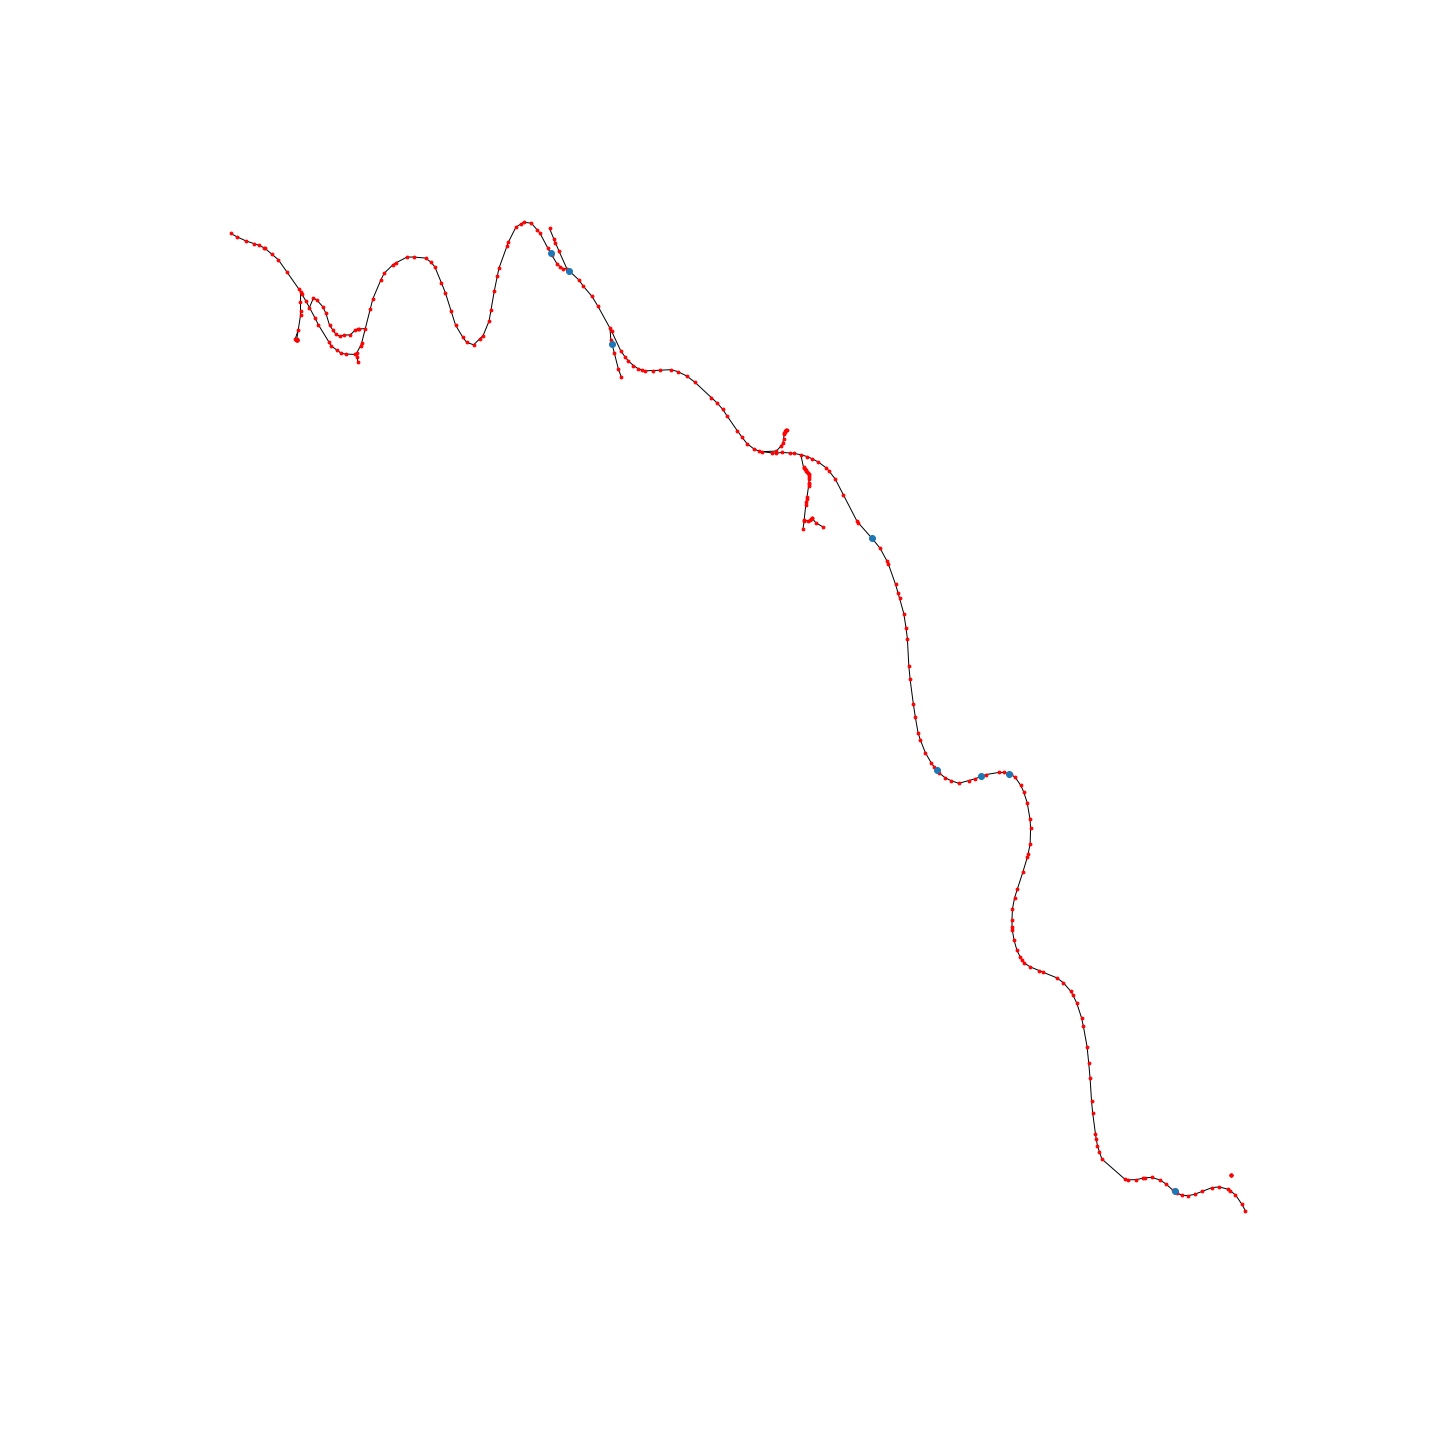
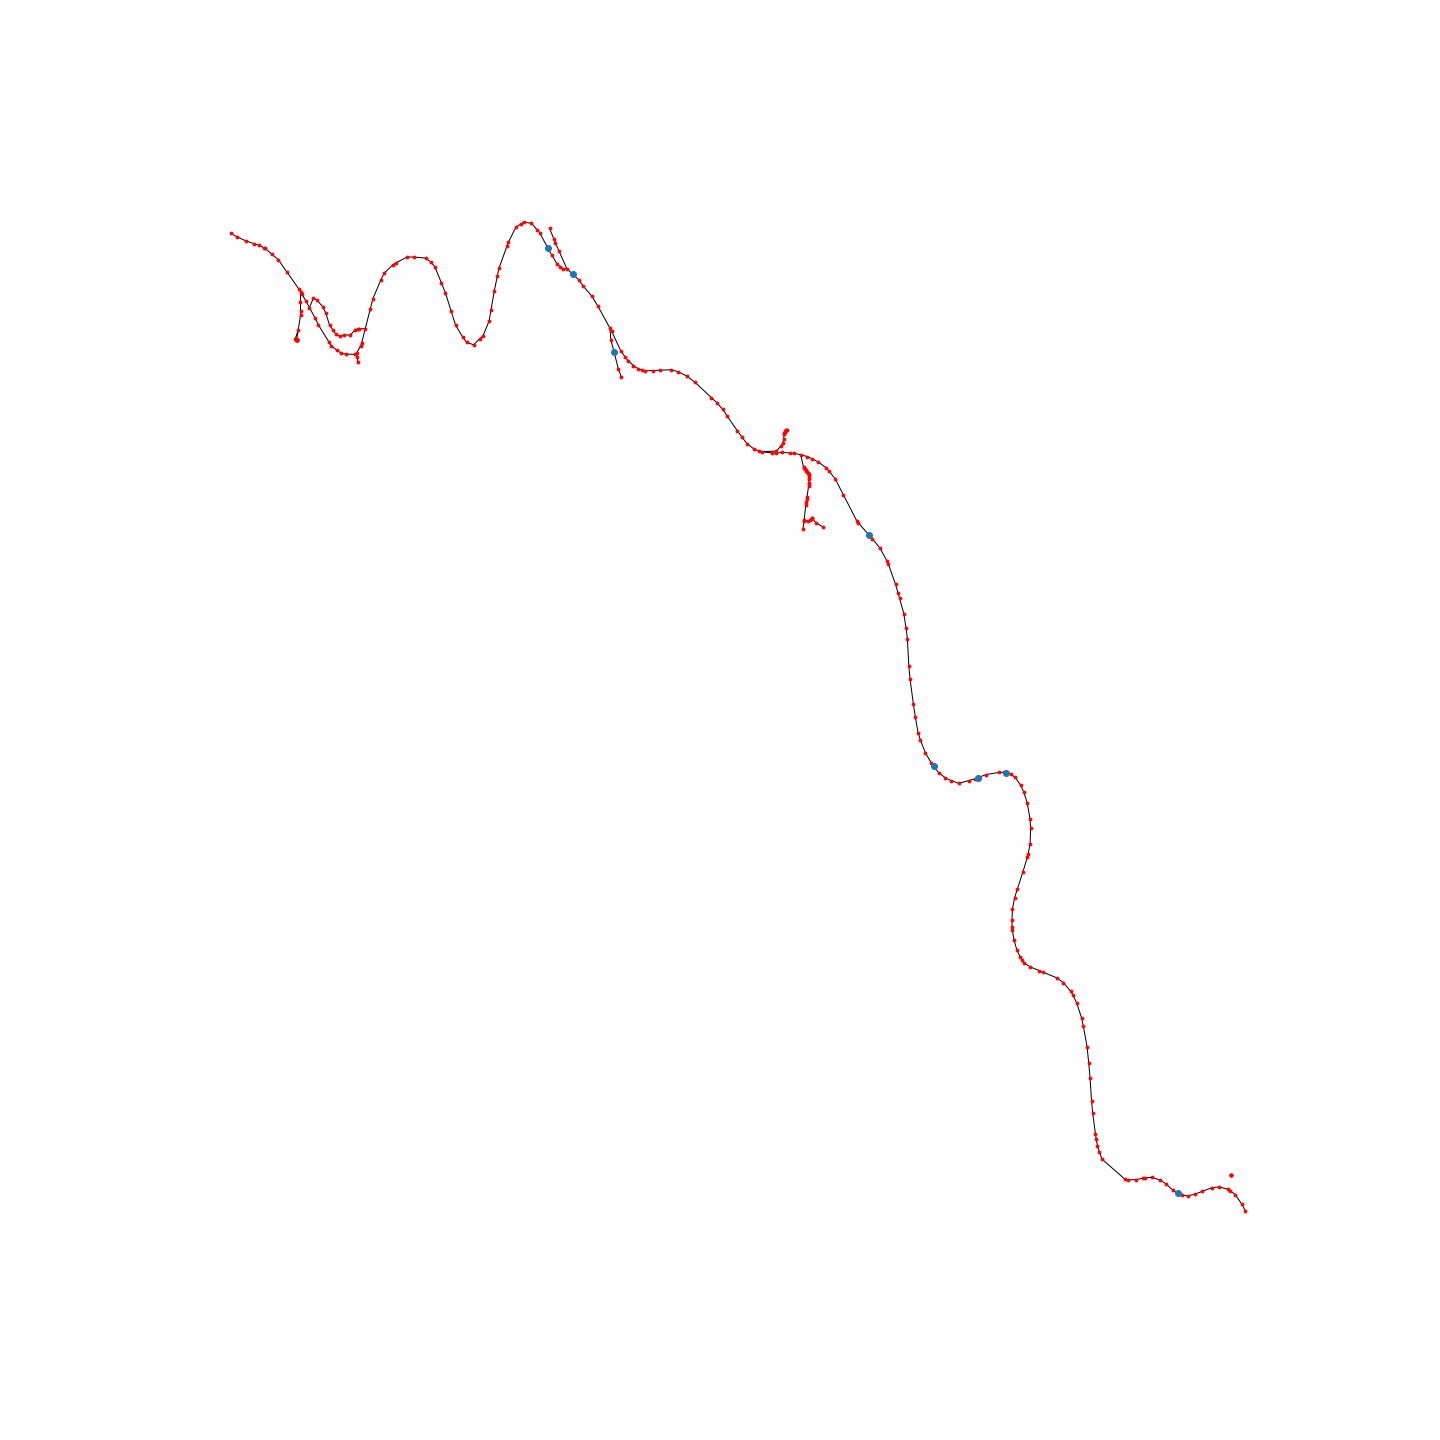
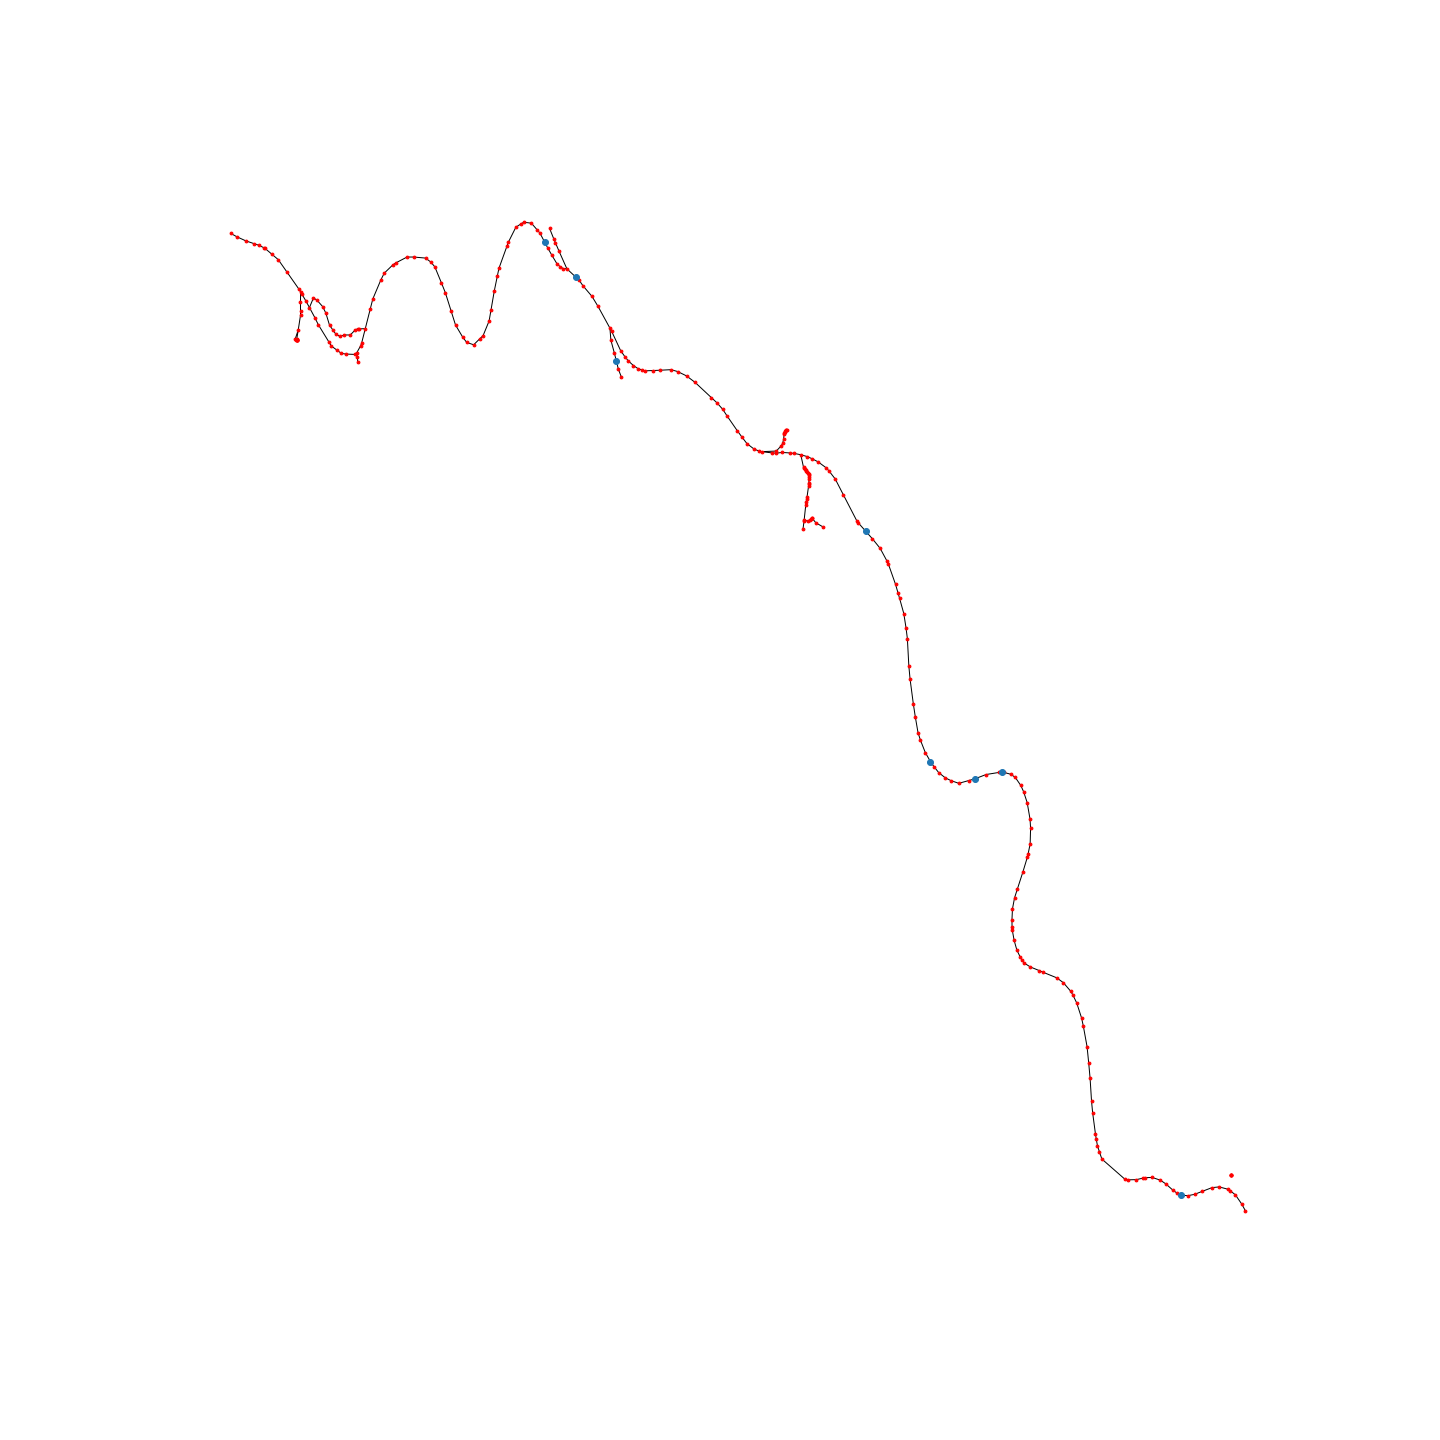
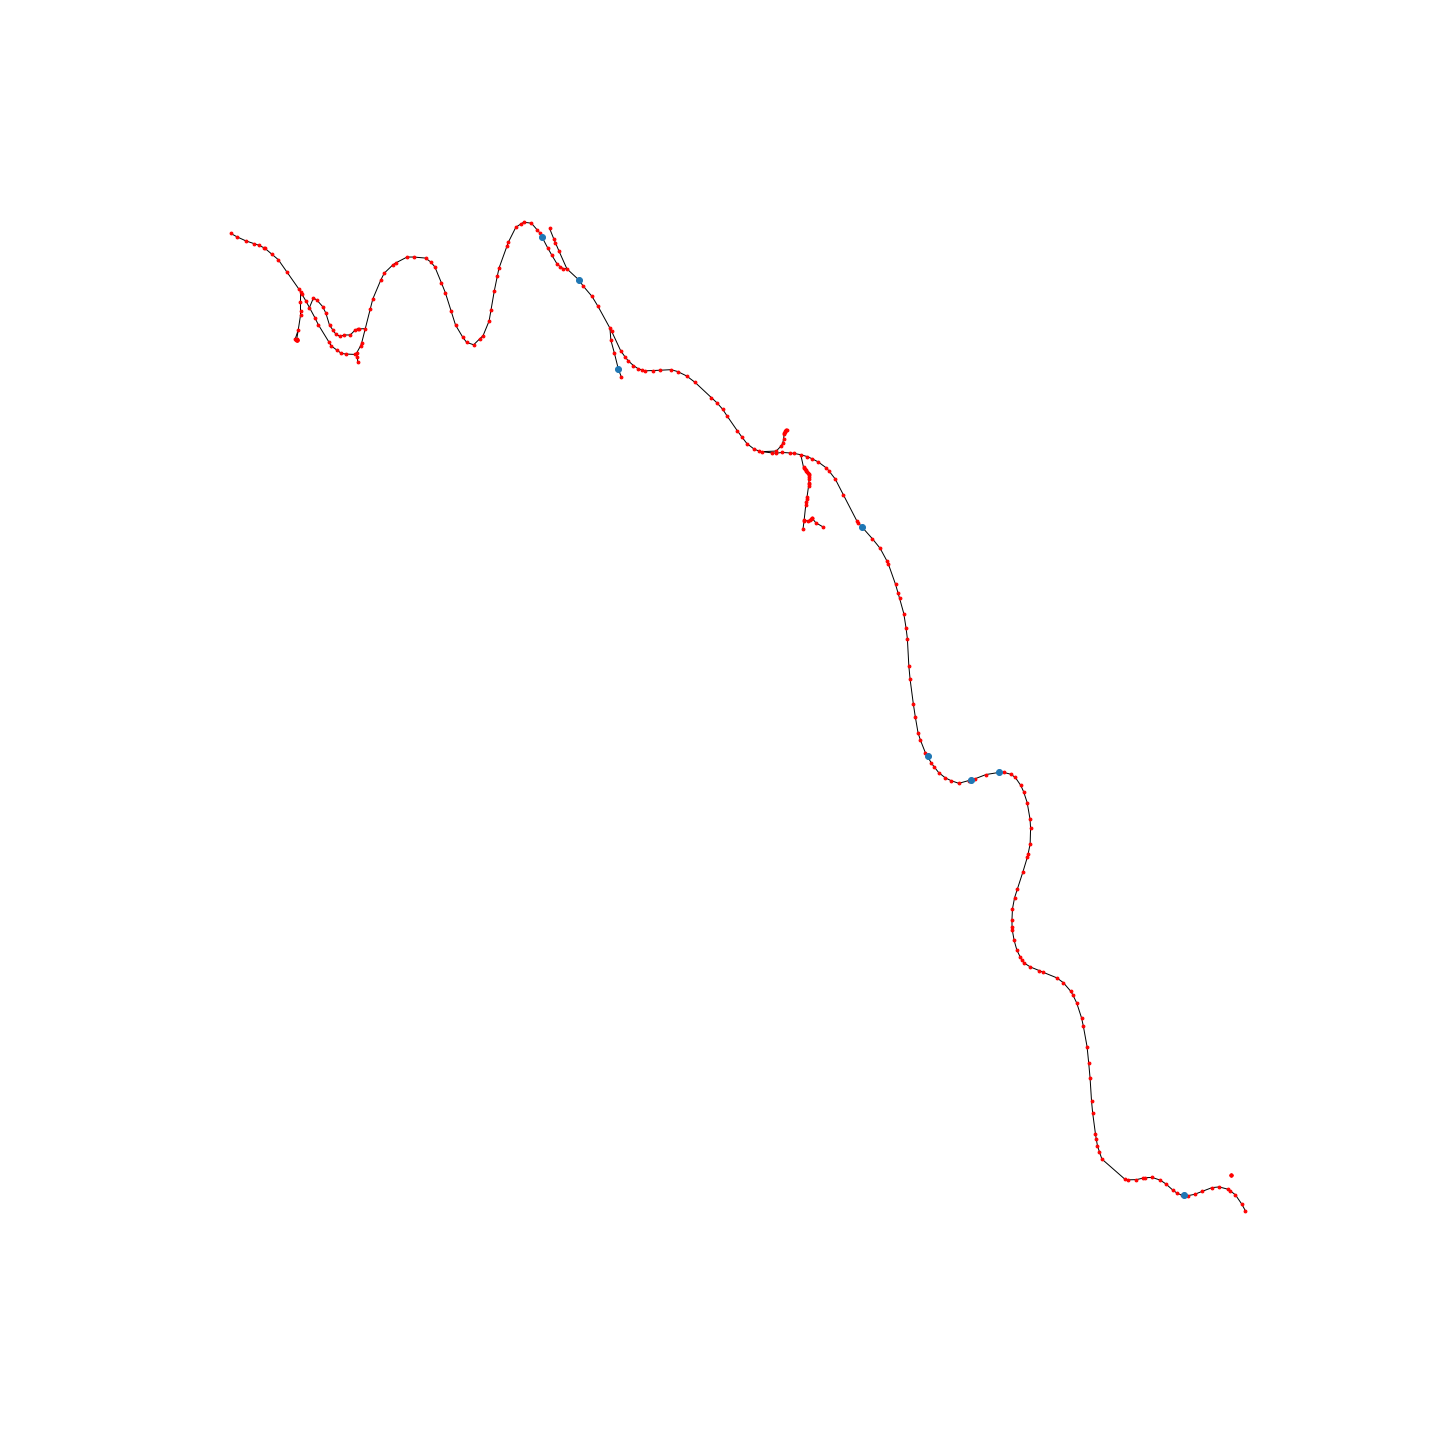
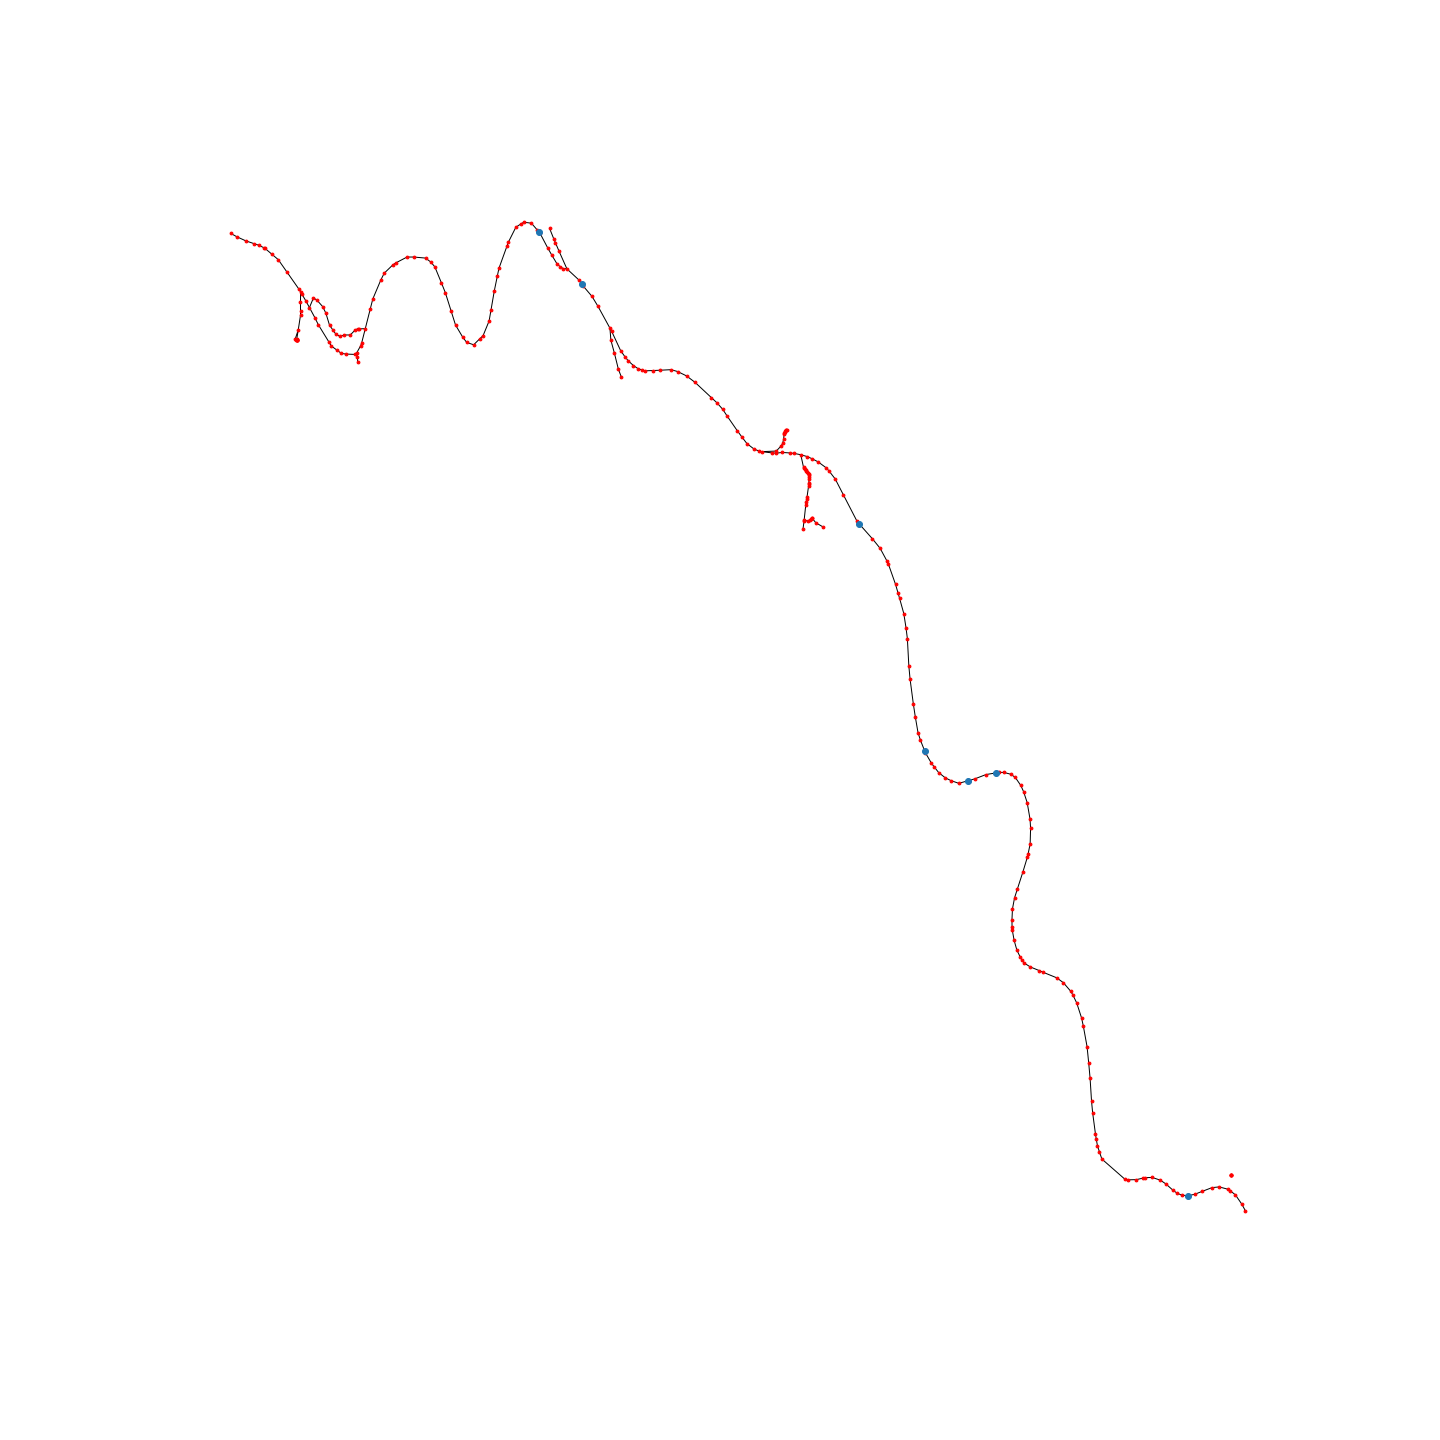
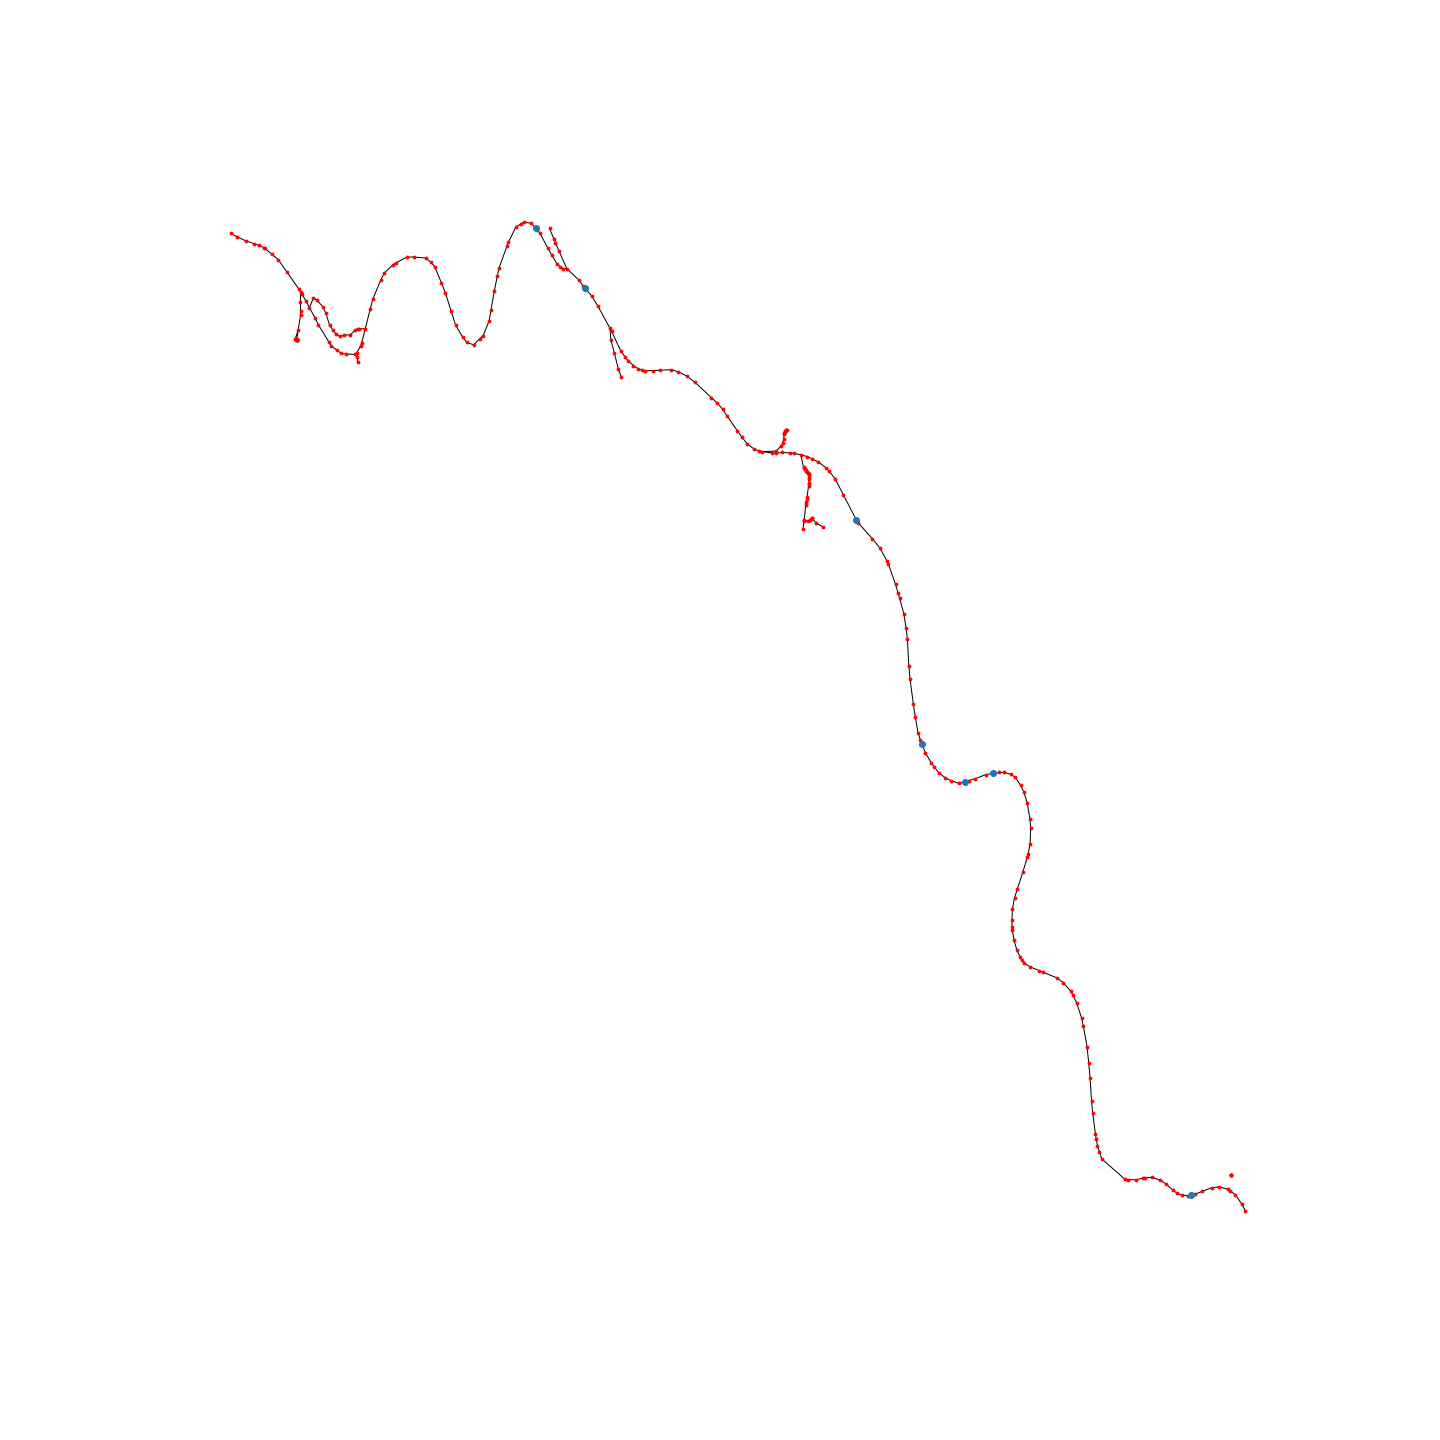
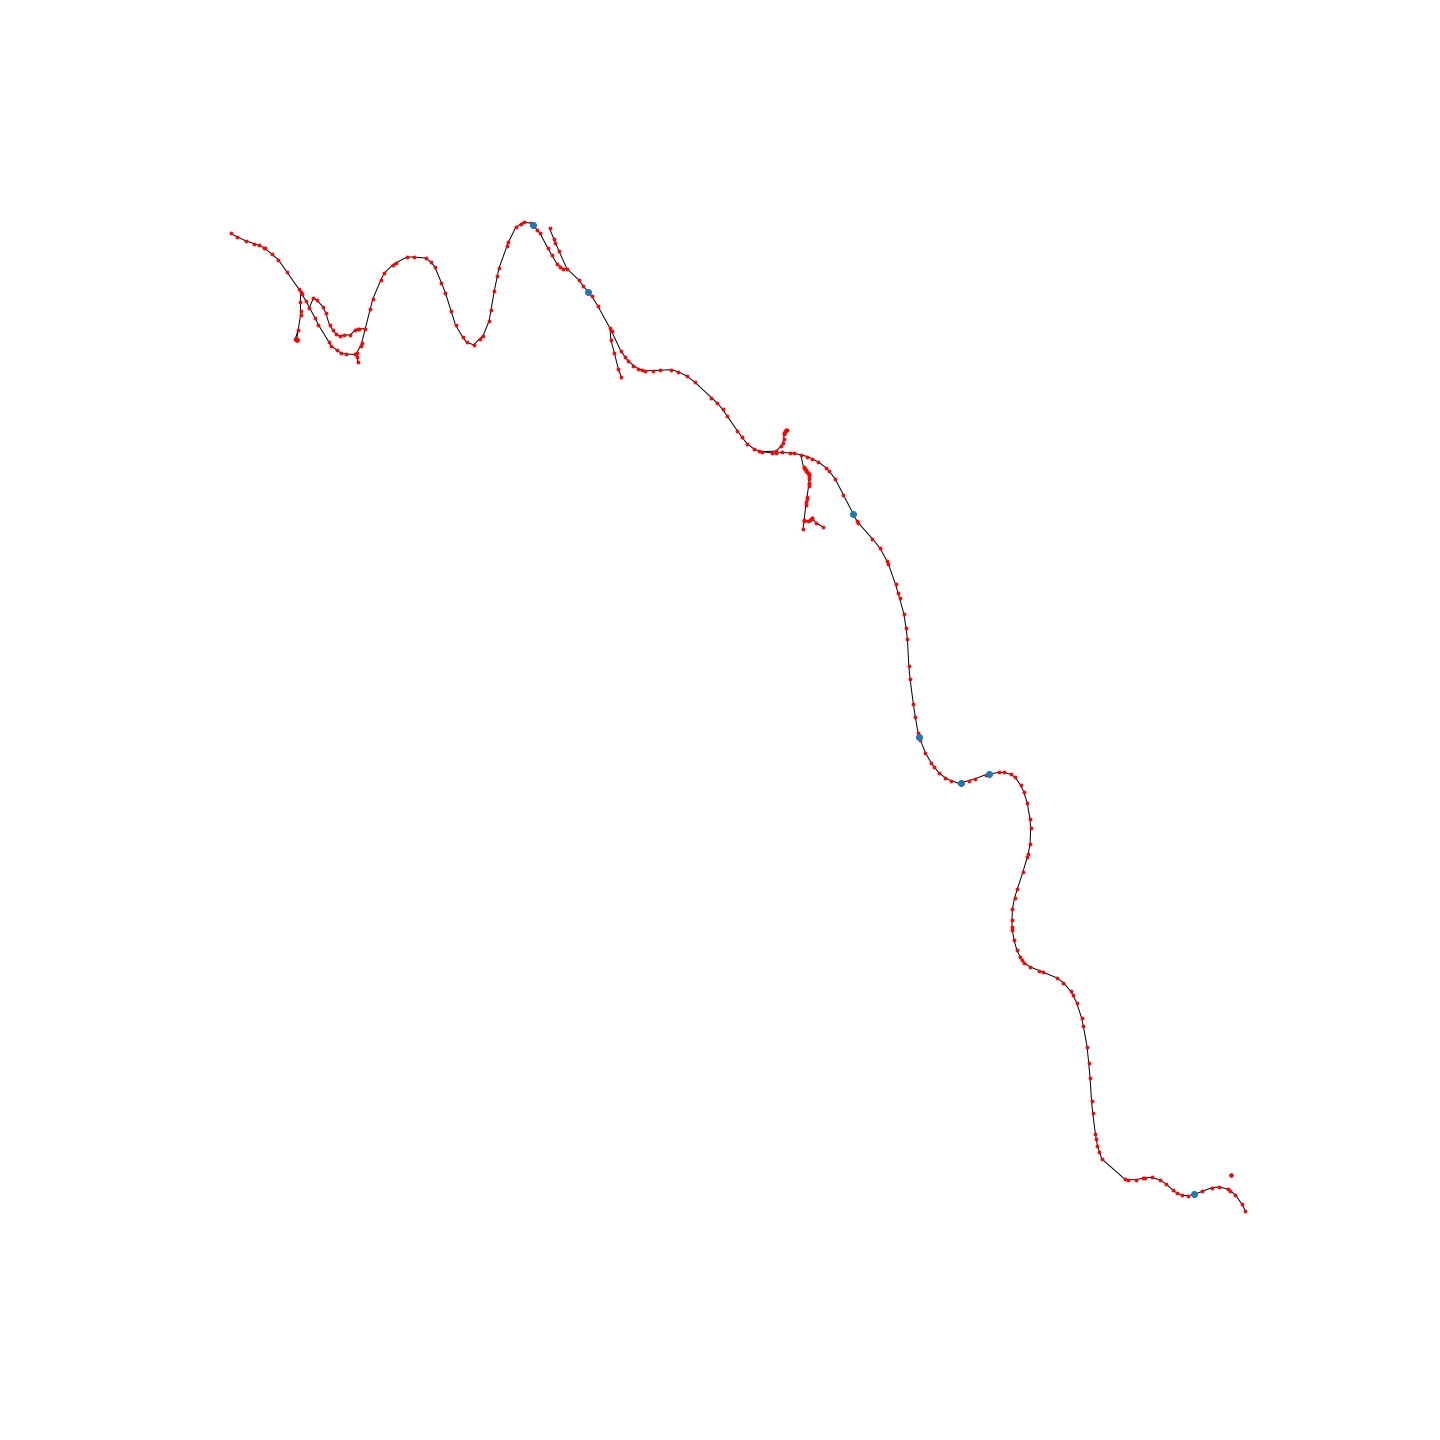
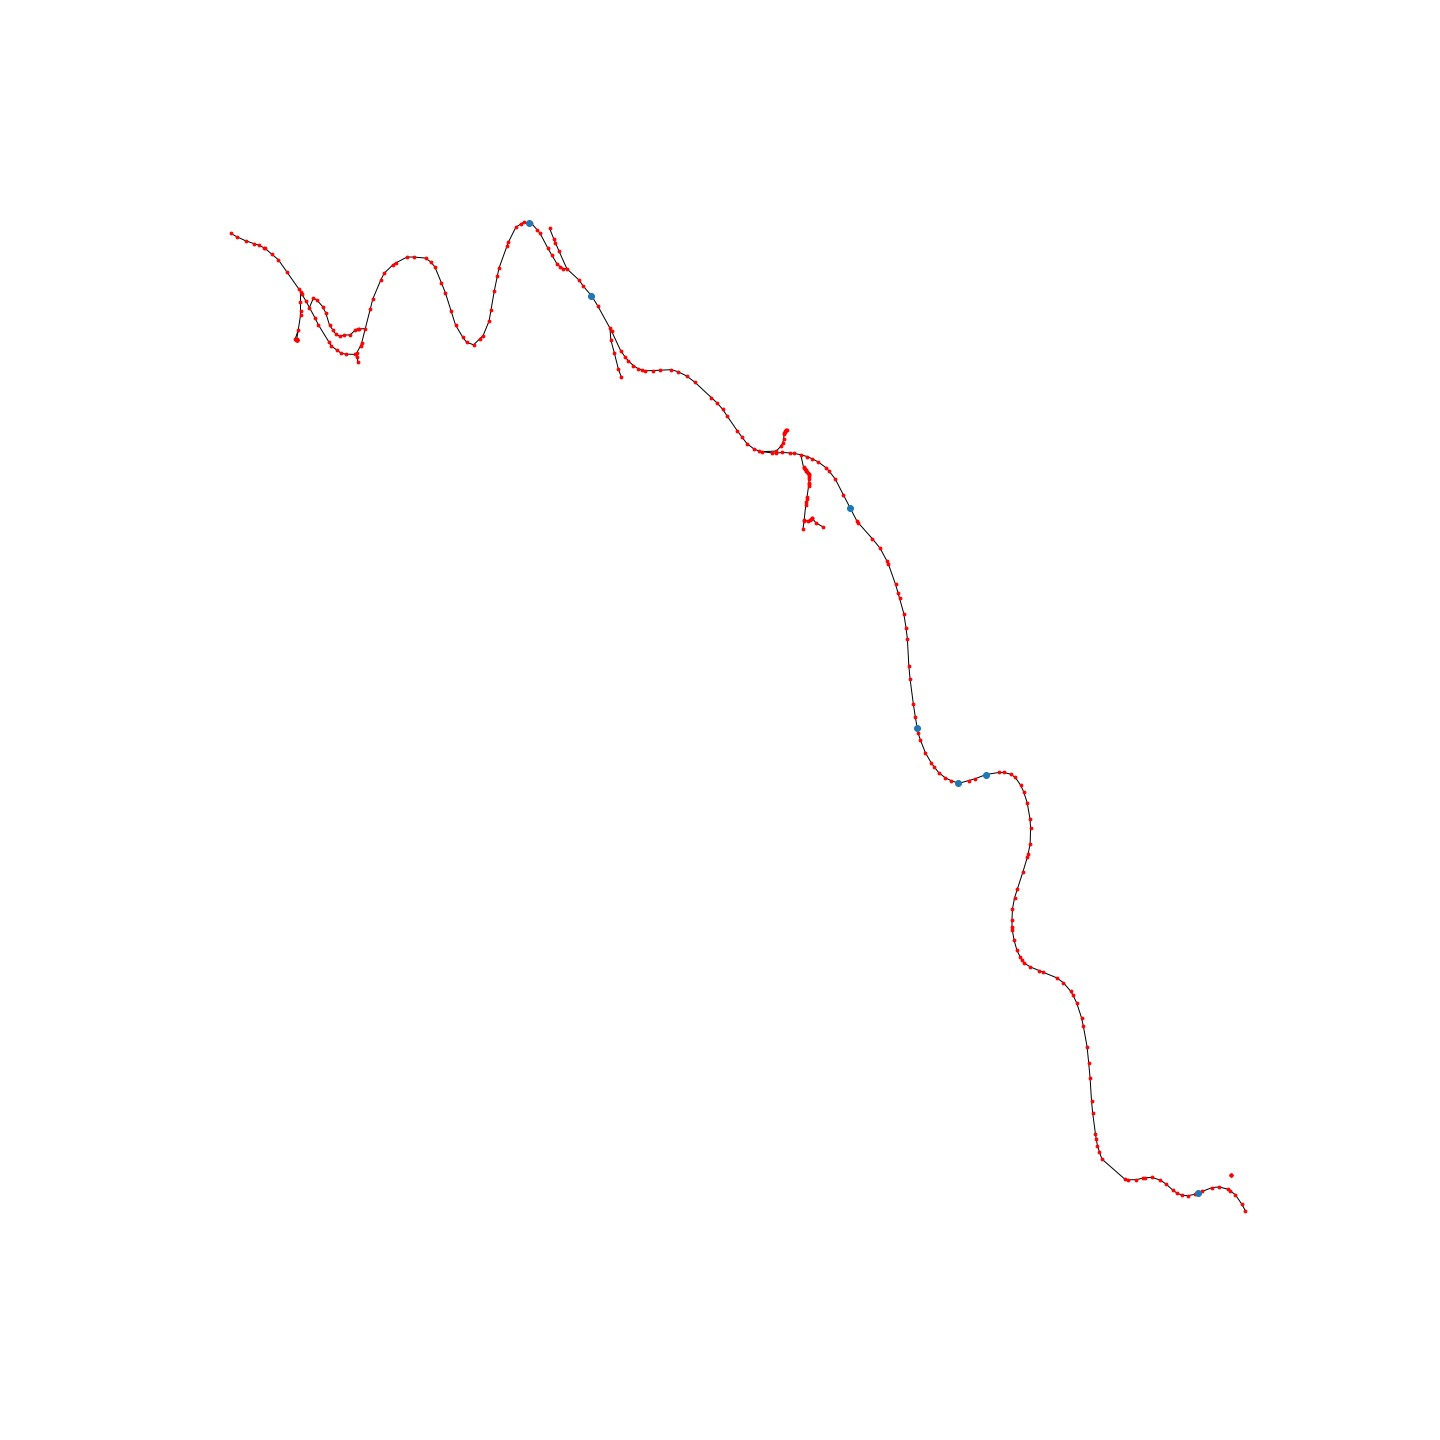
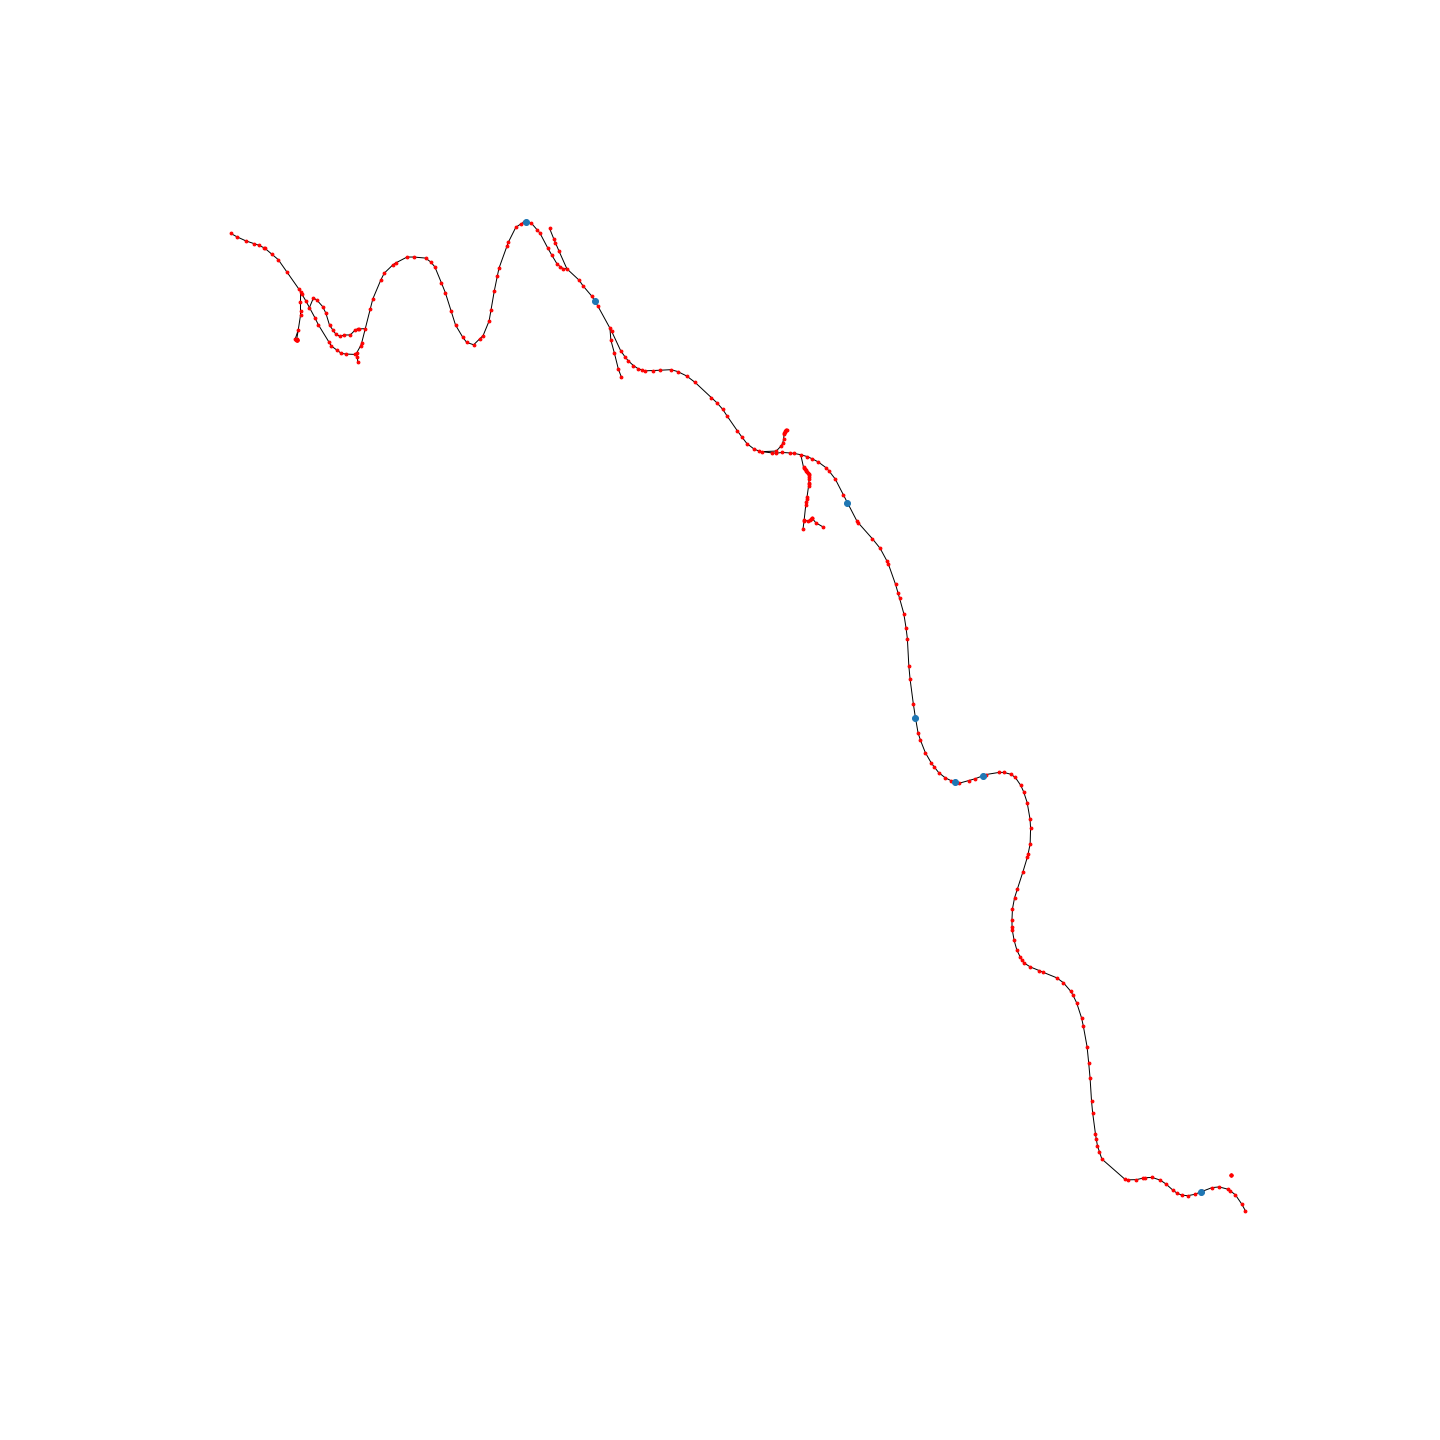
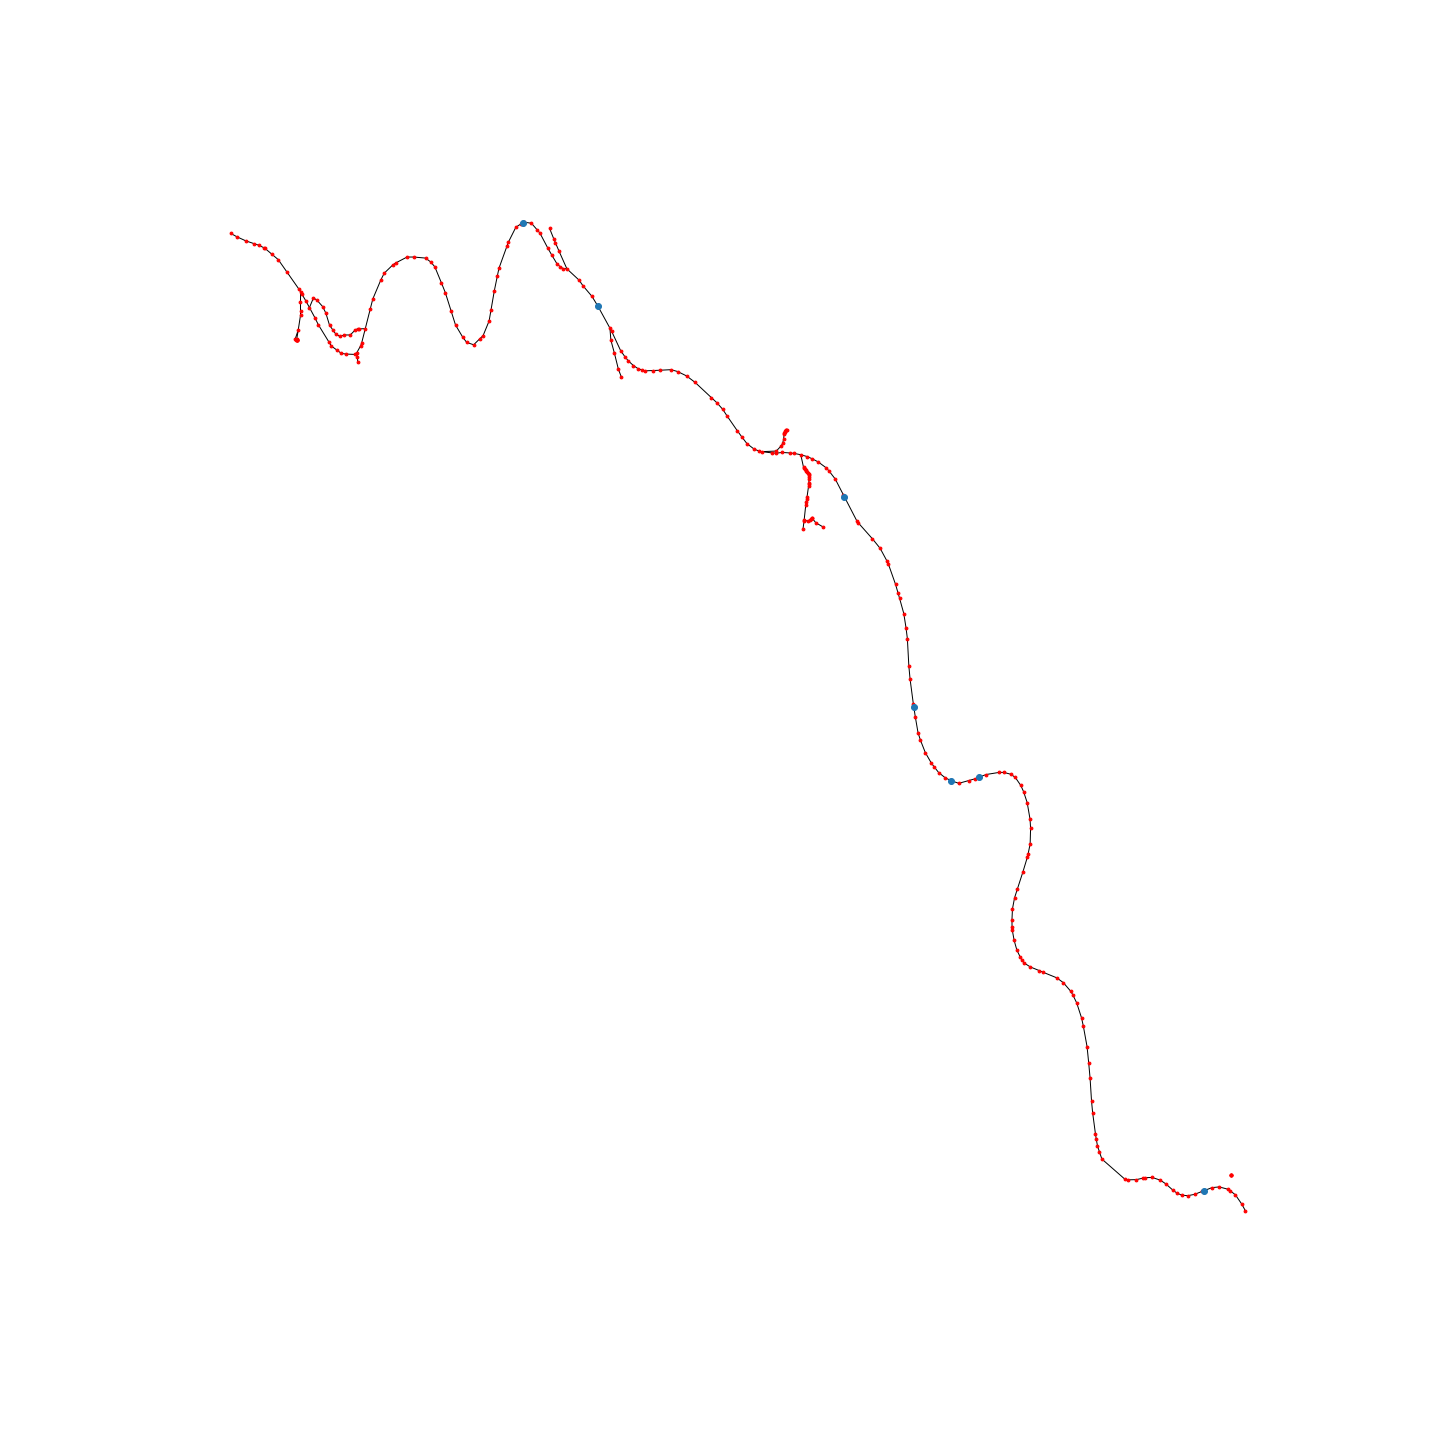
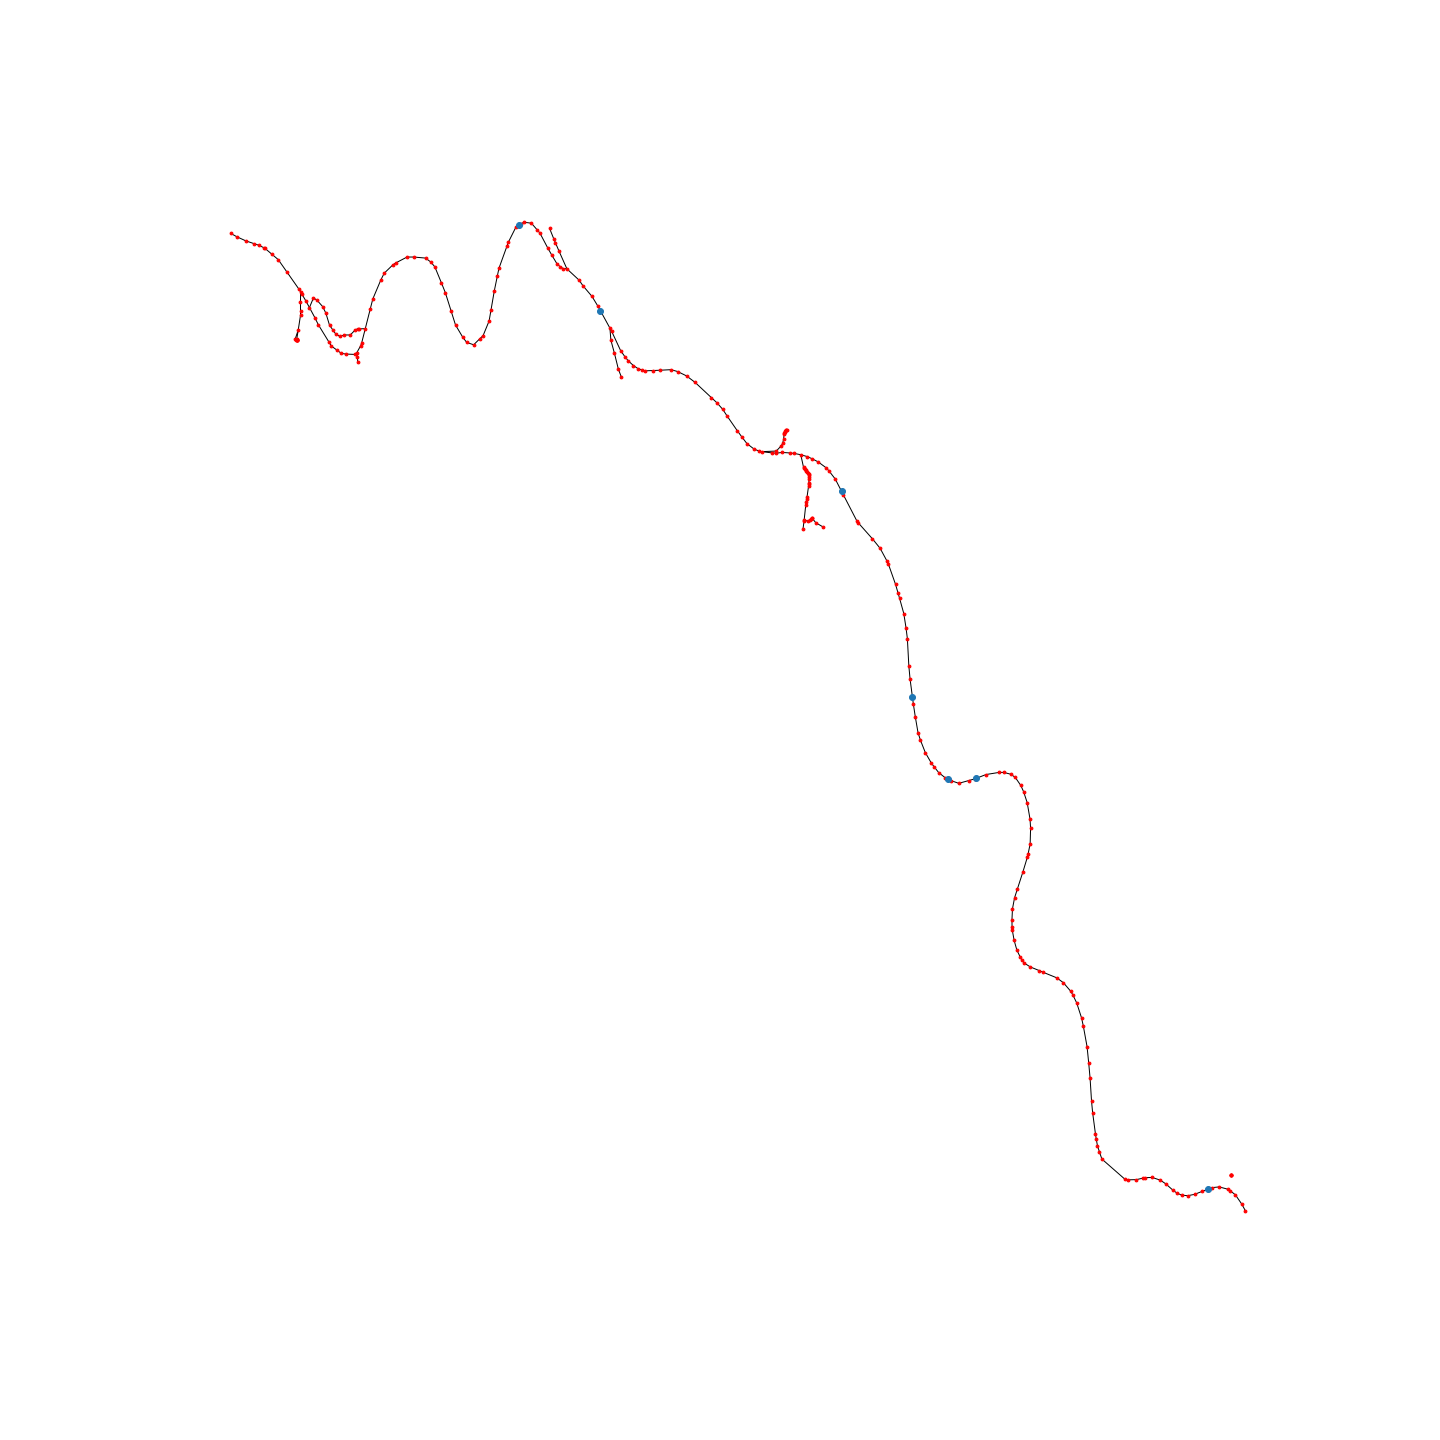
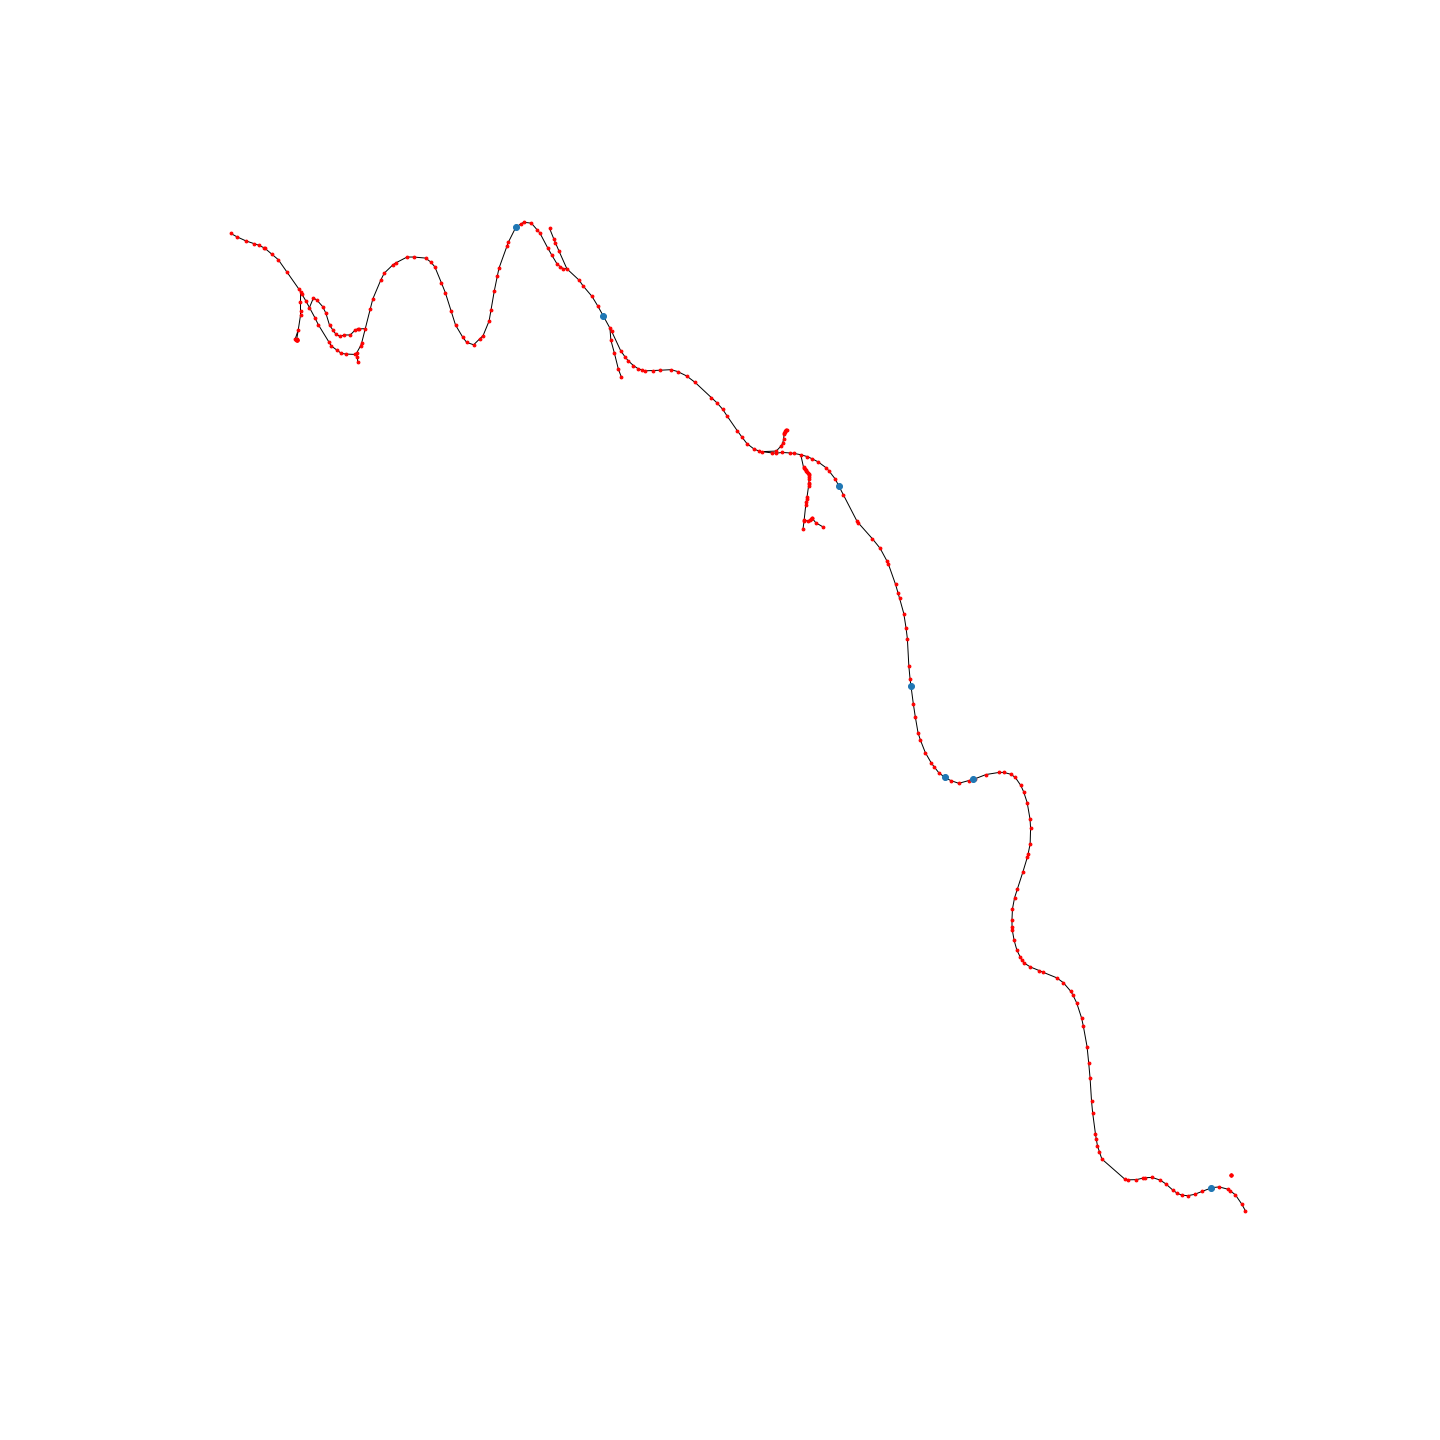
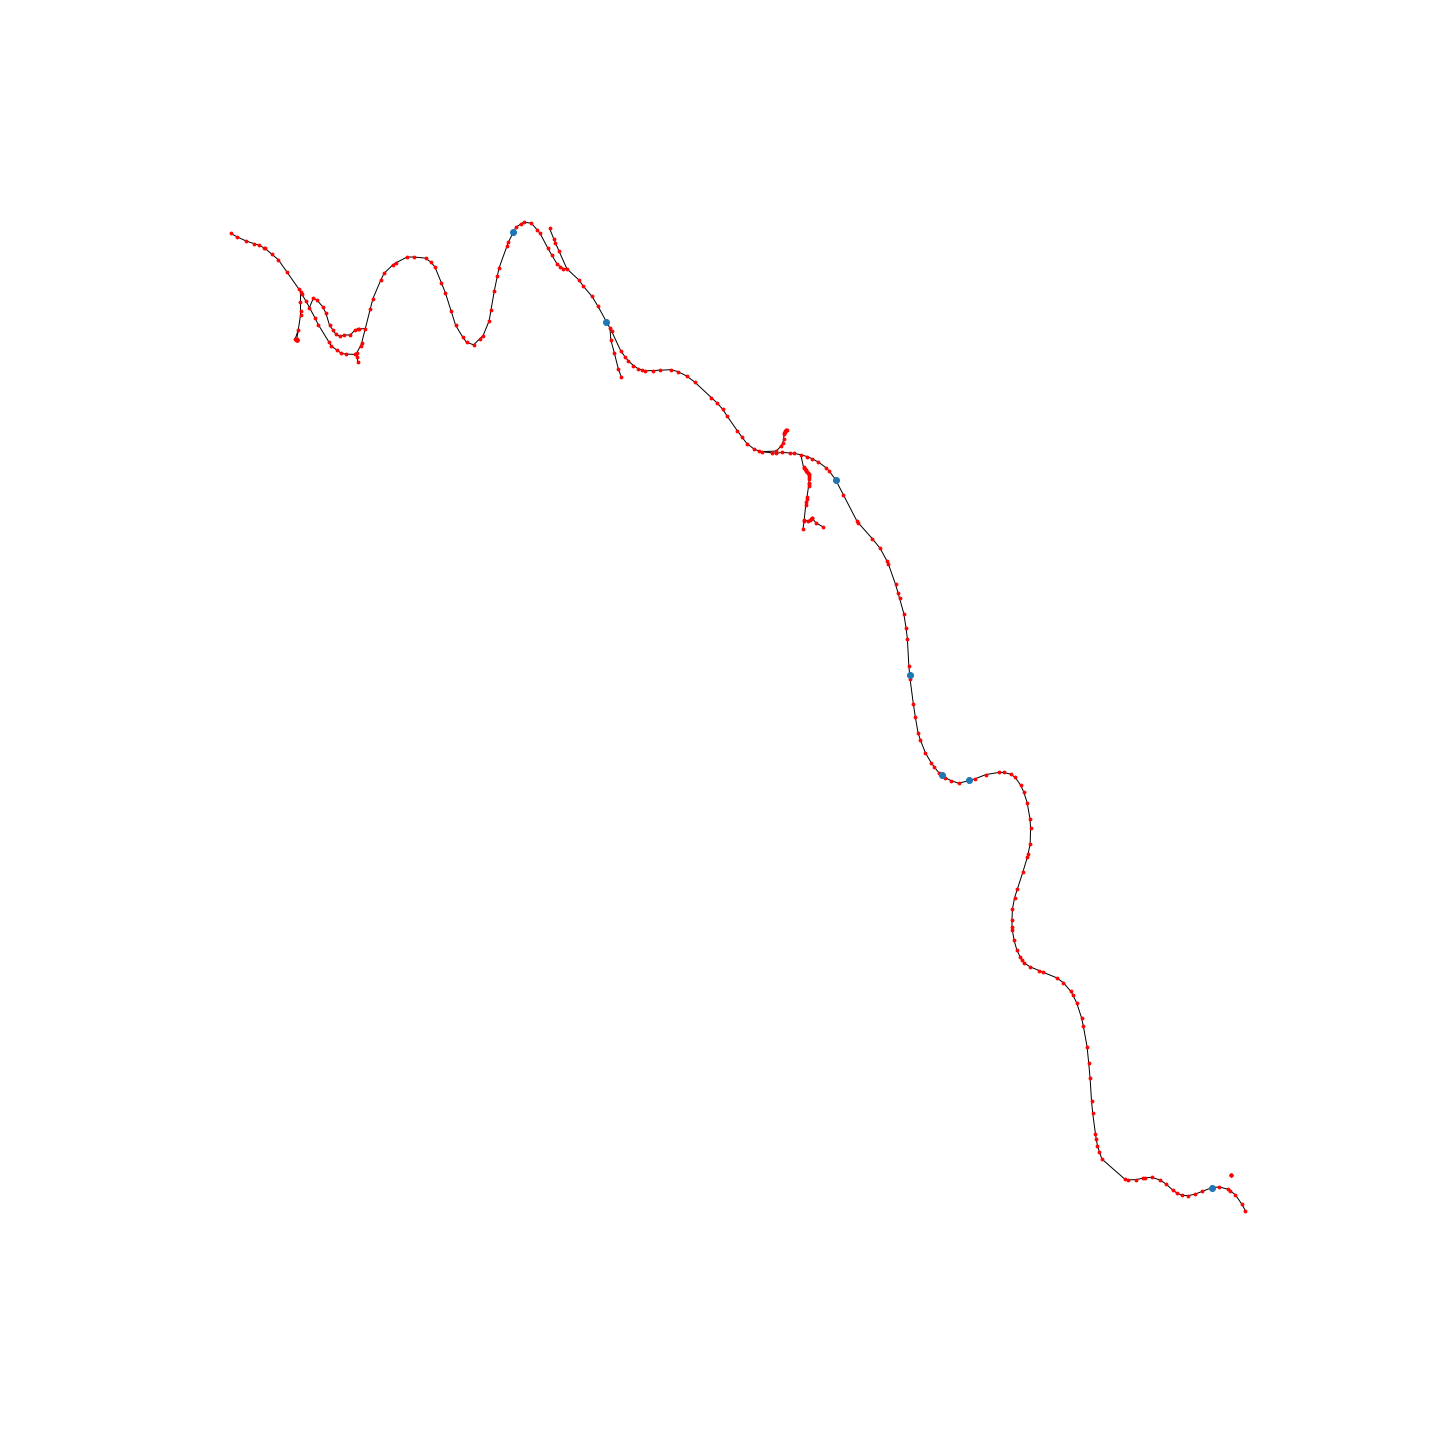
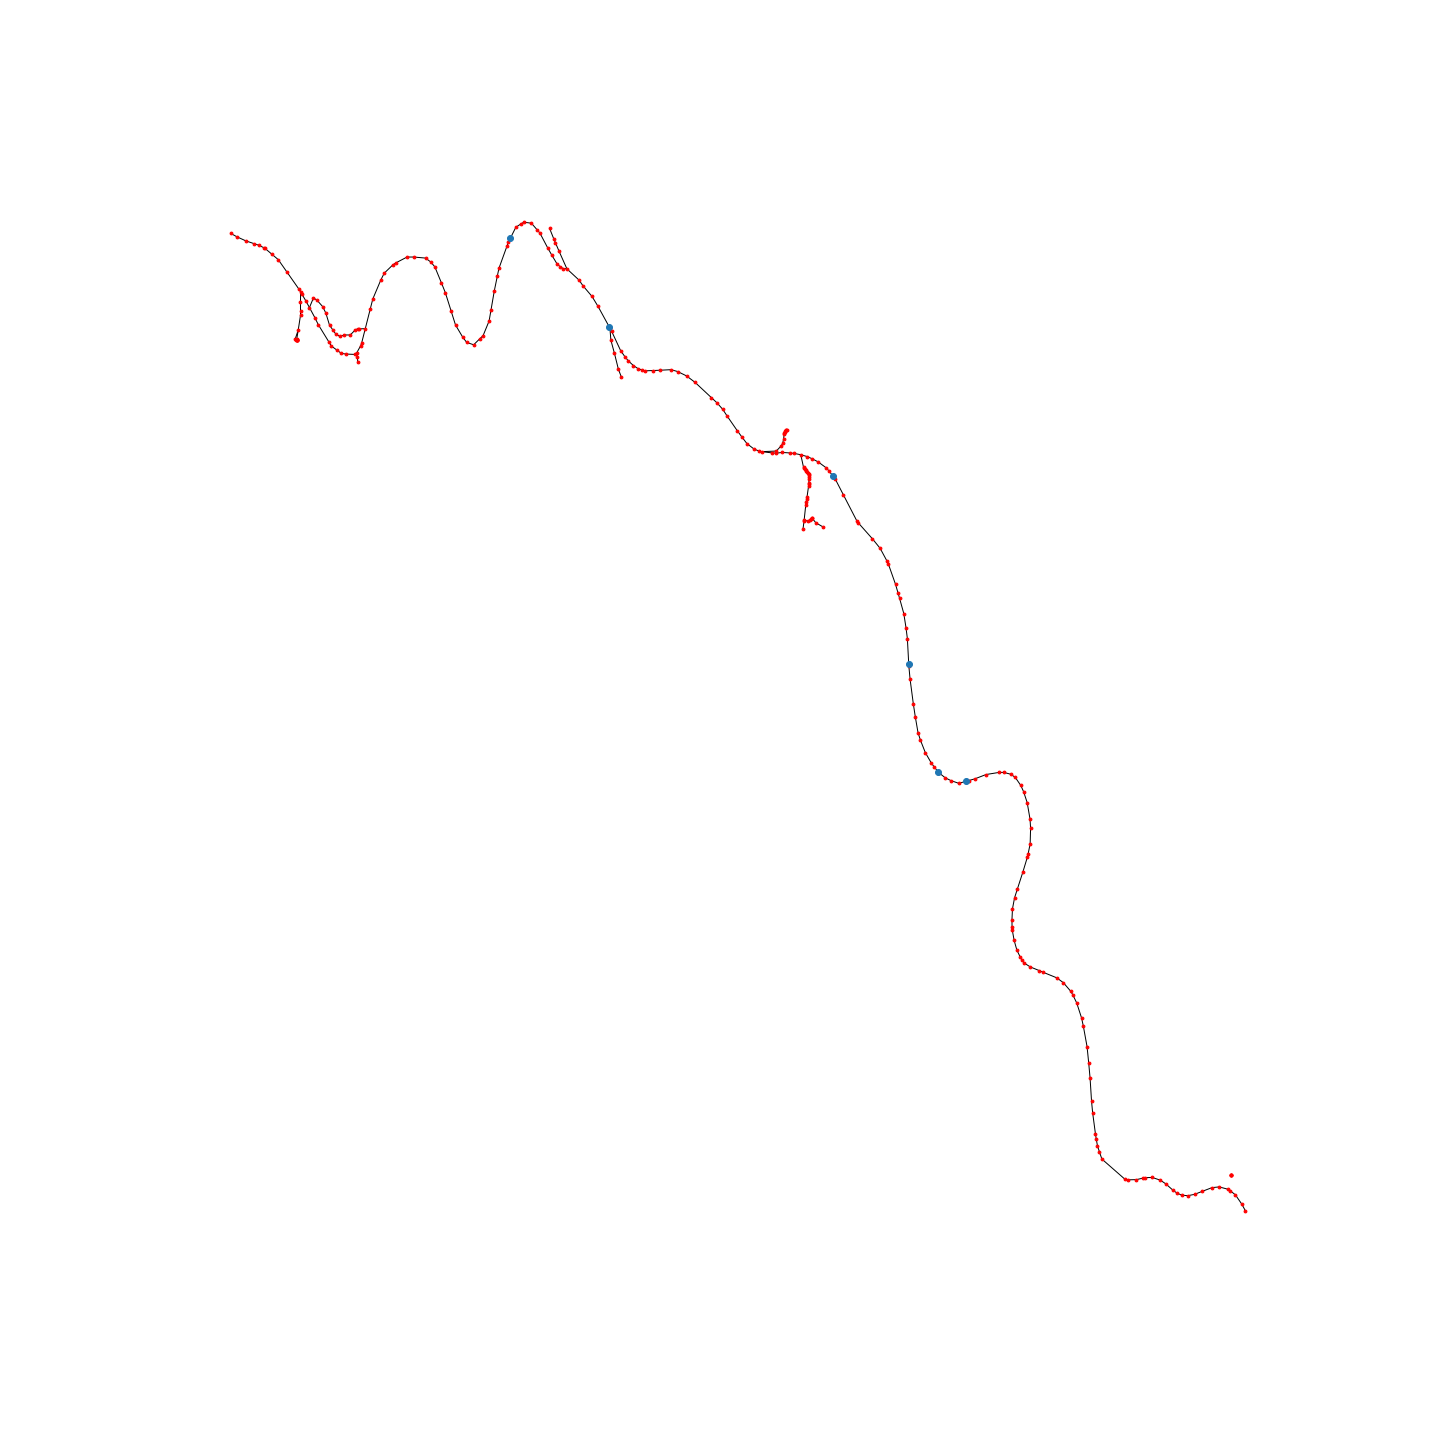
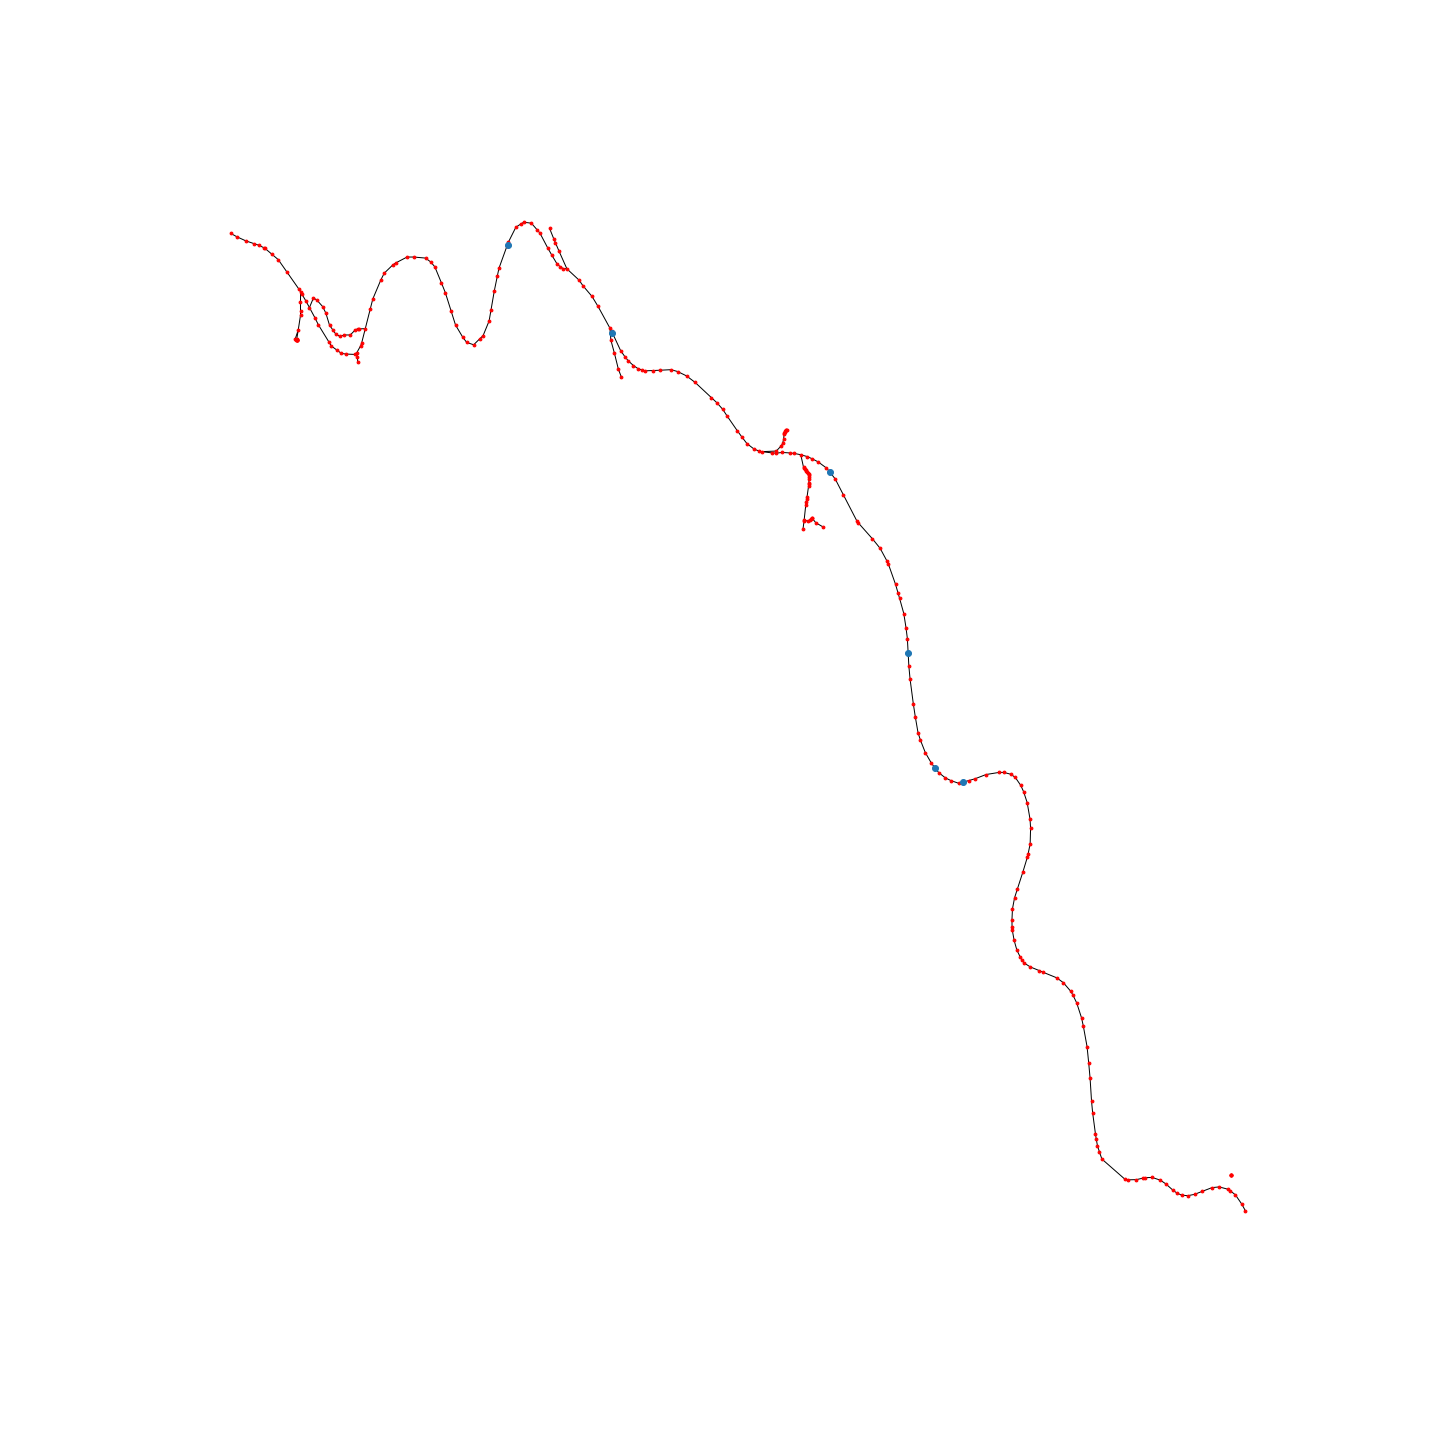
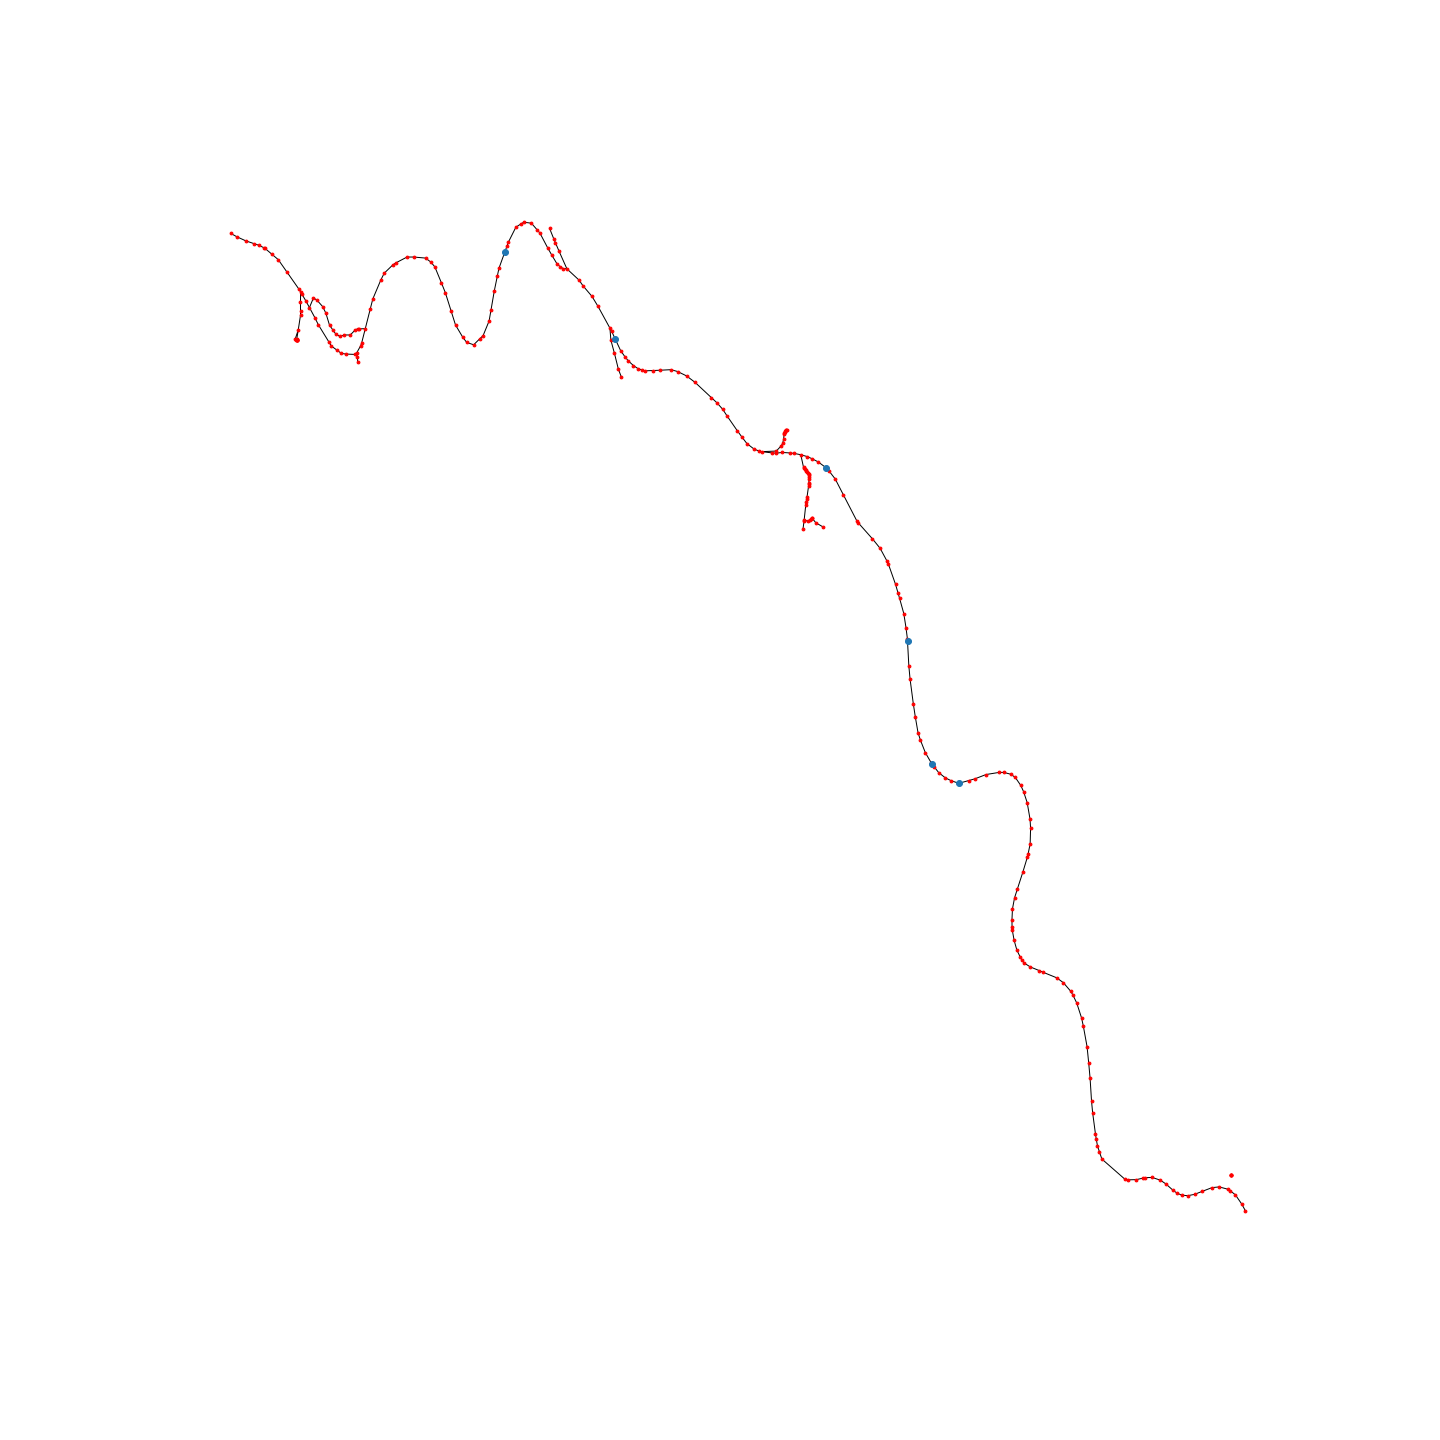
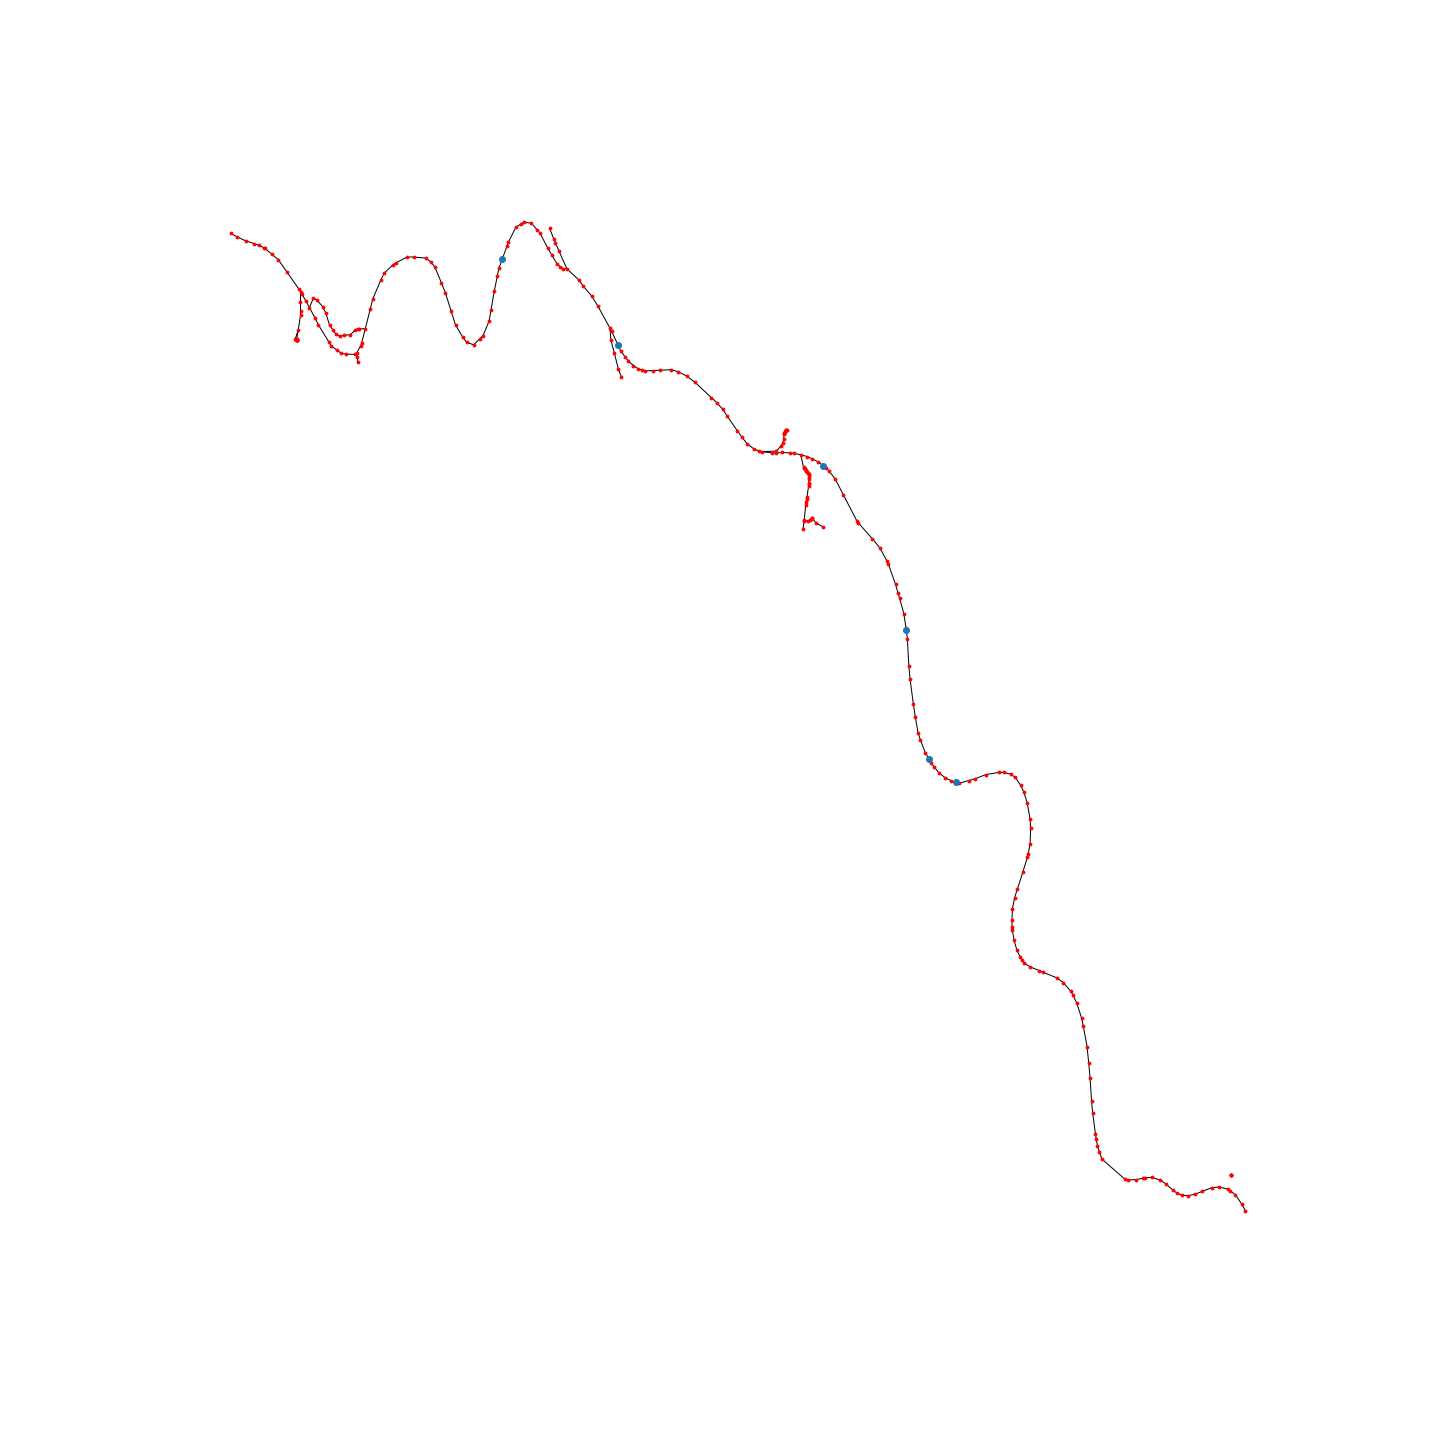
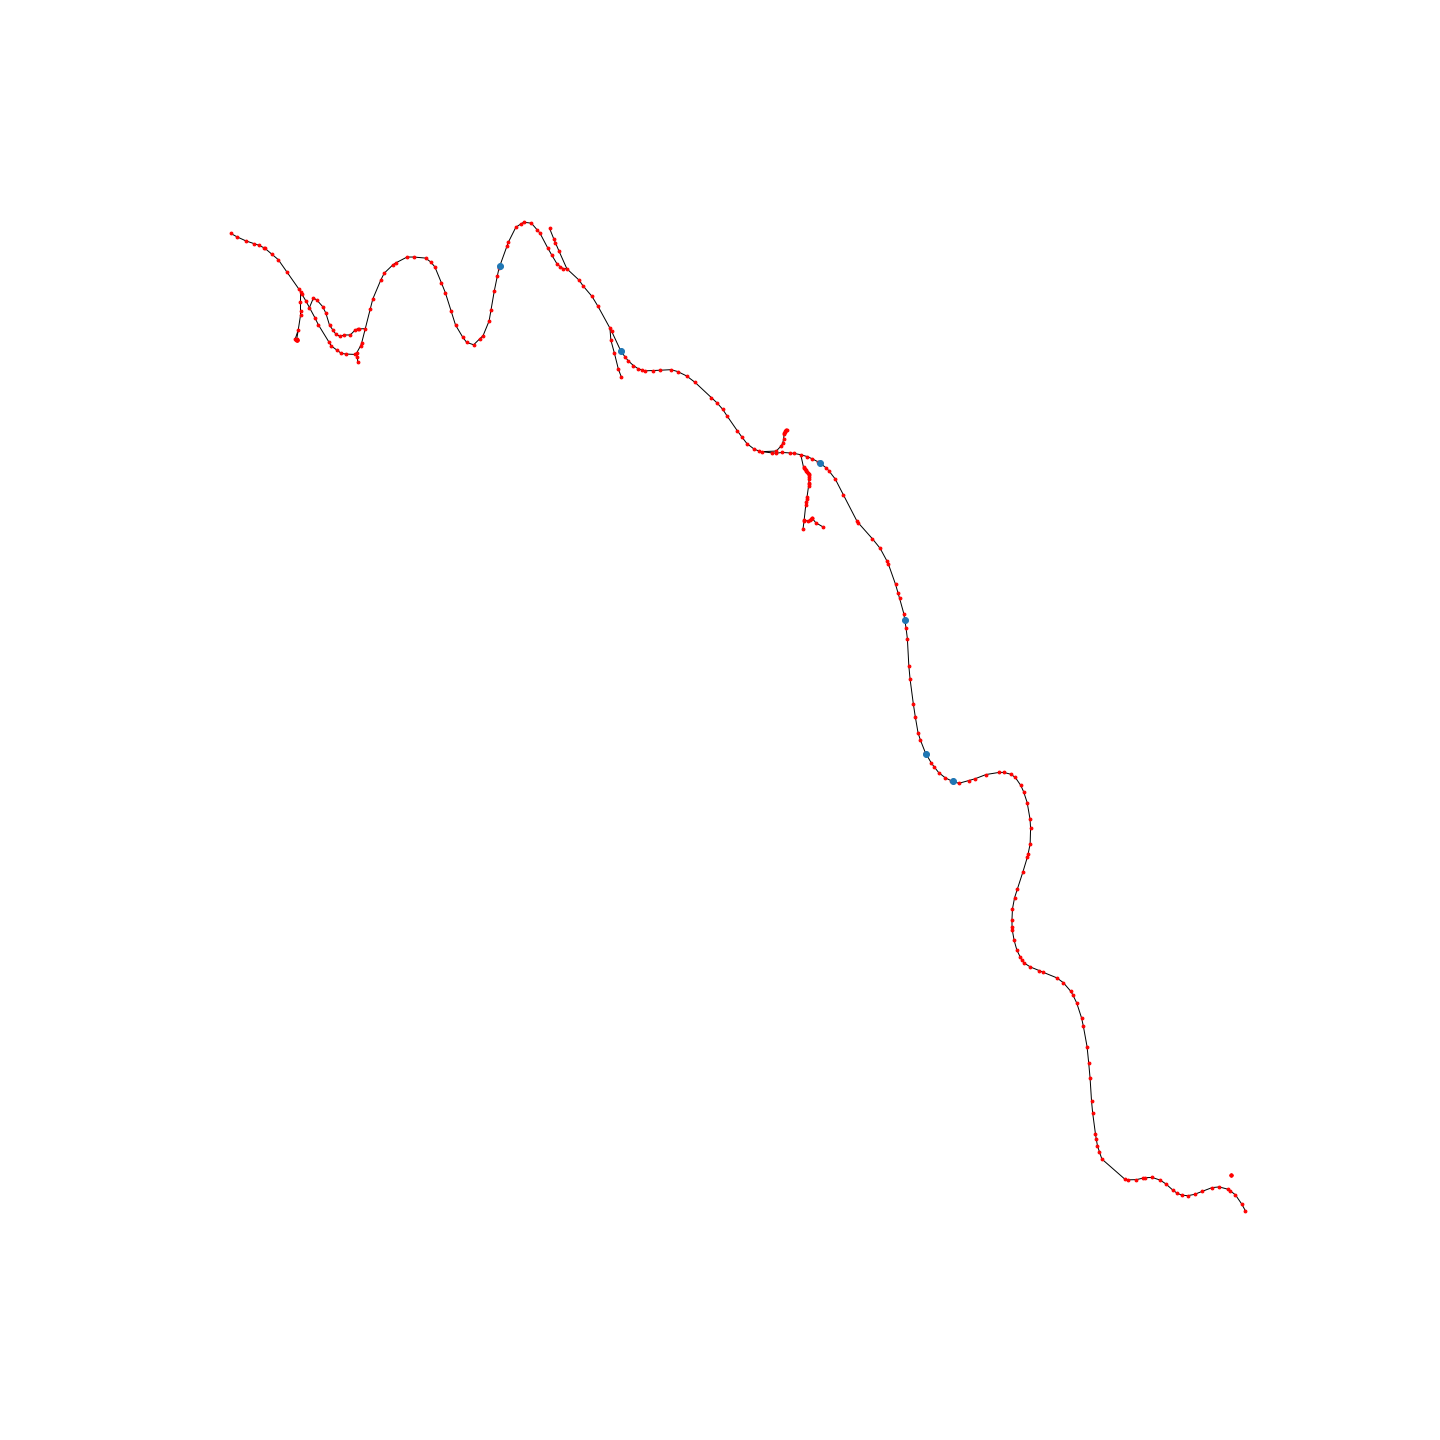
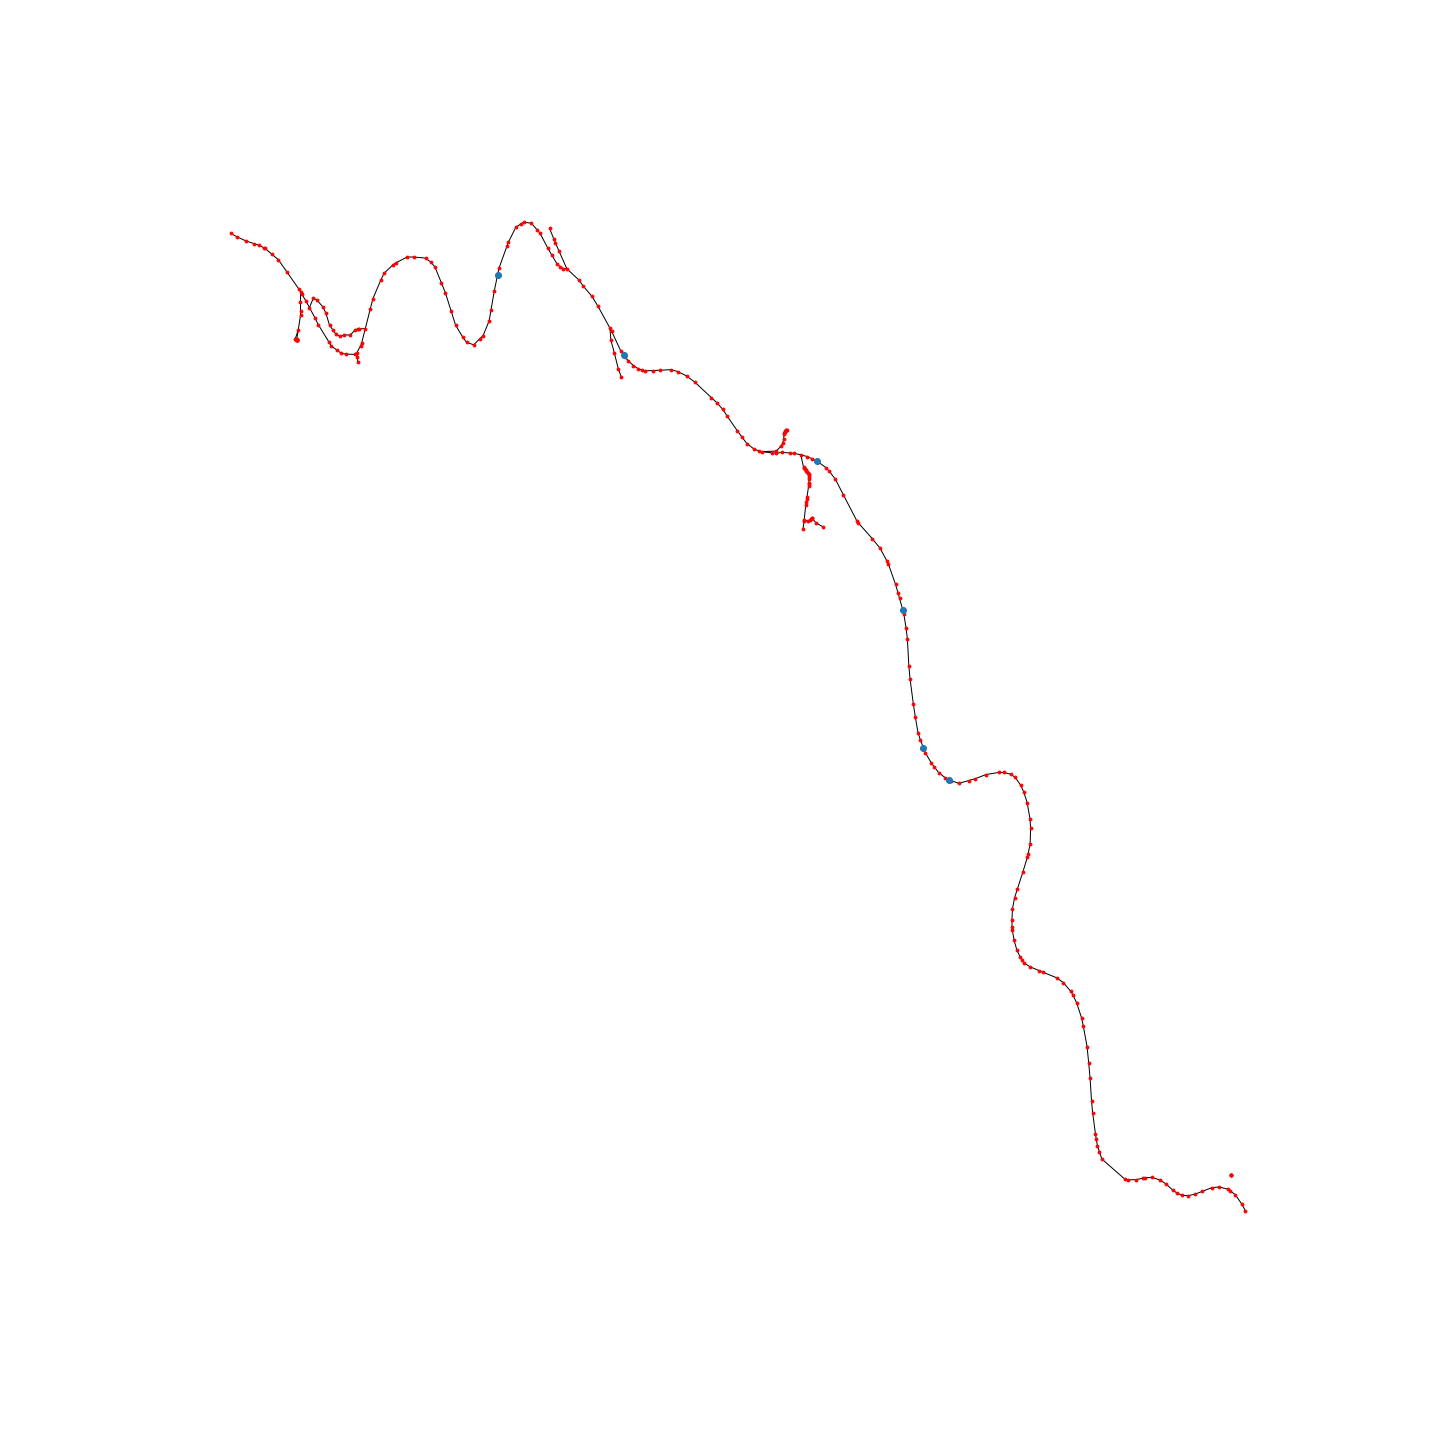
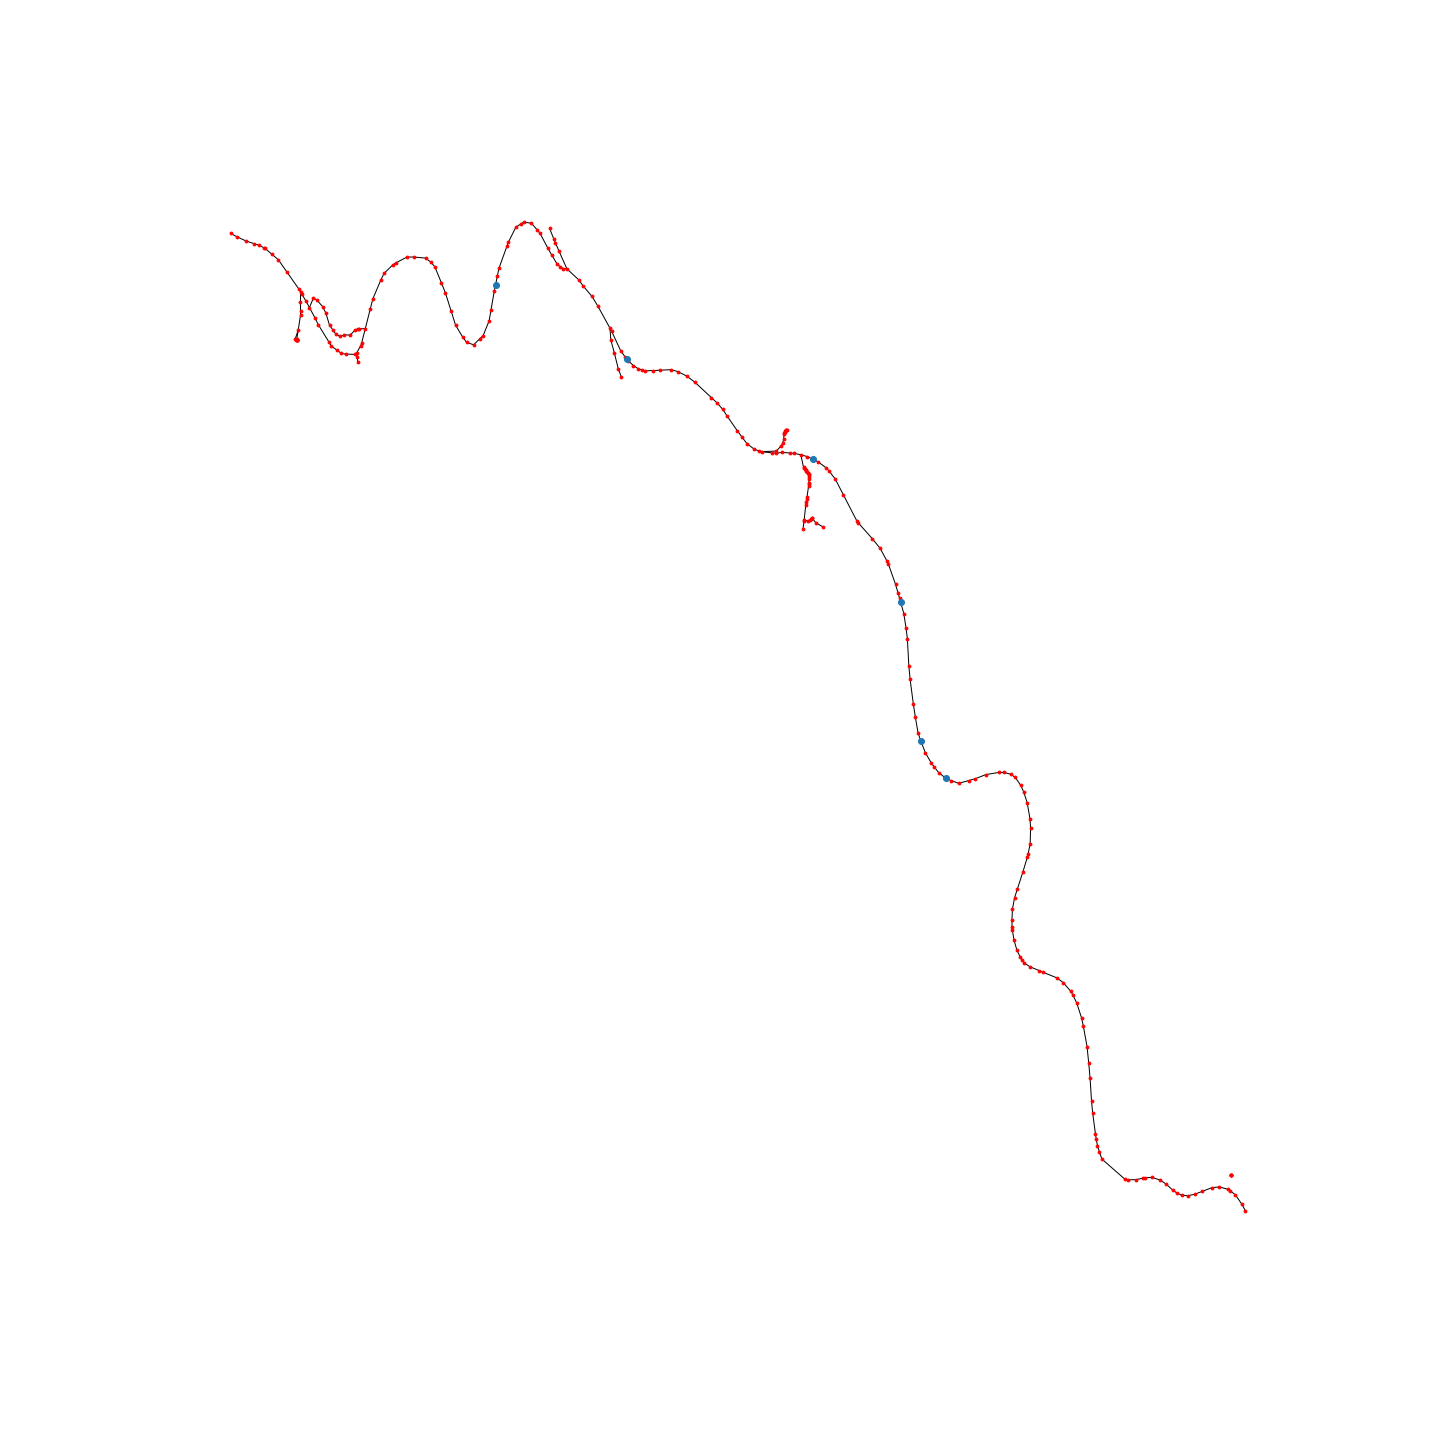
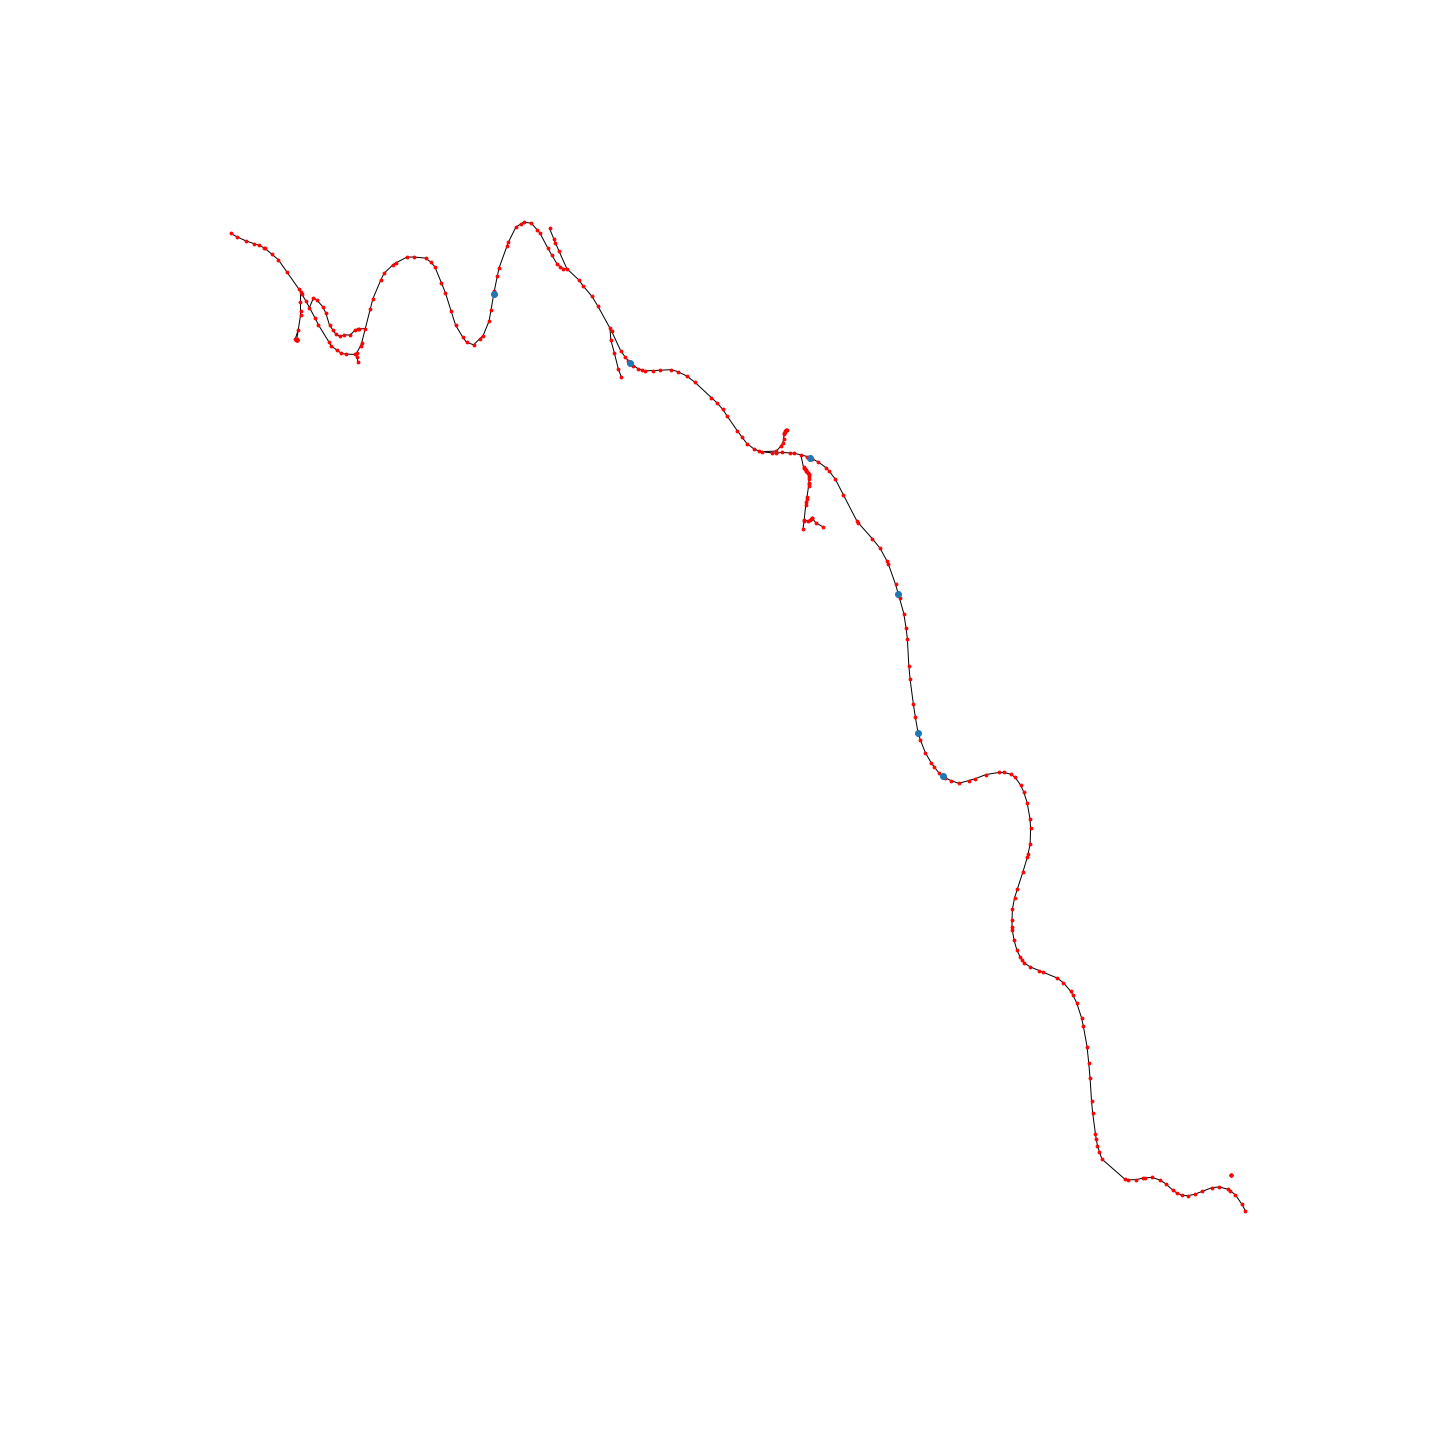
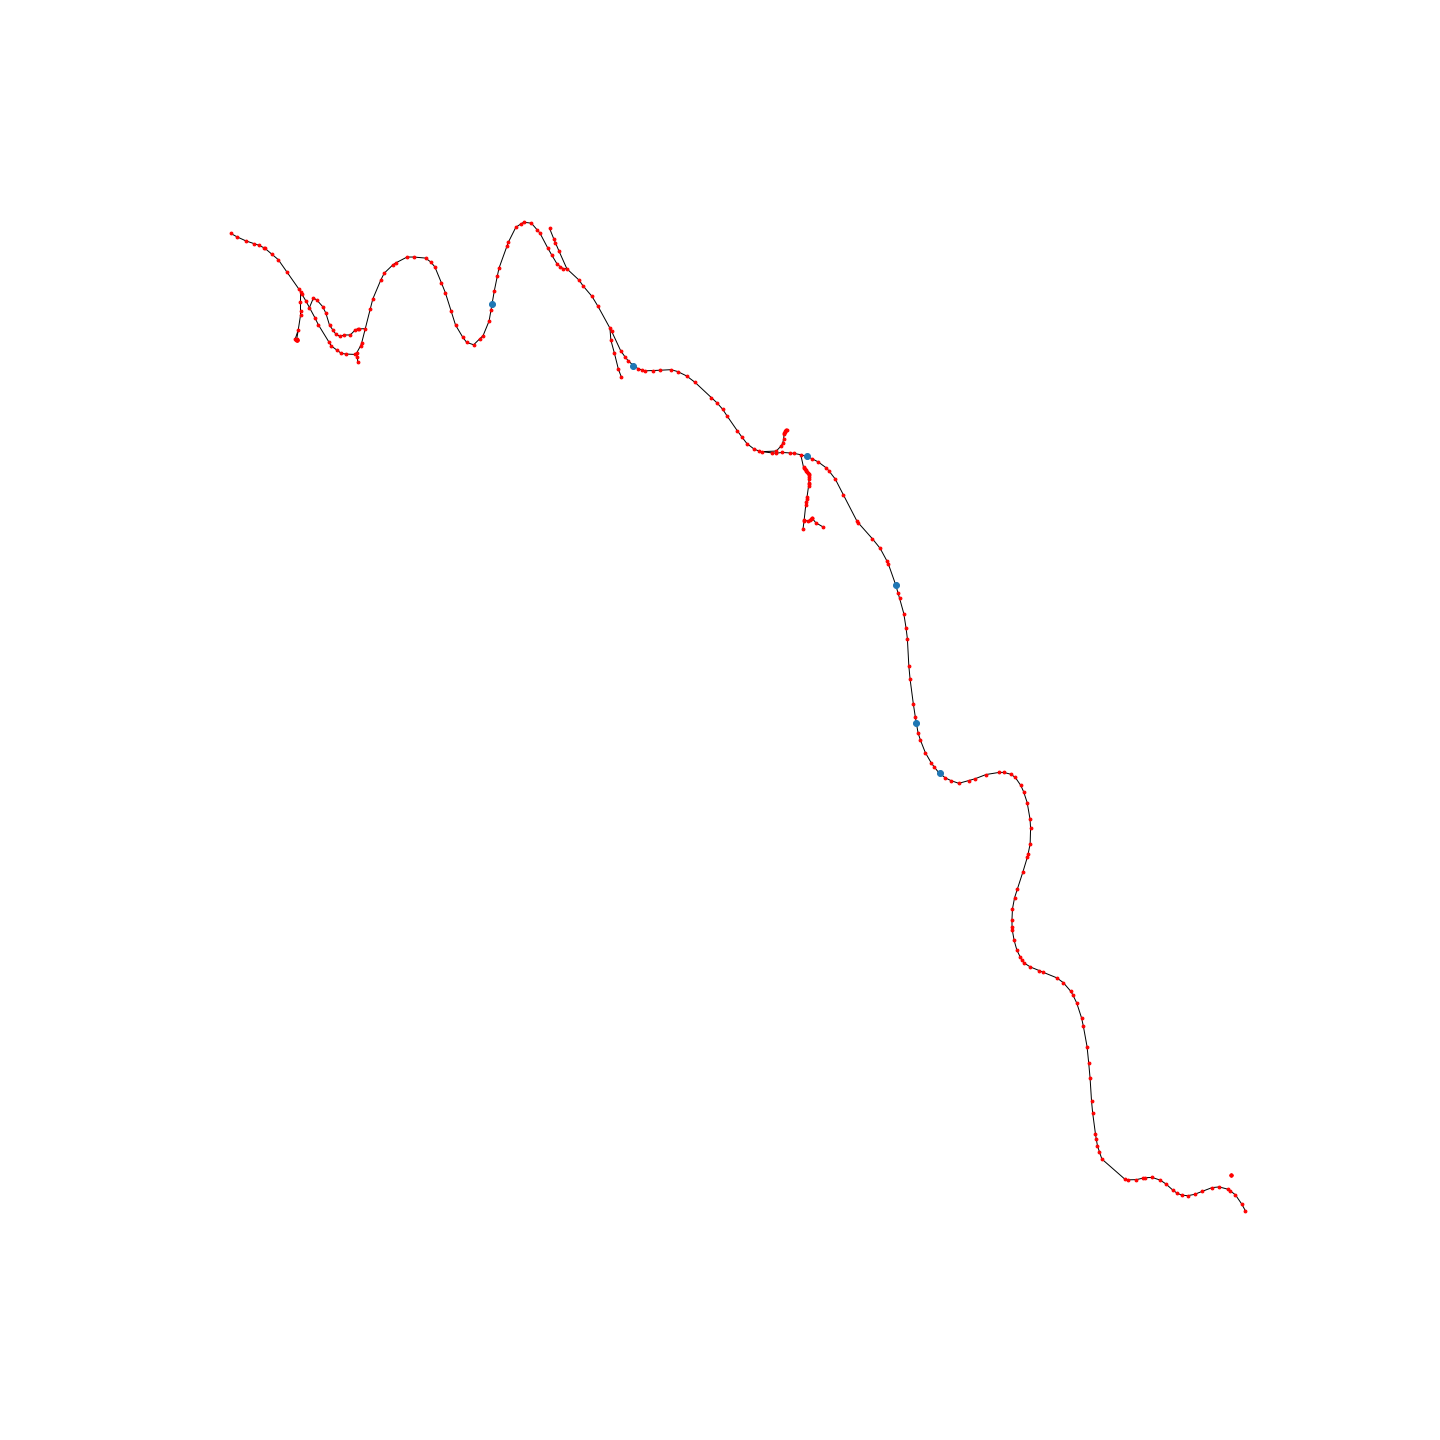
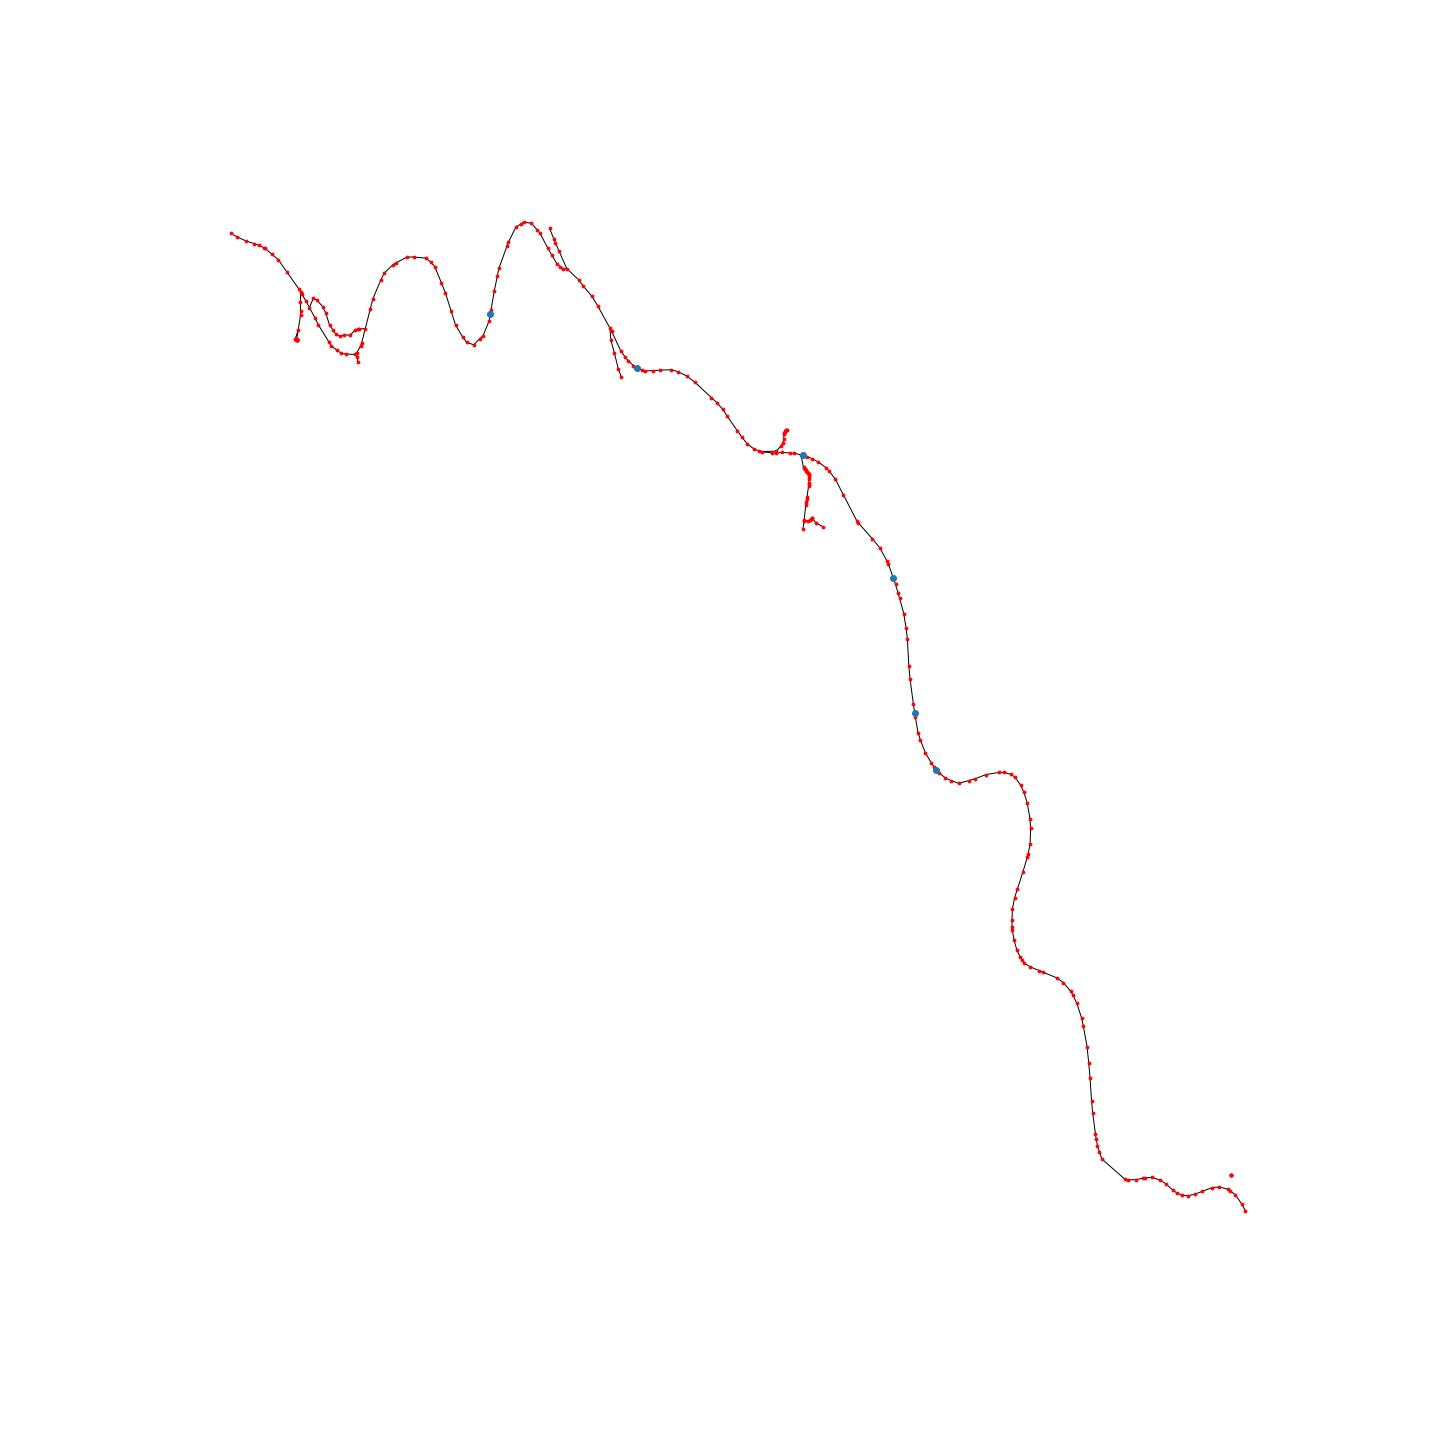
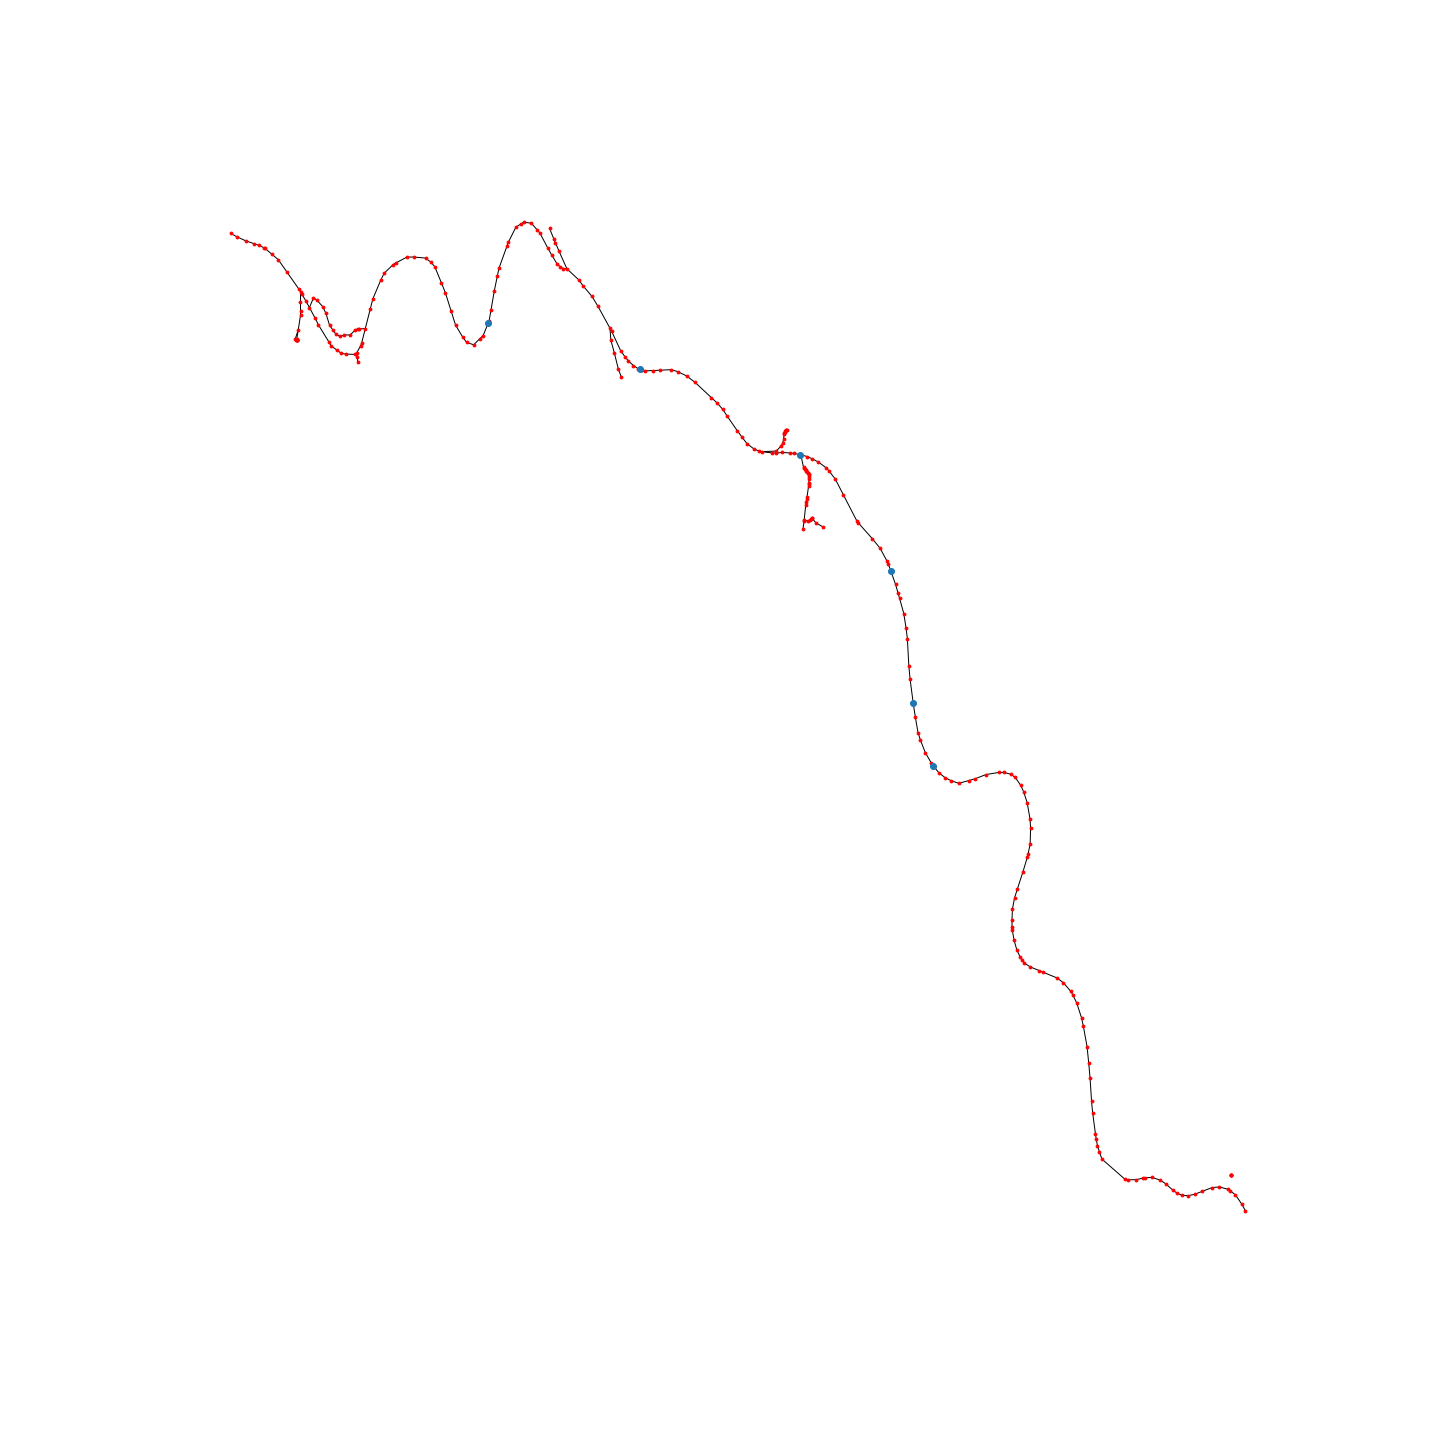
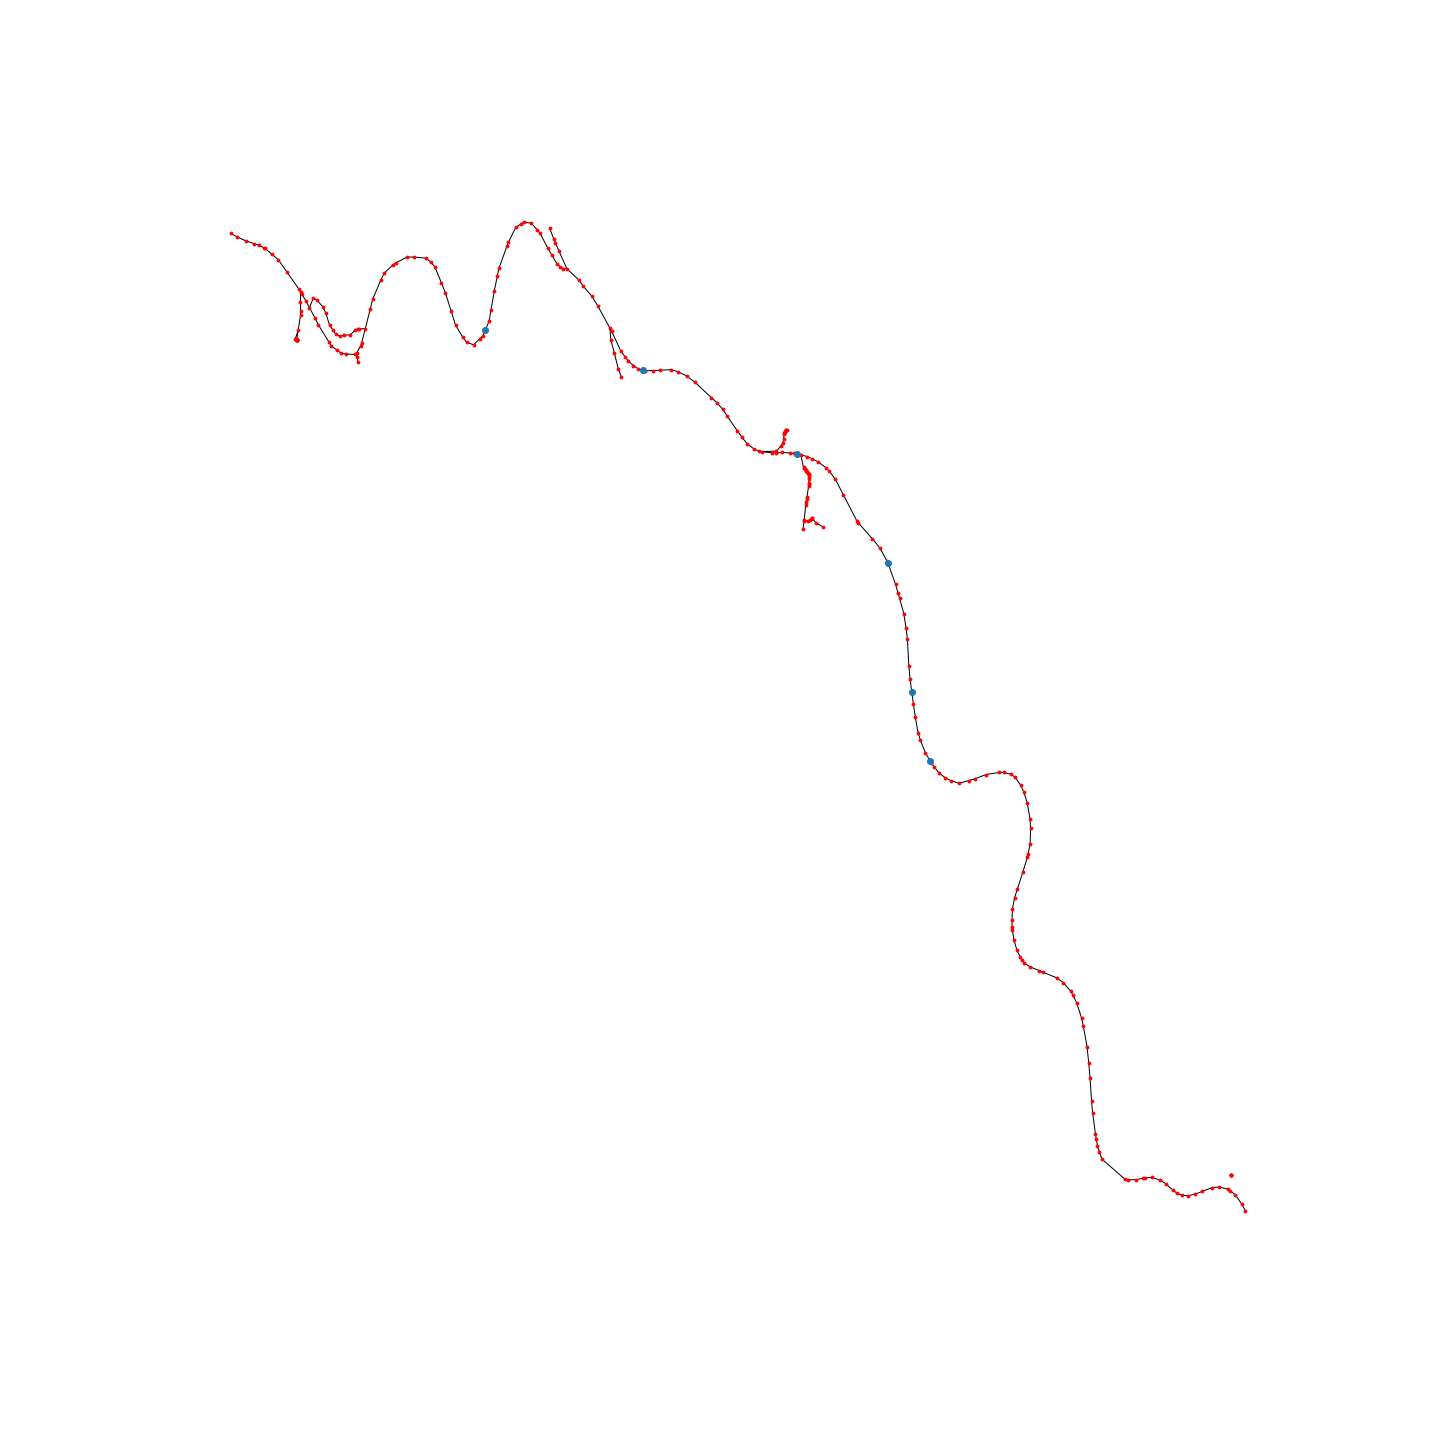
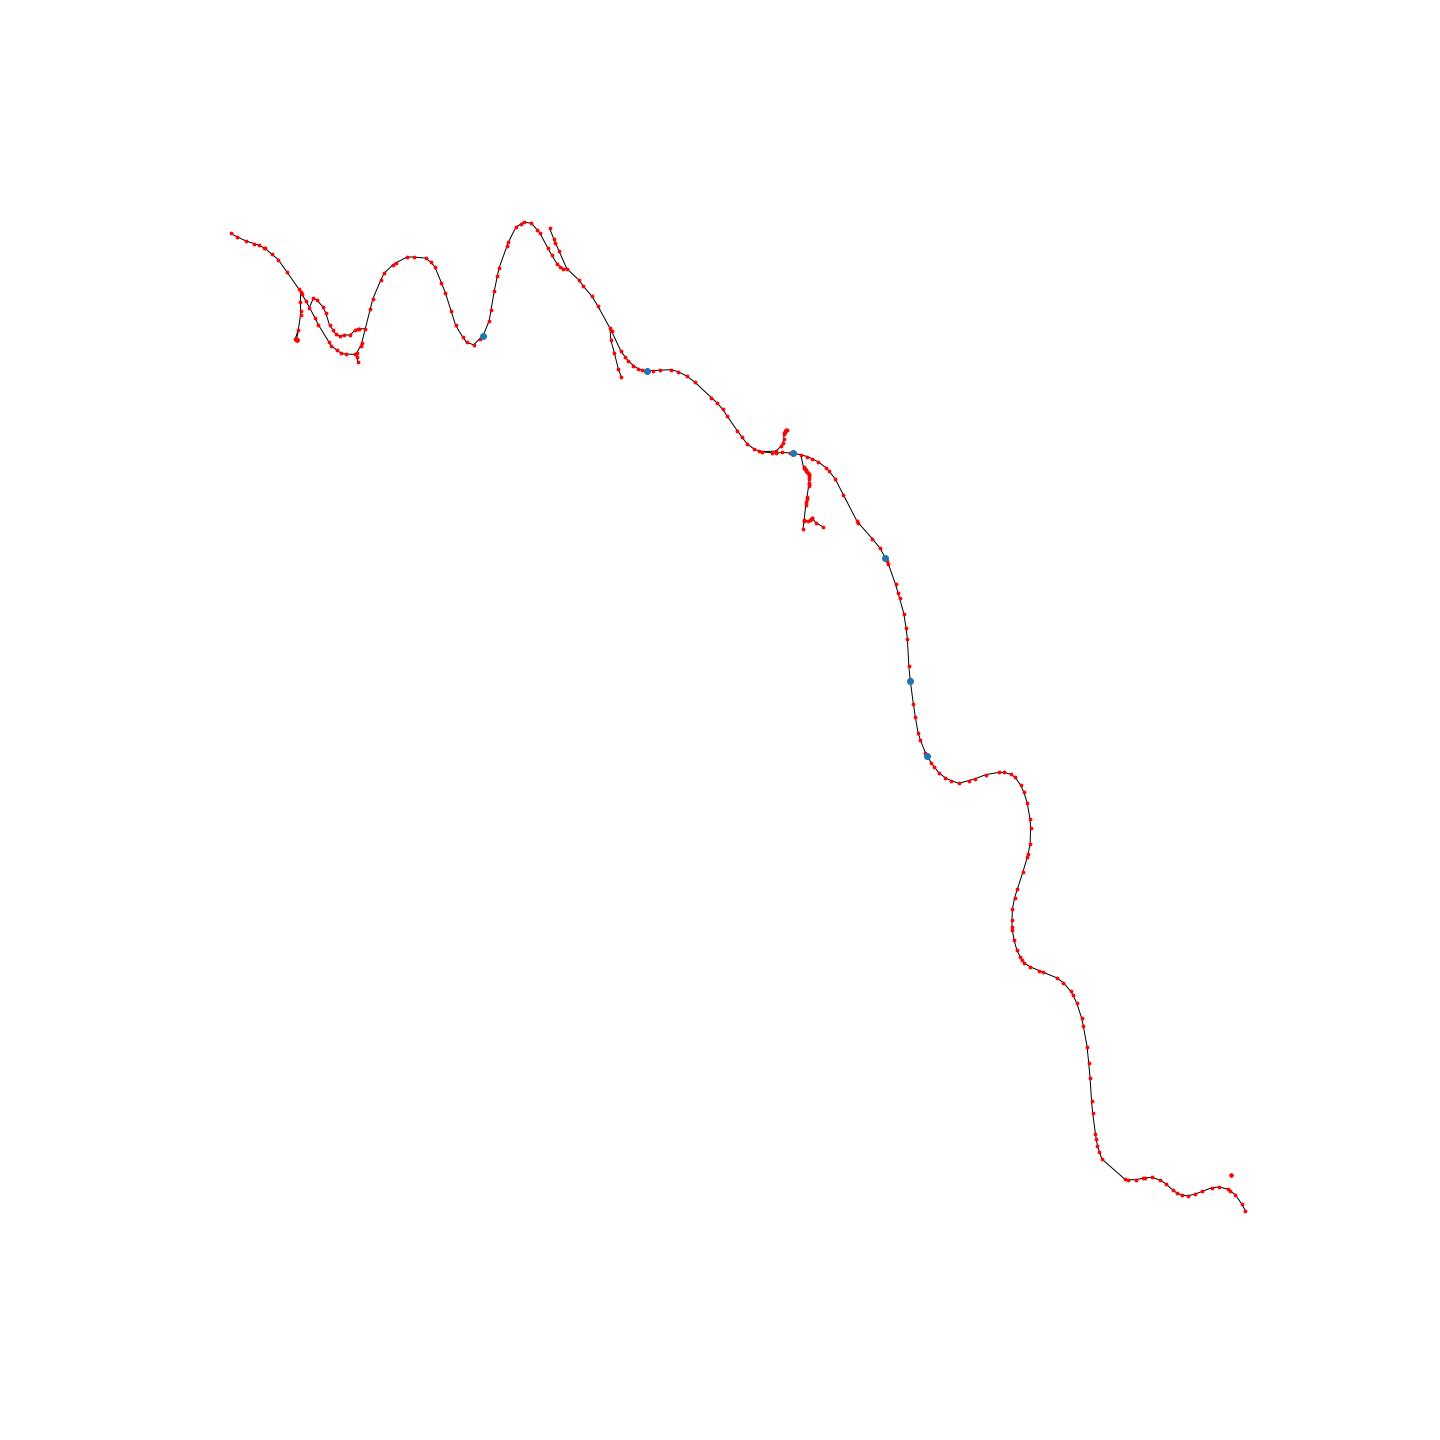
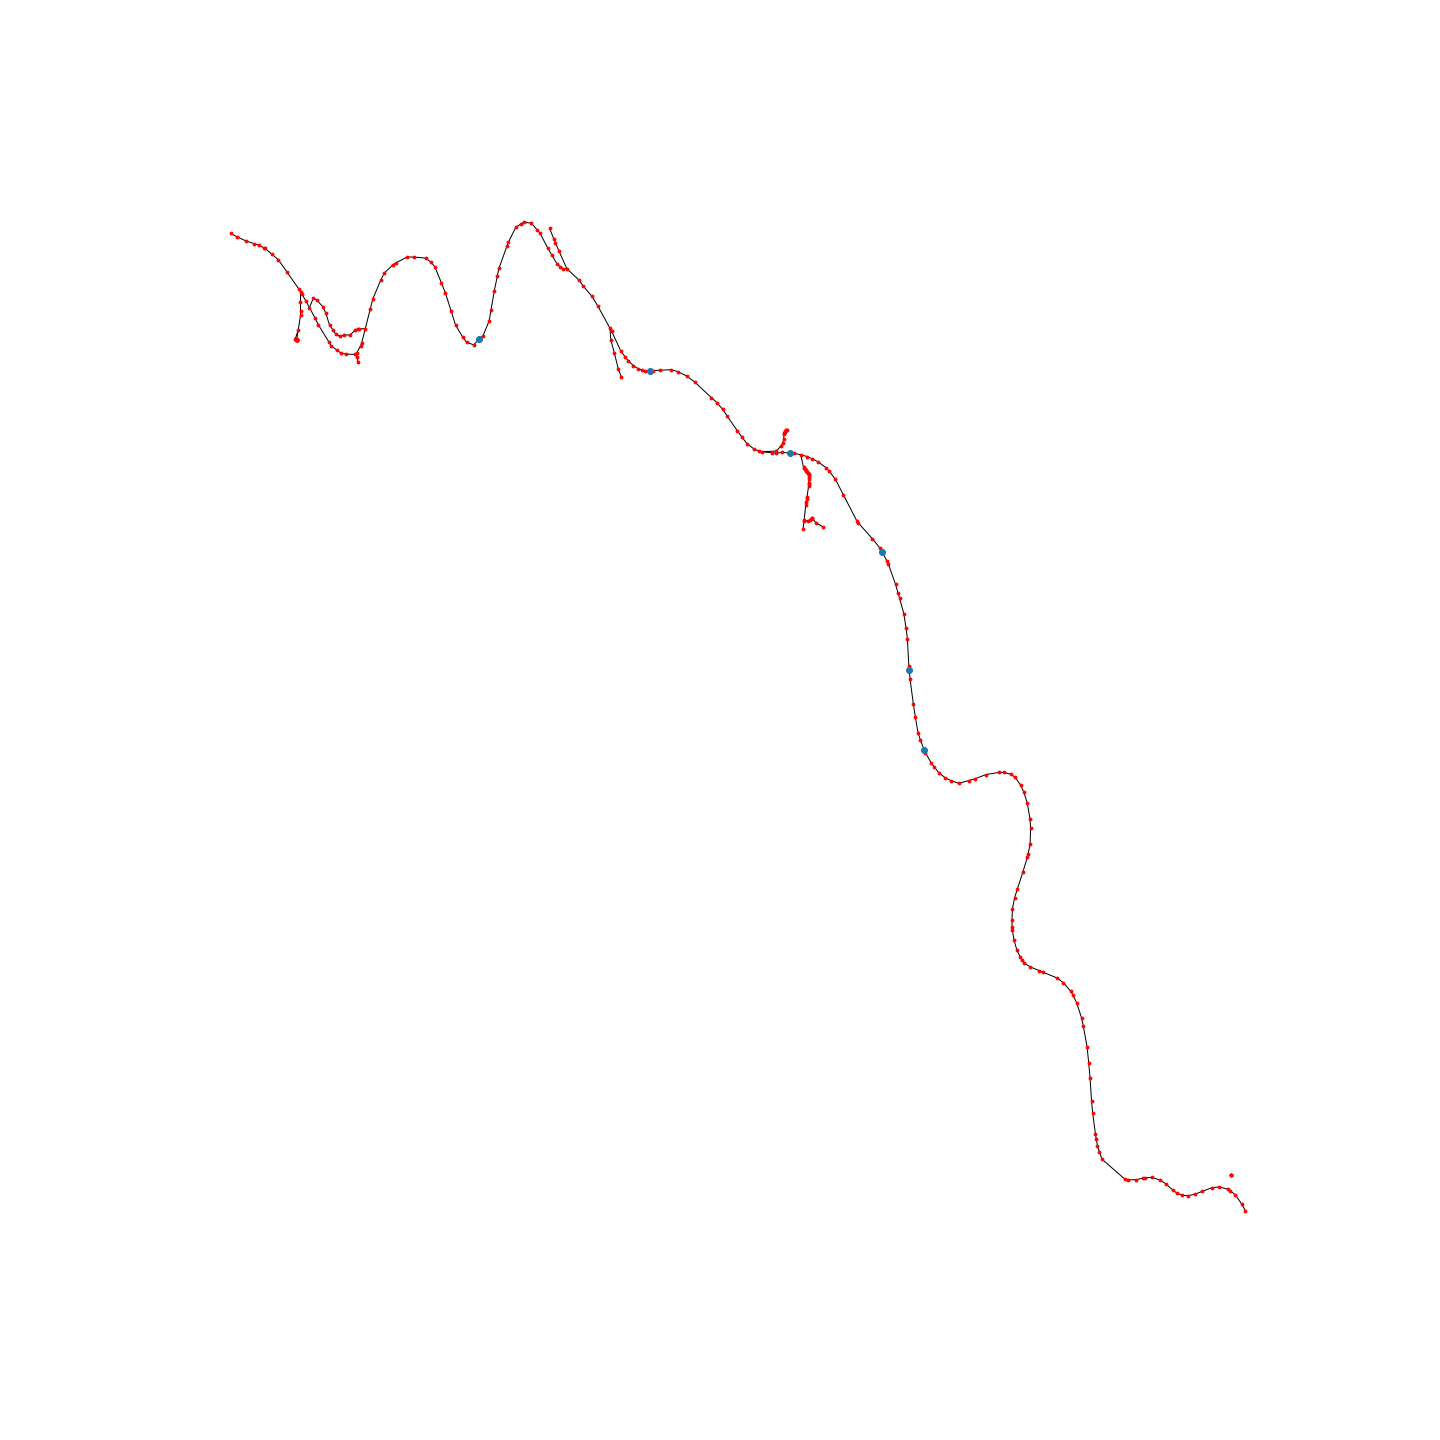
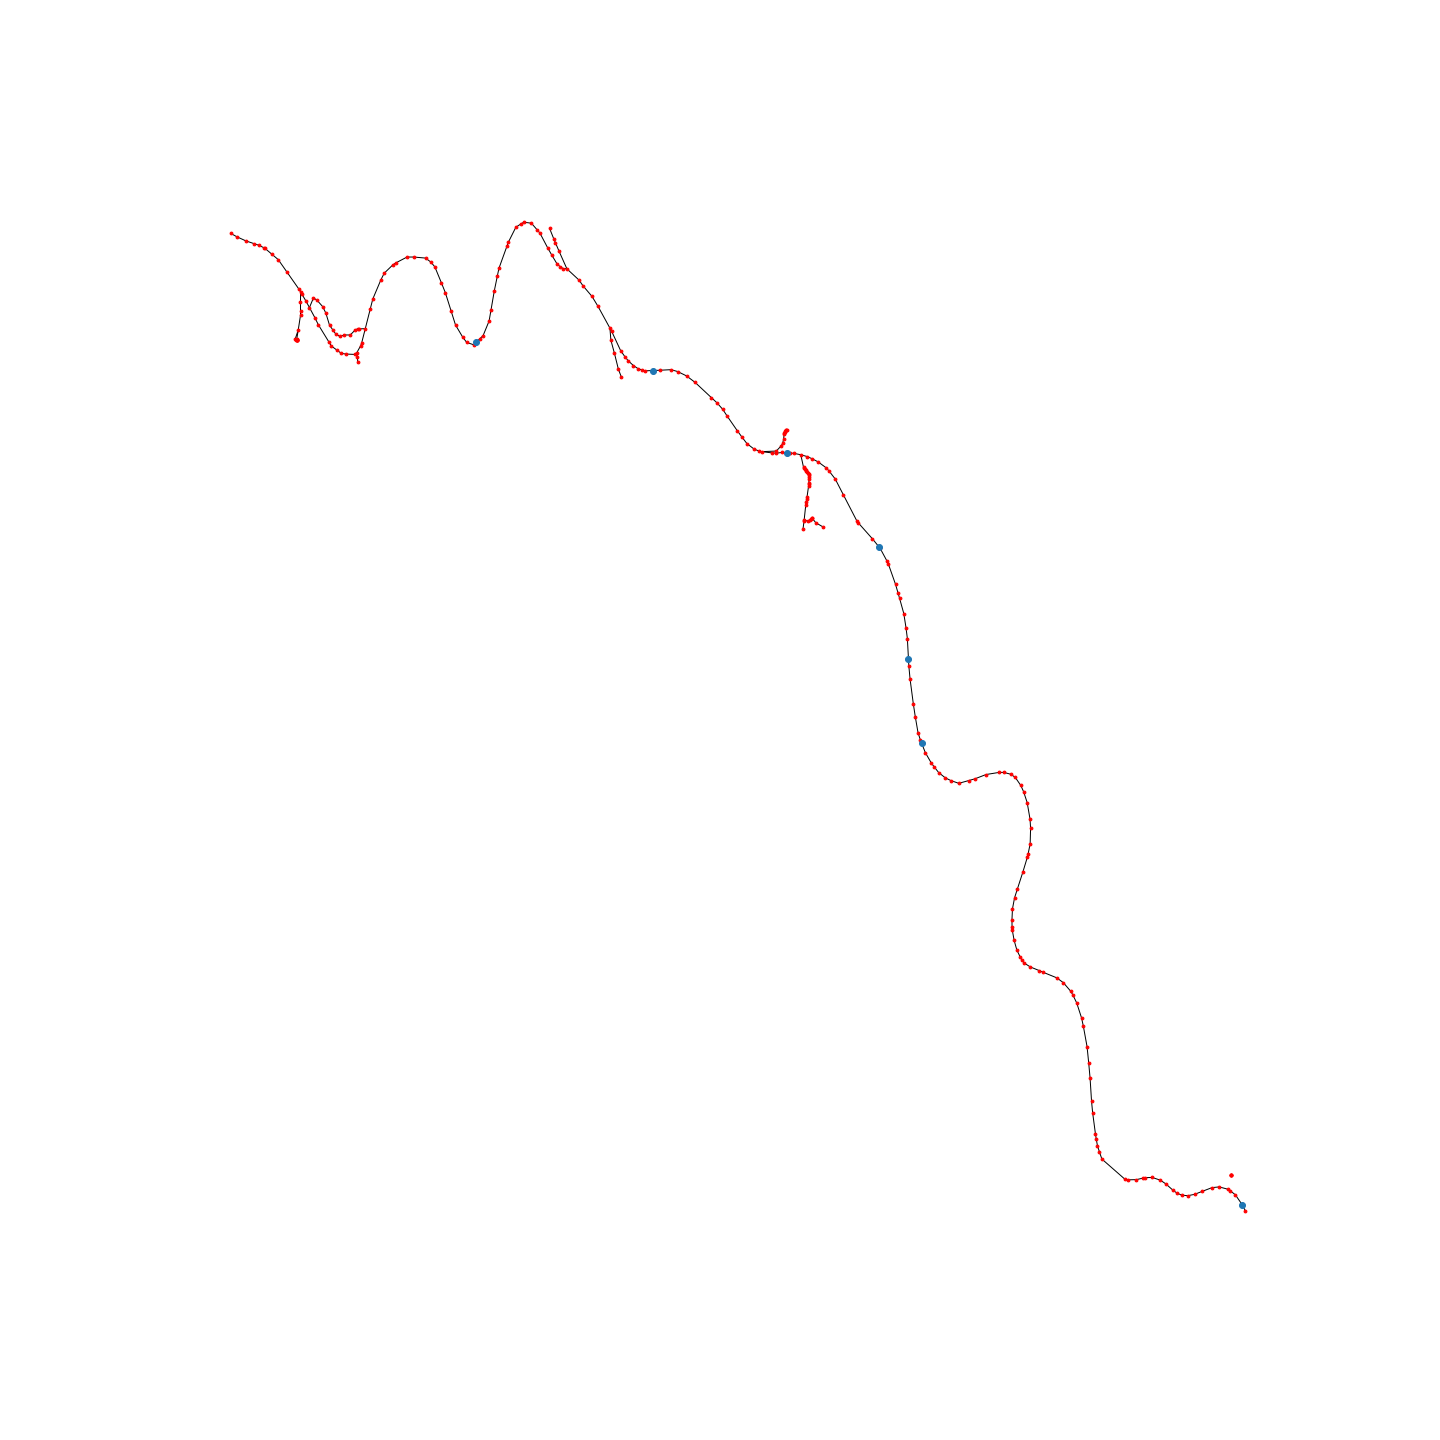
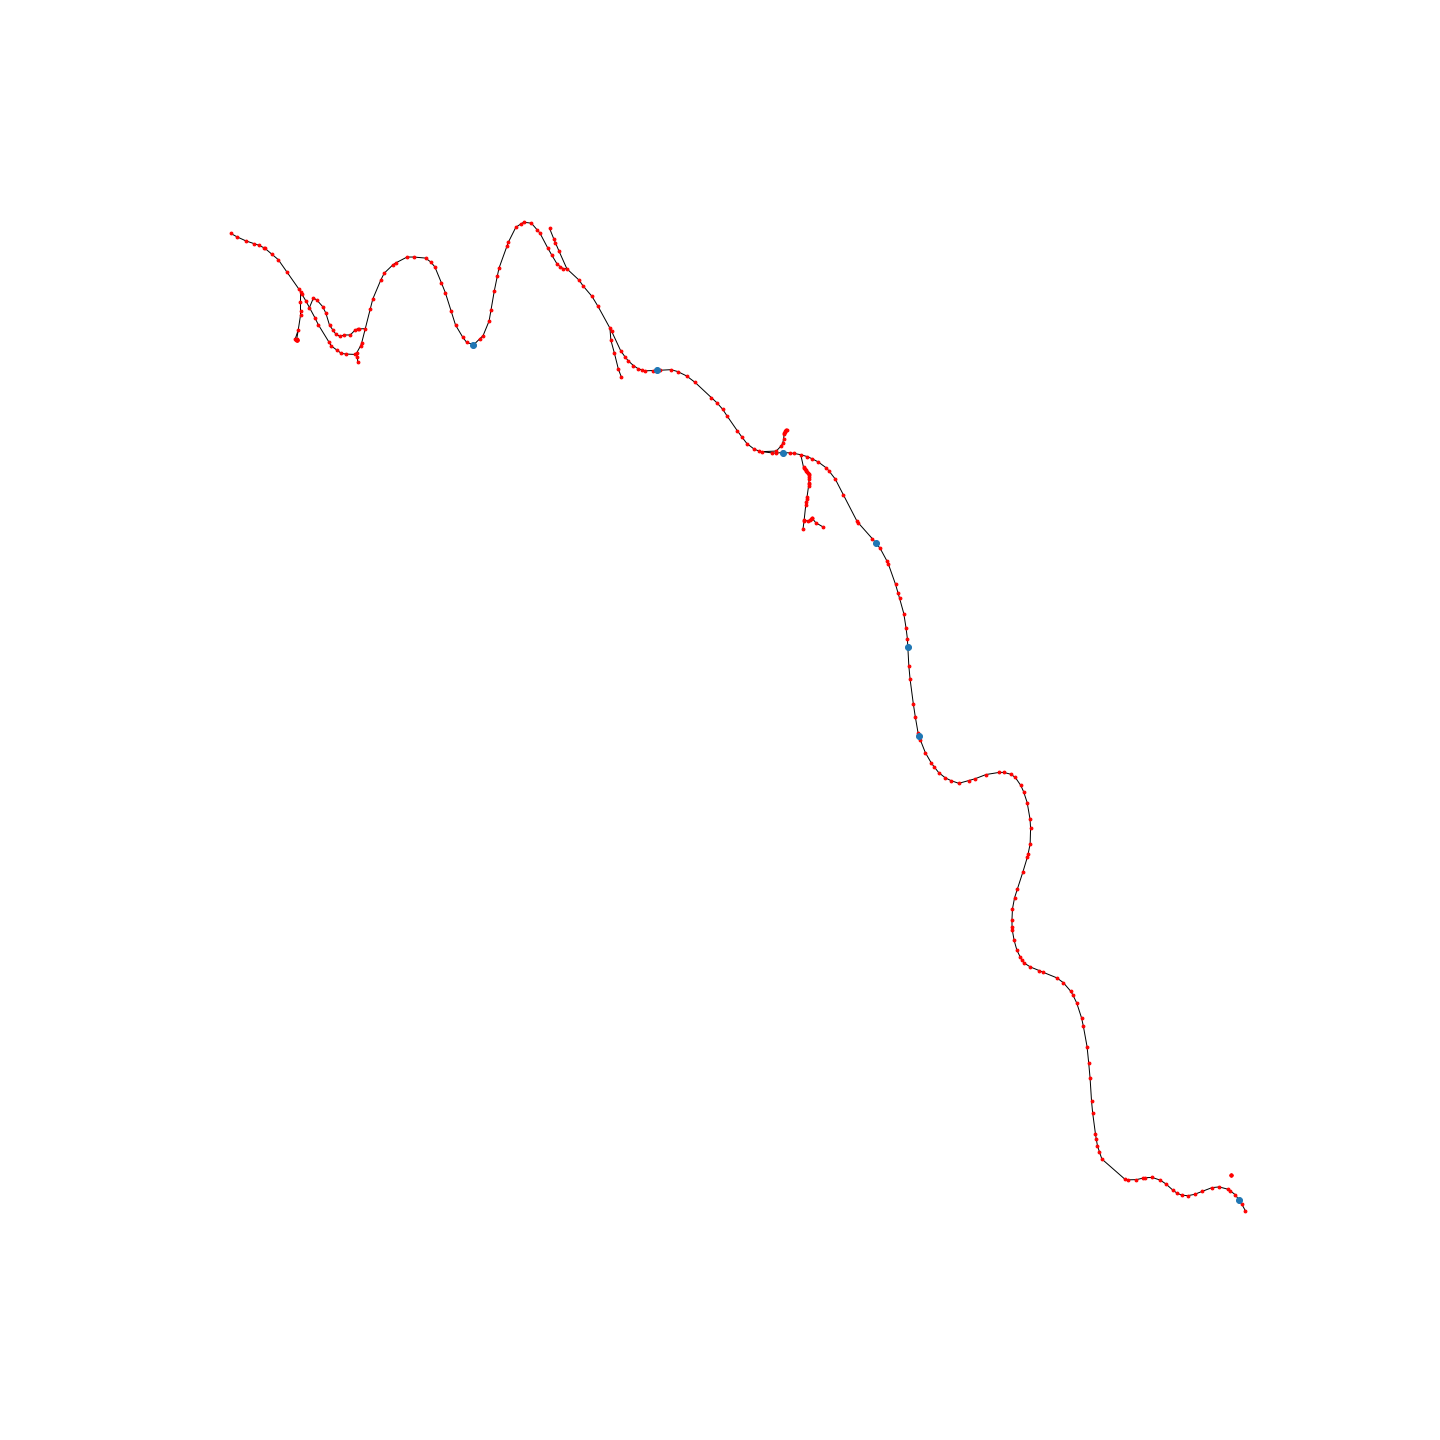
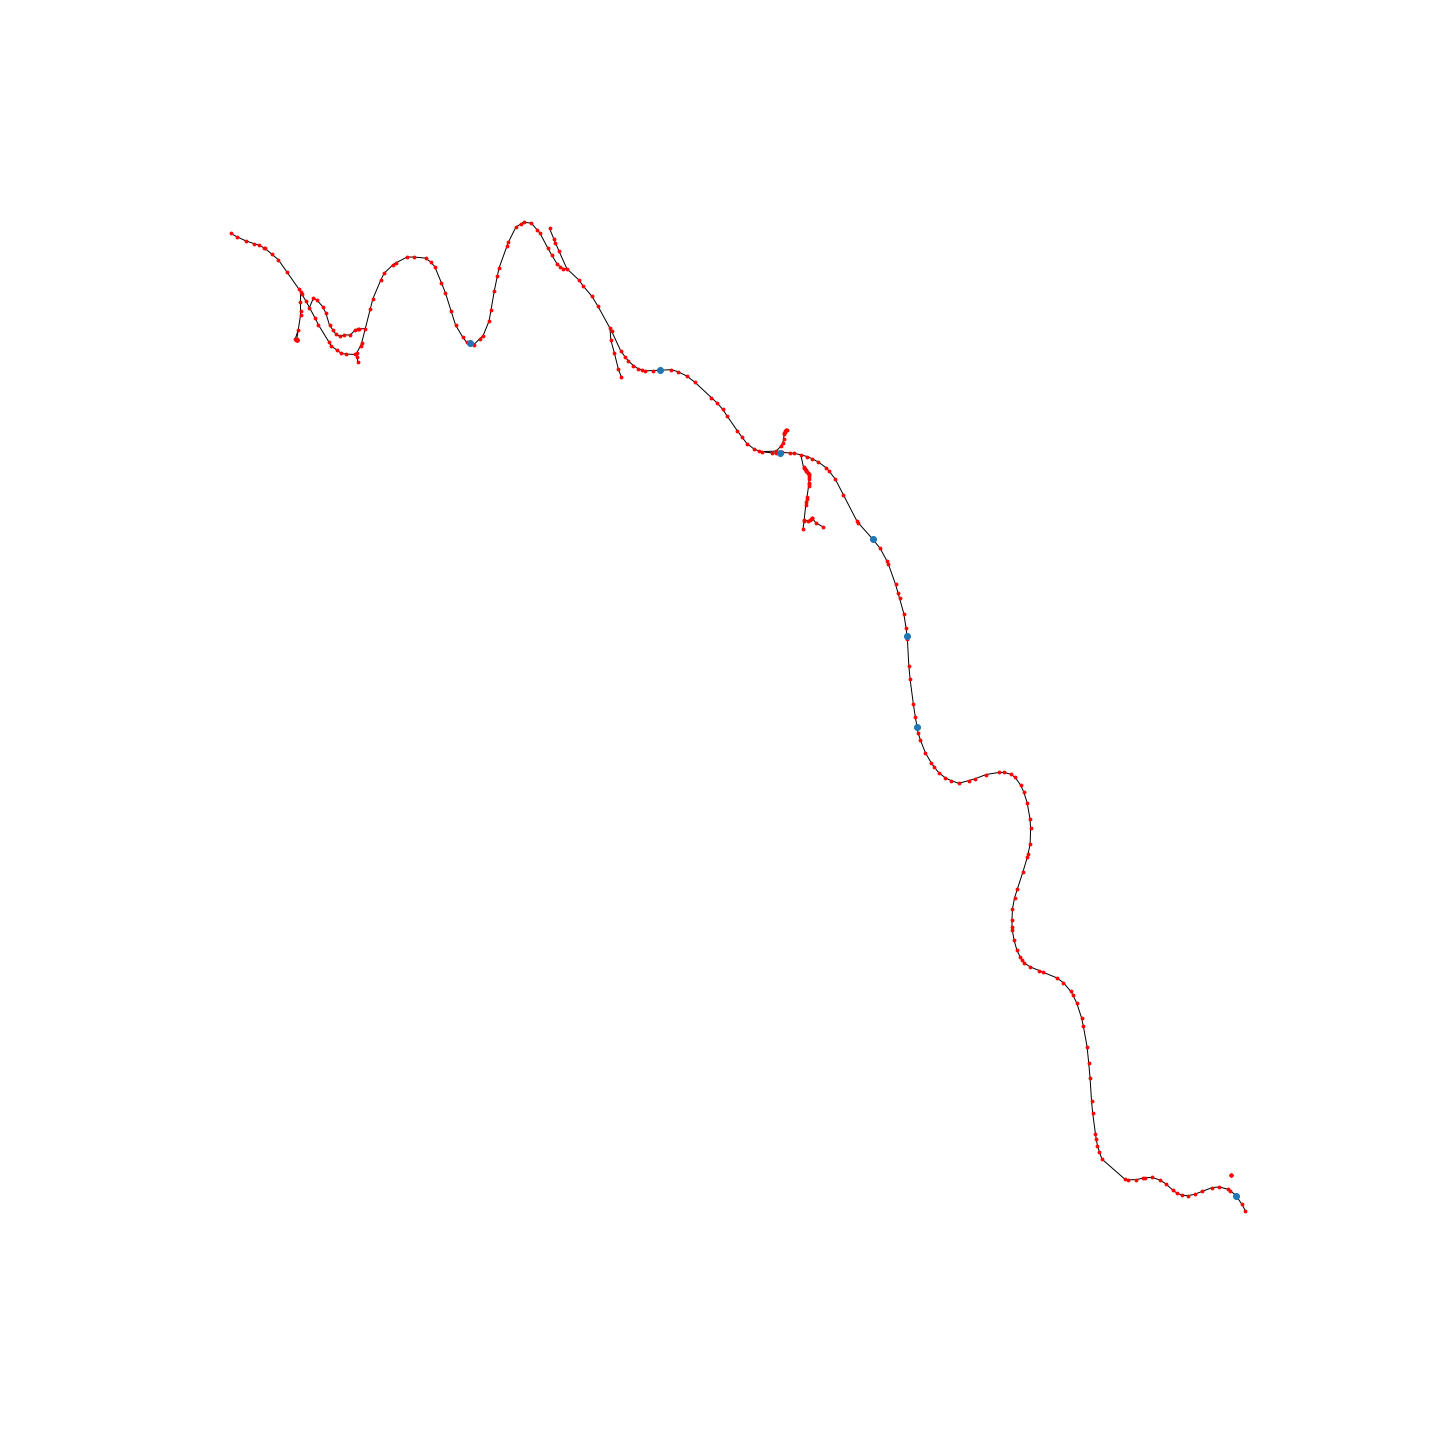
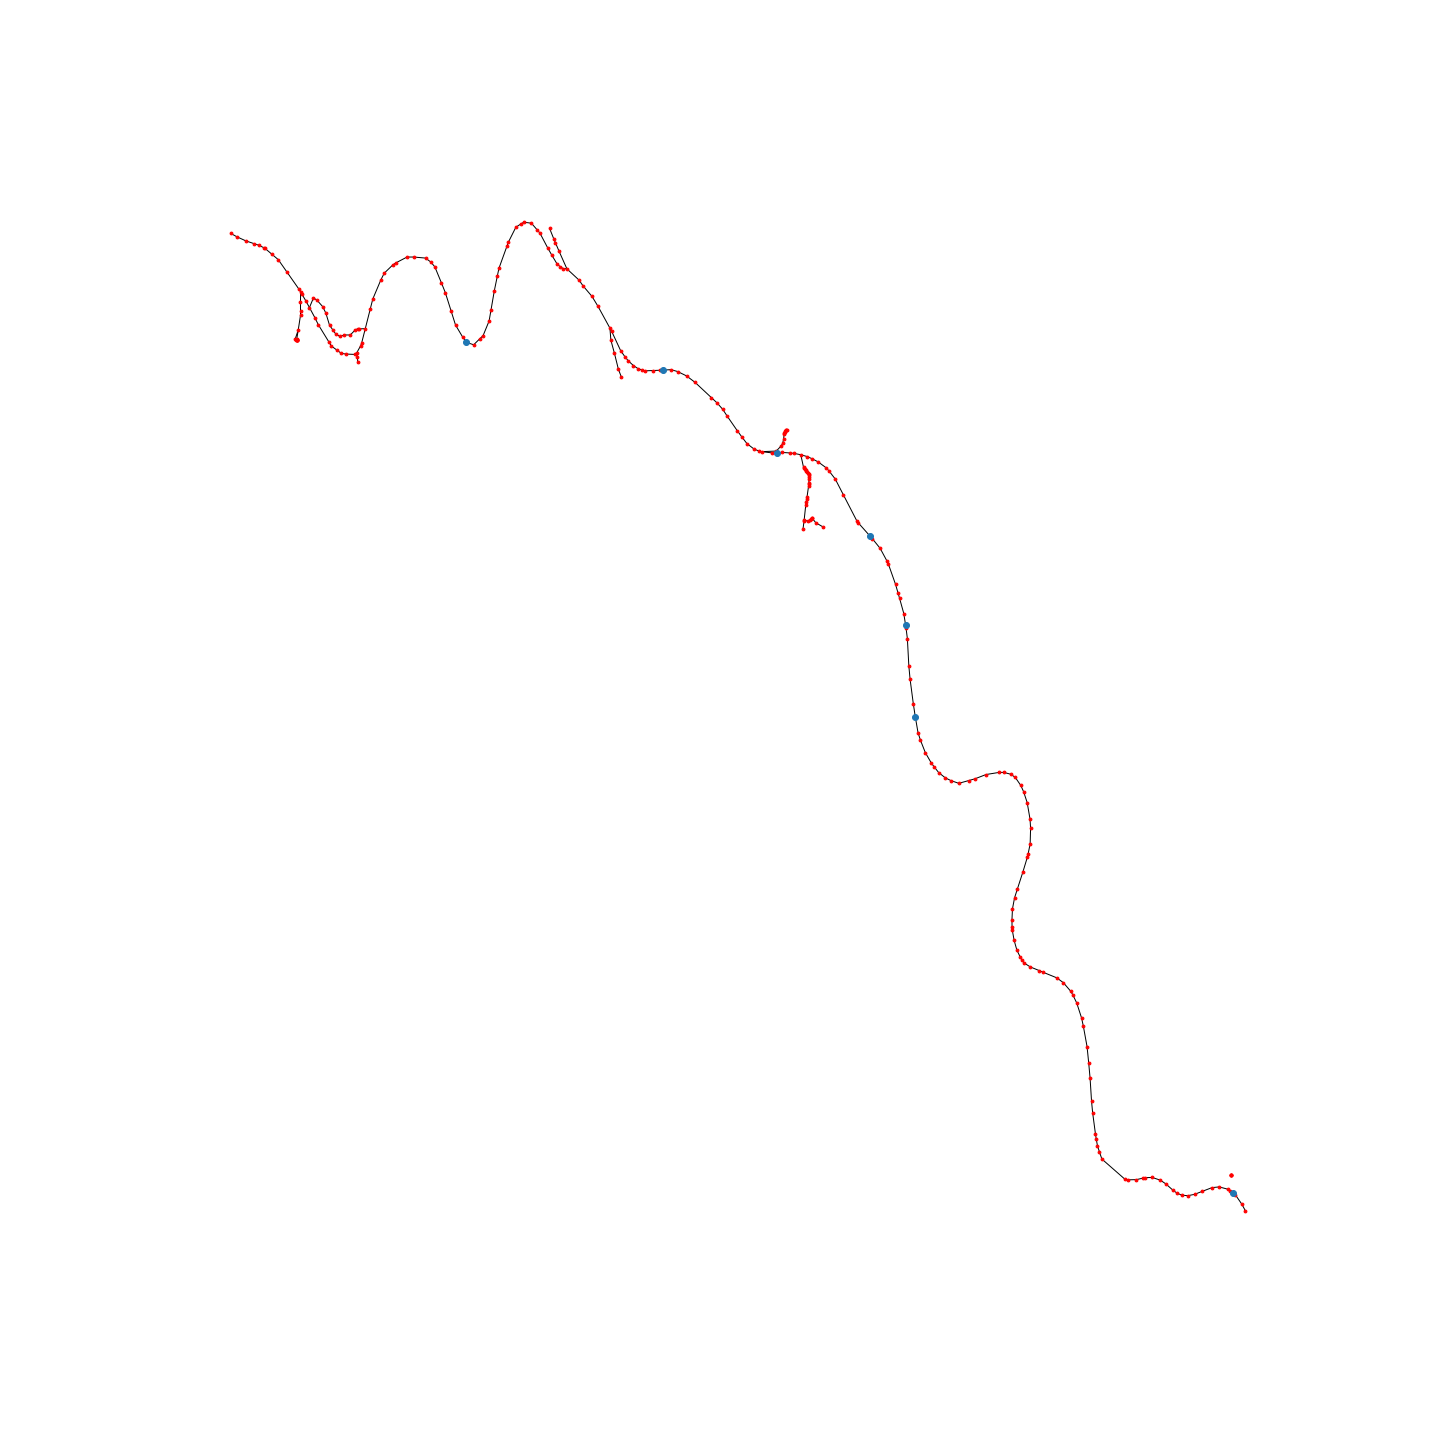
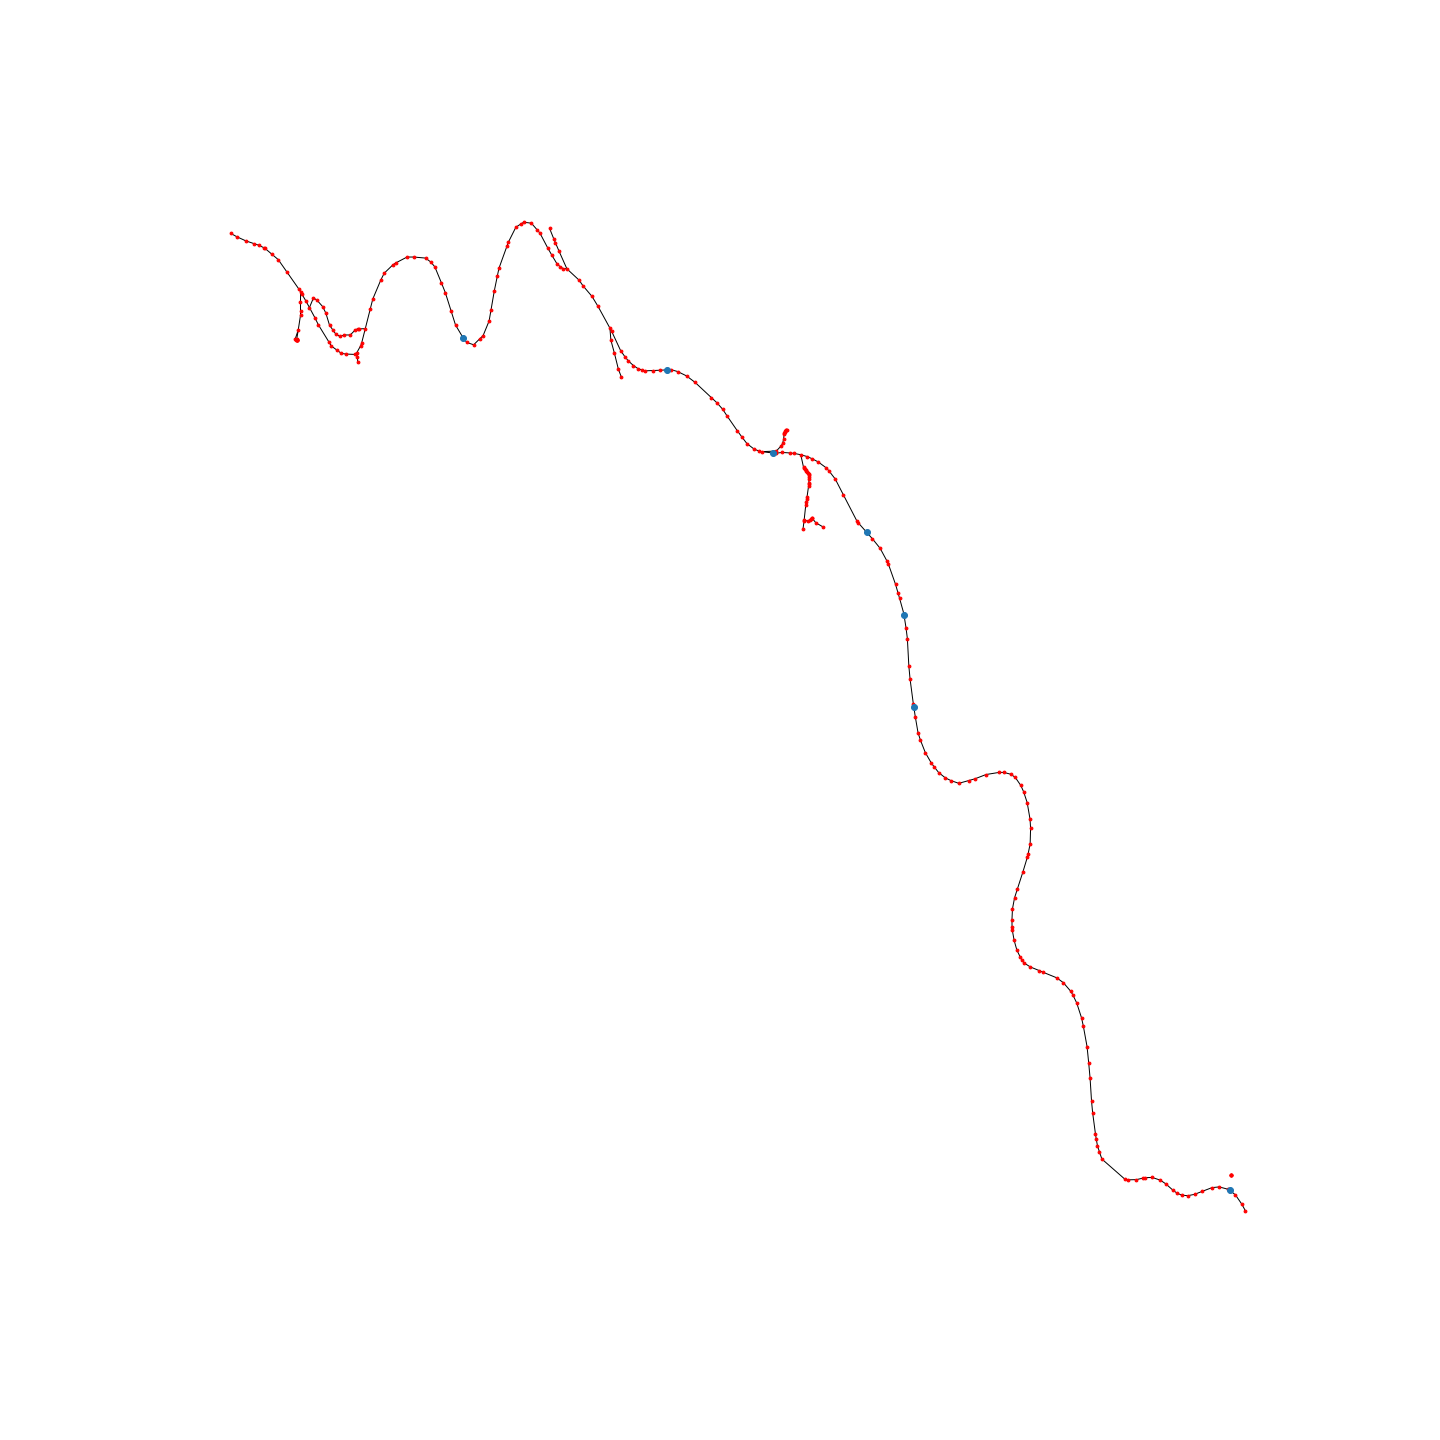
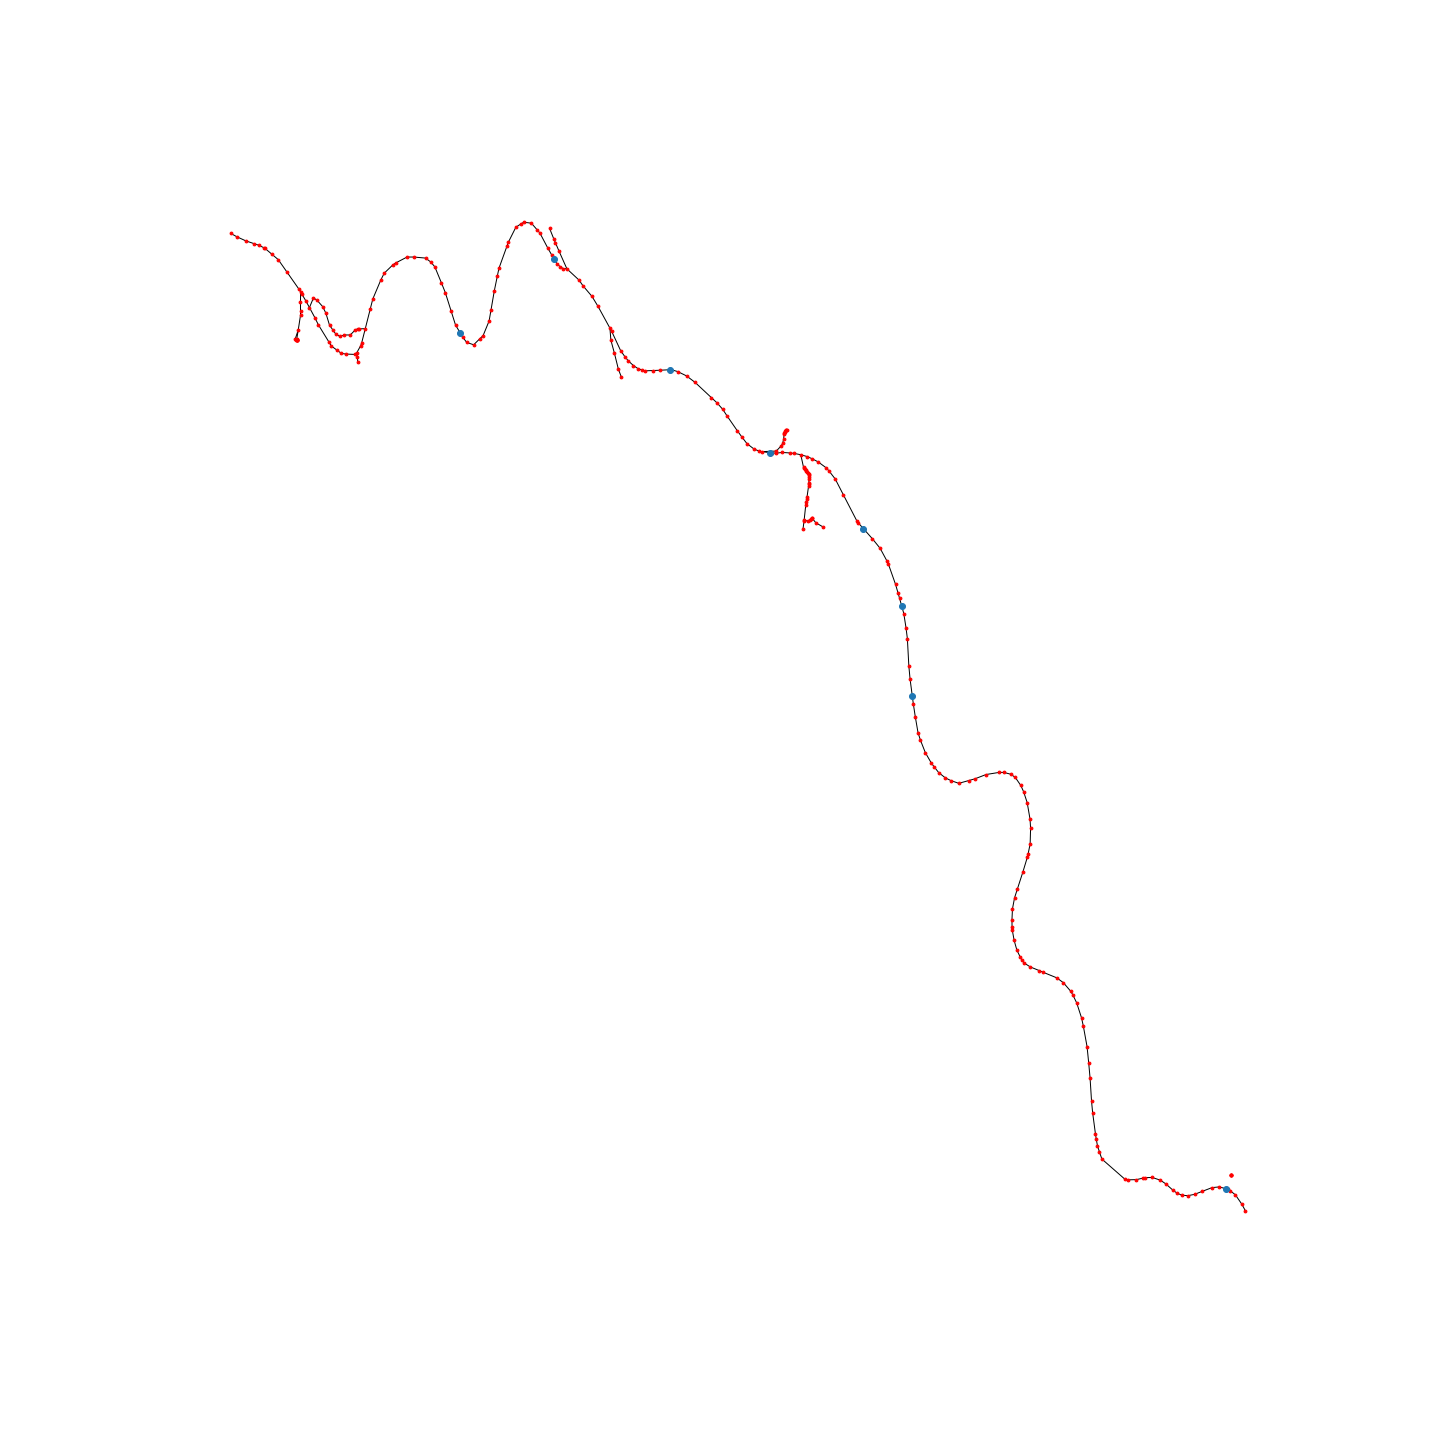
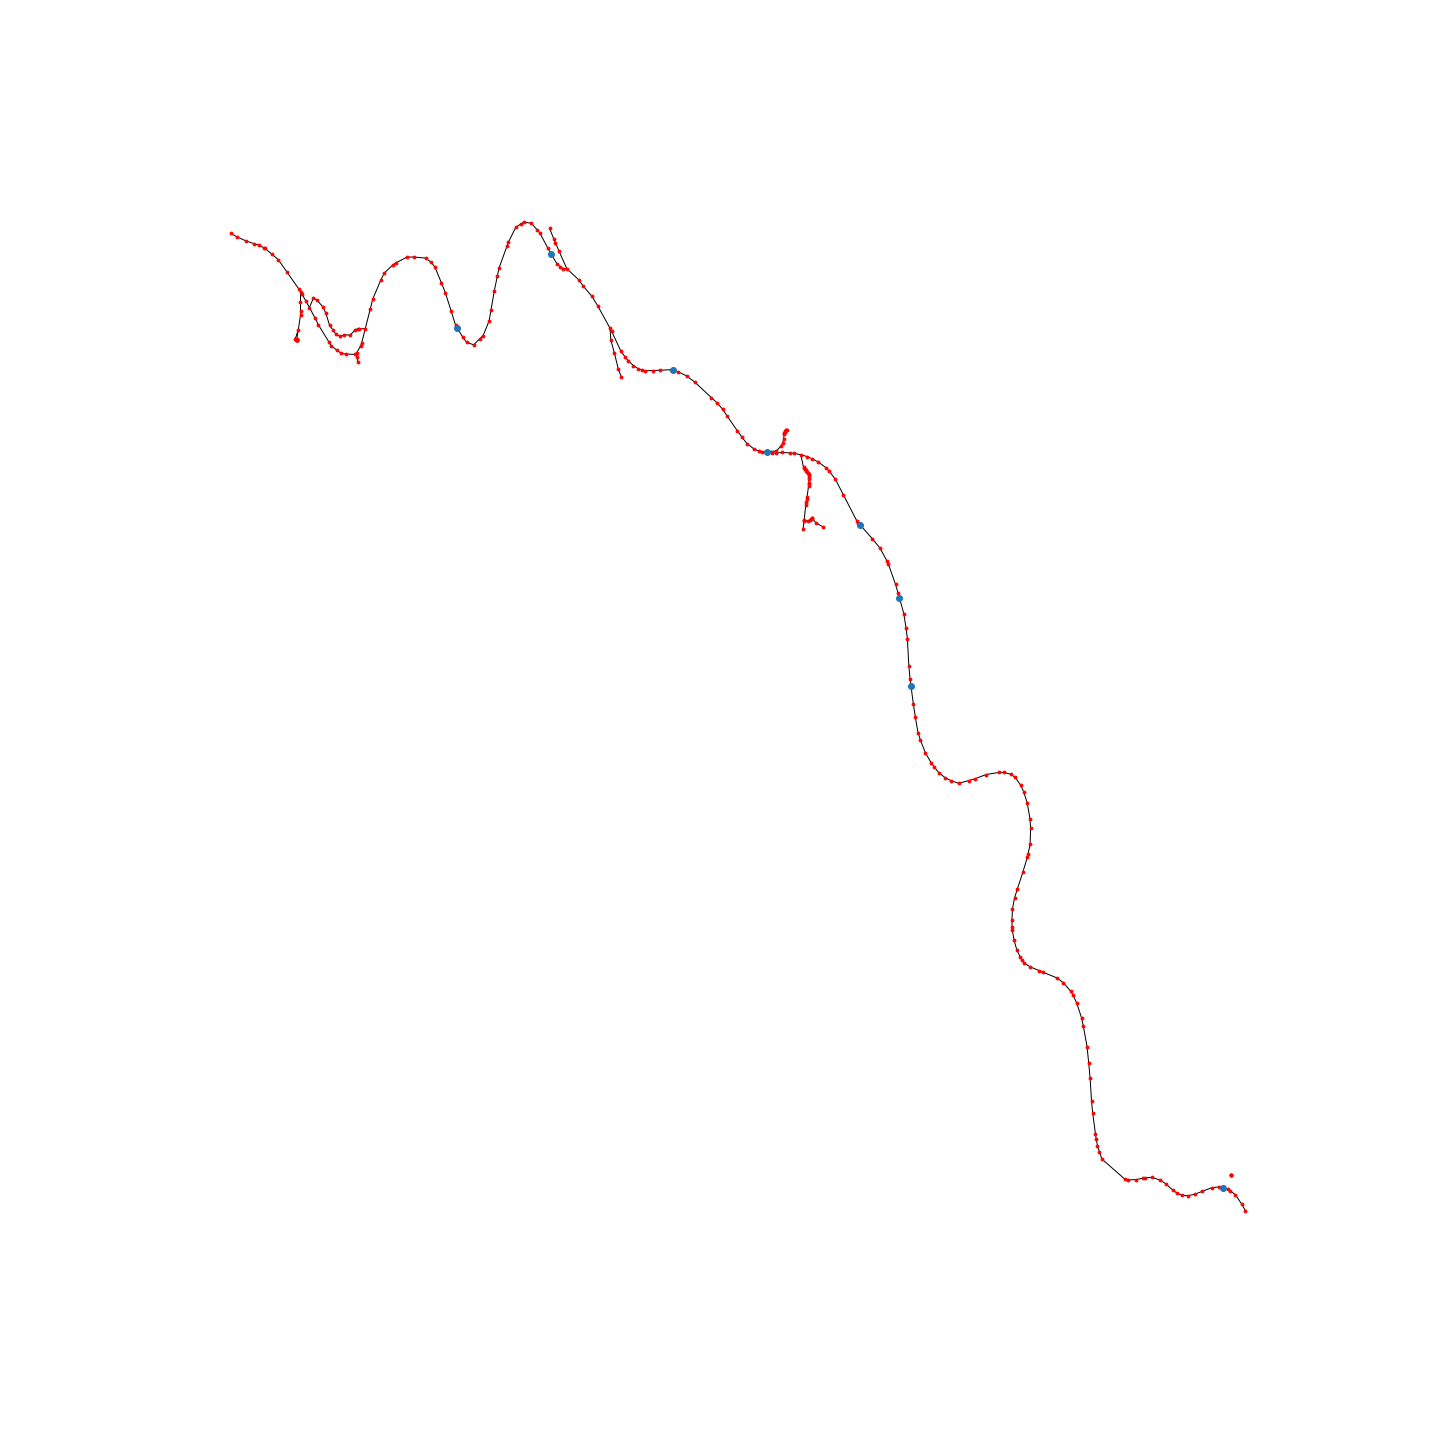
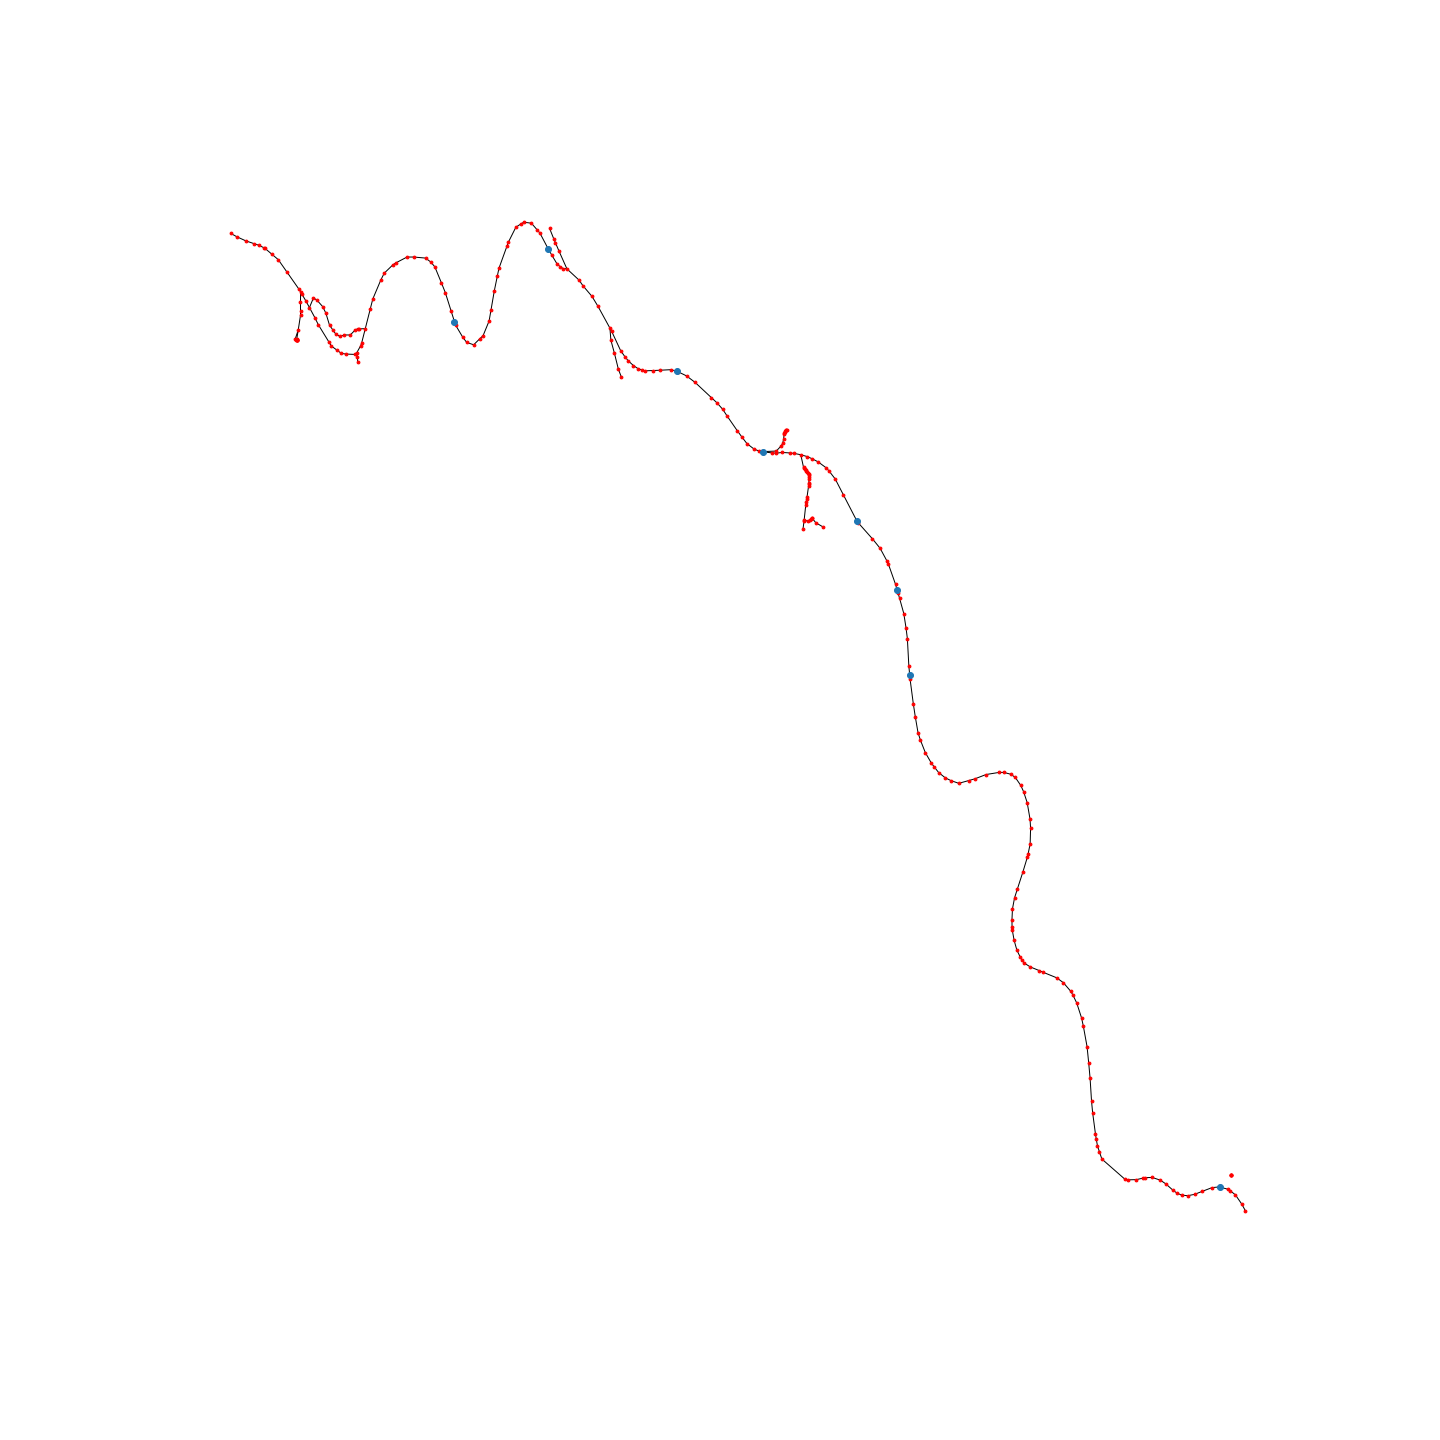
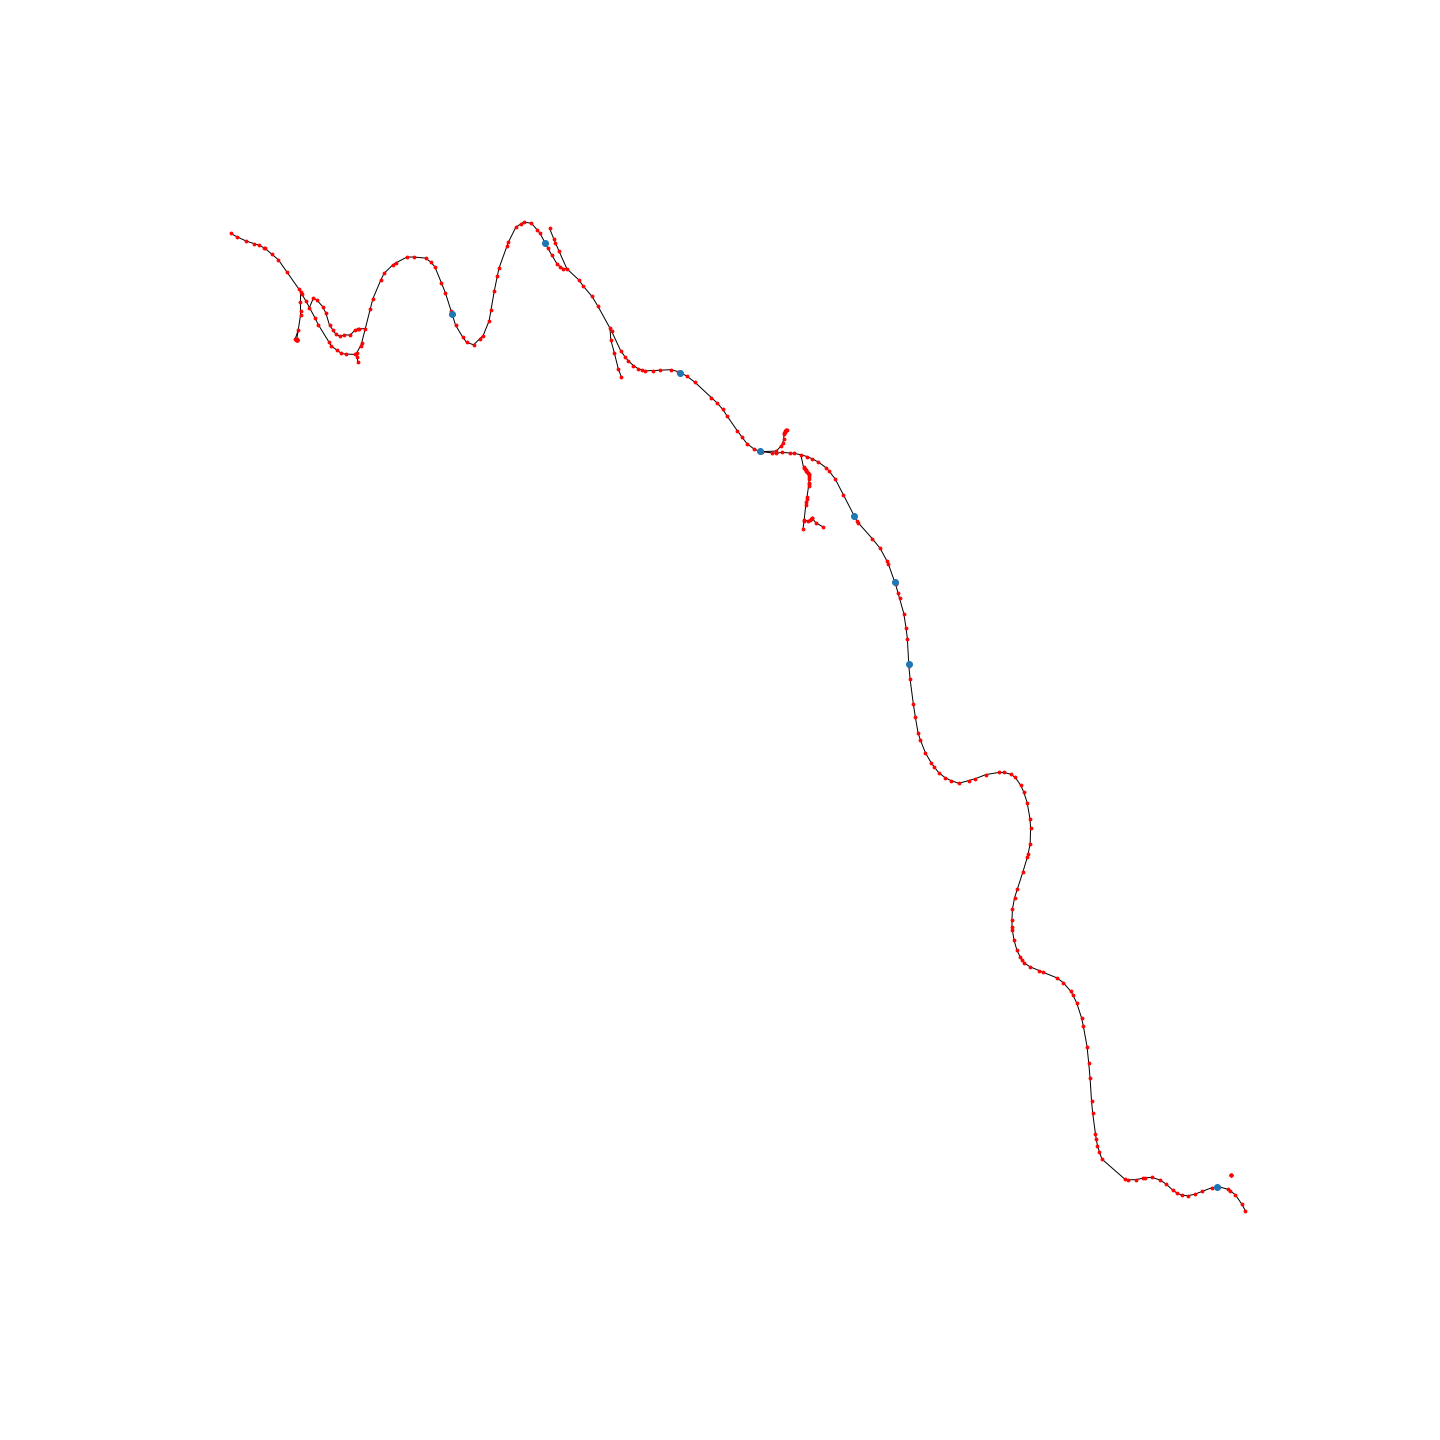
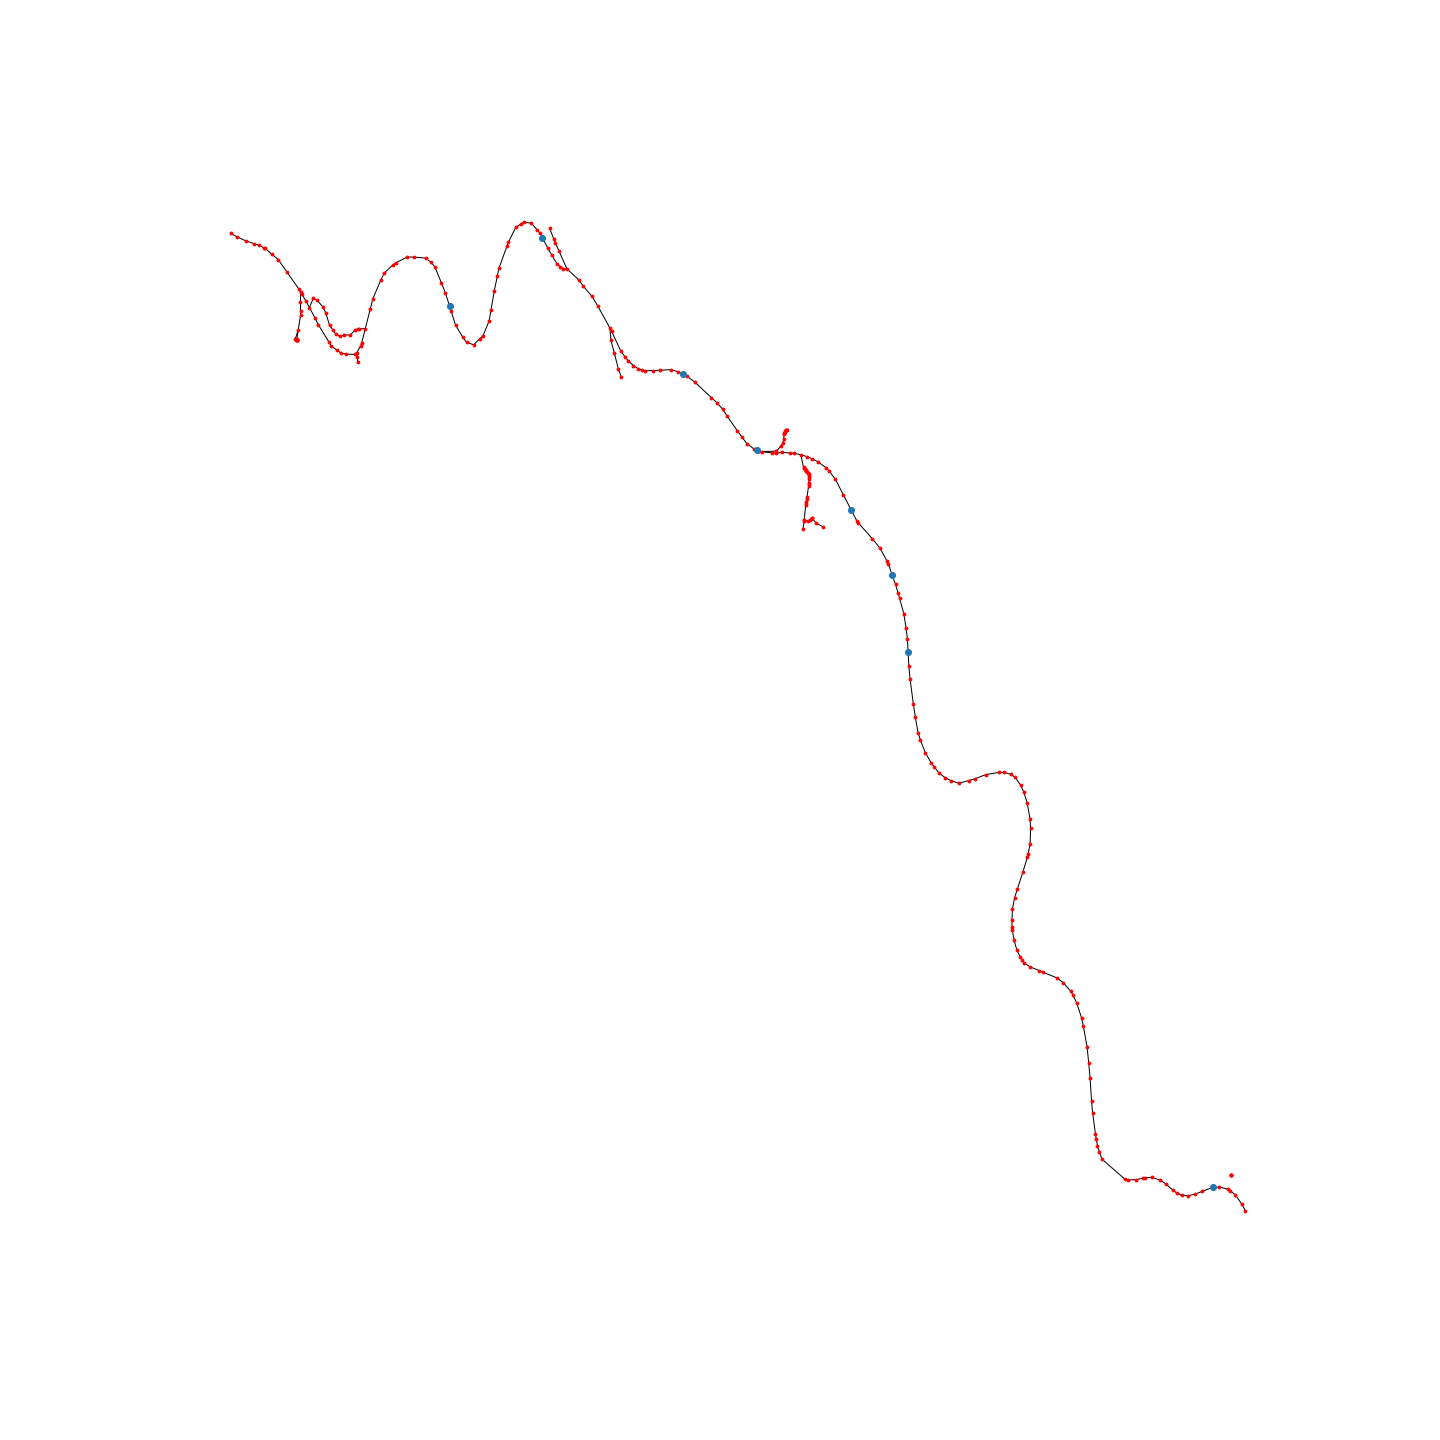
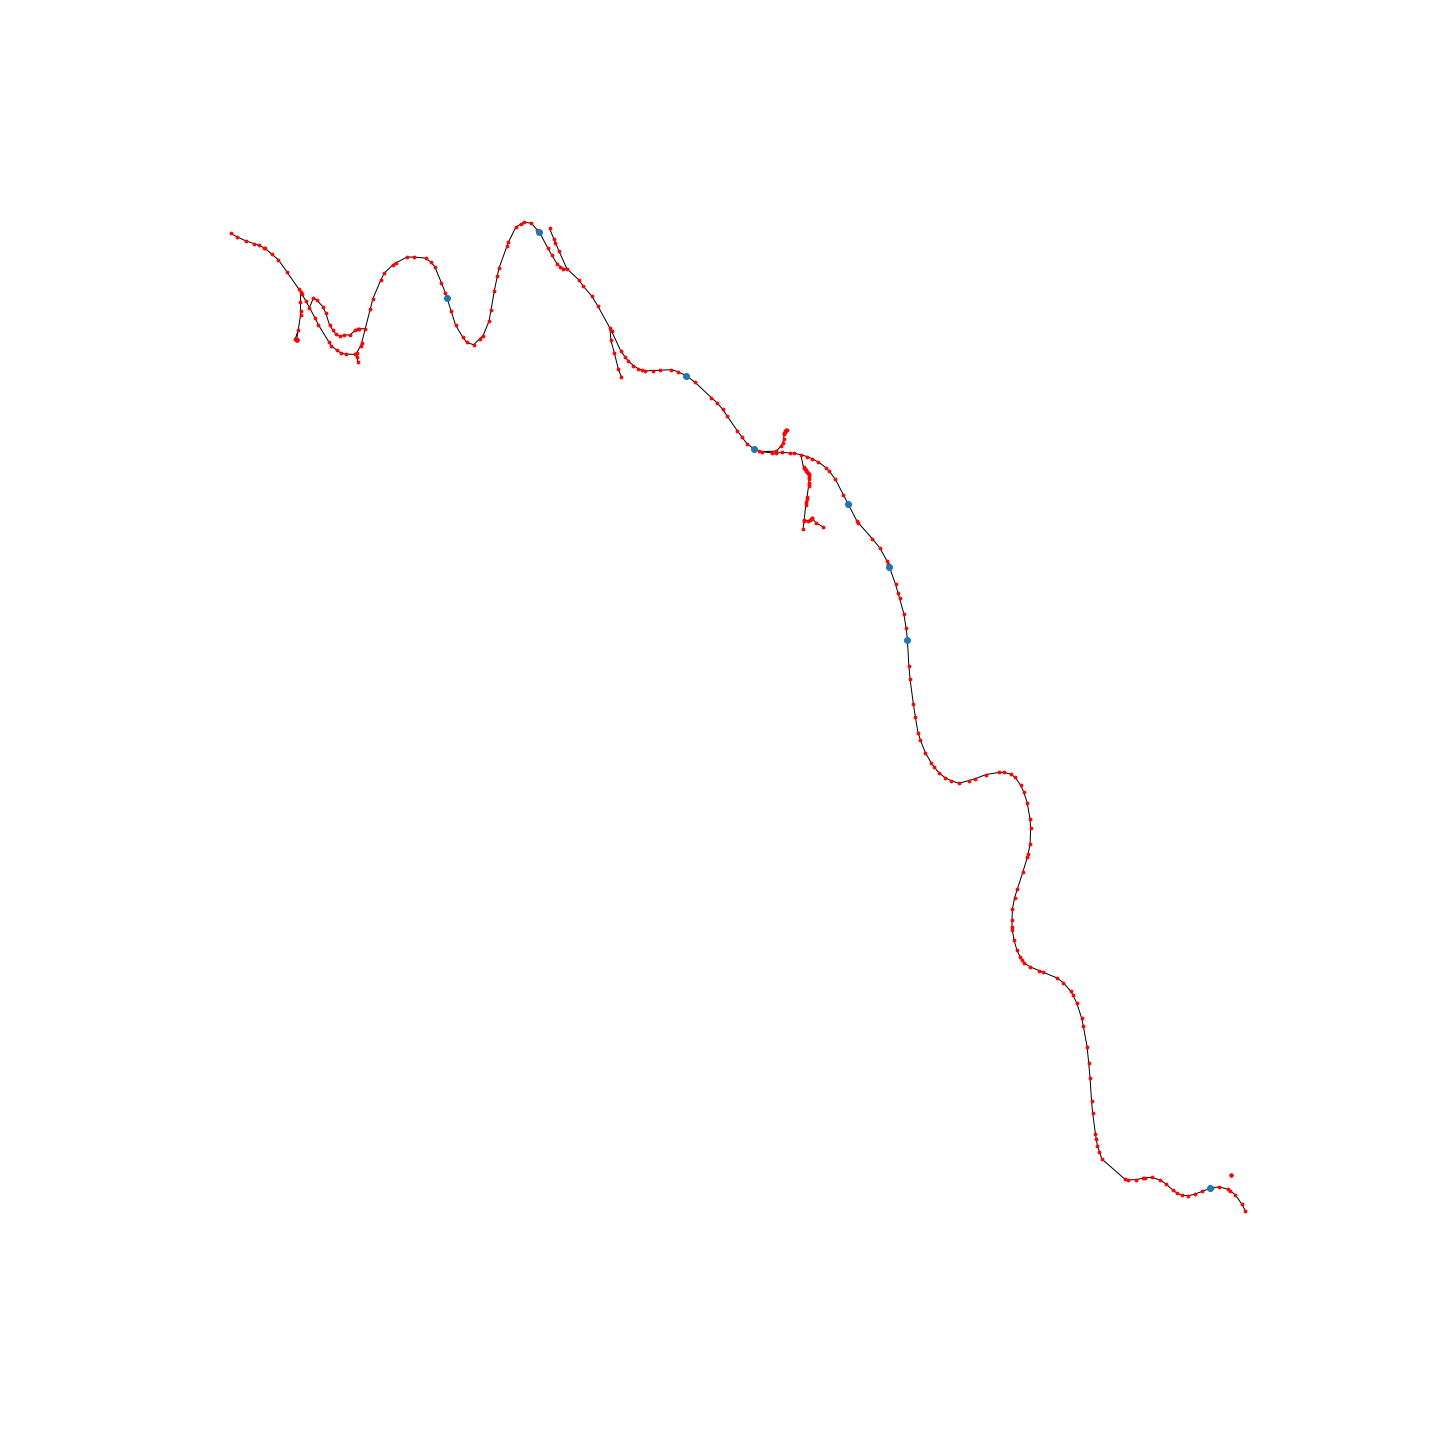
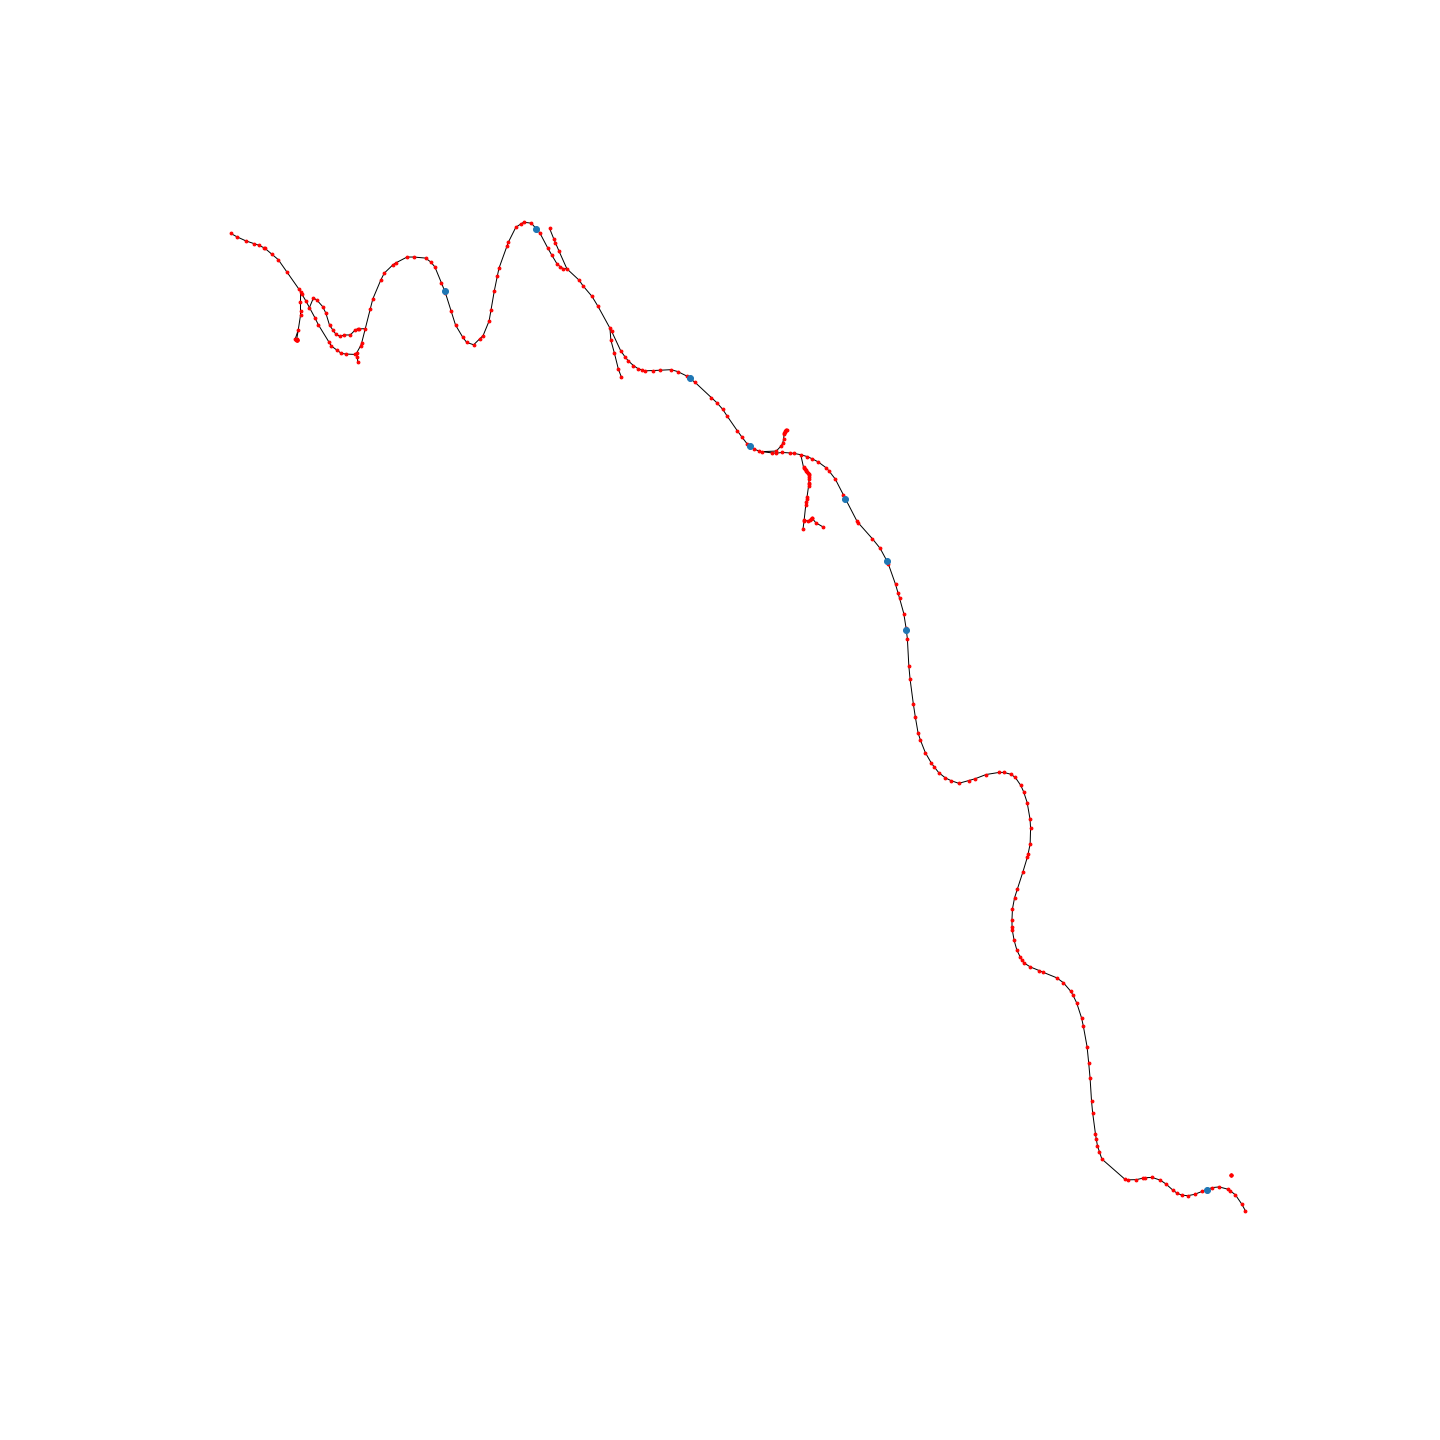
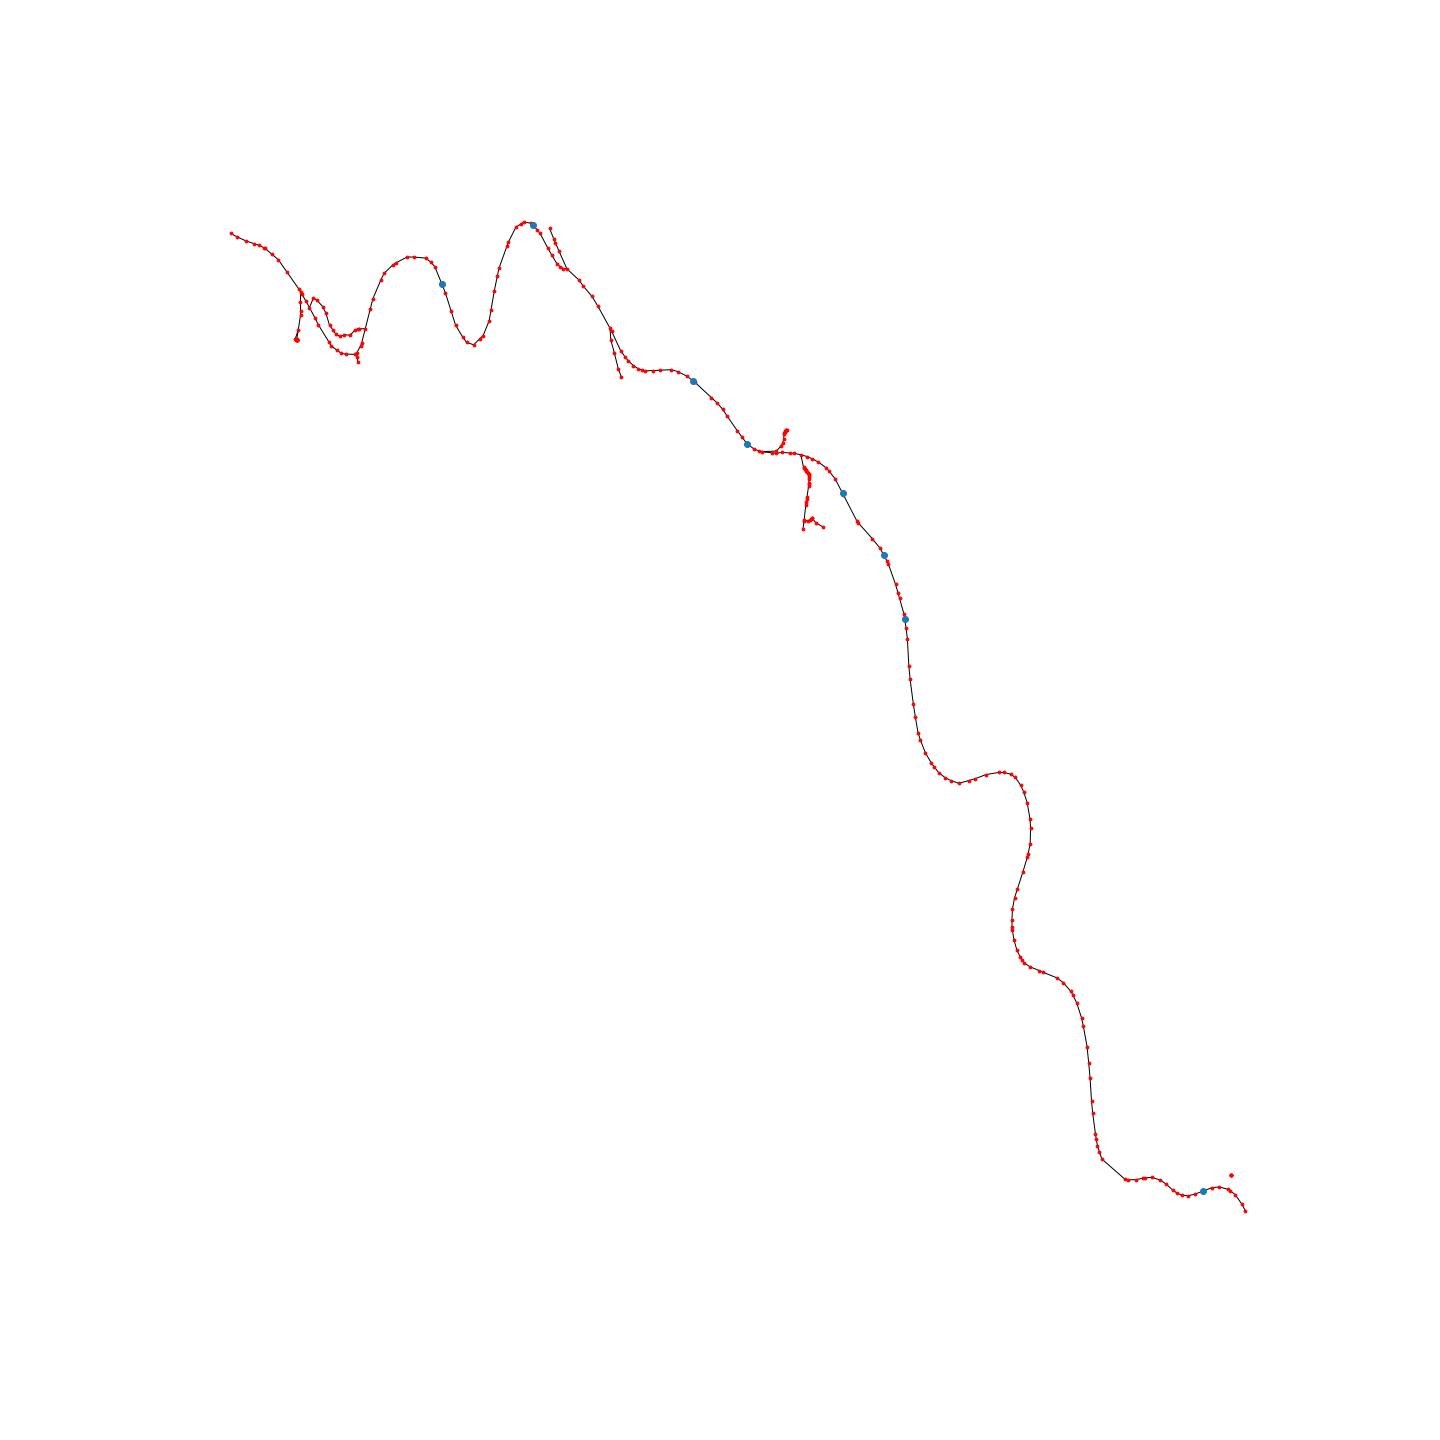

In [9]:
%matplotlib notebook
from matplotlib import animation
from JSAnimation import IPython_display
from IPython.display import HTML

fig = plt.figure(figsize=(20,20))
ax = plt.axes()


nx.draw(w_G,nx.get_node_attributes(w_G, 'pos'),node_size = 8)
n_steps = simulation.x_df.index 

graph, = plt.plot([],[],'o')


def get_data_x(i):
    return simulation.x_df.loc[i]

def get_data_y(i):
    return simulation.y_df.loc[i]


def animate(i):
    x = get_data_x(i)
    y= get_data_y(i)
    graph.set_data(x,y)
    return graph,

animation.FuncAnimation(fig, animate, frames=n_steps, repeat=True, blit=True, interval=40)
# change interval if you want to play more slowly; > interval = slower playback speed


In [8]:
"""
start_time = time.time()

def get_data_x(i):
    return simulation.x_df.loc[i]

def get_data_y(i):
    return simulation.y_df.loc[i]

def animate(i):
    x = get_data_x(i)
    y= get_data_y(i)   
    graph.set_data(x,y)
    return graph,

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

fig = plt.figure(figsize=(20,20))
ax = plt.axes()

nx.draw(w_G,nx.get_node_attributes(w_G, 'pos'),node_size = 0.1)

n_steps = simulation.x_df.index 

graph, = plt.plot([],[],'o')

ani = animation.FuncAnimation(fig, animate, frames= n_steps, interval=1, repeat=True, blit = True)
ani.save('/Users/JeroenvanderDoes/Downloads/canals_plea.mp4', writer=writer)


print("Animator : {} s".format(time.time() - start_time))

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-8-e8f67311862e>, line 33)